In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import json
import sys

from tqdm import tqdm

# config_file = sys.argv[1]

config_file = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/config_kdv.json'


with open(config_file, "r") as f:
    config = json.load(f)["linear"]
data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]
# figures_path = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/kdv_results/figures_tau_10'



n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]

forcing_type = config['data_settings']['forcing_type']


n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from koopmanlib.functions import *
from koopmanlib.target import KortewegDeVriesTarget
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3
kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)

# Load data
dict_data = np.load(
    os.path.join(data_path, "data_kdv_" + forcing_type + ".npy"), allow_pickle=True
)

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]


pknn_epochs = config["nn_settings"]["pknn_epochs"]


2024-07-29 20:31:41.248899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 20:31:41.390010: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 20:31:41.990469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-07-29 20:31:41.990646: W tensorflow/compiler/xla/stre

In [2]:


# Build model
## PK-NN
# from tensorflow.keras.optimizers import Adam

# from koopmanlib.dictionary import PsiNN_obs
# from koopmanlib.param_solver import KoopmanParametricDLSolver

# n_psi = 1 + 1 + 1 + n_psi_train  # constant + momentum + mean + NN

# dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# from koopmanlib.K_structure import Model_K_u_Layer_One

# model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

# solver_pk = KoopmanParametricDLSolver(
#     target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
# )

# model_pk, model_K_u_pred_pk = solver_pk.generate_model()

# model_pk.load_weights(os.path.join(weights_path, "pk_kdv_weights_" + forcing_type + ".h5"))

# def compute_pk_obs(y0, param_list, B_obs):
#     param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)

#     psi_y = dic_pk(y0)
#     obs_list = [psi_y @ B_obs]

#     tau = param_list.shape[0]

#     for i in range(tau):
#         psi_y = model_K_u_pred_pk([param[i], psi_y])
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))
# ## Linear
# from koopmanlib.param_solver import KoopmanLinearDLSolver

# dic_linear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# solver_linear = KoopmanLinearDLSolver(
#     dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
# )

# model_linear, model_K_u_pred_linear = solver_linear.build_model()

# solver_linear.model.load_weights(
#     os.path.join(weights_path, "linear_kdv_weights_" + forcing_type + ".h5")
# )
# def compute_linear_obs(y0, param_list, B_obs):
#     param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)
#     psi_y = solver_linear.dic.call(y0)
#     obs_list = [psi_y @ B_obs]

#     for param in param_list:
#         psi_y = solver_linear.model_K_u_pred_linear.get_layer("Layer_A")(psi_y) + solver_linear.model_K_u_pred_linear.get_layer(
#             "Layer_B"
#         )(param)
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))
# ## Bilinear
# from koopmanlib.param_solver import KoopmanBilinearDLSolver

# dic_bilinear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# solver_bilinear = KoopmanBilinearDLSolver(
#     dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
# )

# model_bilinear, model_K_u_pred_bilinear = solver_bilinear.build_model()
# solver_bilinear.model.load_weights(
#     os.path.join(weights_path, "bilinear_kdv_weights_" + forcing_type + ".h5")
# )
# def compute_bilinear_obs(y0, param_list, B_obs):
#     param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)
#     psi_y = solver_bilinear.dic.call(y0)
#     obs_list = [psi_y @ B_obs]

#     for param in param_list:
#         u_psiy = tf.einsum("ij,ik->kij", psi_y, param)
#         u_psiy_list = []
#         for curr in u_psiy:
#             u_psiy_list.append(curr)
#         u_psiy_list = tf.concat(u_psiy_list, axis=-1)

#         psi_y = solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_A")(
#             psi_y
#         ) + solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_B")(u_psiy_list)
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))



In [3]:

# Testing problems
# Plot setting
linear_curve = "darkorange"
linear_shadow = "navajowhite"
bilinear_curve = "forestgreen"
bilinear_shadow = "darkseagreen"
pk_curve = "darkblue"
pk_shadow = "lightsteelblue"
ref_color = "black"


exact_color = "darkred"
linear_no_penalty_color = "gold"
bilinear_no_penalty_color = "turquoise"
pk_no_penalty_color = "palevioletred"

label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = "dashdot"
bilinear_linestyle = "dotted"
pk_linestyle = "solid"
## Prediction
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv.kdv_solution(y0_loop, T, param)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list
    
pred_traj_number = 10
np.random.seed(625)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number, 2))

y0_pred_list = []
param_pred_list = []

Tsim_pred = 0.1
traj_len_pred = int(Tsim_pred / T)


In [4]:

# for seed_IC, seed_u in seed_list:
#     # Forward prediction problem setting
#     y0_pred = kdv.generate_y0(seed_IC)

#     # Set the seed of param_list
#     np.random.seed(seed_u)

#     param_pred = (
#         np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
#     )

#     y0_pred_list.append(y0_pred)
#     param_pred_list.append(param_pred)
# error_mass_list_pk, error_momentum_list_pk = kdv.compute_obs_error(
#     dic=dic_pk,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_pk_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )

# mass_mean_pk, mass_std_pk, mass_mean_plus_pk, mass_mean_minus_pk = compute_stat_info(
#     error_mass_list_pk
# )
# momentum_mean_pk, momentum_std_pk, momentum_mean_plus_pk, momentum_mean_minus_pk = (
#     compute_stat_info(error_momentum_list_pk)
# )
# error_mass_list_linear, error_momentum_list_linear = kdv.compute_obs_error(
#     dic=dic_linear,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_linear_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )
# mass_mean_linear, mass_std_linear, mass_mean_plus_linear, mass_mean_minus_linear = (
#     compute_stat_info(error_mass_list_linear)
# )
# (
#     momentum_mean_linear,
#     momentum_std_linear,
#     momentum_mean_plus_linear,
#     momentum_mean_minus_linear,
# ) = compute_stat_info(error_momentum_list_linear)
# error_mass_list_bilinear, error_momentum_list_bilinear = kdv.compute_obs_error(
#     dic=dic_bilinear,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_bilinear_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )
# mass_mean_bilinear, mass_std_bilinear, mass_mean_plus_bilinear, mass_mean_minus_bilinear = (
#     compute_stat_info(error_mass_list_bilinear)
# )
# (
#     momentum_mean_bilinear,
#     momentum_std_bilinear,
#     momentum_mean_plus_bilinear,
#     momentum_mean_minus_bilinear,
# ) = compute_stat_info(error_momentum_list_bilinear)
# t_axis = np.arange(0, traj_len_pred + 1, 1)

# # plt.title("Mass", fontsize=28)


# plt.plot(mass_mean_pk,
#           label="Ours", 
#           color=pk_curve,
#           linestyle=pk_linestyle,
#           linewidth=3, 
#           alpha=0.5)
# plt.fill_between(
#     t_axis, np.maximum(mass_mean_minus_pk, 0), mass_mean_plus_pk, color=pk_shadow, alpha=0.5
# )

# plt.plot(mass_mean_linear, 
#          label="M2", 
#          color=linear_curve,
#          linestyle=linear_linestyle, 
#          linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(mass_mean_minus_linear, 0),
#     mass_mean_plus_linear,
#     color=linear_shadow,
#     alpha=0.5,
# )

# plt.plot(mass_mean_bilinear, 
#          label="M3", 
#          color=bilinear_curve,
#          linestyle=bilinear_linestyle,
#            linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(mass_mean_minus_bilinear, 0),
#     mass_mean_plus_bilinear,
#     color=bilinear_shadow,
#     alpha=0.5,
# )

# plt.xlabel(r"$n$", fontsize=28)
# plt.ylabel("Error", fontsize=28)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_pred.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_pred.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

# print('---Predict Mass Done---')

# t_axis = np.arange(0, traj_len_pred + 1, 1)

# # plt.title("Momentum", fontsize=28)
# plt.plot(momentum_mean_pk, 
#          label="Ours", 
#          color=pk_curve,
#          linestyle=pk_linestyle, 
#          linewidth=3, 
#          alpha=0.5)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_pk, 0),
#     momentum_mean_plus_pk,
#     color=pk_shadow,
#     alpha=0.5,
# )

# plt.plot(momentum_mean_linear,
#           label="M2", 
#           color=linear_curve,
#           linestyle=linear_linestyle,
#           linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_linear, 0),
#     momentum_mean_plus_linear,
#     color=linear_shadow,
#     alpha=0.5,
# )

# plt.plot(momentum_mean_bilinear, 
#          label="M3", 
#          color=bilinear_curve, 
#         linestyle=bilinear_linestyle,
#          linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_bilinear, 0),
#     momentum_mean_plus_bilinear,
#     color=bilinear_shadow,
#     alpha=0.5,
# )

# plt.xlabel(r"$n$", fontsize=28)
# plt.ylabel("Error", fontsize=28)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_pred.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_pred.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

# print('---Predict Momentum Done---')


## Build vanilla model

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
# Set the default data type to float64
tf.keras.backend.set_floatx('float64')

# Define the input layers
input_x = layers.Input(shape=(Nx,))
input_u = layers.Input(shape=(param_dim,))

# Concatenate the inputs
concatenated = layers.Concatenate()([input_x, input_u])

# Hidden layer
hidden_layer = layers.Dense(20, activation='relu')(concatenated) 

# Output layer
output_y = layers.Dense(Nx, activation='linear')(hidden_layer)

# Create the model
model_vanilla = models.Model(inputs=[input_x, input_u], outputs=output_y)

# Print model summary to check the number of parameters
model_vanilla.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 131)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 20)           2640        ['concatenate[0][0]']        

2024-07-29 20:31:45.513813: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-29 20:31:45.513858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-07-29 20:31:45.513865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-07-29 20:31:45.514010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.171.4
2024-07-29 20:31:45.514033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.171.4
2024-07-29 20:31:45.514039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.171.4
2024-07-29 20:31:45.514318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep 

In [6]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model_vanilla.compile(optimizer=Adam(0.001), loss="mse")

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=50,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-12,
)

In [7]:
history_nonlinear = model_vanilla.fit([data_x, data_u], data_y, epochs=pknn_epochs, batch_size=200, callbacks=lr_callback)

Epoch 1/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0059
Epoch 2/200
1000/1000 [==============================] - 2s 2ms/step - loss: 4.2967e-04
Epoch 3/200
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6445e-04
Epoch 4/200
1000/1000 [==============================] - 2s 2ms/step - loss: 9.8889e-05
Epoch 5/200
1000/1000 [==============================] - 2s 2ms/step - loss: 7.5099e-05
Epoch 6/200
1000/1000 [==============================] - 2s 2ms/step - loss: 6.1067e-05
Epoch 7/200
1000/1000 [==============================] - 2s 2ms/step - loss: 5.9571e-05
Epoch 8/200
1000/1000 [==============================] - 2s 2ms/step - loss: 5.9206e-05
Epoch 9/200
1000/1000 [==============================] - 2s 2ms/step - loss: 5.8877e-05
Epoch 10/200
1000/1000 [==============================] - 2s 2ms/step - loss: 5.8848e-05
Epoch 11/200
1000/1000 [==============================] - 2s 2ms/step - loss: 5.8666e-05
Epoch 12/200
1000/1000 [==========

In [8]:

# Tracking problem
from scipy.optimize import minimize
# Testing reference
y0_track = np.zeros(shape=(Nx,)) + 0.2
Tsim_track = 10

traj_len_track = int(Tsim_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1, 1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1, 1))


In [9]:
def compute_mass(inputs):
    obs_mass = dx * tf.reshape(tf.math.reduce_sum(inputs, axis=-1), shape=(-1, 1))
    return obs_mass

def compute_momentum(inputs):
    obs_momentum = dx * tf.reshape(
        tf.math.reduce_sum(tf.square(inputs), axis=-1), shape=(-1, 1)
    )
    return obs_momentum

In [10]:
def mpc_loss_vanilla(param, tau, ref_list, y0, obs_func, lambda_param):
    param = tf.reshape(param, shape=(tau, 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    y_list = [y0]

    for i in range(tau):
        y_next = model_vanilla([y_list[-1], param[i]])
        obs_next = obs_func(y_next)
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss

In [11]:

import time
def VanillaMPC(y0, tau, traj_len, soln_ref, kdv_solver, obs_func, loss, lambda_param):

    bounds = []
    for i in range(tau * param_dim):
        bounds.append((-1, 1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    results_list = []

    t_list = []

    param_init = (
            np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
        )

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

        t1 = time.time()
        results = minimize(
            loss,
            x0=param_init,
            args=(
                tau,
                soln_ref[current_time + 1 : current_time + 1 + tau, :],
                y0_mpc_loop_list[-1],
                obs_func,
                lambda_param,
            ),
            bounds=bounds,
            method='L-BFGS-B'
        )

        t2 = time.time()

        results_list.append(results)

        param = results.x.reshape(tau, param_dim)[0]
        param_init = results.x.reshape((tau * param_dim,))
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)

        print("*** current time ***", current_time)
        print("optimize time: ", t2-t1)

        t_list.append(t2-t1)

    print("t mean: ", np.mean(t_list))

    current_time = current_time + 1

    # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

    results = minimize(
        loss,
        x0=param_init,
        args=(
            tau,
            soln_ref[current_time + 1 : current_time + 1 + tau, :],
            y0_mpc_loop_list[-1],
            obs_func,
            lambda_param,
        ),
        bounds=bounds,
    )
    results_list.append(results)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

    return opt_control_list, y0_mpc_loop_list, results_list, t_list



In [12]:

### Track mass
tau = 10  # time horizon
# lambda_param = 0.005
# lambda_param = 0

vanilla_opt_control_mass_0, vanilla_kdv_opt_mass_soln_0, vanilla_results_mass_0, vanilla_t_list_mass_0 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_mass,
    loss=mpc_loss_vanilla,
    lambda_param=0,
)

vanilla_opt_control_mass_5, vanilla_kdv_opt_mass_soln_5, vanilla_results_mass_5, vanilla_t_list_mass_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_mass,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)


vanilla_kdv_opt_mass_0 = dx * tf.reduce_sum(vanilla_kdv_opt_mass_soln_0, axis=-1)
vanilla_kdv_opt_mass_5 = dx * tf.reduce_sum(vanilla_kdv_opt_mass_soln_5, axis=-1)

### Check exact control for KdV equation
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)


def v1_func(x):
    return np.exp(-25 * (x + np.pi / 2) ** 2)


def v2_func(x):
    return np.exp(-25 * (x) ** 2)


def v3_func(x):
    return np.exp(-25 * (x - np.pi / 2) ** 2)


from scipy import integrate

integral_1, error_1 = integrate.quad(v1_func, -np.pi, np.pi)

integral_2, error_2 = integrate.quad(v2_func, -np.pi, np.pi)

integral_3, error_3 = integrate.quad(v3_func, -np.pi, np.pi)

rhs_value = integral_1 + integral_2 + integral_3

mass_y0_track = dx * tf.reshape(tf.math.reduce_sum(y0_track, axis=-1), shape=(-1, 1))

track_time_1 = (mass_ref[0] - mass_y0_track) / rhs_value
track_step_1 = int(track_time_1 / T)

track_time_2 = (mass_ref[-1] - mass_ref[0]) / rhs_value
track_step_2 = int(track_time_2 / T)

control_exact_opt = np.zeros(shape=vanilla_opt_control_mass_0.shape, dtype="float64")

control_exact_opt[:track_step_1] = 0.5
control_exact_opt[500 : 500 + track_step_2] = 0.5

kdv_opt_control = compute_kdv_soln(y0_track, control_exact_opt)

kdv_opt_control = np.asarray(kdv_opt_control)
kdv_opt_mass = dx * tf.reshape(tf.math.reduce_sum(kdv_opt_control, axis=-1), shape=(-1, 1))


Processing time steps:   0%|          | 1/989 [00:02<41:09,  2.50s/it]

*** current time *** 0
optimize time:  2.218801736831665


Processing time steps:   0%|          | 2/989 [00:03<26:54,  1.64s/it]

*** current time *** 1
optimize time:  0.7232320308685303


Processing time steps:   0%|          | 3/989 [00:04<22:01,  1.34s/it]

*** current time *** 2
optimize time:  0.6935155391693115


Processing time steps:   0%|          | 4/989 [00:05<19:51,  1.21s/it]

*** current time *** 3
optimize time:  0.6974525451660156


Processing time steps:   1%|          | 5/989 [00:06<19:25,  1.18s/it]

*** current time *** 4
optimize time:  0.8294050693511963


Processing time steps:   1%|          | 6/989 [00:07<18:29,  1.13s/it]

*** current time *** 5
optimize time:  0.7126359939575195


Processing time steps:   1%|          | 7/989 [00:08<17:58,  1.10s/it]

*** current time *** 6
optimize time:  0.732025146484375


Processing time steps:   1%|          | 8/989 [00:09<17:37,  1.08s/it]

*** current time *** 7
optimize time:  0.7397842407226562


Processing time steps:   1%|          | 9/989 [00:10<17:14,  1.06s/it]

*** current time *** 8
optimize time:  0.7045707702636719


Processing time steps:   1%|          | 10/989 [00:11<17:07,  1.05s/it]

*** current time *** 9
optimize time:  0.7260346412658691


Processing time steps:   1%|          | 11/989 [00:12<17:00,  1.04s/it]

*** current time *** 10
optimize time:  0.7072567939758301


Processing time steps:   1%|          | 12/989 [00:13<16:45,  1.03s/it]

*** current time *** 11
optimize time:  0.6959717273712158


Processing time steps:   1%|▏         | 13/989 [00:14<16:38,  1.02s/it]

*** current time *** 12
optimize time:  0.7027792930603027


Processing time steps:   1%|▏         | 14/989 [00:15<16:35,  1.02s/it]

*** current time *** 13
optimize time:  0.7046709060668945


Processing time steps:   2%|▏         | 15/989 [00:16<16:38,  1.02s/it]

*** current time *** 14
optimize time:  0.7223217487335205


Processing time steps:   2%|▏         | 16/989 [00:17<16:25,  1.01s/it]

*** current time *** 15
optimize time:  0.7050347328186035


Processing time steps:   2%|▏         | 17/989 [00:18<16:14,  1.00s/it]

*** current time *** 16
optimize time:  0.6764369010925293


Processing time steps:   2%|▏         | 18/989 [00:19<16:16,  1.01s/it]

*** current time *** 17
optimize time:  0.7018163204193115


Processing time steps:   2%|▏         | 19/989 [00:20<16:18,  1.01s/it]

*** current time *** 18
optimize time:  0.7224955558776855


Processing time steps:   2%|▏         | 20/989 [00:21<16:14,  1.01s/it]

*** current time *** 19
optimize time:  0.7101638317108154


Processing time steps:   2%|▏         | 21/989 [00:22<16:16,  1.01s/it]

*** current time *** 20
optimize time:  0.7164452075958252


Processing time steps:   2%|▏         | 22/989 [00:23<16:18,  1.01s/it]

*** current time *** 21
optimize time:  0.7062454223632812


Processing time steps:   2%|▏         | 23/989 [00:24<16:11,  1.01s/it]

*** current time *** 22
optimize time:  0.7078227996826172


Processing time steps:   2%|▏         | 24/989 [00:26<16:41,  1.04s/it]

*** current time *** 23
optimize time:  0.7189419269561768


Processing time steps:   3%|▎         | 25/989 [00:27<16:26,  1.02s/it]

*** current time *** 24
optimize time:  0.7066032886505127


Processing time steps:   3%|▎         | 26/989 [00:28<16:24,  1.02s/it]

*** current time *** 25
optimize time:  0.7053184509277344


Processing time steps:   3%|▎         | 27/989 [00:29<16:23,  1.02s/it]

*** current time *** 26
optimize time:  0.7074244022369385


Processing time steps:   3%|▎         | 28/989 [00:30<16:14,  1.01s/it]

*** current time *** 27
optimize time:  0.7020924091339111


Processing time steps:   3%|▎         | 29/989 [00:31<16:07,  1.01s/it]

*** current time *** 28
optimize time:  0.7089262008666992


Processing time steps:   3%|▎         | 30/989 [00:32<16:08,  1.01s/it]

*** current time *** 29
optimize time:  0.7060737609863281


Processing time steps:   3%|▎         | 31/989 [00:33<16:10,  1.01s/it]

*** current time *** 30
optimize time:  0.7155146598815918


Processing time steps:   3%|▎         | 32/989 [00:34<16:06,  1.01s/it]

*** current time *** 31
optimize time:  0.7059669494628906


Processing time steps:   3%|▎         | 33/989 [00:35<16:07,  1.01s/it]

*** current time *** 32
optimize time:  0.7259173393249512


Processing time steps:   3%|▎         | 34/989 [00:36<16:00,  1.01s/it]

*** current time *** 33
optimize time:  0.6976790428161621


Processing time steps:   4%|▎         | 35/989 [00:37<16:02,  1.01s/it]

*** current time *** 34
optimize time:  0.7076971530914307


Processing time steps:   4%|▎         | 36/989 [00:38<16:09,  1.02s/it]

*** current time *** 35
optimize time:  0.7265985012054443


Processing time steps:   4%|▎         | 37/989 [00:39<16:07,  1.02s/it]

*** current time *** 36
optimize time:  0.7041616439819336


Processing time steps:   4%|▍         | 38/989 [00:40<16:00,  1.01s/it]

*** current time *** 37
optimize time:  0.7084386348724365


Processing time steps:   4%|▍         | 39/989 [00:41<15:57,  1.01s/it]

*** current time *** 38
optimize time:  0.7063260078430176


Processing time steps:   4%|▍         | 40/989 [00:42<15:54,  1.01s/it]

*** current time *** 39
optimize time:  0.7009539604187012


Processing time steps:   4%|▍         | 41/989 [00:43<15:57,  1.01s/it]

*** current time *** 40
optimize time:  0.7093157768249512


Processing time steps:   4%|▍         | 42/989 [00:44<16:38,  1.05s/it]

*** current time *** 41
optimize time:  0.840998649597168


Processing time steps:   4%|▍         | 43/989 [00:45<17:21,  1.10s/it]

*** current time *** 42
optimize time:  0.8999028205871582


Processing time steps:   4%|▍         | 44/989 [00:46<16:57,  1.08s/it]

*** current time *** 43
optimize time:  0.7170689105987549


Processing time steps:   5%|▍         | 45/989 [00:47<16:59,  1.08s/it]

*** current time *** 44
optimize time:  0.7926762104034424


Processing time steps:   5%|▍         | 46/989 [00:48<16:50,  1.07s/it]

*** current time *** 45
optimize time:  0.7404441833496094


Processing time steps:   5%|▍         | 47/989 [00:49<16:46,  1.07s/it]

*** current time *** 46
optimize time:  0.7206823825836182


Processing time steps:   5%|▍         | 48/989 [00:50<16:49,  1.07s/it]

*** current time *** 47
optimize time:  0.797128438949585


Processing time steps:   5%|▍         | 49/989 [00:51<16:55,  1.08s/it]

*** current time *** 48
optimize time:  0.7501673698425293


Processing time steps:   5%|▌         | 50/989 [00:53<18:16,  1.17s/it]

*** current time *** 49
optimize time:  0.9560408592224121


Processing time steps:   5%|▌         | 51/989 [00:54<18:23,  1.18s/it]

*** current time *** 50
optimize time:  0.8990795612335205


Processing time steps:   5%|▌         | 52/989 [00:55<17:30,  1.12s/it]

*** current time *** 51
optimize time:  0.6981570720672607


Processing time steps:   5%|▌         | 53/989 [00:56<16:57,  1.09s/it]

*** current time *** 52
optimize time:  0.7001428604125977


Processing time steps:   5%|▌         | 54/989 [00:57<16:33,  1.06s/it]

*** current time *** 53
optimize time:  0.7018139362335205


Processing time steps:   6%|▌         | 55/989 [00:58<16:10,  1.04s/it]

*** current time *** 54
optimize time:  0.6972165107727051


Processing time steps:   6%|▌         | 56/989 [00:59<16:23,  1.05s/it]

*** current time *** 55
optimize time:  0.7366800308227539


Processing time steps:   6%|▌         | 57/989 [01:00<17:44,  1.14s/it]

*** current time *** 56
optimize time:  0.924124002456665


Processing time steps:   6%|▌         | 58/989 [01:02<18:15,  1.18s/it]

*** current time *** 57
optimize time:  0.840857744216919


Processing time steps:   6%|▌         | 59/989 [01:03<18:05,  1.17s/it]

*** current time *** 58
optimize time:  0.7970569133758545


Processing time steps:   6%|▌         | 60/989 [01:06<27:24,  1.77s/it]

*** current time *** 59
optimize time:  2.8810243606567383


Processing time steps:   6%|▌         | 61/989 [01:07<25:12,  1.63s/it]

*** current time *** 60
optimize time:  0.8692629337310791


Processing time steps:   6%|▋         | 62/989 [01:08<22:50,  1.48s/it]

*** current time *** 61
optimize time:  0.8165302276611328


Processing time steps:   6%|▋         | 63/989 [01:09<20:45,  1.34s/it]

*** current time *** 62
optimize time:  0.717308759689331


Processing time steps:   6%|▋         | 64/989 [01:11<19:21,  1.26s/it]

*** current time *** 63
optimize time:  0.758636474609375


Processing time steps:   7%|▋         | 65/989 [01:12<18:16,  1.19s/it]

*** current time *** 64
optimize time:  0.7138822078704834


Processing time steps:   7%|▋         | 66/989 [01:13<17:53,  1.16s/it]

*** current time *** 65
optimize time:  0.8075478076934814


Processing time steps:   7%|▋         | 67/989 [01:15<25:11,  1.64s/it]

*** current time *** 66
optimize time:  2.420210361480713


Processing time steps:   7%|▋         | 68/989 [01:17<22:41,  1.48s/it]

*** current time *** 67
optimize time:  0.7992987632751465


Processing time steps:   7%|▋         | 69/989 [01:19<27:36,  1.80s/it]

*** current time *** 68
optimize time:  2.2246158123016357


Processing time steps:   7%|▋         | 70/989 [01:20<25:01,  1.63s/it]

*** current time *** 69
optimize time:  0.8956096172332764


Processing time steps:   7%|▋         | 71/989 [01:23<29:35,  1.93s/it]

*** current time *** 70
optimize time:  2.2909882068634033


Processing time steps:   7%|▋         | 72/989 [01:26<32:27,  2.12s/it]

*** current time *** 71
optimize time:  2.260221004486084


Processing time steps:   7%|▋         | 73/989 [01:26<27:08,  1.78s/it]

*** current time *** 72
optimize time:  0.708303689956665


Processing time steps:   7%|▋         | 74/989 [01:27<23:38,  1.55s/it]

*** current time *** 73
optimize time:  0.7415482997894287


Processing time steps:   8%|▊         | 75/989 [01:30<27:41,  1.82s/it]

*** current time *** 74
optimize time:  2.131139039993286


Processing time steps:   8%|▊         | 76/989 [01:31<24:17,  1.60s/it]

*** current time *** 75
optimize time:  0.7323184013366699


Processing time steps:   8%|▊         | 77/989 [01:32<21:51,  1.44s/it]

*** current time *** 76
optimize time:  0.7504494190216064


Processing time steps:   8%|▊         | 78/989 [01:35<26:48,  1.77s/it]

*** current time *** 77
optimize time:  2.2163119316101074


Processing time steps:   8%|▊         | 79/989 [01:36<23:37,  1.56s/it]

*** current time *** 78
optimize time:  0.7286181449890137


Processing time steps:   8%|▊         | 80/989 [01:38<28:37,  1.89s/it]

*** current time *** 79
optimize time:  2.3614394664764404


Processing time steps:   8%|▊         | 81/989 [01:39<24:38,  1.63s/it]

*** current time *** 80
optimize time:  0.7087020874023438


Processing time steps:   8%|▊         | 82/989 [01:42<28:39,  1.90s/it]

*** current time *** 81
optimize time:  2.207111358642578


Processing time steps:   8%|▊         | 83/989 [01:43<24:56,  1.65s/it]

*** current time *** 82
optimize time:  0.7554836273193359


Processing time steps:   8%|▊         | 84/989 [01:45<28:51,  1.91s/it]

*** current time *** 83
optimize time:  2.2134199142456055


Processing time steps:   9%|▊         | 85/989 [01:48<31:08,  2.07s/it]

*** current time *** 84
optimize time:  2.1306722164154053


Processing time steps:   9%|▊         | 86/989 [01:49<26:14,  1.74s/it]

*** current time *** 85
optimize time:  0.6965122222900391


Processing time steps:   9%|▉         | 87/989 [01:50<22:57,  1.53s/it]

*** current time *** 86
optimize time:  0.7109987735748291


Processing time steps:   9%|▉         | 88/989 [01:52<27:03,  1.80s/it]

*** current time *** 87
optimize time:  2.1339950561523438


Processing time steps:   9%|▉         | 89/989 [01:53<23:22,  1.56s/it]

*** current time *** 88
optimize time:  0.696892499923706


Processing time steps:   9%|▉         | 90/989 [01:56<27:23,  1.83s/it]

*** current time *** 89
optimize time:  2.146825075149536


Processing time steps:   9%|▉         | 91/989 [01:57<23:50,  1.59s/it]

*** current time *** 90
optimize time:  0.7307255268096924


Processing time steps:   9%|▉         | 92/989 [01:58<21:05,  1.41s/it]

*** current time *** 91
optimize time:  0.6971242427825928


Processing time steps:   9%|▉         | 93/989 [01:59<19:40,  1.32s/it]

*** current time *** 92
optimize time:  0.801161527633667


Processing time steps:  10%|▉         | 94/989 [02:00<18:15,  1.22s/it]

*** current time *** 93
optimize time:  0.7051045894622803


Processing time steps:  10%|▉         | 95/989 [02:02<23:36,  1.58s/it]

*** current time *** 94
optimize time:  2.132514238357544


Processing time steps:  10%|▉         | 96/989 [02:03<21:01,  1.41s/it]

*** current time *** 95
optimize time:  0.7289526462554932


Processing time steps:  10%|▉         | 97/989 [02:06<25:54,  1.74s/it]

*** current time *** 96
optimize time:  2.2011427879333496


Processing time steps:  10%|▉         | 98/989 [02:07<22:40,  1.53s/it]

*** current time *** 97
optimize time:  0.7080121040344238


Processing time steps:  10%|█         | 99/989 [02:08<20:20,  1.37s/it]

*** current time *** 98
optimize time:  0.7083337306976318


Processing time steps:  10%|█         | 100/989 [02:09<18:52,  1.27s/it]

*** current time *** 99
optimize time:  0.7520096302032471


Processing time steps:  10%|█         | 101/989 [02:10<17:39,  1.19s/it]

*** current time *** 100
optimize time:  0.7120864391326904


Processing time steps:  10%|█         | 102/989 [02:11<16:49,  1.14s/it]

*** current time *** 101
optimize time:  0.7178463935852051


Processing time steps:  10%|█         | 103/989 [02:12<16:16,  1.10s/it]

*** current time *** 102
optimize time:  0.7054164409637451


Processing time steps:  11%|█         | 104/989 [02:14<22:02,  1.49s/it]

*** current time *** 103
optimize time:  2.111380100250244


Processing time steps:  11%|█         | 105/989 [02:16<20:49,  1.41s/it]

*** current time *** 104
optimize time:  0.8242125511169434


Processing time steps:  11%|█         | 106/989 [02:18<25:31,  1.73s/it]

*** current time *** 105
optimize time:  2.153954029083252


Processing time steps:  11%|█         | 107/989 [02:21<29:03,  1.98s/it]

*** current time *** 106
optimize time:  2.2027394771575928


Processing time steps:  11%|█         | 108/989 [02:22<25:13,  1.72s/it]

*** current time *** 107
optimize time:  0.7664048671722412


Processing time steps:  11%|█         | 109/989 [02:23<22:30,  1.53s/it]

*** current time *** 108
optimize time:  0.7643740177154541


Processing time steps:  11%|█         | 110/989 [02:24<20:21,  1.39s/it]

*** current time *** 109
optimize time:  0.7685322761535645


Processing time steps:  11%|█         | 111/989 [02:25<18:36,  1.27s/it]

*** current time *** 110
optimize time:  0.7004480361938477


Processing time steps:  11%|█▏        | 112/989 [02:27<23:47,  1.63s/it]

*** current time *** 111
optimize time:  2.160095453262329


Processing time steps:  11%|█▏        | 113/989 [02:29<21:33,  1.48s/it]

*** current time *** 112
optimize time:  0.8276567459106445


Processing time steps:  12%|█▏        | 114/989 [02:31<26:24,  1.81s/it]

*** current time *** 113
optimize time:  2.2995545864105225


Processing time steps:  12%|█▏        | 115/989 [02:32<22:54,  1.57s/it]

*** current time *** 114
optimize time:  0.7025823593139648


Processing time steps:  12%|█▏        | 116/989 [02:33<20:35,  1.42s/it]

*** current time *** 115
optimize time:  0.7364697456359863


Processing time steps:  12%|█▏        | 117/989 [02:36<24:55,  1.71s/it]

*** current time *** 116
optimize time:  2.1237258911132812


Processing time steps:  12%|█▏        | 118/989 [02:37<21:49,  1.50s/it]

*** current time *** 117
optimize time:  0.7162280082702637


Processing time steps:  12%|█▏        | 119/989 [02:39<26:18,  1.81s/it]

*** current time *** 118
optimize time:  2.136638879776001


Processing time steps:  12%|█▏        | 120/989 [02:40<22:51,  1.58s/it]

*** current time *** 119
optimize time:  0.7130265235900879


Processing time steps:  12%|█▏        | 121/989 [02:43<27:19,  1.89s/it]

*** current time *** 120
optimize time:  2.23225474357605


Processing time steps:  12%|█▏        | 122/989 [02:44<24:03,  1.66s/it]

*** current time *** 121
optimize time:  0.7311179637908936


Processing time steps:  12%|█▏        | 123/989 [02:47<29:47,  2.06s/it]

*** current time *** 122
optimize time:  2.5848090648651123


Processing time steps:  13%|█▎        | 124/989 [02:49<31:30,  2.19s/it]

*** current time *** 123
optimize time:  2.162240982055664


Processing time steps:  13%|█▎        | 125/989 [02:50<26:34,  1.85s/it]

*** current time *** 124
optimize time:  0.7415428161621094


Processing time steps:  13%|█▎        | 126/989 [02:52<23:21,  1.62s/it]

*** current time *** 125
optimize time:  0.7524511814117432


Processing time steps:  13%|█▎        | 127/989 [02:53<21:04,  1.47s/it]

*** current time *** 126
optimize time:  0.7523064613342285


Processing time steps:  13%|█▎        | 128/989 [02:54<19:29,  1.36s/it]

*** current time *** 127
optimize time:  0.7538049221038818


Processing time steps:  13%|█▎        | 129/989 [02:55<18:01,  1.26s/it]

*** current time *** 128
optimize time:  0.7096397876739502


Processing time steps:  13%|█▎        | 130/989 [02:56<16:55,  1.18s/it]

*** current time *** 129
optimize time:  0.7125718593597412


Processing time steps:  13%|█▎        | 131/989 [02:58<22:03,  1.54s/it]

*** current time *** 130
optimize time:  2.091305732727051


Processing time steps:  13%|█▎        | 132/989 [03:01<25:52,  1.81s/it]

*** current time *** 131
optimize time:  2.121215343475342


Processing time steps:  13%|█▎        | 133/989 [03:02<22:18,  1.56s/it]

*** current time *** 132
optimize time:  0.6936683654785156


Processing time steps:  14%|█▎        | 134/989 [03:03<19:48,  1.39s/it]

*** current time *** 133
optimize time:  0.6940886974334717


Processing time steps:  14%|█▎        | 135/989 [03:04<18:10,  1.28s/it]

*** current time *** 134
optimize time:  0.699960470199585


Processing time steps:  14%|█▍        | 136/989 [03:05<17:37,  1.24s/it]

*** current time *** 135
optimize time:  0.8253617286682129


Processing time steps:  14%|█▍        | 137/989 [03:06<16:42,  1.18s/it]

*** current time *** 136
optimize time:  0.7156131267547607


Processing time steps:  14%|█▍        | 138/989 [03:07<16:49,  1.19s/it]

*** current time *** 137
optimize time:  0.7891232967376709


Processing time steps:  14%|█▍        | 139/989 [03:08<16:34,  1.17s/it]

*** current time *** 138
optimize time:  0.8366386890411377


Processing time steps:  14%|█▍        | 140/989 [03:09<15:53,  1.12s/it]

*** current time *** 139
optimize time:  0.7037572860717773


Processing time steps:  14%|█▍        | 141/989 [03:10<15:25,  1.09s/it]

*** current time *** 140
optimize time:  0.7079613208770752


Processing time steps:  14%|█▍        | 142/989 [03:11<15:02,  1.07s/it]

*** current time *** 141
optimize time:  0.7117667198181152


Processing time steps:  14%|█▍        | 143/989 [03:12<14:46,  1.05s/it]

*** current time *** 142
optimize time:  0.7046244144439697


Processing time steps:  15%|█▍        | 144/989 [03:13<14:35,  1.04s/it]

*** current time *** 143
optimize time:  0.6973874568939209


Processing time steps:  15%|█▍        | 145/989 [03:14<14:30,  1.03s/it]

*** current time *** 144
optimize time:  0.7078902721405029


Processing time steps:  15%|█▍        | 146/989 [03:17<20:19,  1.45s/it]

*** current time *** 145
optimize time:  2.110524892807007


Processing time steps:  15%|█▍        | 147/989 [03:18<18:33,  1.32s/it]

*** current time *** 146
optimize time:  0.7548222541809082


Processing time steps:  15%|█▍        | 148/989 [03:20<23:21,  1.67s/it]

*** current time *** 147
optimize time:  2.1825344562530518


Processing time steps:  15%|█▌        | 149/989 [03:23<28:28,  2.03s/it]

*** current time *** 148
optimize time:  2.5425851345062256


Processing time steps:  15%|█▌        | 150/989 [03:24<24:33,  1.76s/it]

*** current time *** 149
optimize time:  0.8063156604766846


Processing time steps:  15%|█▌        | 151/989 [03:25<21:23,  1.53s/it]

*** current time *** 150
optimize time:  0.7047417163848877


Processing time steps:  15%|█▌        | 152/989 [03:28<24:59,  1.79s/it]

*** current time *** 151
optimize time:  2.0980687141418457


Processing time steps:  15%|█▌        | 153/989 [03:29<21:42,  1.56s/it]

*** current time *** 152
optimize time:  0.6995210647583008


Processing time steps:  16%|█▌        | 154/989 [03:31<25:03,  1.80s/it]

*** current time *** 153
optimize time:  2.060844898223877


Processing time steps:  16%|█▌        | 155/989 [03:33<27:20,  1.97s/it]

*** current time *** 154
optimize time:  2.0643672943115234


Processing time steps:  16%|█▌        | 156/989 [03:34<23:16,  1.68s/it]

*** current time *** 155
optimize time:  0.6922280788421631


Processing time steps:  16%|█▌        | 157/989 [03:37<26:08,  1.88s/it]

*** current time *** 156
optimize time:  2.0896947383880615


Processing time steps:  16%|█▌        | 158/989 [03:38<22:22,  1.62s/it]

*** current time *** 157
optimize time:  0.685319185256958


Processing time steps:  16%|█▌        | 159/989 [03:40<25:59,  1.88s/it]

*** current time *** 158
optimize time:  2.1824347972869873


Processing time steps:  16%|█▌        | 160/989 [03:41<22:17,  1.61s/it]

*** current time *** 159
optimize time:  0.6996219158172607


Processing time steps:  16%|█▋        | 161/989 [03:42<19:36,  1.42s/it]

*** current time *** 160
optimize time:  0.6911611557006836


Processing time steps:  16%|█▋        | 162/989 [03:43<17:52,  1.30s/it]

*** current time *** 161
optimize time:  0.700291633605957


Processing time steps:  16%|█▋        | 163/989 [03:44<16:34,  1.20s/it]

*** current time *** 162
optimize time:  0.6973509788513184


Processing time steps:  17%|█▋        | 164/989 [03:45<15:38,  1.14s/it]

*** current time *** 163
optimize time:  0.6912064552307129


Processing time steps:  17%|█▋        | 165/989 [03:47<20:59,  1.53s/it]

*** current time *** 164
optimize time:  2.1334753036499023


Processing time steps:  17%|█▋        | 166/989 [03:50<24:26,  1.78s/it]

*** current time *** 165
optimize time:  2.0675301551818848


Processing time steps:  17%|█▋        | 167/989 [03:51<21:34,  1.57s/it]

*** current time *** 166
optimize time:  0.7812087535858154


Processing time steps:  17%|█▋        | 168/989 [03:52<19:16,  1.41s/it]

*** current time *** 167
optimize time:  0.7067391872406006


Processing time steps:  17%|█▋        | 169/989 [03:53<17:37,  1.29s/it]

*** current time *** 168
optimize time:  0.7017066478729248


Processing time steps:  17%|█▋        | 170/989 [03:54<16:22,  1.20s/it]

*** current time *** 169
optimize time:  0.7015407085418701


Processing time steps:  17%|█▋        | 171/989 [03:55<15:30,  1.14s/it]

*** current time *** 170
optimize time:  0.7019181251525879


Processing time steps:  17%|█▋        | 172/989 [03:56<15:10,  1.11s/it]

*** current time *** 171
optimize time:  0.7409803867340088


Processing time steps:  17%|█▋        | 173/989 [03:57<15:18,  1.13s/it]

*** current time *** 172
optimize time:  0.8695988655090332


Processing time steps:  18%|█▊        | 174/989 [03:58<14:49,  1.09s/it]

*** current time *** 173
optimize time:  0.7039294242858887


Processing time steps:  18%|█▊        | 175/989 [03:59<14:40,  1.08s/it]

*** current time *** 174
optimize time:  0.7472803592681885


Processing time steps:  18%|█▊        | 176/989 [04:00<14:18,  1.06s/it]

*** current time *** 175
optimize time:  0.7082128524780273


Processing time steps:  18%|█▊        | 177/989 [04:01<14:04,  1.04s/it]

*** current time *** 176
optimize time:  0.709306001663208


Processing time steps:  18%|█▊        | 178/989 [04:02<13:52,  1.03s/it]

*** current time *** 177
optimize time:  0.7061114311218262


Processing time steps:  18%|█▊        | 179/989 [04:03<13:47,  1.02s/it]

*** current time *** 178
optimize time:  0.7055151462554932


Processing time steps:  18%|█▊        | 180/989 [04:04<13:45,  1.02s/it]

*** current time *** 179
optimize time:  0.7063229084014893


Processing time steps:  18%|█▊        | 181/989 [04:05<13:39,  1.01s/it]

*** current time *** 180
optimize time:  0.7044963836669922


Processing time steps:  18%|█▊        | 182/989 [04:06<13:31,  1.01s/it]

*** current time *** 181
optimize time:  0.6925206184387207


Processing time steps:  19%|█▊        | 183/989 [04:07<13:31,  1.01s/it]

*** current time *** 182
optimize time:  0.7089545726776123


Processing time steps:  19%|█▊        | 184/989 [04:08<13:33,  1.01s/it]

*** current time *** 183
optimize time:  0.7105085849761963


Processing time steps:  19%|█▊        | 185/989 [04:09<13:29,  1.01s/it]

*** current time *** 184
optimize time:  0.7042891979217529


Processing time steps:  19%|█▉        | 186/989 [04:10<13:26,  1.00s/it]

*** current time *** 185
optimize time:  0.7050776481628418


Processing time steps:  19%|█▉        | 187/989 [04:11<13:25,  1.00s/it]

*** current time *** 186
optimize time:  0.6912820339202881


Processing time steps:  19%|█▉        | 188/989 [04:12<13:37,  1.02s/it]

*** current time *** 187
optimize time:  0.7449219226837158


Processing time steps:  19%|█▉        | 189/989 [04:13<13:33,  1.02s/it]

*** current time *** 188
optimize time:  0.7053284645080566


Processing time steps:  19%|█▉        | 190/989 [04:14<13:25,  1.01s/it]

*** current time *** 189
optimize time:  0.7007162570953369


Processing time steps:  19%|█▉        | 191/989 [04:15<13:20,  1.00s/it]

*** current time *** 190
optimize time:  0.7034342288970947


Processing time steps:  19%|█▉        | 192/989 [04:16<13:23,  1.01s/it]

*** current time *** 191
optimize time:  0.7086853981018066


Processing time steps:  20%|█▉        | 193/989 [04:17<13:24,  1.01s/it]

*** current time *** 192
optimize time:  0.7069921493530273


Processing time steps:  20%|█▉        | 194/989 [04:18<13:26,  1.01s/it]

*** current time *** 193
optimize time:  0.7330873012542725


Processing time steps:  20%|█▉        | 195/989 [04:19<13:21,  1.01s/it]

*** current time *** 194
optimize time:  0.7104830741882324


Processing time steps:  20%|█▉        | 196/989 [04:20<13:23,  1.01s/it]

*** current time *** 195
optimize time:  0.7075929641723633


Processing time steps:  20%|█▉        | 197/989 [04:22<13:51,  1.05s/it]

*** current time *** 196
optimize time:  0.8215720653533936


Processing time steps:  20%|██        | 198/989 [04:23<13:43,  1.04s/it]

*** current time *** 197
optimize time:  0.7071270942687988


Processing time steps:  20%|██        | 199/989 [04:24<13:35,  1.03s/it]

*** current time *** 198
optimize time:  0.7081913948059082


Processing time steps:  20%|██        | 200/989 [04:25<13:25,  1.02s/it]

*** current time *** 199
optimize time:  0.7084321975708008


Processing time steps:  20%|██        | 201/989 [04:26<13:20,  1.02s/it]

*** current time *** 200
optimize time:  0.7013661861419678


Processing time steps:  20%|██        | 202/989 [04:27<13:18,  1.01s/it]

*** current time *** 201
optimize time:  0.712641716003418


Processing time steps:  21%|██        | 203/989 [04:28<13:18,  1.02s/it]

*** current time *** 202
optimize time:  0.7043354511260986


Processing time steps:  21%|██        | 204/989 [04:29<13:13,  1.01s/it]

*** current time *** 203
optimize time:  0.7129776477813721


Processing time steps:  21%|██        | 205/989 [04:30<13:10,  1.01s/it]

*** current time *** 204
optimize time:  0.7083425521850586


Processing time steps:  21%|██        | 206/989 [04:31<13:09,  1.01s/it]

*** current time *** 205
optimize time:  0.7093098163604736


Processing time steps:  21%|██        | 207/989 [04:32<13:12,  1.01s/it]

*** current time *** 206
optimize time:  0.7149186134338379


Processing time steps:  21%|██        | 208/989 [04:33<13:28,  1.04s/it]

*** current time *** 207
optimize time:  0.7760508060455322


Processing time steps:  21%|██        | 209/989 [04:34<13:19,  1.02s/it]

*** current time *** 208
optimize time:  0.7115879058837891


Processing time steps:  21%|██        | 210/989 [04:35<13:17,  1.02s/it]

*** current time *** 209
optimize time:  0.7373158931732178


Processing time steps:  21%|██▏       | 211/989 [04:36<13:13,  1.02s/it]

*** current time *** 210
optimize time:  0.707237720489502


Processing time steps:  21%|██▏       | 212/989 [04:37<13:15,  1.02s/it]

*** current time *** 211
optimize time:  0.7166268825531006


Processing time steps:  22%|██▏       | 213/989 [04:38<13:38,  1.06s/it]

*** current time *** 212
optimize time:  0.7923834323883057


Processing time steps:  22%|██▏       | 214/989 [04:39<13:57,  1.08s/it]

*** current time *** 213
optimize time:  0.8263702392578125


Processing time steps:  22%|██▏       | 215/989 [04:40<13:35,  1.05s/it]

*** current time *** 214
optimize time:  0.7011501789093018


Processing time steps:  22%|██▏       | 216/989 [04:41<14:25,  1.12s/it]

*** current time *** 215
optimize time:  0.855891227722168


Processing time steps:  22%|██▏       | 217/989 [04:43<14:41,  1.14s/it]

*** current time *** 216
optimize time:  0.8980369567871094


Processing time steps:  22%|██▏       | 218/989 [04:44<14:10,  1.10s/it]

*** current time *** 217
optimize time:  0.7022659778594971


Processing time steps:  22%|██▏       | 219/989 [04:45<14:04,  1.10s/it]

*** current time *** 218
optimize time:  0.7376747131347656


Processing time steps:  22%|██▏       | 220/989 [04:46<14:02,  1.10s/it]

*** current time *** 219
optimize time:  0.7630412578582764


Processing time steps:  22%|██▏       | 221/989 [04:47<13:45,  1.08s/it]

*** current time *** 220
optimize time:  0.7054593563079834


Processing time steps:  22%|██▏       | 222/989 [04:48<14:06,  1.10s/it]

*** current time *** 221
optimize time:  0.8299317359924316


Processing time steps:  23%|██▎       | 223/989 [04:49<13:42,  1.07s/it]

*** current time *** 222
optimize time:  0.7201614379882812


Processing time steps:  23%|██▎       | 224/989 [04:50<13:33,  1.06s/it]

*** current time *** 223
optimize time:  0.7384812831878662


Processing time steps:  23%|██▎       | 225/989 [04:51<13:59,  1.10s/it]

*** current time *** 224
optimize time:  0.8418302536010742


Processing time steps:  23%|██▎       | 226/989 [04:52<13:55,  1.10s/it]

*** current time *** 225
optimize time:  0.7512187957763672


Processing time steps:  23%|██▎       | 227/989 [04:53<13:45,  1.08s/it]

*** current time *** 226
optimize time:  0.7496802806854248


Processing time steps:  23%|██▎       | 228/989 [04:54<13:55,  1.10s/it]

*** current time *** 227
optimize time:  0.8096010684967041


Processing time steps:  23%|██▎       | 229/989 [04:55<13:44,  1.09s/it]

*** current time *** 228
optimize time:  0.7372870445251465


Processing time steps:  23%|██▎       | 230/989 [04:57<14:24,  1.14s/it]

*** current time *** 229
optimize time:  0.8419725894927979


Processing time steps:  23%|██▎       | 231/989 [04:58<14:39,  1.16s/it]

*** current time *** 230
optimize time:  0.8023264408111572


Processing time steps:  23%|██▎       | 232/989 [04:59<14:30,  1.15s/it]

*** current time *** 231
optimize time:  0.7546408176422119


Processing time steps:  24%|██▎       | 233/989 [05:00<14:12,  1.13s/it]

*** current time *** 232
optimize time:  0.7369284629821777


Processing time steps:  24%|██▎       | 234/989 [05:01<13:54,  1.10s/it]

*** current time *** 233
optimize time:  0.7431156635284424


Processing time steps:  24%|██▍       | 235/989 [05:02<13:34,  1.08s/it]

*** current time *** 234
optimize time:  0.7146203517913818


Processing time steps:  24%|██▍       | 236/989 [05:03<13:13,  1.05s/it]

*** current time *** 235
optimize time:  0.7027530670166016


Processing time steps:  24%|██▍       | 237/989 [05:04<13:01,  1.04s/it]

*** current time *** 236
optimize time:  0.7204594612121582


Processing time steps:  24%|██▍       | 238/989 [05:05<12:56,  1.03s/it]

*** current time *** 237
optimize time:  0.7118468284606934


Processing time steps:  24%|██▍       | 239/989 [05:06<12:50,  1.03s/it]

*** current time *** 238
optimize time:  0.7153792381286621


Processing time steps:  24%|██▍       | 240/989 [05:07<12:44,  1.02s/it]

*** current time *** 239
optimize time:  0.7157120704650879


Processing time steps:  24%|██▍       | 241/989 [05:08<12:39,  1.02s/it]

*** current time *** 240
optimize time:  0.7077910900115967


Processing time steps:  24%|██▍       | 242/989 [05:09<12:39,  1.02s/it]

*** current time *** 241
optimize time:  0.7072265148162842


Processing time steps:  25%|██▍       | 243/989 [05:10<12:41,  1.02s/it]

*** current time *** 242
optimize time:  0.7177579402923584


Processing time steps:  25%|██▍       | 244/989 [05:11<12:41,  1.02s/it]

*** current time *** 243
optimize time:  0.714428186416626


Processing time steps:  25%|██▍       | 245/989 [05:12<12:36,  1.02s/it]

*** current time *** 244
optimize time:  0.7089018821716309


Processing time steps:  25%|██▍       | 246/989 [05:13<12:32,  1.01s/it]

*** current time *** 245
optimize time:  0.7082819938659668


Processing time steps:  25%|██▍       | 247/989 [05:14<12:30,  1.01s/it]

*** current time *** 246
optimize time:  0.7122683525085449


Processing time steps:  25%|██▌       | 248/989 [05:15<12:30,  1.01s/it]

*** current time *** 247
optimize time:  0.7107272148132324


Processing time steps:  25%|██▌       | 249/989 [05:17<13:02,  1.06s/it]

*** current time *** 248
optimize time:  0.7626631259918213


Processing time steps:  25%|██▌       | 250/989 [05:18<12:56,  1.05s/it]

*** current time *** 249
optimize time:  0.7220420837402344


Processing time steps:  25%|██▌       | 251/989 [05:19<13:07,  1.07s/it]

*** current time *** 250
optimize time:  0.8077070713043213


Processing time steps:  25%|██▌       | 252/989 [05:20<12:51,  1.05s/it]

*** current time *** 251
optimize time:  0.7182188034057617


Processing time steps:  26%|██▌       | 253/989 [05:21<12:43,  1.04s/it]

*** current time *** 252
optimize time:  0.7113404273986816


Processing time steps:  26%|██▌       | 254/989 [05:22<12:39,  1.03s/it]

*** current time *** 253
optimize time:  0.7140588760375977


Processing time steps:  26%|██▌       | 255/989 [05:23<12:49,  1.05s/it]

*** current time *** 254
optimize time:  0.737626314163208


Processing time steps:  26%|██▌       | 256/989 [05:24<13:01,  1.07s/it]

*** current time *** 255
optimize time:  0.7593886852264404


Processing time steps:  26%|██▌       | 257/989 [05:25<12:47,  1.05s/it]

*** current time *** 256
optimize time:  0.714641809463501


Processing time steps:  26%|██▌       | 258/989 [05:26<12:41,  1.04s/it]

*** current time *** 257
optimize time:  0.7255282402038574


Processing time steps:  26%|██▌       | 259/989 [05:27<12:37,  1.04s/it]

*** current time *** 258
optimize time:  0.7193958759307861


Processing time steps:  26%|██▋       | 260/989 [05:28<12:26,  1.02s/it]

*** current time *** 259
optimize time:  0.7107858657836914


Processing time steps:  26%|██▋       | 261/989 [05:29<12:30,  1.03s/it]

*** current time *** 260
optimize time:  0.7086794376373291


Processing time steps:  26%|██▋       | 262/989 [05:30<12:55,  1.07s/it]

*** current time *** 261
optimize time:  0.8064370155334473


Processing time steps:  27%|██▋       | 263/989 [05:33<18:45,  1.55s/it]

*** current time *** 262
optimize time:  2.3688290119171143


Processing time steps:  27%|██▋       | 264/989 [05:34<16:55,  1.40s/it]

*** current time *** 263
optimize time:  0.7322742938995361


Processing time steps:  27%|██▋       | 265/989 [05:37<22:21,  1.85s/it]

*** current time *** 264
optimize time:  2.492644786834717


Processing time steps:  27%|██▋       | 266/989 [05:38<19:48,  1.64s/it]

*** current time *** 265
optimize time:  0.8383793830871582


Processing time steps:  27%|██▋       | 267/989 [05:40<22:49,  1.90s/it]

*** current time *** 266
optimize time:  2.172260046005249


Processing time steps:  27%|██▋       | 268/989 [05:42<20:23,  1.70s/it]

*** current time *** 267
optimize time:  0.8163309097290039


Processing time steps:  27%|██▋       | 269/989 [05:44<24:14,  2.02s/it]

*** current time *** 268
optimize time:  2.4596996307373047


Processing time steps:  27%|██▋       | 270/989 [05:46<21:04,  1.76s/it]

*** current time *** 269
optimize time:  0.7685496807098389


Processing time steps:  27%|██▋       | 271/989 [05:48<24:35,  2.06s/it]

*** current time *** 270
optimize time:  2.4329185485839844


Processing time steps:  28%|██▊       | 272/989 [05:49<20:50,  1.74s/it]

*** current time *** 271
optimize time:  0.7073373794555664


Processing time steps:  28%|██▊       | 273/989 [05:52<23:10,  1.94s/it]

*** current time *** 272
optimize time:  2.1115024089813232


Processing time steps:  28%|██▊       | 274/989 [05:54<24:47,  2.08s/it]

*** current time *** 273
optimize time:  2.091421127319336


Processing time steps:  28%|██▊       | 275/989 [05:55<20:58,  1.76s/it]

*** current time *** 274
optimize time:  0.7133147716522217


Processing time steps:  28%|██▊       | 276/989 [05:56<18:15,  1.54s/it]

*** current time *** 275
optimize time:  0.711951732635498


Processing time steps:  28%|██▊       | 277/989 [05:59<21:19,  1.80s/it]

*** current time *** 276
optimize time:  2.098586320877075


Processing time steps:  28%|██▊       | 278/989 [06:00<18:31,  1.56s/it]

*** current time *** 277
optimize time:  0.7102136611938477


Processing time steps:  28%|██▊       | 279/989 [06:01<16:26,  1.39s/it]

*** current time *** 278
optimize time:  0.6989080905914307


Processing time steps:  28%|██▊       | 280/989 [06:03<20:06,  1.70s/it]

*** current time *** 279
optimize time:  2.1238648891448975


Processing time steps:  28%|██▊       | 281/989 [06:04<17:36,  1.49s/it]

*** current time *** 280
optimize time:  0.7076742649078369


Processing time steps:  29%|██▊       | 282/989 [06:06<20:47,  1.77s/it]

*** current time *** 281
optimize time:  2.105614423751831


Processing time steps:  29%|██▊       | 283/989 [06:07<18:06,  1.54s/it]

*** current time *** 282
optimize time:  0.7086942195892334


Processing time steps:  29%|██▊       | 284/989 [06:09<16:28,  1.40s/it]

*** current time *** 283
optimize time:  0.7432324886322021


Processing time steps:  29%|██▉       | 285/989 [06:10<15:22,  1.31s/it]

*** current time *** 284
optimize time:  0.7500209808349609


Processing time steps:  29%|██▉       | 286/989 [06:12<19:29,  1.66s/it]

*** current time *** 285
optimize time:  2.182072162628174


Processing time steps:  29%|██▉       | 287/989 [06:14<21:56,  1.87s/it]

*** current time *** 286
optimize time:  2.065725564956665


Processing time steps:  29%|██▉       | 288/989 [06:16<18:55,  1.62s/it]

*** current time *** 287
optimize time:  0.7212162017822266


Processing time steps:  29%|██▉       | 289/989 [06:17<16:46,  1.44s/it]

*** current time *** 288
optimize time:  0.6994767189025879


Processing time steps:  29%|██▉       | 290/989 [06:18<15:10,  1.30s/it]

*** current time *** 289
optimize time:  0.6978168487548828


Processing time steps:  29%|██▉       | 291/989 [06:18<14:04,  1.21s/it]

*** current time *** 290
optimize time:  0.70204758644104


Processing time steps:  30%|██▉       | 292/989 [06:19<13:19,  1.15s/it]

*** current time *** 291
optimize time:  0.7018072605133057


Processing time steps:  30%|██▉       | 293/989 [06:21<12:49,  1.11s/it]

*** current time *** 292
optimize time:  0.6999883651733398


Processing time steps:  30%|██▉       | 294/989 [06:21<12:20,  1.07s/it]

*** current time *** 293
optimize time:  0.6857860088348389


Processing time steps:  30%|██▉       | 295/989 [06:22<12:08,  1.05s/it]

*** current time *** 294
optimize time:  0.7190489768981934


Processing time steps:  30%|██▉       | 296/989 [06:23<11:59,  1.04s/it]

*** current time *** 295
optimize time:  0.704014778137207


Processing time steps:  30%|███       | 297/989 [06:25<11:52,  1.03s/it]

*** current time *** 296
optimize time:  0.7067575454711914


Processing time steps:  30%|███       | 298/989 [06:25<11:41,  1.01s/it]

*** current time *** 297
optimize time:  0.6940717697143555


Processing time steps:  30%|███       | 299/989 [06:26<11:37,  1.01s/it]

*** current time *** 298
optimize time:  0.6918938159942627


Processing time steps:  30%|███       | 300/989 [06:27<11:35,  1.01s/it]

*** current time *** 299
optimize time:  0.6974234580993652


Processing time steps:  30%|███       | 301/989 [06:28<11:31,  1.01s/it]

*** current time *** 300
optimize time:  0.6990385055541992


Processing time steps:  31%|███       | 302/989 [06:29<11:30,  1.00s/it]

*** current time *** 301
optimize time:  0.7163467407226562


Processing time steps:  31%|███       | 303/989 [06:30<11:27,  1.00s/it]

*** current time *** 302
optimize time:  0.6892352104187012


Processing time steps:  31%|███       | 304/989 [06:32<11:27,  1.00s/it]

*** current time *** 303
optimize time:  0.6983242034912109


Processing time steps:  31%|███       | 305/989 [06:33<11:27,  1.01s/it]

*** current time *** 304
optimize time:  0.7045035362243652


Processing time steps:  31%|███       | 306/989 [06:33<11:18,  1.01it/s]

*** current time *** 305
optimize time:  0.6853287220001221


Processing time steps:  31%|███       | 307/989 [06:34<11:18,  1.01it/s]

*** current time *** 306
optimize time:  0.6932222843170166


Processing time steps:  31%|███       | 308/989 [06:35<11:16,  1.01it/s]

*** current time *** 307
optimize time:  0.7015078067779541


Processing time steps:  31%|███       | 309/989 [06:36<11:22,  1.00s/it]

*** current time *** 308
optimize time:  0.7416675090789795


Processing time steps:  31%|███▏      | 310/989 [06:39<16:38,  1.47s/it]

*** current time *** 309
optimize time:  2.222348690032959


Processing time steps:  31%|███▏      | 311/989 [06:42<20:16,  1.79s/it]

*** current time *** 310
optimize time:  2.257188558578491


Processing time steps:  32%|███▏      | 312/989 [06:43<17:39,  1.56s/it]

*** current time *** 311
optimize time:  0.715322732925415


Processing time steps:  32%|███▏      | 313/989 [06:46<22:46,  2.02s/it]

*** current time *** 312
optimize time:  2.678786039352417


Processing time steps:  32%|███▏      | 314/989 [06:48<24:37,  2.19s/it]

*** current time *** 313
optimize time:  2.2951180934906006


Processing time steps:  32%|███▏      | 315/989 [06:49<20:57,  1.87s/it]

*** current time *** 314
optimize time:  0.7751545906066895


Processing time steps:  32%|███▏      | 316/989 [06:51<19:05,  1.70s/it]

*** current time *** 315
optimize time:  0.9110050201416016


Processing time steps:  32%|███▏      | 317/989 [06:53<22:33,  2.01s/it]

*** current time *** 316
optimize time:  2.4525153636932373


Processing time steps:  32%|███▏      | 318/989 [06:56<24:50,  2.22s/it]

*** current time *** 317
optimize time:  2.4207096099853516


Processing time steps:  32%|███▏      | 319/989 [06:57<20:42,  1.85s/it]

*** current time *** 318
optimize time:  0.7034103870391846


Processing time steps:  32%|███▏      | 320/989 [06:58<17:49,  1.60s/it]

*** current time *** 319
optimize time:  0.7009222507476807


Processing time steps:  32%|███▏      | 321/989 [06:59<15:42,  1.41s/it]

*** current time *** 320
optimize time:  0.6935594081878662


Processing time steps:  33%|███▎      | 322/989 [07:00<14:19,  1.29s/it]

*** current time *** 321
optimize time:  0.6942949295043945


Processing time steps:  33%|███▎      | 323/989 [07:01<13:20,  1.20s/it]

*** current time *** 322
optimize time:  0.7125978469848633


Processing time steps:  33%|███▎      | 324/989 [07:02<12:40,  1.14s/it]

*** current time *** 323
optimize time:  0.6987926959991455


Processing time steps:  33%|███▎      | 325/989 [07:03<12:08,  1.10s/it]

*** current time *** 324
optimize time:  0.7063183784484863


Processing time steps:  33%|███▎      | 326/989 [07:04<11:43,  1.06s/it]

*** current time *** 325
optimize time:  0.690847635269165


Processing time steps:  33%|███▎      | 327/989 [07:05<11:42,  1.06s/it]

*** current time *** 326
optimize time:  0.7029428482055664


Processing time steps:  33%|███▎      | 328/989 [07:06<12:25,  1.13s/it]

*** current time *** 327
optimize time:  0.8652255535125732


Processing time steps:  33%|███▎      | 329/989 [07:08<12:10,  1.11s/it]

*** current time *** 328
optimize time:  0.7442777156829834


Processing time steps:  33%|███▎      | 330/989 [07:09<11:50,  1.08s/it]

*** current time *** 329
optimize time:  0.7010364532470703


Processing time steps:  33%|███▎      | 331/989 [07:10<11:30,  1.05s/it]

*** current time *** 330
optimize time:  0.7001960277557373


Processing time steps:  34%|███▎      | 332/989 [07:11<11:33,  1.06s/it]

*** current time *** 331
optimize time:  0.731001615524292


Processing time steps:  34%|███▎      | 333/989 [07:12<11:38,  1.06s/it]

*** current time *** 332
optimize time:  0.7534635066986084


Processing time steps:  34%|███▍      | 334/989 [07:13<11:39,  1.07s/it]

*** current time *** 333
optimize time:  0.7641010284423828


Processing time steps:  34%|███▍      | 335/989 [07:14<12:04,  1.11s/it]

*** current time *** 334
optimize time:  0.8613185882568359


Processing time steps:  34%|███▍      | 336/989 [07:16<16:40,  1.53s/it]

*** current time *** 335
optimize time:  2.1735918521881104


Processing time steps:  34%|███▍      | 337/989 [07:19<19:29,  1.79s/it]

*** current time *** 336
optimize time:  2.113231897354126


Processing time steps:  34%|███▍      | 338/989 [07:20<16:52,  1.55s/it]

*** current time *** 337
optimize time:  0.7027151584625244


Processing time steps:  34%|███▍      | 339/989 [07:21<15:04,  1.39s/it]

*** current time *** 338
optimize time:  0.7030355930328369


Processing time steps:  34%|███▍      | 340/989 [07:22<13:45,  1.27s/it]

*** current time *** 339
optimize time:  0.7015864849090576


Processing time steps:  34%|███▍      | 341/989 [07:24<17:34,  1.63s/it]

*** current time *** 340
optimize time:  2.165260076522827


Processing time steps:  35%|███▍      | 342/989 [07:27<20:26,  1.90s/it]

*** current time *** 341
optimize time:  2.208228588104248


Processing time steps:  35%|███▍      | 343/989 [07:28<17:37,  1.64s/it]

*** current time *** 342
optimize time:  0.7197940349578857


Processing time steps:  35%|███▍      | 344/989 [07:29<15:33,  1.45s/it]

*** current time *** 343
optimize time:  0.7240402698516846


Processing time steps:  35%|███▍      | 345/989 [07:31<18:55,  1.76s/it]

*** current time *** 344
optimize time:  2.154113531112671


Processing time steps:  35%|███▍      | 346/989 [07:34<21:25,  2.00s/it]

*** current time *** 345
optimize time:  2.1828935146331787


Processing time steps:  35%|███▌      | 347/989 [07:35<18:31,  1.73s/it]

*** current time *** 346
optimize time:  0.7568354606628418


Processing time steps:  35%|███▌      | 348/989 [07:36<16:32,  1.55s/it]

*** current time *** 347
optimize time:  0.7928235530853271


Processing time steps:  35%|███▌      | 349/989 [07:37<15:13,  1.43s/it]

*** current time *** 348
optimize time:  0.7385780811309814


Processing time steps:  35%|███▌      | 350/989 [07:40<18:51,  1.77s/it]

*** current time *** 349
optimize time:  2.225339412689209


Processing time steps:  35%|███▌      | 351/989 [07:41<16:37,  1.56s/it]

*** current time *** 350
optimize time:  0.7451965808868408


Processing time steps:  36%|███▌      | 352/989 [07:44<19:41,  1.85s/it]

*** current time *** 351
optimize time:  2.228774309158325


Processing time steps:  36%|███▌      | 353/989 [07:45<19:05,  1.80s/it]

*** current time *** 352
optimize time:  1.3867888450622559


Processing time steps:  36%|███▌      | 354/989 [07:48<20:57,  1.98s/it]

*** current time *** 353
optimize time:  2.0979950428009033


Processing time steps:  36%|███▌      | 355/989 [07:50<22:11,  2.10s/it]

*** current time *** 354
optimize time:  2.0696210861206055


Processing time steps:  36%|███▌      | 356/989 [07:51<18:42,  1.77s/it]

*** current time *** 355
optimize time:  0.7020628452301025


Processing time steps:  36%|███▌      | 357/989 [07:52<16:07,  1.53s/it]

*** current time *** 356
optimize time:  0.6881144046783447


Processing time steps:  36%|███▌      | 358/989 [07:53<14:24,  1.37s/it]

*** current time *** 357
optimize time:  0.6982760429382324


Processing time steps:  36%|███▋      | 359/989 [07:54<13:20,  1.27s/it]

*** current time *** 358
optimize time:  0.7145087718963623


Processing time steps:  36%|███▋      | 360/989 [07:56<16:52,  1.61s/it]

*** current time *** 359
optimize time:  2.107100248336792


Processing time steps:  37%|███▋      | 361/989 [07:57<14:54,  1.43s/it]

*** current time *** 360
optimize time:  0.7091648578643799


Processing time steps:  37%|███▋      | 362/989 [08:00<17:58,  1.72s/it]

*** current time *** 361
optimize time:  2.1170599460601807


Processing time steps:  37%|███▋      | 363/989 [08:01<15:40,  1.50s/it]

*** current time *** 362
optimize time:  0.6996762752532959


Processing time steps:  37%|███▋      | 364/989 [08:03<18:30,  1.78s/it]

*** current time *** 363
optimize time:  2.1067304611206055


Processing time steps:  37%|███▋      | 365/989 [08:06<20:25,  1.96s/it]

*** current time *** 364
optimize time:  2.1119658946990967


Processing time steps:  37%|███▋      | 366/989 [08:07<17:23,  1.68s/it]

*** current time *** 365
optimize time:  0.7067804336547852


Processing time steps:  37%|███▋      | 367/989 [08:08<15:18,  1.48s/it]

*** current time *** 366
optimize time:  0.7123117446899414


Processing time steps:  37%|███▋      | 368/989 [08:10<18:14,  1.76s/it]

*** current time *** 367
optimize time:  2.124493360519409


Processing time steps:  37%|███▋      | 369/989 [08:12<20:09,  1.95s/it]

*** current time *** 368
optimize time:  2.0844528675079346


Processing time steps:  37%|███▋      | 370/989 [08:13<17:14,  1.67s/it]

*** current time *** 369
optimize time:  0.7086551189422607


Processing time steps:  38%|███▊      | 371/989 [08:16<19:30,  1.89s/it]

*** current time *** 370
optimize time:  2.1231203079223633


Processing time steps:  38%|███▊      | 372/989 [08:17<16:42,  1.62s/it]

*** current time *** 371
optimize time:  0.7086565494537354


Processing time steps:  38%|███▊      | 373/989 [08:19<19:07,  1.86s/it]

*** current time *** 372
optimize time:  2.113121271133423


Processing time steps:  38%|███▊      | 374/989 [08:20<16:29,  1.61s/it]

*** current time *** 373
optimize time:  0.7057504653930664


Processing time steps:  38%|███▊      | 375/989 [08:23<18:52,  1.84s/it]

*** current time *** 374
optimize time:  2.103821039199829


Processing time steps:  38%|███▊      | 376/989 [08:25<21:50,  2.14s/it]

*** current time *** 375
optimize time:  2.409632444381714


Processing time steps:  38%|███▊      | 377/989 [08:27<19:00,  1.86s/it]

*** current time *** 376
optimize time:  0.8117291927337646


Processing time steps:  38%|███▊      | 378/989 [08:28<16:24,  1.61s/it]

*** current time *** 377
optimize time:  0.724646806716919


Processing time steps:  38%|███▊      | 379/989 [08:29<14:32,  1.43s/it]

*** current time *** 378
optimize time:  0.703923225402832


Processing time steps:  38%|███▊      | 380/989 [08:30<13:14,  1.30s/it]

*** current time *** 379
optimize time:  0.7107789516448975


Processing time steps:  39%|███▊      | 381/989 [08:31<12:52,  1.27s/it]

*** current time *** 380
optimize time:  0.905275821685791


Processing time steps:  39%|███▊      | 382/989 [08:32<12:06,  1.20s/it]

*** current time *** 381
optimize time:  0.7065567970275879


Processing time steps:  39%|███▊      | 383/989 [08:33<11:32,  1.14s/it]

*** current time *** 382
optimize time:  0.7066841125488281


Processing time steps:  39%|███▉      | 384/989 [08:35<15:17,  1.52s/it]

*** current time *** 383
optimize time:  2.1070868968963623


Processing time steps:  39%|███▉      | 385/989 [08:38<18:01,  1.79s/it]

*** current time *** 384
optimize time:  2.1176156997680664


Processing time steps:  39%|███▉      | 386/989 [08:39<15:39,  1.56s/it]

*** current time *** 385
optimize time:  0.7081577777862549


Processing time steps:  39%|███▉      | 387/989 [08:40<13:55,  1.39s/it]

*** current time *** 386
optimize time:  0.6967051029205322


Processing time steps:  39%|███▉      | 388/989 [08:41<12:45,  1.27s/it]

*** current time *** 387
optimize time:  0.7199921607971191


Processing time steps:  39%|███▉      | 389/989 [08:42<11:58,  1.20s/it]

*** current time *** 388
optimize time:  0.7068805694580078


Processing time steps:  39%|███▉      | 390/989 [08:45<16:28,  1.65s/it]

*** current time *** 389
optimize time:  2.3661530017852783


Processing time steps:  40%|███▉      | 391/989 [08:47<18:52,  1.89s/it]

*** current time *** 390
optimize time:  2.164917469024658


Processing time steps:  40%|███▉      | 392/989 [08:48<16:13,  1.63s/it]

*** current time *** 391
optimize time:  0.7102878093719482


Processing time steps:  40%|███▉      | 393/989 [08:49<14:22,  1.45s/it]

*** current time *** 392
optimize time:  0.7052950859069824


Processing time steps:  40%|███▉      | 394/989 [08:52<17:30,  1.77s/it]

*** current time *** 393
optimize time:  2.2572457790374756


Processing time steps:  40%|███▉      | 395/989 [08:53<15:24,  1.56s/it]

*** current time *** 394
optimize time:  0.775538444519043


Processing time steps:  40%|████      | 396/989 [08:54<13:52,  1.40s/it]

*** current time *** 395
optimize time:  0.7591369152069092


Processing time steps:  40%|████      | 397/989 [08:56<17:54,  1.82s/it]

*** current time *** 396
optimize time:  2.4615485668182373


Processing time steps:  40%|████      | 398/989 [08:57<15:32,  1.58s/it]

*** current time *** 397
optimize time:  0.7003374099731445


Processing time steps:  40%|████      | 399/989 [08:59<13:57,  1.42s/it]

*** current time *** 398
optimize time:  0.739065408706665


Processing time steps:  40%|████      | 400/989 [09:01<17:11,  1.75s/it]

*** current time *** 399
optimize time:  2.212865114212036


Processing time steps:  41%|████      | 401/989 [09:02<14:57,  1.53s/it]

*** current time *** 400
optimize time:  0.7093191146850586


Processing time steps:  41%|████      | 402/989 [09:04<17:28,  1.79s/it]

*** current time *** 401
optimize time:  2.098480463027954


Processing time steps:  41%|████      | 403/989 [09:05<15:17,  1.56s/it]

*** current time *** 402
optimize time:  0.7454030513763428


Processing time steps:  41%|████      | 404/989 [09:07<13:40,  1.40s/it]

*** current time *** 403
optimize time:  0.721001148223877


Processing time steps:  41%|████      | 405/989 [09:09<16:33,  1.70s/it]

*** current time *** 404
optimize time:  2.116194725036621


Processing time steps:  41%|████      | 406/989 [09:10<14:37,  1.51s/it]

*** current time *** 405
optimize time:  0.7375633716583252


Processing time steps:  41%|████      | 407/989 [09:12<17:12,  1.77s/it]

*** current time *** 406
optimize time:  2.1257152557373047


Processing time steps:  41%|████▏     | 408/989 [09:13<14:59,  1.55s/it]

*** current time *** 407
optimize time:  0.7107648849487305


Processing time steps:  41%|████▏     | 409/989 [09:15<15:24,  1.59s/it]

*** current time *** 408
optimize time:  1.4217300415039062


Processing time steps:  41%|████▏     | 410/989 [09:18<17:55,  1.86s/it]

*** current time *** 409
optimize time:  2.137145757675171


Processing time steps:  42%|████▏     | 411/989 [09:19<15:24,  1.60s/it]

*** current time *** 410
optimize time:  0.7126011848449707


Processing time steps:  42%|████▏     | 412/989 [09:21<17:45,  1.85s/it]

*** current time *** 411
optimize time:  2.112544298171997


Processing time steps:  42%|████▏     | 413/989 [09:22<15:19,  1.60s/it]

*** current time *** 412
optimize time:  0.7123780250549316


Processing time steps:  42%|████▏     | 414/989 [09:24<17:45,  1.85s/it]

*** current time *** 413
optimize time:  2.1563549041748047


Processing time steps:  42%|████▏     | 415/989 [09:26<17:22,  1.82s/it]

*** current time *** 414
optimize time:  1.4171948432922363


Processing time steps:  42%|████▏     | 416/989 [09:29<19:03,  2.00s/it]

*** current time *** 415
optimize time:  2.131108522415161


Processing time steps:  42%|████▏     | 417/989 [09:31<20:17,  2.13s/it]

*** current time *** 416
optimize time:  2.136521339416504


Processing time steps:  42%|████▏     | 418/989 [09:32<17:05,  1.80s/it]

*** current time *** 417
optimize time:  0.7141716480255127


Processing time steps:  42%|████▏     | 419/989 [09:33<14:48,  1.56s/it]

*** current time *** 418
optimize time:  0.7140603065490723


Processing time steps:  42%|████▏     | 420/989 [09:34<13:13,  1.39s/it]

*** current time *** 419
optimize time:  0.7166543006896973


Processing time steps:  43%|████▎     | 421/989 [09:35<12:04,  1.28s/it]

*** current time *** 420
optimize time:  0.7084152698516846


Processing time steps:  43%|████▎     | 422/989 [09:36<11:19,  1.20s/it]

*** current time *** 421
optimize time:  0.7079405784606934


Processing time steps:  43%|████▎     | 423/989 [09:37<10:44,  1.14s/it]

*** current time *** 422
optimize time:  0.715517520904541


Processing time steps:  43%|████▎     | 424/989 [09:38<10:20,  1.10s/it]

*** current time *** 423
optimize time:  0.7065203189849854


Processing time steps:  43%|████▎     | 425/989 [09:39<10:05,  1.07s/it]

*** current time *** 424
optimize time:  0.7158718109130859


Processing time steps:  43%|████▎     | 426/989 [09:40<09:57,  1.06s/it]

*** current time *** 425
optimize time:  0.7189202308654785


Processing time steps:  43%|████▎     | 427/989 [09:41<09:45,  1.04s/it]

*** current time *** 426
optimize time:  0.7096965312957764


Processing time steps:  43%|████▎     | 428/989 [09:42<09:37,  1.03s/it]

*** current time *** 427
optimize time:  0.7227447032928467


Processing time steps:  43%|████▎     | 429/989 [09:43<09:41,  1.04s/it]

*** current time *** 428
optimize time:  0.764369010925293


Processing time steps:  43%|████▎     | 430/989 [09:46<13:39,  1.47s/it]

*** current time *** 429
optimize time:  2.133310556411743


Processing time steps:  44%|████▎     | 431/989 [09:48<16:43,  1.80s/it]

*** current time *** 430
optimize time:  2.275254249572754


Processing time steps:  44%|████▎     | 432/989 [09:49<14:26,  1.56s/it]

*** current time *** 431
optimize time:  0.6991183757781982


Processing time steps:  44%|████▍     | 433/989 [09:50<12:54,  1.39s/it]

*** current time *** 432
optimize time:  0.717660665512085


Processing time steps:  44%|████▍     | 434/989 [09:51<11:52,  1.28s/it]

*** current time *** 433
optimize time:  0.7174777984619141


Processing time steps:  44%|████▍     | 435/989 [09:52<11:02,  1.20s/it]

*** current time *** 434
optimize time:  0.7089111804962158


Processing time steps:  44%|████▍     | 436/989 [09:53<10:27,  1.14s/it]

*** current time *** 435
optimize time:  0.687629222869873


Processing time steps:  44%|████▍     | 437/989 [09:54<10:06,  1.10s/it]

*** current time *** 436
optimize time:  0.7040374279022217


Processing time steps:  44%|████▍     | 438/989 [09:55<09:56,  1.08s/it]

*** current time *** 437
optimize time:  0.7467851638793945


Processing time steps:  44%|████▍     | 439/989 [09:56<09:42,  1.06s/it]

*** current time *** 438
optimize time:  0.7150003910064697


Processing time steps:  44%|████▍     | 440/989 [09:57<09:31,  1.04s/it]

*** current time *** 439
optimize time:  0.7036378383636475


Processing time steps:  45%|████▍     | 441/989 [09:58<09:37,  1.05s/it]

*** current time *** 440
optimize time:  0.74843430519104


Processing time steps:  45%|████▍     | 442/989 [09:59<09:34,  1.05s/it]

*** current time *** 441
optimize time:  0.7283310890197754


Processing time steps:  45%|████▍     | 443/989 [10:02<13:26,  1.48s/it]

*** current time *** 442
optimize time:  2.1707937717437744


Processing time steps:  45%|████▍     | 444/989 [10:03<12:07,  1.33s/it]

*** current time *** 443
optimize time:  0.7111546993255615


Processing time steps:  45%|████▍     | 445/989 [10:05<15:06,  1.67s/it]

*** current time *** 444
optimize time:  2.130056381225586


Processing time steps:  45%|████▌     | 446/989 [10:08<17:09,  1.90s/it]

*** current time *** 445
optimize time:  2.129459857940674


Processing time steps:  45%|████▌     | 447/989 [10:09<14:40,  1.63s/it]

*** current time *** 446
optimize time:  0.703547477722168


Processing time steps:  45%|████▌     | 448/989 [10:10<12:57,  1.44s/it]

*** current time *** 447
optimize time:  0.7033548355102539


Processing time steps:  45%|████▌     | 449/989 [10:11<11:46,  1.31s/it]

*** current time *** 448
optimize time:  0.7064495086669922


Processing time steps:  46%|████▌     | 450/989 [10:12<11:03,  1.23s/it]

*** current time *** 449
optimize time:  0.7460422515869141


Processing time steps:  46%|████▌     | 451/989 [10:13<10:36,  1.18s/it]

*** current time *** 450
optimize time:  0.7180781364440918


Processing time steps:  46%|████▌     | 452/989 [10:14<10:41,  1.19s/it]

*** current time *** 451
optimize time:  0.8664901256561279


Processing time steps:  46%|████▌     | 453/989 [10:15<10:22,  1.16s/it]

*** current time *** 452
optimize time:  0.7575762271881104


Processing time steps:  46%|████▌     | 454/989 [10:16<10:07,  1.14s/it]

*** current time *** 453
optimize time:  0.7476375102996826


Processing time steps:  46%|████▌     | 455/989 [10:17<09:47,  1.10s/it]

*** current time *** 454
optimize time:  0.7191994190216064


Processing time steps:  46%|████▌     | 456/989 [10:20<13:20,  1.50s/it]

*** current time *** 455
optimize time:  2.1343700885772705


Processing time steps:  46%|████▌     | 457/989 [10:21<11:59,  1.35s/it]

*** current time *** 456
optimize time:  0.7081670761108398


Processing time steps:  46%|████▋     | 458/989 [10:23<14:51,  1.68s/it]

*** current time *** 457
optimize time:  2.1336429119110107


Processing time steps:  46%|████▋     | 459/989 [10:26<16:45,  1.90s/it]

*** current time *** 458
optimize time:  2.1156656742095947


Processing time steps:  47%|████▋     | 460/989 [10:27<14:21,  1.63s/it]

*** current time *** 459
optimize time:  0.7078382968902588


Processing time steps:  47%|████▋     | 461/989 [10:28<12:43,  1.45s/it]

*** current time *** 460
optimize time:  0.7072129249572754


Processing time steps:  47%|████▋     | 462/989 [10:29<11:33,  1.32s/it]

*** current time *** 461
optimize time:  0.7109811305999756


Processing time steps:  47%|████▋     | 463/989 [10:30<10:40,  1.22s/it]

*** current time *** 462
optimize time:  0.7074201107025146


Processing time steps:  47%|████▋     | 464/989 [10:31<10:04,  1.15s/it]

*** current time *** 463
optimize time:  0.7061111927032471


Processing time steps:  47%|████▋     | 465/989 [10:32<09:40,  1.11s/it]

*** current time *** 464
optimize time:  0.7033941745758057


Processing time steps:  47%|████▋     | 466/989 [10:33<09:43,  1.12s/it]

*** current time *** 465
optimize time:  0.8208010196685791


Processing time steps:  47%|████▋     | 467/989 [10:34<09:28,  1.09s/it]

*** current time *** 466
optimize time:  0.7155933380126953


Processing time steps:  47%|████▋     | 468/989 [10:35<09:28,  1.09s/it]

*** current time *** 467
optimize time:  0.7565746307373047


Processing time steps:  47%|████▋     | 469/989 [10:36<09:43,  1.12s/it]

*** current time *** 468
optimize time:  0.8007726669311523


Processing time steps:  48%|████▊     | 470/989 [10:37<09:31,  1.10s/it]

*** current time *** 469
optimize time:  0.7426331043243408


Processing time steps:  48%|████▊     | 471/989 [10:38<09:17,  1.08s/it]

*** current time *** 470
optimize time:  0.6984024047851562


Processing time steps:  48%|████▊     | 472/989 [10:39<09:01,  1.05s/it]

*** current time *** 471
optimize time:  0.6956954002380371


Processing time steps:  48%|████▊     | 473/989 [10:40<08:50,  1.03s/it]

*** current time *** 472
optimize time:  0.6934177875518799


Processing time steps:  48%|████▊     | 474/989 [10:43<12:42,  1.48s/it]

*** current time *** 473
optimize time:  2.130720853805542


Processing time steps:  48%|████▊     | 475/989 [10:45<15:33,  1.82s/it]

*** current time *** 474
optimize time:  2.25657320022583


Processing time steps:  48%|████▊     | 476/989 [10:46<13:25,  1.57s/it]

*** current time *** 475
optimize time:  0.6965677738189697


Processing time steps:  48%|████▊     | 477/989 [10:47<11:50,  1.39s/it]

*** current time *** 476
optimize time:  0.6846551895141602


Processing time steps:  48%|████▊     | 478/989 [10:48<10:53,  1.28s/it]

*** current time *** 477
optimize time:  0.7053394317626953


Processing time steps:  48%|████▊     | 479/989 [10:49<10:15,  1.21s/it]

*** current time *** 478
optimize time:  0.7262370586395264


Processing time steps:  49%|████▊     | 480/989 [10:52<13:28,  1.59s/it]

*** current time *** 479
optimize time:  2.1692564487457275


Processing time steps:  49%|████▊     | 481/989 [10:54<15:31,  1.83s/it]

*** current time *** 480
optimize time:  2.0954368114471436


Processing time steps:  49%|████▊     | 482/989 [10:55<13:22,  1.58s/it]

*** current time *** 481
optimize time:  0.7147228717803955


Processing time steps:  49%|████▉     | 483/989 [10:57<15:20,  1.82s/it]

*** current time *** 482
optimize time:  2.0847394466400146


Processing time steps:  49%|████▉     | 484/989 [11:00<16:47,  1.99s/it]

*** current time *** 483
optimize time:  2.1004035472869873


Processing time steps:  49%|████▉     | 485/989 [11:01<14:16,  1.70s/it]

*** current time *** 484
optimize time:  0.7005529403686523


Processing time steps:  49%|████▉     | 486/989 [11:03<15:57,  1.90s/it]

*** current time *** 485
optimize time:  2.0741889476776123


Processing time steps:  49%|████▉     | 487/989 [11:04<13:36,  1.63s/it]

*** current time *** 486
optimize time:  0.6947999000549316


Processing time steps:  49%|████▉     | 488/989 [11:05<12:17,  1.47s/it]

*** current time *** 487
optimize time:  0.772484540939331


Processing time steps:  49%|████▉     | 489/989 [11:08<14:49,  1.78s/it]

*** current time *** 488
optimize time:  2.1976511478424072


Processing time steps:  50%|████▉     | 490/989 [11:10<16:49,  2.02s/it]

*** current time *** 489
optimize time:  2.292006254196167


Processing time steps:  50%|████▉     | 491/989 [11:11<14:17,  1.72s/it]

*** current time *** 490
optimize time:  0.7084236145019531


Processing time steps:  50%|████▉     | 492/989 [11:14<15:57,  1.93s/it]

*** current time *** 491
optimize time:  2.1114394664764404


Processing time steps:  50%|████▉     | 493/989 [11:16<17:11,  2.08s/it]

*** current time *** 492
optimize time:  2.128434181213379


Processing time steps:  50%|████▉     | 494/989 [11:20<20:07,  2.44s/it]

*** current time *** 493
optimize time:  2.942629814147949


Processing time steps:  50%|█████     | 495/989 [11:22<20:27,  2.49s/it]

*** current time *** 494
optimize time:  2.272397756576538


Processing time steps:  50%|█████     | 496/989 [11:26<22:25,  2.73s/it]

*** current time *** 495
optimize time:  2.9818942546844482


Processing time steps:  50%|█████     | 497/989 [11:28<21:37,  2.64s/it]

*** current time *** 496
optimize time:  2.132086992263794


Processing time steps:  50%|█████     | 498/989 [11:31<21:34,  2.64s/it]

*** current time *** 497
optimize time:  2.2866439819335938


Processing time steps:  50%|█████     | 499/989 [11:34<23:06,  2.83s/it]

*** current time *** 498
optimize time:  2.9809446334838867


Processing time steps:  51%|█████     | 500/989 [11:36<22:15,  2.73s/it]

*** current time *** 499
optimize time:  2.2143008708953857


Processing time steps:  51%|█████     | 501/989 [11:39<21:34,  2.65s/it]

*** current time *** 500
optimize time:  2.155575752258301


Processing time steps:  51%|█████     | 502/989 [11:40<17:34,  2.17s/it]

*** current time *** 501
optimize time:  0.7223508358001709


Processing time steps:  51%|█████     | 503/989 [11:41<14:57,  1.85s/it]

*** current time *** 502
optimize time:  0.7582757472991943


Processing time steps:  51%|█████     | 504/989 [11:42<13:22,  1.65s/it]

*** current time *** 503
optimize time:  0.910813570022583


Processing time steps:  51%|█████     | 505/989 [11:43<11:48,  1.46s/it]

*** current time *** 504
optimize time:  0.7077045440673828


Processing time steps:  51%|█████     | 506/989 [11:44<10:42,  1.33s/it]

*** current time *** 505
optimize time:  0.7183833122253418


Processing time steps:  51%|█████▏    | 507/989 [11:45<09:55,  1.24s/it]

*** current time *** 506
optimize time:  0.734461784362793


Processing time steps:  51%|█████▏    | 508/989 [11:46<09:22,  1.17s/it]

*** current time *** 507
optimize time:  0.7079193592071533


Processing time steps:  51%|█████▏    | 509/989 [11:47<08:59,  1.12s/it]

*** current time *** 508
optimize time:  0.708590030670166


Processing time steps:  52%|█████▏    | 510/989 [11:48<08:41,  1.09s/it]

*** current time *** 509
optimize time:  0.7085857391357422


Processing time steps:  52%|█████▏    | 511/989 [11:49<08:25,  1.06s/it]

*** current time *** 510
optimize time:  0.7064003944396973


Processing time steps:  52%|█████▏    | 512/989 [11:50<08:21,  1.05s/it]

*** current time *** 511
optimize time:  0.7493817806243896


Processing time steps:  52%|█████▏    | 513/989 [11:51<08:15,  1.04s/it]

*** current time *** 512
optimize time:  0.7087044715881348


Processing time steps:  52%|█████▏    | 514/989 [11:52<08:11,  1.03s/it]

*** current time *** 513
optimize time:  0.7075059413909912


Processing time steps:  52%|█████▏    | 515/989 [11:53<08:04,  1.02s/it]

*** current time *** 514
optimize time:  0.7034826278686523


Processing time steps:  52%|█████▏    | 516/989 [11:54<07:59,  1.01s/it]

*** current time *** 515
optimize time:  0.7019047737121582


Processing time steps:  52%|█████▏    | 517/989 [11:55<07:58,  1.01s/it]

*** current time *** 516
optimize time:  0.7052786350250244


Processing time steps:  52%|█████▏    | 518/989 [11:56<07:58,  1.02s/it]

*** current time *** 517
optimize time:  0.7088489532470703


Processing time steps:  52%|█████▏    | 519/989 [11:57<07:54,  1.01s/it]

*** current time *** 518
optimize time:  0.7071053981781006


Processing time steps:  53%|█████▎    | 520/989 [11:58<07:53,  1.01s/it]

*** current time *** 519
optimize time:  0.7147386074066162


Processing time steps:  53%|█████▎    | 521/989 [11:59<07:50,  1.01s/it]

*** current time *** 520
optimize time:  0.6934454441070557


Processing time steps:  53%|█████▎    | 522/989 [12:00<07:53,  1.01s/it]

*** current time *** 521
optimize time:  0.7281603813171387


Processing time steps:  53%|█████▎    | 523/989 [12:01<07:50,  1.01s/it]

*** current time *** 522
optimize time:  0.7023675441741943


Processing time steps:  53%|█████▎    | 524/989 [12:02<07:46,  1.00s/it]

*** current time *** 523
optimize time:  0.6950991153717041


Processing time steps:  53%|█████▎    | 525/989 [12:03<07:46,  1.01s/it]

*** current time *** 524
optimize time:  0.7062757015228271


Processing time steps:  53%|█████▎    | 526/989 [12:04<07:47,  1.01s/it]

*** current time *** 525
optimize time:  0.7055082321166992


Processing time steps:  53%|█████▎    | 527/989 [12:05<07:44,  1.01s/it]

*** current time *** 526
optimize time:  0.7027683258056641


Processing time steps:  53%|█████▎    | 528/989 [12:06<07:43,  1.00s/it]

*** current time *** 527
optimize time:  0.7069058418273926


Processing time steps:  53%|█████▎    | 529/989 [12:07<07:46,  1.01s/it]

*** current time *** 528
optimize time:  0.7163803577423096


Processing time steps:  54%|█████▎    | 530/989 [12:08<07:45,  1.01s/it]

*** current time *** 529
optimize time:  0.7058818340301514


Processing time steps:  54%|█████▎    | 531/989 [12:09<07:49,  1.02s/it]

*** current time *** 530
optimize time:  0.7074601650238037


Processing time steps:  54%|█████▍    | 532/989 [12:10<07:47,  1.02s/it]

*** current time *** 531
optimize time:  0.7273638248443604


Processing time steps:  54%|█████▍    | 533/989 [12:11<07:41,  1.01s/it]

*** current time *** 532
optimize time:  0.7022066116333008


Processing time steps:  54%|█████▍    | 534/989 [12:13<08:06,  1.07s/it]

*** current time *** 533
optimize time:  0.856438159942627


Processing time steps:  54%|█████▍    | 535/989 [12:14<07:57,  1.05s/it]

*** current time *** 534
optimize time:  0.7128269672393799


Processing time steps:  54%|█████▍    | 536/989 [12:15<07:53,  1.05s/it]

*** current time *** 535
optimize time:  0.7164816856384277


Processing time steps:  54%|█████▍    | 537/989 [12:16<07:46,  1.03s/it]

*** current time *** 536
optimize time:  0.710299015045166


Processing time steps:  54%|█████▍    | 538/989 [12:17<07:40,  1.02s/it]

*** current time *** 537
optimize time:  0.6976571083068848


Processing time steps:  54%|█████▍    | 539/989 [12:18<07:50,  1.05s/it]

*** current time *** 538
optimize time:  0.7611994743347168


Processing time steps:  55%|█████▍    | 540/989 [12:19<07:48,  1.04s/it]

*** current time *** 539
optimize time:  0.7216839790344238


Processing time steps:  55%|█████▍    | 541/989 [12:20<07:46,  1.04s/it]

*** current time *** 540
optimize time:  0.7284450531005859


Processing time steps:  55%|█████▍    | 542/989 [12:21<07:50,  1.05s/it]

*** current time *** 541
optimize time:  0.7233150005340576


Processing time steps:  55%|█████▍    | 543/989 [12:22<07:42,  1.04s/it]

*** current time *** 542
optimize time:  0.7126672267913818


Processing time steps:  55%|█████▌    | 544/989 [12:23<07:41,  1.04s/it]

*** current time *** 543
optimize time:  0.7368593215942383


Processing time steps:  55%|█████▌    | 545/989 [12:24<07:38,  1.03s/it]

*** current time *** 544
optimize time:  0.723839521408081


Processing time steps:  55%|█████▌    | 546/989 [12:25<07:34,  1.03s/it]

*** current time *** 545
optimize time:  0.7086195945739746


Processing time steps:  55%|█████▌    | 547/989 [12:26<07:33,  1.03s/it]

*** current time *** 546
optimize time:  0.7211196422576904


Processing time steps:  55%|█████▌    | 548/989 [12:27<07:39,  1.04s/it]

*** current time *** 547
optimize time:  0.7133762836456299


Processing time steps:  56%|█████▌    | 549/989 [12:28<07:51,  1.07s/it]

*** current time *** 548
optimize time:  0.7928576469421387


Processing time steps:  56%|█████▌    | 550/989 [12:29<07:55,  1.08s/it]

*** current time *** 549
optimize time:  0.7573051452636719


Processing time steps:  56%|█████▌    | 551/989 [12:30<07:52,  1.08s/it]

*** current time *** 550
optimize time:  0.7282085418701172


Processing time steps:  56%|█████▌    | 552/989 [12:32<08:04,  1.11s/it]

*** current time *** 551
optimize time:  0.7690696716308594


Processing time steps:  56%|█████▌    | 553/989 [12:33<08:07,  1.12s/it]

*** current time *** 552
optimize time:  0.7942652702331543


Processing time steps:  56%|█████▌    | 554/989 [12:34<08:10,  1.13s/it]

*** current time *** 553
optimize time:  0.8189976215362549


Processing time steps:  56%|█████▌    | 555/989 [12:35<08:03,  1.11s/it]

*** current time *** 554
optimize time:  0.7734227180480957


Processing time steps:  56%|█████▌    | 556/989 [12:36<08:13,  1.14s/it]

*** current time *** 555
optimize time:  0.8683516979217529


Processing time steps:  56%|█████▋    | 557/989 [12:37<08:02,  1.12s/it]

*** current time *** 556
optimize time:  0.7566249370574951


Processing time steps:  56%|█████▋    | 558/989 [12:38<07:54,  1.10s/it]

*** current time *** 557
optimize time:  0.7664070129394531


Processing time steps:  57%|█████▋    | 559/989 [12:39<07:56,  1.11s/it]

*** current time *** 558
optimize time:  0.7627630233764648


Processing time steps:  57%|█████▋    | 560/989 [12:41<07:56,  1.11s/it]

*** current time *** 559
optimize time:  0.767768383026123


Processing time steps:  57%|█████▋    | 561/989 [12:42<08:07,  1.14s/it]

*** current time *** 560
optimize time:  0.8620970249176025


Processing time steps:  57%|█████▋    | 562/989 [12:43<08:02,  1.13s/it]

*** current time *** 561
optimize time:  0.759028434753418


Processing time steps:  57%|█████▋    | 563/989 [12:44<08:02,  1.13s/it]

*** current time *** 562
optimize time:  0.7885584831237793


Processing time steps:  57%|█████▋    | 564/989 [12:45<07:51,  1.11s/it]

*** current time *** 563
optimize time:  0.7530486583709717


Processing time steps:  57%|█████▋    | 565/989 [12:46<07:46,  1.10s/it]

*** current time *** 564
optimize time:  0.7471392154693604


Processing time steps:  57%|█████▋    | 566/989 [12:47<08:11,  1.16s/it]

*** current time *** 565
optimize time:  0.8832743167877197


Processing time steps:  57%|█████▋    | 567/989 [12:49<08:10,  1.16s/it]

*** current time *** 566
optimize time:  0.7888238430023193


Processing time steps:  57%|█████▋    | 568/989 [12:50<07:59,  1.14s/it]

*** current time *** 567
optimize time:  0.7748661041259766


Processing time steps:  58%|█████▊    | 569/989 [12:51<07:45,  1.11s/it]

*** current time *** 568
optimize time:  0.7245862483978271


Processing time steps:  58%|█████▊    | 570/989 [12:52<07:52,  1.13s/it]

*** current time *** 569
optimize time:  0.8516826629638672


Processing time steps:  58%|█████▊    | 571/989 [12:53<07:48,  1.12s/it]

*** current time *** 570
optimize time:  0.7765552997589111


Processing time steps:  58%|█████▊    | 572/989 [12:54<07:38,  1.10s/it]

*** current time *** 571
optimize time:  0.7248921394348145


Processing time steps:  58%|█████▊    | 573/989 [12:55<07:38,  1.10s/it]

*** current time *** 572
optimize time:  0.7864227294921875


Processing time steps:  58%|█████▊    | 574/989 [12:56<07:35,  1.10s/it]

*** current time *** 573
optimize time:  0.7637932300567627


Processing time steps:  58%|█████▊    | 575/989 [12:57<07:43,  1.12s/it]

*** current time *** 574
optimize time:  0.8550798892974854


Processing time steps:  58%|█████▊    | 576/989 [12:59<07:34,  1.10s/it]

*** current time *** 575
optimize time:  0.7390644550323486


Processing time steps:  58%|█████▊    | 577/989 [13:00<07:26,  1.08s/it]

*** current time *** 576
optimize time:  0.7463805675506592


Processing time steps:  58%|█████▊    | 578/989 [13:01<07:20,  1.07s/it]

*** current time *** 577
optimize time:  0.7369966506958008


Processing time steps:  59%|█████▊    | 579/989 [13:02<07:33,  1.11s/it]

*** current time *** 578
optimize time:  0.856865406036377


Processing time steps:  59%|█████▊    | 580/989 [13:03<07:33,  1.11s/it]

*** current time *** 579
optimize time:  0.7801995277404785


Processing time steps:  59%|█████▊    | 581/989 [13:04<07:33,  1.11s/it]

*** current time *** 580
optimize time:  0.7844595909118652


Processing time steps:  59%|█████▉    | 582/989 [13:05<07:35,  1.12s/it]

*** current time *** 581
optimize time:  0.7682032585144043


Processing time steps:  59%|█████▉    | 583/989 [13:06<07:35,  1.12s/it]

*** current time *** 582
optimize time:  0.784477949142456


Processing time steps:  59%|█████▉    | 584/989 [13:07<07:31,  1.12s/it]

*** current time *** 583
optimize time:  0.7563223838806152


Processing time steps:  59%|█████▉    | 585/989 [13:09<07:30,  1.11s/it]

*** current time *** 584
optimize time:  0.7620501518249512


Processing time steps:  59%|█████▉    | 586/989 [13:10<07:24,  1.10s/it]

*** current time *** 585
optimize time:  0.7681012153625488


Processing time steps:  59%|█████▉    | 587/989 [13:11<07:31,  1.12s/it]

*** current time *** 586
optimize time:  0.7785859107971191


Processing time steps:  59%|█████▉    | 588/989 [13:12<07:36,  1.14s/it]

*** current time *** 587
optimize time:  0.858375072479248


Processing time steps:  60%|█████▉    | 589/989 [13:13<07:26,  1.12s/it]

*** current time *** 588
optimize time:  0.7440030574798584


Processing time steps:  60%|█████▉    | 590/989 [13:14<07:25,  1.12s/it]

*** current time *** 589
optimize time:  0.8048386573791504


Processing time steps:  60%|█████▉    | 591/989 [13:15<07:24,  1.12s/it]

*** current time *** 590
optimize time:  0.8065817356109619


Processing time steps:  60%|█████▉    | 592/989 [13:16<07:25,  1.12s/it]

*** current time *** 591
optimize time:  0.8174467086791992


Processing time steps:  60%|█████▉    | 593/989 [13:17<07:21,  1.11s/it]

*** current time *** 592
optimize time:  0.7775900363922119


Processing time steps:  60%|██████    | 594/989 [13:19<07:18,  1.11s/it]

*** current time *** 593
optimize time:  0.76383376121521


Processing time steps:  60%|██████    | 595/989 [13:20<07:38,  1.16s/it]

*** current time *** 594
optimize time:  0.8550009727478027


Processing time steps:  60%|██████    | 596/989 [13:21<07:33,  1.15s/it]

*** current time *** 595
optimize time:  0.7698807716369629


Processing time steps:  60%|██████    | 597/989 [13:22<07:30,  1.15s/it]

*** current time *** 596
optimize time:  0.8112392425537109


Processing time steps:  60%|██████    | 598/989 [13:23<07:27,  1.14s/it]

*** current time *** 597
optimize time:  0.7841312885284424


Processing time steps:  61%|██████    | 599/989 [13:24<07:16,  1.12s/it]

*** current time *** 598
optimize time:  0.7529184818267822


Processing time steps:  61%|██████    | 600/989 [13:25<07:15,  1.12s/it]

*** current time *** 599
optimize time:  0.8111193180084229


Processing time steps:  61%|██████    | 601/989 [13:27<07:24,  1.15s/it]

*** current time *** 600
optimize time:  0.8622748851776123


Processing time steps:  61%|██████    | 602/989 [13:28<07:29,  1.16s/it]

*** current time *** 601
optimize time:  0.8142826557159424


Processing time steps:  61%|██████    | 603/989 [13:29<07:15,  1.13s/it]

*** current time *** 602
optimize time:  0.72731614112854


Processing time steps:  61%|██████    | 604/989 [13:30<07:09,  1.12s/it]

*** current time *** 603
optimize time:  0.765235424041748


Processing time steps:  61%|██████    | 605/989 [13:31<06:57,  1.09s/it]

*** current time *** 604
optimize time:  0.7179403305053711


Processing time steps:  61%|██████▏   | 606/989 [13:32<06:52,  1.08s/it]

*** current time *** 605
optimize time:  0.7111427783966064


Processing time steps:  61%|██████▏   | 607/989 [13:33<06:54,  1.09s/it]

*** current time *** 606
optimize time:  0.7542436122894287


Processing time steps:  61%|██████▏   | 608/989 [13:34<06:55,  1.09s/it]

*** current time *** 607
optimize time:  0.7527334690093994


Processing time steps:  62%|██████▏   | 609/989 [13:35<06:55,  1.09s/it]

*** current time *** 608
optimize time:  0.7548584938049316


Processing time steps:  62%|██████▏   | 610/989 [13:36<07:01,  1.11s/it]

*** current time *** 609
optimize time:  0.7480769157409668


Processing time steps:  62%|██████▏   | 611/989 [13:38<07:01,  1.11s/it]

*** current time *** 610
optimize time:  0.7960565090179443


Processing time steps:  62%|██████▏   | 612/989 [13:39<06:59,  1.11s/it]

*** current time *** 611
optimize time:  0.7742352485656738


Processing time steps:  62%|██████▏   | 613/989 [13:40<07:06,  1.13s/it]

*** current time *** 612
optimize time:  0.8053960800170898


Processing time steps:  62%|██████▏   | 614/989 [13:41<06:55,  1.11s/it]

*** current time *** 613
optimize time:  0.7556765079498291


Processing time steps:  62%|██████▏   | 615/989 [13:42<06:52,  1.10s/it]

*** current time *** 614
optimize time:  0.7542786598205566


Processing time steps:  62%|██████▏   | 616/989 [13:43<06:53,  1.11s/it]

*** current time *** 615
optimize time:  0.7688736915588379


Processing time steps:  62%|██████▏   | 617/989 [13:44<06:56,  1.12s/it]

*** current time *** 616
optimize time:  0.8251230716705322


Processing time steps:  62%|██████▏   | 618/989 [13:45<06:54,  1.12s/it]

*** current time *** 617
optimize time:  0.8072686195373535


Processing time steps:  63%|██████▎   | 619/989 [13:48<09:43,  1.58s/it]

*** current time *** 618
optimize time:  2.319319009780884


Processing time steps:  63%|██████▎   | 620/989 [13:52<13:07,  2.13s/it]

*** current time *** 619
optimize time:  3.0940375328063965


Processing time steps:  63%|██████▎   | 621/989 [13:53<11:12,  1.83s/it]

*** current time *** 620
optimize time:  0.7627694606781006


Processing time steps:  63%|██████▎   | 622/989 [13:54<09:52,  1.61s/it]

*** current time *** 621
optimize time:  0.765493631362915


Processing time steps:  63%|██████▎   | 623/989 [13:55<08:50,  1.45s/it]

*** current time *** 622
optimize time:  0.7627177238464355


Processing time steps:  63%|██████▎   | 624/989 [13:56<08:09,  1.34s/it]

*** current time *** 623
optimize time:  0.7755069732666016


Processing time steps:  63%|██████▎   | 625/989 [13:57<07:36,  1.25s/it]

*** current time *** 624
optimize time:  0.7206008434295654


Processing time steps:  63%|██████▎   | 626/989 [13:58<07:12,  1.19s/it]

*** current time *** 625
optimize time:  0.7253642082214355


Processing time steps:  63%|██████▎   | 627/989 [13:59<06:55,  1.15s/it]

*** current time *** 626
optimize time:  0.7483096122741699


Processing time steps:  63%|██████▎   | 628/989 [14:00<06:44,  1.12s/it]

*** current time *** 627
optimize time:  0.7436277866363525


Processing time steps:  64%|██████▎   | 629/989 [14:01<06:41,  1.12s/it]

*** current time *** 628
optimize time:  0.7728316783905029


Processing time steps:  64%|██████▎   | 630/989 [14:02<06:48,  1.14s/it]

*** current time *** 629
optimize time:  0.8710494041442871


Processing time steps:  64%|██████▍   | 631/989 [14:04<06:45,  1.13s/it]

*** current time *** 630
optimize time:  0.7707681655883789


Processing time steps:  64%|██████▍   | 632/989 [14:05<06:42,  1.13s/it]

*** current time *** 631
optimize time:  0.7647933959960938


Processing time steps:  64%|██████▍   | 633/989 [14:06<06:44,  1.14s/it]

*** current time *** 632
optimize time:  0.8095510005950928


Processing time steps:  64%|██████▍   | 634/989 [14:07<06:38,  1.12s/it]

*** current time *** 633
optimize time:  0.7517013549804688


Processing time steps:  64%|██████▍   | 635/989 [14:08<06:35,  1.12s/it]

*** current time *** 634
optimize time:  0.7599413394927979


Processing time steps:  64%|██████▍   | 636/989 [14:09<06:32,  1.11s/it]

*** current time *** 635
optimize time:  0.7569687366485596


Processing time steps:  64%|██████▍   | 637/989 [14:10<06:31,  1.11s/it]

*** current time *** 636
optimize time:  0.7663271427154541


Processing time steps:  65%|██████▍   | 638/989 [14:11<06:30,  1.11s/it]

*** current time *** 637
optimize time:  0.7604494094848633


Processing time steps:  65%|██████▍   | 639/989 [14:12<06:38,  1.14s/it]

*** current time *** 638
optimize time:  0.8499305248260498


Processing time steps:  65%|██████▍   | 640/989 [14:14<06:28,  1.11s/it]

*** current time *** 639
optimize time:  0.7483844757080078


Processing time steps:  65%|██████▍   | 641/989 [14:15<06:22,  1.10s/it]

*** current time *** 640
optimize time:  0.7554404735565186


Processing time steps:  65%|██████▍   | 642/989 [14:16<06:12,  1.07s/it]

*** current time *** 641
optimize time:  0.7070043087005615


Processing time steps:  65%|██████▌   | 643/989 [14:17<07:25,  1.29s/it]

*** current time *** 642
optimize time:  1.4533274173736572


Processing time steps:  65%|██████▌   | 644/989 [14:20<09:42,  1.69s/it]

*** current time *** 643
optimize time:  2.3247594833374023


Processing time steps:  65%|██████▌   | 645/989 [14:22<09:52,  1.72s/it]

*** current time *** 644
optimize time:  1.489485502243042


Processing time steps:  65%|██████▌   | 646/989 [14:24<11:12,  1.96s/it]

*** current time *** 645
optimize time:  2.202521800994873


Processing time steps:  65%|██████▌   | 647/989 [14:25<09:43,  1.71s/it]

*** current time *** 646
optimize time:  0.7183692455291748


Processing time steps:  66%|██████▌   | 648/989 [14:28<11:16,  1.98s/it]

*** current time *** 647
optimize time:  2.2983226776123047


Processing time steps:  66%|██████▌   | 649/989 [14:29<09:48,  1.73s/it]

*** current time *** 648
optimize time:  0.7762458324432373


Processing time steps:  66%|██████▌   | 650/989 [14:30<08:44,  1.55s/it]

*** current time *** 649
optimize time:  0.7827327251434326


Processing time steps:  66%|██████▌   | 651/989 [14:31<07:53,  1.40s/it]

*** current time *** 650
optimize time:  0.7599728107452393


Processing time steps:  66%|██████▌   | 652/989 [14:32<07:17,  1.30s/it]

*** current time *** 651
optimize time:  0.7351467609405518


Processing time steps:  66%|██████▌   | 653/989 [14:35<09:30,  1.70s/it]

*** current time *** 652
optimize time:  2.310643196105957


Processing time steps:  66%|██████▌   | 654/989 [14:38<11:16,  2.02s/it]

*** current time *** 653
optimize time:  2.402637243270874


Processing time steps:  66%|██████▌   | 655/989 [14:39<09:45,  1.75s/it]

*** current time *** 654
optimize time:  0.7402229309082031


Processing time steps:  66%|██████▋   | 656/989 [14:40<08:38,  1.56s/it]

*** current time *** 655
optimize time:  0.7586932182312012


Processing time steps:  66%|██████▋   | 657/989 [14:43<10:30,  1.90s/it]

*** current time *** 656
optimize time:  2.3682150840759277


Processing time steps:  67%|██████▋   | 658/989 [14:45<11:38,  2.11s/it]

*** current time *** 657
optimize time:  2.2897350788116455


Processing time steps:  67%|██████▋   | 659/989 [14:47<10:01,  1.82s/it]

*** current time *** 658
optimize time:  0.8059570789337158


Processing time steps:  67%|██████▋   | 660/989 [14:48<08:47,  1.60s/it]

*** current time *** 659
optimize time:  0.7596344947814941


Processing time steps:  67%|██████▋   | 661/989 [14:49<07:56,  1.45s/it]

*** current time *** 660
optimize time:  0.7513303756713867


Processing time steps:  67%|██████▋   | 662/989 [14:50<07:19,  1.34s/it]

*** current time *** 661
optimize time:  0.7575602531433105


Processing time steps:  67%|██████▋   | 663/989 [14:51<06:54,  1.27s/it]

*** current time *** 662
optimize time:  0.755570650100708


Processing time steps:  67%|██████▋   | 664/989 [14:52<06:37,  1.22s/it]

*** current time *** 663
optimize time:  0.7564780712127686


Processing time steps:  67%|██████▋   | 665/989 [14:53<06:29,  1.20s/it]

*** current time *** 664
optimize time:  0.8069725036621094


Processing time steps:  67%|██████▋   | 666/989 [14:54<06:17,  1.17s/it]

*** current time *** 665
optimize time:  0.7583413124084473


Processing time steps:  67%|██████▋   | 667/989 [14:55<06:07,  1.14s/it]

*** current time *** 666
optimize time:  0.7701516151428223


Processing time steps:  68%|██████▊   | 668/989 [14:56<05:58,  1.12s/it]

*** current time *** 667
optimize time:  0.7278988361358643


Processing time steps:  68%|██████▊   | 669/989 [14:57<05:50,  1.10s/it]

*** current time *** 668
optimize time:  0.7485084533691406


Processing time steps:  68%|██████▊   | 670/989 [14:59<05:51,  1.10s/it]

*** current time *** 669
optimize time:  0.7461223602294922


Processing time steps:  68%|██████▊   | 671/989 [15:00<05:45,  1.09s/it]

*** current time *** 670
optimize time:  0.7549881935119629


Processing time steps:  68%|██████▊   | 672/989 [15:01<05:50,  1.11s/it]

*** current time *** 671
optimize time:  0.8418242931365967


Processing time steps:  68%|██████▊   | 673/989 [15:02<05:42,  1.08s/it]

*** current time *** 672
optimize time:  0.7394778728485107


Processing time steps:  68%|██████▊   | 674/989 [15:03<05:47,  1.10s/it]

*** current time *** 673
optimize time:  0.8137967586517334


Processing time steps:  68%|██████▊   | 675/989 [15:04<05:45,  1.10s/it]

*** current time *** 674
optimize time:  0.749783992767334


Processing time steps:  68%|██████▊   | 676/989 [15:05<05:42,  1.10s/it]

*** current time *** 675
optimize time:  0.7529830932617188


Processing time steps:  68%|██████▊   | 677/989 [15:06<05:44,  1.10s/it]

*** current time *** 676
optimize time:  0.7783079147338867


Processing time steps:  69%|██████▊   | 678/989 [15:07<05:41,  1.10s/it]

*** current time *** 677
optimize time:  0.7500545978546143


Processing time steps:  69%|██████▊   | 679/989 [15:10<07:57,  1.54s/it]

*** current time *** 678
optimize time:  2.244152069091797


Processing time steps:  69%|██████▉   | 680/989 [15:11<07:10,  1.39s/it]

*** current time *** 679
optimize time:  0.7470951080322266


Processing time steps:  69%|██████▉   | 681/989 [15:14<09:01,  1.76s/it]

*** current time *** 680
optimize time:  2.3293333053588867


Processing time steps:  69%|██████▉   | 682/989 [15:15<07:59,  1.56s/it]

*** current time *** 681
optimize time:  0.7815887928009033


Processing time steps:  69%|██████▉   | 683/989 [15:16<07:14,  1.42s/it]

*** current time *** 682
optimize time:  0.7718870639801025


Processing time steps:  69%|██████▉   | 684/989 [15:17<06:42,  1.32s/it]

*** current time *** 683
optimize time:  0.7379052639007568


Processing time steps:  69%|██████▉   | 685/989 [15:19<08:39,  1.71s/it]

*** current time *** 684
optimize time:  2.2457730770111084


Processing time steps:  69%|██████▉   | 686/989 [15:21<07:45,  1.54s/it]

*** current time *** 685
optimize time:  0.8128986358642578


Processing time steps:  69%|██████▉   | 687/989 [15:22<07:05,  1.41s/it]

*** current time *** 686
optimize time:  0.7980849742889404


Processing time steps:  70%|██████▉   | 688/989 [15:24<08:54,  1.77s/it]

*** current time *** 687
optimize time:  2.286140203475952


Processing time steps:  70%|██████▉   | 689/989 [15:25<07:52,  1.57s/it]

*** current time *** 688
optimize time:  0.7700092792510986


Processing time steps:  70%|██████▉   | 690/989 [15:27<07:17,  1.46s/it]

*** current time *** 689
optimize time:  0.8801779747009277


Processing time steps:  70%|██████▉   | 691/989 [15:29<08:57,  1.81s/it]

*** current time *** 690
optimize time:  2.277048110961914


Processing time steps:  70%|██████▉   | 692/989 [15:30<07:55,  1.60s/it]

*** current time *** 691
optimize time:  0.7946953773498535


Processing time steps:  70%|███████   | 693/989 [15:33<09:25,  1.91s/it]

*** current time *** 692
optimize time:  2.286815881729126


Processing time steps:  70%|███████   | 694/989 [15:34<08:14,  1.68s/it]

*** current time *** 693
optimize time:  0.812108039855957


Processing time steps:  70%|███████   | 695/989 [15:35<07:23,  1.51s/it]

*** current time *** 694
optimize time:  0.75140380859375


Processing time steps:  70%|███████   | 696/989 [15:38<08:57,  1.83s/it]

*** current time *** 695
optimize time:  2.2516510486602783


Processing time steps:  70%|███████   | 697/989 [15:40<08:51,  1.82s/it]

*** current time *** 696
optimize time:  1.4623076915740967


Processing time steps:  71%|███████   | 698/989 [15:42<09:57,  2.05s/it]

*** current time *** 697
optimize time:  2.242067575454712


Processing time steps:  71%|███████   | 699/989 [15:45<10:40,  2.21s/it]

*** current time *** 698
optimize time:  2.251800537109375


Processing time steps:  71%|███████   | 700/989 [15:47<11:05,  2.30s/it]

*** current time *** 699
optimize time:  2.207412004470825


Processing time steps:  71%|███████   | 701/989 [15:49<10:32,  2.20s/it]

*** current time *** 700
optimize time:  1.6088087558746338


Processing time steps:  71%|███████   | 702/989 [15:52<11:04,  2.32s/it]

*** current time *** 701
optimize time:  2.2432215213775635


Processing time steps:  71%|███████   | 703/989 [15:54<10:21,  2.17s/it]

*** current time *** 702
optimize time:  1.4970619678497314


Processing time steps:  71%|███████   | 704/989 [15:56<11:06,  2.34s/it]

*** current time *** 703
optimize time:  2.3849525451660156


Processing time steps:  71%|███████▏  | 705/989 [15:59<11:30,  2.43s/it]

*** current time *** 704
optimize time:  2.264486312866211


Processing time steps:  71%|███████▏  | 706/989 [16:00<09:33,  2.03s/it]

*** current time *** 705
optimize time:  0.7561063766479492


Processing time steps:  71%|███████▏  | 707/989 [16:01<08:24,  1.79s/it]

*** current time *** 706
optimize time:  0.8230946063995361


Processing time steps:  72%|███████▏  | 708/989 [16:04<09:36,  2.05s/it]

*** current time *** 707
optimize time:  2.3168582916259766


Processing time steps:  72%|███████▏  | 709/989 [16:07<10:20,  2.22s/it]

*** current time *** 708
optimize time:  2.248225688934326


Processing time steps:  72%|███████▏  | 710/989 [16:08<08:45,  1.88s/it]

*** current time *** 709
optimize time:  0.7518396377563477


Processing time steps:  72%|███████▏  | 711/989 [16:09<07:38,  1.65s/it]

*** current time *** 710
optimize time:  0.7514162063598633


Processing time steps:  72%|███████▏  | 712/989 [16:10<06:51,  1.49s/it]

*** current time *** 711
optimize time:  0.7556686401367188


Processing time steps:  72%|███████▏  | 713/989 [16:11<06:17,  1.37s/it]

*** current time *** 712
optimize time:  0.75331711769104


Processing time steps:  72%|███████▏  | 714/989 [16:12<05:55,  1.29s/it]

*** current time *** 713
optimize time:  0.814096212387085


Processing time steps:  72%|███████▏  | 715/989 [16:13<05:39,  1.24s/it]

*** current time *** 714
optimize time:  0.7648437023162842


Processing time steps:  72%|███████▏  | 716/989 [16:14<05:27,  1.20s/it]

*** current time *** 715
optimize time:  0.7609856128692627


Processing time steps:  72%|███████▏  | 717/989 [16:16<05:19,  1.17s/it]

*** current time *** 716
optimize time:  0.7671520709991455


Processing time steps:  73%|███████▎  | 718/989 [16:17<05:11,  1.15s/it]

*** current time *** 717
optimize time:  0.762418270111084


Processing time steps:  73%|███████▎  | 719/989 [16:18<05:02,  1.12s/it]

*** current time *** 718
optimize time:  0.7451305389404297


Processing time steps:  73%|███████▎  | 720/989 [16:19<05:03,  1.13s/it]

*** current time *** 719
optimize time:  0.7560074329376221


Processing time steps:  73%|███████▎  | 721/989 [16:20<05:00,  1.12s/it]

*** current time *** 720
optimize time:  0.777759313583374


Processing time steps:  73%|███████▎  | 722/989 [16:21<05:04,  1.14s/it]

*** current time *** 721
optimize time:  0.7819910049438477


Processing time steps:  73%|███████▎  | 723/989 [16:22<04:55,  1.11s/it]

*** current time *** 722
optimize time:  0.7201120853424072


Processing time steps:  73%|███████▎  | 724/989 [16:23<04:50,  1.10s/it]

*** current time *** 723
optimize time:  0.7306907176971436


Processing time steps:  73%|███████▎  | 725/989 [16:24<04:48,  1.09s/it]

*** current time *** 724
optimize time:  0.7894012928009033


Processing time steps:  73%|███████▎  | 726/989 [16:25<04:45,  1.09s/it]

*** current time *** 725
optimize time:  0.7361905574798584


Processing time steps:  74%|███████▎  | 727/989 [16:27<04:48,  1.10s/it]

*** current time *** 726
optimize time:  0.7956020832061768


Processing time steps:  74%|███████▎  | 728/989 [16:28<04:44,  1.09s/it]

*** current time *** 727
optimize time:  0.7442052364349365


Processing time steps:  74%|███████▎  | 729/989 [16:29<04:41,  1.08s/it]

*** current time *** 728
optimize time:  0.7604575157165527


Processing time steps:  74%|███████▍  | 730/989 [16:30<04:44,  1.10s/it]

*** current time *** 729
optimize time:  0.8242378234863281


Processing time steps:  74%|███████▍  | 731/989 [16:31<04:41,  1.09s/it]

*** current time *** 730
optimize time:  0.7863152027130127


Processing time steps:  74%|███████▍  | 732/989 [16:32<04:38,  1.08s/it]

*** current time *** 731
optimize time:  0.7177958488464355


Processing time steps:  74%|███████▍  | 733/989 [16:33<04:39,  1.09s/it]

*** current time *** 732
optimize time:  0.7815976142883301


Processing time steps:  74%|███████▍  | 734/989 [16:34<04:37,  1.09s/it]

*** current time *** 733
optimize time:  0.7630226612091064


Processing time steps:  74%|███████▍  | 735/989 [16:35<04:32,  1.07s/it]

*** current time *** 734
optimize time:  0.7361605167388916


Processing time steps:  74%|███████▍  | 736/989 [16:36<04:28,  1.06s/it]

*** current time *** 735
optimize time:  0.7148492336273193


Processing time steps:  75%|███████▍  | 737/989 [16:37<04:32,  1.08s/it]

*** current time *** 736
optimize time:  0.7965912818908691


Processing time steps:  75%|███████▍  | 738/989 [16:38<04:30,  1.08s/it]

*** current time *** 737
optimize time:  0.7558884620666504


Processing time steps:  75%|███████▍  | 739/989 [16:39<04:29,  1.08s/it]

*** current time *** 738
optimize time:  0.7543280124664307


Processing time steps:  75%|███████▍  | 740/989 [16:41<04:42,  1.14s/it]

*** current time *** 739
optimize time:  0.845829963684082


Processing time steps:  75%|███████▍  | 741/989 [16:42<04:39,  1.13s/it]

*** current time *** 740
optimize time:  0.7620224952697754


Processing time steps:  75%|███████▌  | 742/989 [16:43<04:35,  1.12s/it]

*** current time *** 741
optimize time:  0.7572813034057617


Processing time steps:  75%|███████▌  | 743/989 [16:44<04:34,  1.11s/it]

*** current time *** 742
optimize time:  0.7657530307769775


Processing time steps:  75%|███████▌  | 744/989 [16:45<04:33,  1.12s/it]

*** current time *** 743
optimize time:  0.7781004905700684


Processing time steps:  75%|███████▌  | 745/989 [16:46<04:30,  1.11s/it]

*** current time *** 744
optimize time:  0.7680931091308594


Processing time steps:  75%|███████▌  | 746/989 [16:47<04:26,  1.10s/it]

*** current time *** 745
optimize time:  0.744990348815918


Processing time steps:  76%|███████▌  | 747/989 [16:48<04:19,  1.07s/it]

*** current time *** 746
optimize time:  0.7146084308624268


Processing time steps:  76%|███████▌  | 748/989 [16:49<04:15,  1.06s/it]

*** current time *** 747
optimize time:  0.7187857627868652


Processing time steps:  76%|███████▌  | 749/989 [16:50<04:17,  1.07s/it]

*** current time *** 748
optimize time:  0.7383971214294434


Processing time steps:  76%|███████▌  | 750/989 [16:52<04:20,  1.09s/it]

*** current time *** 749
optimize time:  0.792614221572876


Processing time steps:  76%|███████▌  | 751/989 [16:53<04:17,  1.08s/it]

*** current time *** 750
optimize time:  0.7496697902679443


Processing time steps:  76%|███████▌  | 752/989 [16:54<04:13,  1.07s/it]

*** current time *** 751
optimize time:  0.7417128086090088


Processing time steps:  76%|███████▌  | 753/989 [16:55<04:13,  1.08s/it]

*** current time *** 752
optimize time:  0.7543563842773438


Processing time steps:  76%|███████▌  | 754/989 [16:56<04:11,  1.07s/it]

*** current time *** 753
optimize time:  0.7677567005157471


Processing time steps:  76%|███████▋  | 755/989 [16:57<04:09,  1.07s/it]

*** current time *** 754
optimize time:  0.7476191520690918


Processing time steps:  76%|███████▋  | 756/989 [16:58<04:07,  1.06s/it]

*** current time *** 755
optimize time:  0.7329268455505371


Processing time steps:  77%|███████▋  | 757/989 [16:59<04:09,  1.07s/it]

*** current time *** 756
optimize time:  0.7515485286712646


Processing time steps:  77%|███████▋  | 758/989 [17:00<04:09,  1.08s/it]

*** current time *** 757
optimize time:  0.7729969024658203


Processing time steps:  77%|███████▋  | 759/989 [17:01<04:10,  1.09s/it]

*** current time *** 758
optimize time:  0.7672677040100098


Processing time steps:  77%|███████▋  | 760/989 [17:02<04:10,  1.09s/it]

*** current time *** 759
optimize time:  0.7573575973510742


Processing time steps:  77%|███████▋  | 761/989 [17:04<04:13,  1.11s/it]

*** current time *** 760
optimize time:  0.7977814674377441


Processing time steps:  77%|███████▋  | 762/989 [17:05<04:11,  1.11s/it]

*** current time *** 761
optimize time:  0.7533328533172607


Processing time steps:  77%|███████▋  | 763/989 [17:06<04:10,  1.11s/it]

*** current time *** 762
optimize time:  0.764127254486084


Processing time steps:  77%|███████▋  | 764/989 [17:07<04:09,  1.11s/it]

*** current time *** 763
optimize time:  0.7593989372253418


Processing time steps:  77%|███████▋  | 765/989 [17:08<04:07,  1.11s/it]

*** current time *** 764
optimize time:  0.7620136737823486


Processing time steps:  77%|███████▋  | 766/989 [17:09<04:05,  1.10s/it]

*** current time *** 765
optimize time:  0.7547652721405029


Processing time steps:  78%|███████▊  | 767/989 [17:10<04:05,  1.10s/it]

*** current time *** 766
optimize time:  0.7621231079101562


Processing time steps:  78%|███████▊  | 768/989 [17:11<04:04,  1.11s/it]

*** current time *** 767
optimize time:  0.7638695240020752


Processing time steps:  78%|███████▊  | 769/989 [17:12<04:05,  1.12s/it]

*** current time *** 768
optimize time:  0.7947814464569092


Processing time steps:  78%|███████▊  | 770/989 [17:13<04:01,  1.10s/it]

*** current time *** 769
optimize time:  0.7567133903503418


Processing time steps:  78%|███████▊  | 771/989 [17:15<04:05,  1.13s/it]

*** current time *** 770
optimize time:  0.7785124778747559


Processing time steps:  78%|███████▊  | 772/989 [17:16<03:59,  1.10s/it]

*** current time *** 771
optimize time:  0.7426052093505859


Processing time steps:  78%|███████▊  | 773/989 [17:17<03:55,  1.09s/it]

*** current time *** 772
optimize time:  0.7444524765014648


Processing time steps:  78%|███████▊  | 774/989 [17:18<03:50,  1.07s/it]

*** current time *** 773
optimize time:  0.7239711284637451


Processing time steps:  78%|███████▊  | 775/989 [17:19<03:49,  1.07s/it]

*** current time *** 774
optimize time:  0.7426700592041016


Processing time steps:  78%|███████▊  | 776/989 [17:20<03:51,  1.09s/it]

*** current time *** 775
optimize time:  0.773961067199707


Processing time steps:  79%|███████▊  | 777/989 [17:21<03:55,  1.11s/it]

*** current time *** 776
optimize time:  0.7880716323852539


Processing time steps:  79%|███████▊  | 778/989 [17:22<04:00,  1.14s/it]

*** current time *** 777
optimize time:  0.8566324710845947


Processing time steps:  79%|███████▉  | 779/989 [17:23<03:58,  1.13s/it]

*** current time *** 778
optimize time:  0.7796111106872559


Processing time steps:  79%|███████▉  | 780/989 [17:26<05:31,  1.59s/it]

*** current time *** 779
optimize time:  2.29975962638855


Processing time steps:  79%|███████▉  | 781/989 [17:27<05:00,  1.44s/it]

*** current time *** 780
optimize time:  0.7628283500671387


Processing time steps:  79%|███████▉  | 782/989 [17:30<06:11,  1.80s/it]

*** current time *** 781
optimize time:  2.296574592590332


Processing time steps:  79%|███████▉  | 783/989 [17:33<07:48,  2.27s/it]

*** current time *** 782
optimize time:  3.067187547683716


Processing time steps:  79%|███████▉  | 784/989 [17:34<06:36,  1.93s/it]

*** current time *** 783
optimize time:  0.8069164752960205


Processing time steps:  79%|███████▉  | 785/989 [17:35<05:41,  1.67s/it]

*** current time *** 784
optimize time:  0.7458741664886475


Processing time steps:  79%|███████▉  | 786/989 [17:37<05:02,  1.49s/it]

*** current time *** 785
optimize time:  0.7273893356323242


Processing time steps:  80%|███████▉  | 787/989 [17:38<04:37,  1.37s/it]

*** current time *** 786
optimize time:  0.7532393932342529


Processing time steps:  80%|███████▉  | 788/989 [17:39<04:28,  1.34s/it]

*** current time *** 787
optimize time:  0.8801028728485107


Processing time steps:  80%|███████▉  | 789/989 [17:40<04:13,  1.27s/it]

*** current time *** 788
optimize time:  0.80037522315979


Processing time steps:  80%|███████▉  | 790/989 [17:41<04:04,  1.23s/it]

*** current time *** 789
optimize time:  0.7790505886077881


Processing time steps:  80%|███████▉  | 791/989 [17:44<05:25,  1.65s/it]

*** current time *** 790
optimize time:  2.2796573638916016


Processing time steps:  80%|████████  | 792/989 [17:46<06:22,  1.94s/it]

*** current time *** 791
optimize time:  2.2778427600860596


Processing time steps:  80%|████████  | 793/989 [17:47<05:30,  1.69s/it]

*** current time *** 792
optimize time:  0.7588028907775879


Processing time steps:  80%|████████  | 794/989 [17:49<04:55,  1.52s/it]

*** current time *** 793
optimize time:  0.7608599662780762


Processing time steps:  80%|████████  | 795/989 [17:50<04:30,  1.39s/it]

*** current time *** 794
optimize time:  0.7824034690856934


Processing time steps:  80%|████████  | 796/989 [17:51<04:12,  1.31s/it]

*** current time *** 795
optimize time:  0.7772645950317383


Processing time steps:  81%|████████  | 797/989 [17:53<05:29,  1.72s/it]

*** current time *** 796
optimize time:  2.3570923805236816


Processing time steps:  81%|████████  | 798/989 [17:56<06:15,  1.97s/it]

*** current time *** 797
optimize time:  2.2267863750457764


Processing time steps:  81%|████████  | 799/989 [17:57<05:26,  1.72s/it]

*** current time *** 798
optimize time:  0.8118147850036621


Processing time steps:  81%|████████  | 800/989 [17:58<04:48,  1.52s/it]

*** current time *** 799
optimize time:  0.7513201236724854


Processing time steps:  81%|████████  | 801/989 [17:59<04:24,  1.41s/it]

*** current time *** 800
optimize time:  0.8185718059539795


Processing time steps:  81%|████████  | 802/989 [18:02<05:27,  1.75s/it]

*** current time *** 801
optimize time:  2.217287063598633


Processing time steps:  81%|████████  | 803/989 [18:03<04:55,  1.59s/it]

*** current time *** 802
optimize time:  0.7996935844421387


Processing time steps:  81%|████████▏ | 804/989 [18:06<05:50,  1.89s/it]

*** current time *** 803
optimize time:  2.274536609649658


Processing time steps:  81%|████████▏ | 805/989 [18:07<05:07,  1.67s/it]

*** current time *** 804
optimize time:  0.795649528503418


Processing time steps:  81%|████████▏ | 806/989 [18:09<05:57,  1.95s/it]

*** current time *** 805
optimize time:  2.2475011348724365


Processing time steps:  82%|████████▏ | 807/989 [18:11<05:07,  1.69s/it]

*** current time *** 806
optimize time:  0.7459726333618164


Processing time steps:  82%|████████▏ | 808/989 [18:12<04:36,  1.53s/it]

*** current time *** 807
optimize time:  0.7261297702789307


Processing time steps:  82%|████████▏ | 809/989 [18:13<04:11,  1.39s/it]

*** current time *** 808
optimize time:  0.758364200592041


Processing time steps:  82%|████████▏ | 810/989 [18:14<03:52,  1.30s/it]

*** current time *** 809
optimize time:  0.7500123977661133


Processing time steps:  82%|████████▏ | 811/989 [18:15<03:43,  1.26s/it]

*** current time *** 810
optimize time:  0.8126699924468994


Processing time steps:  82%|████████▏ | 812/989 [18:16<03:37,  1.23s/it]

*** current time *** 811
optimize time:  0.8373098373413086


Processing time steps:  82%|████████▏ | 813/989 [18:17<03:27,  1.18s/it]

*** current time *** 812
optimize time:  0.756587028503418


Processing time steps:  82%|████████▏ | 814/989 [18:18<03:19,  1.14s/it]

*** current time *** 813
optimize time:  0.7436487674713135


Processing time steps:  82%|████████▏ | 815/989 [18:20<03:27,  1.19s/it]

*** current time *** 814
optimize time:  0.8889966011047363


Processing time steps:  83%|████████▎ | 816/989 [18:21<03:23,  1.18s/it]

*** current time *** 815
optimize time:  0.794426679611206


Processing time steps:  83%|████████▎ | 817/989 [18:22<03:17,  1.15s/it]

*** current time *** 816
optimize time:  0.7566623687744141


Processing time steps:  83%|████████▎ | 818/989 [18:24<04:29,  1.58s/it]

*** current time *** 817
optimize time:  2.287858009338379


Processing time steps:  83%|████████▎ | 819/989 [18:27<05:13,  1.85s/it]

*** current time *** 818
optimize time:  2.1493070125579834


Processing time steps:  83%|████████▎ | 820/989 [18:28<04:30,  1.60s/it]

*** current time *** 819
optimize time:  0.7218809127807617


Processing time steps:  83%|████████▎ | 821/989 [18:31<05:29,  1.96s/it]

*** current time *** 820
optimize time:  2.3873977661132812


Processing time steps:  83%|████████▎ | 822/989 [18:32<04:40,  1.68s/it]

*** current time *** 821
optimize time:  0.7265243530273438


Processing time steps:  83%|████████▎ | 823/989 [18:33<04:08,  1.50s/it]

*** current time *** 822
optimize time:  0.7245216369628906


Processing time steps:  83%|████████▎ | 824/989 [18:34<03:47,  1.38s/it]

*** current time *** 823
optimize time:  0.7552139759063721


Processing time steps:  83%|████████▎ | 825/989 [18:37<04:46,  1.75s/it]

*** current time *** 824
optimize time:  2.264390707015991


Processing time steps:  84%|████████▎ | 826/989 [18:38<04:12,  1.55s/it]

*** current time *** 825
optimize time:  0.7663109302520752


Processing time steps:  84%|████████▎ | 827/989 [18:39<03:45,  1.39s/it]

*** current time *** 826
optimize time:  0.714118242263794


Processing time steps:  84%|████████▎ | 828/989 [18:41<04:32,  1.69s/it]

*** current time *** 827
optimize time:  2.1057279109954834


Processing time steps:  84%|████████▍ | 829/989 [18:43<05:06,  1.92s/it]

*** current time *** 828
optimize time:  2.1271097660064697


Processing time steps:  84%|████████▍ | 830/989 [18:45<04:23,  1.66s/it]

*** current time *** 829
optimize time:  0.7363114356994629


Processing time steps:  84%|████████▍ | 831/989 [18:46<03:51,  1.47s/it]

*** current time *** 830
optimize time:  0.7245266437530518


Processing time steps:  84%|████████▍ | 832/989 [18:47<03:29,  1.34s/it]

*** current time *** 831
optimize time:  0.73075270652771


Processing time steps:  84%|████████▍ | 833/989 [18:48<03:16,  1.26s/it]

*** current time *** 832
optimize time:  0.7173573970794678


Processing time steps:  84%|████████▍ | 834/989 [18:50<04:24,  1.70s/it]

*** current time *** 833
optimize time:  2.4327268600463867


Processing time steps:  84%|████████▍ | 835/989 [18:51<03:53,  1.52s/it]

*** current time *** 834
optimize time:  0.7474253177642822


Processing time steps:  85%|████████▍ | 836/989 [18:55<05:05,  2.00s/it]

*** current time *** 835
optimize time:  2.803428888320923


Processing time steps:  85%|████████▍ | 837/989 [18:56<04:18,  1.70s/it]

*** current time *** 836
optimize time:  0.7097136974334717


Processing time steps:  85%|████████▍ | 838/989 [18:58<04:51,  1.93s/it]

*** current time *** 837
optimize time:  2.1178345680236816


Processing time steps:  85%|████████▍ | 839/989 [19:01<05:17,  2.12s/it]

*** current time *** 838
optimize time:  2.2470741271972656


Processing time steps:  85%|████████▍ | 840/989 [19:02<04:26,  1.79s/it]

*** current time *** 839
optimize time:  0.7089288234710693


Processing time steps:  85%|████████▌ | 841/989 [19:03<03:50,  1.56s/it]

*** current time *** 840
optimize time:  0.7024893760681152


Processing time steps:  85%|████████▌ | 842/989 [19:04<03:23,  1.39s/it]

*** current time *** 841
optimize time:  0.6908977031707764


Processing time steps:  85%|████████▌ | 843/989 [19:05<03:05,  1.27s/it]

*** current time *** 842
optimize time:  0.6941661834716797


Processing time steps:  85%|████████▌ | 844/989 [19:07<04:05,  1.69s/it]

*** current time *** 843
optimize time:  2.355478286743164


Processing time steps:  85%|████████▌ | 845/989 [19:10<04:37,  1.92s/it]

*** current time *** 844
optimize time:  2.179502248764038


Processing time steps:  86%|████████▌ | 846/989 [19:11<03:56,  1.66s/it]

*** current time *** 845
optimize time:  0.7139544486999512


Processing time steps:  86%|████████▌ | 847/989 [19:13<04:36,  1.95s/it]

*** current time *** 846
optimize time:  2.2878332138061523


Processing time steps:  86%|████████▌ | 848/989 [19:16<05:02,  2.15s/it]

*** current time *** 847
optimize time:  2.2808032035827637


Processing time steps:  86%|████████▌ | 849/989 [19:17<04:23,  1.88s/it]

*** current time *** 848
optimize time:  0.8341341018676758


Processing time steps:  86%|████████▌ | 850/989 [19:19<03:54,  1.69s/it]

*** current time *** 849
optimize time:  0.8762989044189453


Processing time steps:  86%|████████▌ | 851/989 [19:20<03:24,  1.48s/it]

*** current time *** 850
optimize time:  0.7193546295166016


Processing time steps:  86%|████████▌ | 852/989 [19:21<03:03,  1.34s/it]

*** current time *** 851
optimize time:  0.7062075138092041


Processing time steps:  86%|████████▌ | 853/989 [19:22<02:48,  1.24s/it]

*** current time *** 852
optimize time:  0.714400053024292


Processing time steps:  86%|████████▋ | 854/989 [19:23<02:38,  1.18s/it]

*** current time *** 853
optimize time:  0.7117514610290527


Processing time steps:  86%|████████▋ | 855/989 [19:24<02:29,  1.12s/it]

*** current time *** 854
optimize time:  0.6957128047943115


Processing time steps:  87%|████████▋ | 856/989 [19:25<02:24,  1.09s/it]

*** current time *** 855
optimize time:  0.7181081771850586


Processing time steps:  87%|████████▋ | 857/989 [19:26<02:27,  1.12s/it]

*** current time *** 856
optimize time:  0.8561439514160156


Processing time steps:  87%|████████▋ | 858/989 [19:27<02:21,  1.08s/it]

*** current time *** 857
optimize time:  0.7021918296813965


Processing time steps:  87%|████████▋ | 859/989 [19:28<02:18,  1.07s/it]

*** current time *** 858
optimize time:  0.7173449993133545


Processing time steps:  87%|████████▋ | 860/989 [19:29<02:18,  1.07s/it]

*** current time *** 859
optimize time:  0.7817845344543457


Processing time steps:  87%|████████▋ | 861/989 [19:30<02:21,  1.10s/it]

*** current time *** 860
optimize time:  0.7913656234741211


Processing time steps:  87%|████████▋ | 862/989 [19:31<02:20,  1.11s/it]

*** current time *** 861
optimize time:  0.7668209075927734


Processing time steps:  87%|████████▋ | 863/989 [19:32<02:16,  1.08s/it]

*** current time *** 862
optimize time:  0.7306461334228516


Processing time steps:  87%|████████▋ | 864/989 [19:33<02:14,  1.08s/it]

*** current time *** 863
optimize time:  0.7220535278320312


Processing time steps:  87%|████████▋ | 865/989 [19:34<02:12,  1.07s/it]

*** current time *** 864
optimize time:  0.760613203048706


Processing time steps:  88%|████████▊ | 866/989 [19:35<02:09,  1.05s/it]

*** current time *** 865
optimize time:  0.7062749862670898


Processing time steps:  88%|████████▊ | 867/989 [19:36<02:06,  1.04s/it]

*** current time *** 866
optimize time:  0.7068424224853516


Processing time steps:  88%|████████▊ | 868/989 [19:37<02:05,  1.03s/it]

*** current time *** 867
optimize time:  0.7096061706542969


Processing time steps:  88%|████████▊ | 869/989 [19:38<02:03,  1.03s/it]

*** current time *** 868
optimize time:  0.7123913764953613


Processing time steps:  88%|████████▊ | 870/989 [19:39<02:00,  1.02s/it]

*** current time *** 869
optimize time:  0.6977384090423584


Processing time steps:  88%|████████▊ | 871/989 [19:40<01:59,  1.01s/it]

*** current time *** 870
optimize time:  0.7073283195495605


Processing time steps:  88%|████████▊ | 872/989 [19:41<01:58,  1.01s/it]

*** current time *** 871
optimize time:  0.7130544185638428


Processing time steps:  88%|████████▊ | 873/989 [19:42<01:59,  1.03s/it]

*** current time *** 872
optimize time:  0.7498769760131836


Processing time steps:  88%|████████▊ | 874/989 [19:43<01:56,  1.02s/it]

*** current time *** 873
optimize time:  0.7031307220458984


Processing time steps:  88%|████████▊ | 875/989 [19:44<01:54,  1.00s/it]

*** current time *** 874
optimize time:  0.6900036334991455


Processing time steps:  89%|████████▊ | 876/989 [19:45<01:54,  1.01s/it]

*** current time *** 875
optimize time:  0.7089927196502686


Processing time steps:  89%|████████▊ | 877/989 [19:46<01:52,  1.01s/it]

*** current time *** 876
optimize time:  0.701592206954956


Processing time steps:  89%|████████▉ | 878/989 [19:47<01:50,  1.00it/s]

*** current time *** 877
optimize time:  0.6886320114135742


Processing time steps:  89%|████████▉ | 879/989 [19:48<01:50,  1.00s/it]

*** current time *** 878
optimize time:  0.6993412971496582


Processing time steps:  89%|████████▉ | 880/989 [19:49<01:48,  1.00it/s]

*** current time *** 879
optimize time:  0.6969153881072998


Processing time steps:  89%|████████▉ | 881/989 [19:50<01:47,  1.00it/s]

*** current time *** 880
optimize time:  0.7045731544494629


Processing time steps:  89%|████████▉ | 882/989 [19:52<01:50,  1.03s/it]

*** current time *** 881
optimize time:  0.8199083805084229


Processing time steps:  89%|████████▉ | 883/989 [19:53<01:50,  1.04s/it]

*** current time *** 882
optimize time:  0.7352738380432129


Processing time steps:  89%|████████▉ | 884/989 [19:54<01:49,  1.04s/it]

*** current time *** 883
optimize time:  0.7378358840942383


Processing time steps:  89%|████████▉ | 885/989 [19:55<01:49,  1.06s/it]

*** current time *** 884
optimize time:  0.7930335998535156


Processing time steps:  90%|████████▉ | 886/989 [19:56<01:51,  1.08s/it]

*** current time *** 885
optimize time:  0.7477474212646484


Processing time steps:  90%|████████▉ | 887/989 [19:57<01:49,  1.07s/it]

*** current time *** 886
optimize time:  0.7577235698699951


Processing time steps:  90%|████████▉ | 888/989 [19:58<01:46,  1.05s/it]

*** current time *** 887
optimize time:  0.6914381980895996


Processing time steps:  90%|████████▉ | 889/989 [19:59<01:45,  1.06s/it]

*** current time *** 888
optimize time:  0.7616956233978271


Processing time steps:  90%|████████▉ | 890/989 [20:00<01:44,  1.05s/it]

*** current time *** 889
optimize time:  0.7181711196899414


Processing time steps:  90%|█████████ | 891/989 [20:01<01:41,  1.04s/it]

*** current time *** 890
optimize time:  0.7107710838317871


Processing time steps:  90%|█████████ | 892/989 [20:02<01:39,  1.03s/it]

*** current time *** 891
optimize time:  0.6995754241943359


Processing time steps:  90%|█████████ | 893/989 [20:05<02:25,  1.51s/it]

*** current time *** 892
optimize time:  2.2448906898498535


Processing time steps:  90%|█████████ | 894/989 [20:07<02:51,  1.80s/it]

*** current time *** 893
optimize time:  2.173283100128174


Processing time steps:  90%|█████████ | 895/989 [20:08<02:25,  1.55s/it]

*** current time *** 894
optimize time:  0.6991016864776611


Processing time steps:  91%|█████████ | 896/989 [20:12<03:26,  2.23s/it]

*** current time *** 895
optimize time:  3.492767095565796


Processing time steps:  91%|█████████ | 897/989 [20:14<03:28,  2.27s/it]

*** current time *** 896
optimize time:  2.0743236541748047


Processing time steps:  91%|█████████ | 898/989 [20:15<02:52,  1.90s/it]

*** current time *** 897
optimize time:  0.703803539276123


Processing time steps:  91%|█████████ | 899/989 [20:18<03:03,  2.04s/it]

*** current time *** 898
optimize time:  2.061491012573242


Processing time steps:  91%|█████████ | 900/989 [20:20<03:10,  2.14s/it]

*** current time *** 899
optimize time:  2.0836167335510254


Processing time steps:  91%|█████████ | 901/989 [20:22<03:15,  2.22s/it]

*** current time *** 900
optimize time:  2.1050660610198975


Processing time steps:  91%|█████████ | 902/989 [20:24<02:41,  1.86s/it]

*** current time *** 901
optimize time:  0.7090537548065186


Processing time steps:  91%|█████████▏| 903/989 [20:24<02:17,  1.60s/it]

*** current time *** 902
optimize time:  0.6903059482574463


Processing time steps:  91%|█████████▏| 904/989 [20:25<02:00,  1.42s/it]

*** current time *** 903
optimize time:  0.6999430656433105


Processing time steps:  92%|█████████▏| 905/989 [20:27<01:49,  1.30s/it]

*** current time *** 904
optimize time:  0.7049641609191895


Processing time steps:  92%|█████████▏| 906/989 [20:28<01:40,  1.21s/it]

*** current time *** 905
optimize time:  0.7012529373168945


Processing time steps:  92%|█████████▏| 907/989 [20:28<01:33,  1.14s/it]

*** current time *** 906
optimize time:  0.6931180953979492


Processing time steps:  92%|█████████▏| 908/989 [20:29<01:28,  1.10s/it]

*** current time *** 907
optimize time:  0.7061936855316162


Processing time steps:  92%|█████████▏| 909/989 [20:30<01:25,  1.06s/it]

*** current time *** 908
optimize time:  0.7034704685211182


Processing time steps:  92%|█████████▏| 910/989 [20:31<01:22,  1.05s/it]

*** current time *** 909
optimize time:  0.7009880542755127


Processing time steps:  92%|█████████▏| 911/989 [20:32<01:20,  1.03s/it]

*** current time *** 910
optimize time:  0.6809473037719727


Processing time steps:  92%|█████████▏| 912/989 [20:35<01:54,  1.49s/it]

*** current time *** 911
optimize time:  2.2751224040985107


Processing time steps:  92%|█████████▏| 913/989 [20:37<02:14,  1.78s/it]

*** current time *** 912
optimize time:  2.145258903503418


Processing time steps:  92%|█████████▏| 914/989 [20:40<02:27,  1.96s/it]

*** current time *** 913
optimize time:  2.1017444133758545


Processing time steps:  93%|█████████▎| 915/989 [20:41<02:04,  1.68s/it]

*** current time *** 914
optimize time:  0.7148864269256592


Processing time steps:  93%|█████████▎| 916/989 [20:43<02:18,  1.90s/it]

*** current time *** 915
optimize time:  2.0895514488220215


Processing time steps:  93%|█████████▎| 917/989 [20:46<02:27,  2.05s/it]

*** current time *** 916
optimize time:  2.107447862625122


Processing time steps:  93%|█████████▎| 918/989 [20:48<02:33,  2.17s/it]

*** current time *** 917
optimize time:  2.156867504119873


Processing time steps:  93%|█████████▎| 919/989 [20:49<02:07,  1.83s/it]

*** current time *** 918
optimize time:  0.7204859256744385


Processing time steps:  93%|█████████▎| 920/989 [20:52<02:22,  2.06s/it]

*** current time *** 919
optimize time:  2.256899118423462


Processing time steps:  93%|█████████▎| 921/989 [20:54<02:29,  2.20s/it]

*** current time *** 920
optimize time:  2.2052009105682373


Processing time steps:  93%|█████████▎| 922/989 [20:57<02:35,  2.32s/it]

*** current time *** 921
optimize time:  2.2508468627929688


Processing time steps:  93%|█████████▎| 923/989 [20:59<02:38,  2.40s/it]

*** current time *** 922
optimize time:  2.246967315673828


Processing time steps:  93%|█████████▎| 924/989 [21:01<02:12,  2.03s/it]

*** current time *** 923
optimize time:  0.8539862632751465


Processing time steps:  94%|█████████▎| 925/989 [21:03<02:17,  2.15s/it]

*** current time *** 924
optimize time:  2.111844778060913


Processing time steps:  94%|█████████▎| 926/989 [21:05<02:07,  2.02s/it]

*** current time *** 925
optimize time:  1.4255244731903076


Processing time steps:  94%|█████████▎| 927/989 [21:07<02:12,  2.14s/it]

*** current time *** 926
optimize time:  2.1250782012939453


Processing time steps:  94%|█████████▍| 928/989 [21:10<02:15,  2.22s/it]

*** current time *** 927
optimize time:  2.109530448913574


Processing time steps:  94%|█████████▍| 929/989 [21:11<01:51,  1.86s/it]

*** current time *** 928
optimize time:  0.7083373069763184


Processing time steps:  94%|█████████▍| 930/989 [21:12<01:34,  1.60s/it]

*** current time *** 929
optimize time:  0.705808162689209


Processing time steps:  94%|█████████▍| 931/989 [21:13<01:23,  1.44s/it]

*** current time *** 930
optimize time:  0.737856388092041


Processing time steps:  94%|█████████▍| 932/989 [21:14<01:15,  1.32s/it]

*** current time *** 931
optimize time:  0.7295546531677246


Processing time steps:  94%|█████████▍| 933/989 [21:15<01:08,  1.23s/it]

*** current time *** 932
optimize time:  0.7113072872161865


Processing time steps:  94%|█████████▍| 934/989 [21:16<01:04,  1.17s/it]

*** current time *** 933
optimize time:  0.714942216873169


Processing time steps:  95%|█████████▍| 935/989 [21:17<01:00,  1.12s/it]

*** current time *** 934
optimize time:  0.7204680442810059


Processing time steps:  95%|█████████▍| 936/989 [21:18<00:57,  1.08s/it]

*** current time *** 935
optimize time:  0.7055947780609131


Processing time steps:  95%|█████████▍| 937/989 [21:19<00:55,  1.08s/it]

*** current time *** 936
optimize time:  0.7468662261962891


Processing time steps:  95%|█████████▍| 938/989 [21:20<00:54,  1.06s/it]

*** current time *** 937
optimize time:  0.7170090675354004


Processing time steps:  95%|█████████▍| 939/989 [21:21<00:52,  1.05s/it]

*** current time *** 938
optimize time:  0.7168893814086914


Processing time steps:  95%|█████████▌| 940/989 [21:22<00:50,  1.03s/it]

*** current time *** 939
optimize time:  0.7054753303527832


Processing time steps:  95%|█████████▌| 941/989 [21:23<00:49,  1.03s/it]

*** current time *** 940
optimize time:  0.7139303684234619


Processing time steps:  95%|█████████▌| 942/989 [21:24<00:48,  1.03s/it]

*** current time *** 941
optimize time:  0.720038890838623


Processing time steps:  95%|█████████▌| 943/989 [21:25<00:46,  1.02s/it]

*** current time *** 942
optimize time:  0.7016854286193848


Processing time steps:  95%|█████████▌| 944/989 [21:26<00:46,  1.02s/it]

*** current time *** 943
optimize time:  0.7352850437164307


Processing time steps:  96%|█████████▌| 945/989 [21:27<00:44,  1.02s/it]

*** current time *** 944
optimize time:  0.7098987102508545


Processing time steps:  96%|█████████▌| 946/989 [21:28<00:43,  1.01s/it]

*** current time *** 945
optimize time:  0.7057981491088867


Processing time steps:  96%|█████████▌| 947/989 [21:29<00:42,  1.01s/it]

*** current time *** 946
optimize time:  0.7019000053405762


Processing time steps:  96%|█████████▌| 948/989 [21:30<00:41,  1.02s/it]

*** current time *** 947
optimize time:  0.7156853675842285


Processing time steps:  96%|█████████▌| 949/989 [21:31<00:40,  1.02s/it]

*** current time *** 948
optimize time:  0.7175581455230713


Processing time steps:  96%|█████████▌| 950/989 [21:32<00:39,  1.01s/it]

*** current time *** 949
optimize time:  0.7060799598693848


Processing time steps:  96%|█████████▌| 951/989 [21:33<00:38,  1.01s/it]

*** current time *** 950
optimize time:  0.7115399837493896


Processing time steps:  96%|█████████▋| 952/989 [21:34<00:37,  1.02s/it]

*** current time *** 951
optimize time:  0.7146782875061035


Processing time steps:  96%|█████████▋| 953/989 [21:35<00:36,  1.02s/it]

*** current time *** 952
optimize time:  0.7208399772644043


Processing time steps:  96%|█████████▋| 954/989 [21:36<00:35,  1.01s/it]

*** current time *** 953
optimize time:  0.7035019397735596


Processing time steps:  97%|█████████▋| 955/989 [21:38<00:42,  1.24s/it]

*** current time *** 954
optimize time:  1.4804258346557617


Processing time steps:  97%|█████████▋| 956/989 [21:39<00:39,  1.20s/it]

*** current time *** 955
optimize time:  0.7515907287597656


Processing time steps:  97%|█████████▋| 957/989 [21:40<00:37,  1.17s/it]

*** current time *** 956
optimize time:  0.7521207332611084


Processing time steps:  97%|█████████▋| 958/989 [21:41<00:35,  1.14s/it]

*** current time *** 957
optimize time:  0.7534091472625732


Processing time steps:  97%|█████████▋| 959/989 [21:42<00:33,  1.13s/it]

*** current time *** 958
optimize time:  0.7865548133850098


Processing time steps:  97%|█████████▋| 960/989 [21:43<00:31,  1.10s/it]

*** current time *** 959
optimize time:  0.7171630859375


Processing time steps:  97%|█████████▋| 961/989 [21:44<00:30,  1.08s/it]

*** current time *** 960
optimize time:  0.716623067855835


Processing time steps:  97%|█████████▋| 962/989 [21:45<00:28,  1.06s/it]

*** current time *** 961
optimize time:  0.7169601917266846


Processing time steps:  97%|█████████▋| 963/989 [21:46<00:27,  1.05s/it]

*** current time *** 962
optimize time:  0.7201666831970215


Processing time steps:  97%|█████████▋| 964/989 [21:47<00:25,  1.03s/it]

*** current time *** 963
optimize time:  0.7063844203948975


Processing time steps:  98%|█████████▊| 965/989 [21:48<00:24,  1.03s/it]

*** current time *** 964
optimize time:  0.7226769924163818


Processing time steps:  98%|█████████▊| 966/989 [21:49<00:23,  1.03s/it]

*** current time *** 965
optimize time:  0.7206542491912842


Processing time steps:  98%|█████████▊| 967/989 [21:50<00:22,  1.03s/it]

*** current time *** 966
optimize time:  0.7284586429595947


Processing time steps:  98%|█████████▊| 968/989 [21:51<00:21,  1.02s/it]

*** current time *** 967
optimize time:  0.7132599353790283


Processing time steps:  98%|█████████▊| 969/989 [21:52<00:20,  1.02s/it]

*** current time *** 968
optimize time:  0.7184622287750244


Processing time steps:  98%|█████████▊| 970/989 [21:53<00:19,  1.02s/it]

*** current time *** 969
optimize time:  0.7156481742858887


Processing time steps:  98%|█████████▊| 971/989 [21:54<00:18,  1.02s/it]

*** current time *** 970
optimize time:  0.7140636444091797


Processing time steps:  98%|█████████▊| 972/989 [21:56<00:17,  1.02s/it]

*** current time *** 971
optimize time:  0.7282471656799316


Processing time steps:  98%|█████████▊| 973/989 [21:57<00:16,  1.02s/it]

*** current time *** 972
optimize time:  0.7331607341766357


Processing time steps:  98%|█████████▊| 974/989 [21:58<00:15,  1.01s/it]

*** current time *** 973
optimize time:  0.6976232528686523


Processing time steps:  99%|█████████▊| 975/989 [21:59<00:14,  1.02s/it]

*** current time *** 974
optimize time:  0.7058420181274414


Processing time steps:  99%|█████████▊| 976/989 [22:00<00:13,  1.03s/it]

*** current time *** 975
optimize time:  0.7414648532867432


Processing time steps:  99%|█████████▉| 977/989 [22:01<00:12,  1.05s/it]

*** current time *** 976
optimize time:  0.7502081394195557


Processing time steps:  99%|█████████▉| 978/989 [22:02<00:11,  1.06s/it]

*** current time *** 977
optimize time:  0.759549617767334


Processing time steps:  99%|█████████▉| 979/989 [22:03<00:10,  1.07s/it]

*** current time *** 978
optimize time:  0.7531766891479492


Processing time steps:  99%|█████████▉| 980/989 [22:04<00:09,  1.08s/it]

*** current time *** 979
optimize time:  0.7550411224365234


Processing time steps:  99%|█████████▉| 981/989 [22:05<00:08,  1.09s/it]

*** current time *** 980
optimize time:  0.7567193508148193


Processing time steps:  99%|█████████▉| 982/989 [22:06<00:07,  1.07s/it]

*** current time *** 981
optimize time:  0.737673282623291


Processing time steps:  99%|█████████▉| 983/989 [22:07<00:06,  1.04s/it]

*** current time *** 982
optimize time:  0.6913402080535889


Processing time steps:  99%|█████████▉| 984/989 [22:08<00:05,  1.03s/it]

*** current time *** 983
optimize time:  0.7032036781311035


Processing time steps: 100%|█████████▉| 985/989 [22:09<00:04,  1.01s/it]

*** current time *** 984
optimize time:  0.6917269229888916


Processing time steps: 100%|█████████▉| 986/989 [22:10<00:03,  1.04s/it]

*** current time *** 985
optimize time:  0.7584981918334961


Processing time steps: 100%|█████████▉| 987/989 [22:11<00:02,  1.10s/it]

*** current time *** 986
optimize time:  0.8499410152435303


Processing time steps: 100%|█████████▉| 988/989 [22:13<00:01,  1.10s/it]

*** current time *** 987
optimize time:  0.7532649040222168


Processing time steps: 100%|██████████| 989/989 [22:14<00:00,  1.35s/it]

*** current time *** 988
optimize time:  0.7894132137298584
t mean:  1.0313694414403007



Processing time steps:   0%|          | 1/989 [00:03<50:37,  3.07s/it]

*** current time *** 0
optimize time:  2.81437349319458


Processing time steps:   0%|          | 2/989 [00:06<51:16,  3.12s/it]

*** current time *** 1
optimize time:  2.8464462757110596


Processing time steps:   0%|          | 3/989 [00:09<51:29,  3.13s/it]

*** current time *** 2
optimize time:  2.860302448272705


Processing time steps:   0%|          | 4/989 [00:12<51:34,  3.14s/it]

*** current time *** 3
optimize time:  2.8394951820373535


Processing time steps:   1%|          | 5/989 [00:15<51:24,  3.13s/it]

*** current time *** 4
optimize time:  2.8203132152557373


Processing time steps:   1%|          | 6/989 [00:18<47:27,  2.90s/it]

*** current time *** 5
optimize time:  2.142791748046875


Processing time steps:   1%|          | 7/989 [00:21<48:44,  2.98s/it]

*** current time *** 6
optimize time:  2.8379428386688232


Processing time steps:   1%|          | 8/989 [00:23<45:32,  2.79s/it]

*** current time *** 7
optimize time:  2.0837838649749756


Processing time steps:   1%|          | 9/989 [00:26<47:34,  2.91s/it]

*** current time *** 8
optimize time:  2.850804567337036


Processing time steps:   1%|          | 10/989 [00:29<48:55,  3.00s/it]

*** current time *** 9
optimize time:  2.8799550533294678


Processing time steps:   1%|          | 11/989 [00:32<45:54,  2.82s/it]

*** current time *** 10
optimize time:  2.0870838165283203


Processing time steps:   1%|          | 12/989 [00:36<50:21,  3.09s/it]

*** current time *** 11
optimize time:  3.4054508209228516


Processing time steps:   1%|▏         | 13/989 [00:39<52:52,  3.25s/it]

*** current time *** 12
optimize time:  3.29304575920105


Processing time steps:   1%|▏         | 14/989 [00:42<52:30,  3.23s/it]

*** current time *** 13
optimize time:  2.879359245300293


Processing time steps:   2%|▏         | 15/989 [00:46<52:39,  3.24s/it]

*** current time *** 14
optimize time:  2.927396535873413


Processing time steps:   2%|▏         | 16/989 [00:49<52:41,  3.25s/it]

*** current time *** 15
optimize time:  2.9583630561828613


Processing time steps:   2%|▏         | 17/989 [00:52<49:27,  3.05s/it]

*** current time *** 16
optimize time:  2.248436689376831


Processing time steps:   2%|▏         | 18/989 [00:55<50:59,  3.15s/it]

*** current time *** 17
optimize time:  3.0493791103363037


Processing time steps:   2%|▏         | 19/989 [00:57<47:53,  2.96s/it]

*** current time *** 18
optimize time:  2.228297233581543


Processing time steps:   2%|▏         | 20/989 [01:01<49:07,  3.04s/it]

*** current time *** 19
optimize time:  2.9293432235717773


Processing time steps:   2%|▏         | 21/989 [01:03<46:10,  2.86s/it]

*** current time *** 20
optimize time:  2.126116991043091


Processing time steps:   2%|▏         | 22/989 [01:06<47:19,  2.94s/it]

*** current time *** 21
optimize time:  2.8180346488952637


Processing time steps:   2%|▏         | 23/989 [01:09<48:08,  2.99s/it]

*** current time *** 22
optimize time:  2.828371286392212


Processing time steps:   2%|▏         | 24/989 [01:12<45:20,  2.82s/it]

*** current time *** 23
optimize time:  2.107970952987671


Processing time steps:   3%|▎         | 25/989 [01:15<46:41,  2.91s/it]

*** current time *** 24
optimize time:  2.812188148498535


Processing time steps:   3%|▎         | 26/989 [01:17<44:16,  2.76s/it]

*** current time *** 25
optimize time:  2.108599901199341


Processing time steps:   3%|▎         | 27/989 [01:20<45:59,  2.87s/it]

*** current time *** 26
optimize time:  2.825309991836548


Processing time steps:   3%|▎         | 28/989 [01:24<48:18,  3.02s/it]

*** current time *** 27
optimize time:  3.01031231880188


Processing time steps:   3%|▎         | 29/989 [01:26<45:55,  2.87s/it]

*** current time *** 28
optimize time:  2.1789703369140625


Processing time steps:   3%|▎         | 30/989 [01:29<43:50,  2.74s/it]

*** current time *** 29
optimize time:  2.1529157161712646


Processing time steps:   3%|▎         | 31/989 [01:31<43:32,  2.73s/it]

*** current time *** 30
optimize time:  2.377979278564453


Processing time steps:   3%|▎         | 32/989 [01:34<41:46,  2.62s/it]

*** current time *** 31
optimize time:  2.077873706817627


Processing time steps:   3%|▎         | 33/989 [01:36<40:42,  2.56s/it]

*** current time *** 32
optimize time:  2.0934646129608154


Processing time steps:   3%|▎         | 34/989 [01:39<40:10,  2.52s/it]

*** current time *** 33
optimize time:  2.112682342529297


Processing time steps:   4%|▎         | 35/989 [01:41<41:27,  2.61s/it]

*** current time *** 34
optimize time:  2.4774556159973145


Processing time steps:   4%|▎         | 36/989 [01:45<44:09,  2.78s/it]

*** current time *** 35
optimize time:  2.8704354763031006


Processing time steps:   4%|▎         | 37/989 [01:47<42:09,  2.66s/it]

*** current time *** 36
optimize time:  2.0824692249298096


Processing time steps:   4%|▍         | 38/989 [01:49<41:03,  2.59s/it]

*** current time *** 37
optimize time:  2.087454319000244


Processing time steps:   4%|▍         | 39/989 [01:52<41:05,  2.59s/it]

*** current time *** 38
optimize time:  2.2529137134552


Processing time steps:   4%|▍         | 40/989 [01:55<40:44,  2.58s/it]

*** current time *** 39
optimize time:  2.2158825397491455


Processing time steps:   4%|▍         | 41/989 [01:57<39:46,  2.52s/it]

*** current time *** 40
optimize time:  2.0987606048583984


Processing time steps:   4%|▍         | 42/989 [01:59<39:16,  2.49s/it]

*** current time *** 41
optimize time:  2.1185741424560547


Processing time steps:   4%|▍         | 43/989 [02:02<42:06,  2.67s/it]

*** current time *** 42
optimize time:  2.7901949882507324


Processing time steps:   4%|▍         | 44/989 [02:05<41:18,  2.62s/it]

*** current time *** 43
optimize time:  2.1988027095794678


Processing time steps:   5%|▍         | 45/989 [02:07<40:14,  2.56s/it]

*** current time *** 44
optimize time:  2.1174700260162354


Processing time steps:   5%|▍         | 46/989 [02:10<39:36,  2.52s/it]

*** current time *** 45
optimize time:  2.121793746948242


Processing time steps:   5%|▍         | 47/989 [02:13<42:27,  2.70s/it]

*** current time *** 46
optimize time:  2.8244242668151855


Processing time steps:   5%|▍         | 48/989 [02:15<40:51,  2.60s/it]

*** current time *** 47
optimize time:  2.0765998363494873


Processing time steps:   5%|▍         | 49/989 [02:18<39:49,  2.54s/it]

*** current time *** 48
optimize time:  2.096590518951416


Processing time steps:   5%|▌         | 50/989 [02:20<39:02,  2.49s/it]

*** current time *** 49
optimize time:  2.06974458694458


Processing time steps:   5%|▌         | 51/989 [02:23<39:09,  2.50s/it]

*** current time *** 50
optimize time:  2.1307759284973145


Processing time steps:   5%|▌         | 52/989 [02:25<40:06,  2.57s/it]

*** current time *** 51
optimize time:  2.4184679985046387


Processing time steps:   5%|▌         | 53/989 [02:28<39:27,  2.53s/it]

*** current time *** 52
optimize time:  2.126065731048584


Processing time steps:   5%|▌         | 54/989 [02:30<39:12,  2.52s/it]

*** current time *** 53
optimize time:  2.1896042823791504


Processing time steps:   6%|▌         | 55/989 [02:33<39:34,  2.54s/it]

*** current time *** 54
optimize time:  2.3048877716064453


Processing time steps:   6%|▌         | 56/989 [02:35<38:57,  2.51s/it]

*** current time *** 55
optimize time:  2.1330513954162598


Processing time steps:   6%|▌         | 57/989 [02:38<38:33,  2.48s/it]

*** current time *** 56
optimize time:  2.1167004108428955


Processing time steps:   6%|▌         | 58/989 [02:40<38:15,  2.47s/it]

*** current time *** 57
optimize time:  2.13242244720459


Processing time steps:   6%|▌         | 59/989 [02:43<42:02,  2.71s/it]

*** current time *** 58
optimize time:  2.994088649749756


Processing time steps:   6%|▌         | 60/989 [02:46<40:46,  2.63s/it]

*** current time *** 59
optimize time:  2.1346991062164307


Processing time steps:   6%|▌         | 61/989 [02:48<39:53,  2.58s/it]

*** current time *** 60
optimize time:  2.1387104988098145


Processing time steps:   6%|▋         | 62/989 [02:51<39:21,  2.55s/it]

*** current time *** 61
optimize time:  2.1799957752227783


Processing time steps:   6%|▋         | 63/989 [02:53<38:46,  2.51s/it]

*** current time *** 62
optimize time:  2.132911443710327


Processing time steps:   6%|▋         | 64/989 [02:56<38:31,  2.50s/it]

*** current time *** 63
optimize time:  2.1553122997283936


Processing time steps:   7%|▋         | 65/989 [02:58<38:05,  2.47s/it]

*** current time *** 64
optimize time:  2.122785806655884


Processing time steps:   7%|▋         | 66/989 [03:02<42:15,  2.75s/it]

*** current time *** 65
optimize time:  3.042698621749878


Processing time steps:   7%|▋         | 67/989 [03:04<40:55,  2.66s/it]

*** current time *** 66
optimize time:  2.1712260246276855


Processing time steps:   7%|▋         | 68/989 [03:06<39:51,  2.60s/it]

*** current time *** 67
optimize time:  2.12935209274292


Processing time steps:   7%|▋         | 69/989 [03:09<40:24,  2.64s/it]

*** current time *** 68
optimize time:  2.3728530406951904


Processing time steps:   7%|▋         | 70/989 [03:12<43:14,  2.82s/it]

*** current time *** 69
optimize time:  2.961777448654175


Processing time steps:   7%|▋         | 71/989 [03:15<43:04,  2.82s/it]

*** current time *** 70
optimize time:  2.449179172515869


Processing time steps:   7%|▋         | 72/989 [03:18<42:11,  2.76s/it]

*** current time *** 71
optimize time:  2.3254969120025635


Processing time steps:   7%|▋         | 73/989 [03:20<40:37,  2.66s/it]

*** current time *** 72
optimize time:  2.13517689704895


Processing time steps:   7%|▋         | 74/989 [03:23<39:38,  2.60s/it]

*** current time *** 73
optimize time:  2.14987850189209


Processing time steps:   8%|▊         | 75/989 [03:25<39:15,  2.58s/it]

*** current time *** 74
optimize time:  2.2082839012145996


Processing time steps:   8%|▊         | 76/989 [03:28<41:48,  2.75s/it]

*** current time *** 75
optimize time:  2.8596575260162354


Processing time steps:   8%|▊         | 77/989 [03:31<40:13,  2.65s/it]

*** current time *** 76
optimize time:  2.1171159744262695


Processing time steps:   8%|▊         | 78/989 [03:33<39:13,  2.58s/it]

*** current time *** 77
optimize time:  2.1277294158935547


Processing time steps:   8%|▊         | 79/989 [03:36<38:19,  2.53s/it]

*** current time *** 78
optimize time:  2.096137046813965


Processing time steps:   8%|▊         | 80/989 [03:38<38:13,  2.52s/it]

*** current time *** 79
optimize time:  2.1281869411468506


Processing time steps:   8%|▊         | 81/989 [03:41<37:42,  2.49s/it]

*** current time *** 80
optimize time:  2.124434471130371


Processing time steps:   8%|▊         | 82/989 [03:43<37:47,  2.50s/it]

*** current time *** 81
optimize time:  2.2289600372314453


Processing time steps:   8%|▊         | 83/989 [03:46<37:24,  2.48s/it]

*** current time *** 82
optimize time:  2.1212003231048584


Processing time steps:   8%|▊         | 84/989 [03:48<36:56,  2.45s/it]

*** current time *** 83
optimize time:  2.084900140762329


Processing time steps:   9%|▊         | 85/989 [03:50<37:28,  2.49s/it]

*** current time *** 84
optimize time:  2.2612011432647705


Processing time steps:   9%|▊         | 86/989 [03:53<37:05,  2.47s/it]

*** current time *** 85
optimize time:  2.1221563816070557


Processing time steps:   9%|▉         | 87/989 [03:55<36:52,  2.45s/it]

*** current time *** 86
optimize time:  2.11678147315979


Processing time steps:   9%|▉         | 88/989 [03:58<37:01,  2.47s/it]

*** current time *** 87
optimize time:  2.1863348484039307


Processing time steps:   9%|▉         | 89/989 [04:00<37:40,  2.51s/it]

*** current time *** 88
optimize time:  2.254897117614746


Processing time steps:   9%|▉         | 90/989 [04:03<37:15,  2.49s/it]

*** current time *** 89
optimize time:  2.1273677349090576


Processing time steps:   9%|▉         | 91/989 [04:05<37:08,  2.48s/it]

*** current time *** 90
optimize time:  2.155839681625366


Processing time steps:   9%|▉         | 92/989 [04:08<37:56,  2.54s/it]

*** current time *** 91
optimize time:  2.249406099319458


Processing time steps:   9%|▉         | 93/989 [04:11<37:54,  2.54s/it]

*** current time *** 92
optimize time:  2.1957643032073975


Processing time steps:  10%|▉         | 94/989 [04:13<38:14,  2.56s/it]

*** current time *** 93
optimize time:  2.265170097351074


Processing time steps:  10%|▉         | 95/989 [04:16<38:26,  2.58s/it]

*** current time *** 94
optimize time:  2.271801233291626


Processing time steps:  10%|▉         | 96/989 [04:18<37:48,  2.54s/it]

*** current time *** 95
optimize time:  2.1493775844573975


Processing time steps:  10%|▉         | 97/989 [04:21<37:13,  2.50s/it]

*** current time *** 96
optimize time:  2.1410067081451416


Processing time steps:  10%|▉         | 98/989 [04:23<36:49,  2.48s/it]

*** current time *** 97
optimize time:  2.115802049636841


Processing time steps:  10%|█         | 99/989 [04:26<36:31,  2.46s/it]

*** current time *** 98
optimize time:  2.137335777282715


Processing time steps:  10%|█         | 100/989 [04:28<36:33,  2.47s/it]

*** current time *** 99
optimize time:  2.138763904571533


Processing time steps:  10%|█         | 101/989 [04:31<39:53,  2.70s/it]

*** current time *** 100
optimize time:  2.8942670822143555


Processing time steps:  10%|█         | 102/989 [04:34<38:51,  2.63s/it]

*** current time *** 101
optimize time:  2.1649370193481445


Processing time steps:  10%|█         | 103/989 [04:37<42:09,  2.85s/it]

*** current time *** 102
optimize time:  3.0366098880767822


Processing time steps:  11%|█         | 104/989 [04:40<40:48,  2.77s/it]

*** current time *** 103
optimize time:  2.23486065864563


Processing time steps:  11%|█         | 105/989 [04:42<40:14,  2.73s/it]

*** current time *** 104
optimize time:  2.3309683799743652


Processing time steps:  11%|█         | 106/989 [04:45<38:56,  2.65s/it]

*** current time *** 105
optimize time:  2.1293890476226807


Processing time steps:  11%|█         | 107/989 [04:47<39:02,  2.66s/it]

*** current time *** 106
optimize time:  2.2740187644958496


Processing time steps:  11%|█         | 108/989 [04:50<38:37,  2.63s/it]

*** current time *** 107
optimize time:  2.279752731323242


Processing time steps:  11%|█         | 109/989 [04:53<38:19,  2.61s/it]

*** current time *** 108
optimize time:  2.27892804145813


Processing time steps:  11%|█         | 110/989 [04:55<37:44,  2.58s/it]

*** current time *** 109
optimize time:  2.172668933868408


Processing time steps:  11%|█         | 111/989 [04:57<36:57,  2.53s/it]

*** current time *** 110
optimize time:  2.104158401489258


Processing time steps:  11%|█▏        | 112/989 [05:00<36:22,  2.49s/it]

*** current time *** 111
optimize time:  2.0814743041992188


Processing time steps:  11%|█▏        | 113/989 [05:02<35:59,  2.47s/it]

*** current time *** 112
optimize time:  2.1272494792938232


Processing time steps:  12%|█▏        | 114/989 [05:05<35:45,  2.45s/it]

*** current time *** 113
optimize time:  2.1047418117523193


Processing time steps:  12%|█▏        | 115/989 [05:07<35:37,  2.45s/it]

*** current time *** 114
optimize time:  2.1325607299804688


Processing time steps:  12%|█▏        | 116/989 [05:10<35:28,  2.44s/it]

*** current time *** 115
optimize time:  2.103663682937622


Processing time steps:  12%|█▏        | 117/989 [05:12<35:12,  2.42s/it]

*** current time *** 116
optimize time:  2.08339524269104


Processing time steps:  12%|█▏        | 118/989 [05:15<36:07,  2.49s/it]

*** current time *** 117
optimize time:  2.2867300510406494


Processing time steps:  12%|█▏        | 119/989 [05:17<36:20,  2.51s/it]

*** current time *** 118
optimize time:  2.218299388885498


Processing time steps:  12%|█▏        | 120/989 [05:20<36:16,  2.50s/it]

*** current time *** 119
optimize time:  2.1837193965911865


Processing time steps:  12%|█▏        | 121/989 [05:22<35:51,  2.48s/it]

*** current time *** 120
optimize time:  2.128455638885498


Processing time steps:  12%|█▏        | 122/989 [05:24<35:41,  2.47s/it]

*** current time *** 121
optimize time:  2.115701675415039


Processing time steps:  12%|█▏        | 123/989 [05:27<35:46,  2.48s/it]

*** current time *** 122
optimize time:  2.1663334369659424


Processing time steps:  13%|█▎        | 124/989 [05:29<35:27,  2.46s/it]

*** current time *** 123
optimize time:  2.1112756729125977


Processing time steps:  13%|█▎        | 125/989 [05:32<35:15,  2.45s/it]

*** current time *** 124
optimize time:  2.1246368885040283


Processing time steps:  13%|█▎        | 126/989 [05:34<35:08,  2.44s/it]

*** current time *** 125
optimize time:  2.114637613296509


Processing time steps:  13%|█▎        | 127/989 [05:37<34:52,  2.43s/it]

*** current time *** 126
optimize time:  2.1003730297088623


Processing time steps:  13%|█▎        | 128/989 [05:39<34:42,  2.42s/it]

*** current time *** 127
optimize time:  2.1164352893829346


Processing time steps:  13%|█▎        | 129/989 [05:41<34:40,  2.42s/it]

*** current time *** 128
optimize time:  2.1046483516693115


Processing time steps:  13%|█▎        | 130/989 [05:44<34:32,  2.41s/it]

*** current time *** 129
optimize time:  2.09748911857605


Processing time steps:  13%|█▎        | 131/989 [05:46<34:36,  2.42s/it]

*** current time *** 130
optimize time:  2.1275017261505127


Processing time steps:  13%|█▎        | 132/989 [05:49<34:26,  2.41s/it]

*** current time *** 131
optimize time:  2.0901286602020264


Processing time steps:  13%|█▎        | 133/989 [05:51<34:54,  2.45s/it]

*** current time *** 132
optimize time:  2.178619384765625


Processing time steps:  14%|█▎        | 134/989 [05:54<34:46,  2.44s/it]

*** current time *** 133
optimize time:  2.122795820236206


Processing time steps:  14%|█▎        | 135/989 [05:56<34:40,  2.44s/it]

*** current time *** 134
optimize time:  2.1109724044799805


Processing time steps:  14%|█▍        | 136/989 [05:58<34:32,  2.43s/it]

*** current time *** 135
optimize time:  2.121915578842163


Processing time steps:  14%|█▍        | 137/989 [06:01<34:29,  2.43s/it]

*** current time *** 136
optimize time:  2.1266226768493652


Processing time steps:  14%|█▍        | 138/989 [06:03<34:25,  2.43s/it]

*** current time *** 137
optimize time:  2.1291494369506836


Processing time steps:  14%|█▍        | 139/989 [06:06<34:20,  2.42s/it]

*** current time *** 138
optimize time:  2.1239407062530518


Processing time steps:  14%|█▍        | 140/989 [06:08<34:18,  2.43s/it]

*** current time *** 139
optimize time:  2.134209632873535


Processing time steps:  14%|█▍        | 141/989 [06:11<34:13,  2.42s/it]

*** current time *** 140
optimize time:  2.1195859909057617


Processing time steps:  14%|█▍        | 142/989 [06:13<34:15,  2.43s/it]

*** current time *** 141
optimize time:  2.1294965744018555


Processing time steps:  14%|█▍        | 143/989 [06:15<34:08,  2.42s/it]

*** current time *** 142
optimize time:  2.123399496078491


Processing time steps:  15%|█▍        | 144/989 [06:18<34:11,  2.43s/it]

*** current time *** 143
optimize time:  2.126288890838623


Processing time steps:  15%|█▍        | 145/989 [06:20<34:10,  2.43s/it]

*** current time *** 144
optimize time:  2.131059169769287


Processing time steps:  15%|█▍        | 146/989 [06:23<34:20,  2.44s/it]

*** current time *** 145
optimize time:  2.1927671432495117


Processing time steps:  15%|█▍        | 147/989 [06:25<35:03,  2.50s/it]

*** current time *** 146
optimize time:  2.278930187225342


Processing time steps:  15%|█▍        | 148/989 [06:28<35:37,  2.54s/it]

*** current time *** 147
optimize time:  2.295877695083618


Processing time steps:  15%|█▌        | 149/989 [06:31<35:43,  2.55s/it]

*** current time *** 148
optimize time:  2.262791633605957


Processing time steps:  15%|█▌        | 150/989 [06:33<35:00,  2.50s/it]

*** current time *** 149
optimize time:  2.0972232818603516


Processing time steps:  15%|█▌        | 151/989 [06:35<31:38,  2.27s/it]

*** current time *** 150
optimize time:  1.3957502841949463


Processing time steps:  15%|█▌        | 152/989 [06:37<32:45,  2.35s/it]

*** current time *** 151
optimize time:  2.2211170196533203


Processing time steps:  15%|█▌        | 153/989 [06:40<32:51,  2.36s/it]

*** current time *** 152
optimize time:  2.0855960845947266


Processing time steps:  16%|█▌        | 154/989 [06:42<32:58,  2.37s/it]

*** current time *** 153
optimize time:  2.0911033153533936


Processing time steps:  16%|█▌        | 155/989 [06:44<33:01,  2.38s/it]

*** current time *** 154
optimize time:  2.0999271869659424


Processing time steps:  16%|█▌        | 156/989 [06:47<33:07,  2.39s/it]

*** current time *** 155
optimize time:  2.0922188758850098


Processing time steps:  16%|█▌        | 157/989 [06:49<30:54,  2.23s/it]

*** current time *** 156
optimize time:  1.4562795162200928


Processing time steps:  16%|█▌        | 158/989 [06:51<31:48,  2.30s/it]

*** current time *** 157
optimize time:  2.1404197216033936


Processing time steps:  16%|█▌        | 159/989 [06:54<32:38,  2.36s/it]

*** current time *** 158
optimize time:  2.1949400901794434


Processing time steps:  16%|█▌        | 160/989 [06:56<32:55,  2.38s/it]

*** current time *** 159
optimize time:  2.1458897590637207


Processing time steps:  16%|█▋        | 161/989 [06:59<33:01,  2.39s/it]

*** current time *** 160
optimize time:  2.1050140857696533


Processing time steps:  16%|█▋        | 162/989 [07:01<33:50,  2.46s/it]

*** current time *** 161
optimize time:  2.252779722213745


Processing time steps:  16%|█▋        | 163/989 [07:03<31:04,  2.26s/it]

*** current time *** 162
optimize time:  1.511195421218872


Processing time steps:  17%|█▋        | 164/989 [07:05<31:43,  2.31s/it]

*** current time *** 163
optimize time:  2.0993289947509766


Processing time steps:  17%|█▋        | 165/989 [07:08<32:10,  2.34s/it]

*** current time *** 164
optimize time:  2.1233177185058594


Processing time steps:  17%|█▋        | 166/989 [07:10<32:29,  2.37s/it]

*** current time *** 165
optimize time:  2.1395263671875


Processing time steps:  17%|█▋        | 167/989 [07:13<33:13,  2.43s/it]

*** current time *** 166
optimize time:  2.2564010620117188


Processing time steps:  17%|█▋        | 168/989 [07:15<34:08,  2.49s/it]

*** current time *** 167
optimize time:  2.3088202476501465


Processing time steps:  17%|█▋        | 169/989 [07:18<33:52,  2.48s/it]

*** current time *** 168
optimize time:  2.153301954269409


Processing time steps:  17%|█▋        | 170/989 [07:20<30:43,  2.25s/it]

*** current time *** 169
optimize time:  1.4028677940368652


Processing time steps:  17%|█▋        | 171/989 [07:22<32:52,  2.41s/it]

*** current time *** 170
optimize time:  2.4361655712127686


Processing time steps:  17%|█▋        | 172/989 [07:25<33:13,  2.44s/it]

*** current time *** 171
optimize time:  2.20493745803833


Processing time steps:  17%|█▋        | 173/989 [07:27<33:01,  2.43s/it]

*** current time *** 172
optimize time:  2.092241048812866


Processing time steps:  18%|█▊        | 174/989 [07:30<32:50,  2.42s/it]

*** current time *** 173
optimize time:  2.1021816730499268


Processing time steps:  18%|█▊        | 175/989 [07:32<33:02,  2.44s/it]

*** current time *** 174
optimize time:  2.136117935180664


Processing time steps:  18%|█▊        | 176/989 [07:33<27:15,  2.01s/it]

*** current time *** 175
optimize time:  0.7290089130401611


Processing time steps:  18%|█▊        | 177/989 [07:36<28:58,  2.14s/it]

*** current time *** 176
optimize time:  2.15553617477417


Processing time steps:  18%|█▊        | 178/989 [07:37<27:14,  2.02s/it]

*** current time *** 177
optimize time:  1.4049856662750244


Processing time steps:  18%|█▊        | 179/989 [07:40<28:39,  2.12s/it]

*** current time *** 178
optimize time:  2.088791847229004


Processing time steps:  18%|█▊        | 180/989 [07:42<30:31,  2.26s/it]

*** current time *** 179
optimize time:  2.2476930618286133


Processing time steps:  18%|█▊        | 181/989 [07:45<31:51,  2.37s/it]

*** current time *** 180
optimize time:  2.2537176609039307


Processing time steps:  18%|█▊        | 182/989 [07:47<29:42,  2.21s/it]

*** current time *** 181
optimize time:  1.4982531070709229


Processing time steps:  19%|█▊        | 183/989 [07:49<30:58,  2.31s/it]

*** current time *** 182
optimize time:  2.2271523475646973


Processing time steps:  19%|█▊        | 184/989 [07:50<25:44,  1.92s/it]

*** current time *** 183
optimize time:  0.7064876556396484


Processing time steps:  19%|█▊        | 185/989 [07:53<27:36,  2.06s/it]

*** current time *** 184
optimize time:  2.097784996032715


Processing time steps:  19%|█▉        | 186/989 [07:55<29:05,  2.17s/it]

*** current time *** 185
optimize time:  2.132045030593872


Processing time steps:  19%|█▉        | 187/989 [07:58<30:51,  2.31s/it]

*** current time *** 186
optimize time:  2.215099811553955


Processing time steps:  19%|█▉        | 188/989 [08:00<31:32,  2.36s/it]

*** current time *** 187
optimize time:  2.1821346282958984


Processing time steps:  19%|█▉        | 189/989 [08:01<26:00,  1.95s/it]

*** current time *** 188
optimize time:  0.7089271545410156


Processing time steps:  19%|█▉        | 190/989 [08:04<27:54,  2.10s/it]

*** current time *** 189
optimize time:  2.1369104385375977


Processing time steps:  19%|█▉        | 191/989 [08:05<23:40,  1.78s/it]

*** current time *** 190
optimize time:  0.7183120250701904


Processing time steps:  19%|█▉        | 192/989 [08:07<27:07,  2.04s/it]

*** current time *** 191
optimize time:  2.3511762619018555


Processing time steps:  20%|█▉        | 193/989 [08:10<28:41,  2.16s/it]

*** current time *** 192
optimize time:  2.152308702468872


Processing time steps:  20%|█▉        | 194/989 [08:12<29:44,  2.25s/it]

*** current time *** 193
optimize time:  2.123713254928589


Processing time steps:  20%|█▉        | 195/989 [08:15<30:26,  2.30s/it]

*** current time *** 194
optimize time:  2.140162229537964


Processing time steps:  20%|█▉        | 196/989 [08:16<25:16,  1.91s/it]

*** current time *** 195
optimize time:  0.7168064117431641


Processing time steps:  20%|█▉        | 197/989 [08:18<27:19,  2.07s/it]

*** current time *** 196
optimize time:  2.1319515705108643


Processing time steps:  20%|██        | 198/989 [08:19<23:10,  1.76s/it]

*** current time *** 197
optimize time:  0.7165472507476807


Processing time steps:  20%|██        | 199/989 [08:22<25:48,  1.96s/it]

*** current time *** 198
optimize time:  2.136045217514038


Processing time steps:  20%|██        | 200/989 [08:24<27:36,  2.10s/it]

*** current time *** 199
optimize time:  2.133502721786499


Processing time steps:  20%|██        | 201/989 [08:26<28:57,  2.20s/it]

*** current time *** 200
optimize time:  2.139775276184082


Processing time steps:  20%|██        | 202/989 [08:28<27:02,  2.06s/it]

*** current time *** 201
optimize time:  1.4264132976531982


Processing time steps:  21%|██        | 203/989 [08:31<28:28,  2.17s/it]

*** current time *** 202
optimize time:  2.1237502098083496


Processing time steps:  21%|██        | 204/989 [08:32<24:28,  1.87s/it]

*** current time *** 203
optimize time:  0.7745592594146729


Processing time steps:  21%|██        | 205/989 [08:34<26:42,  2.04s/it]

*** current time *** 204
optimize time:  2.139960289001465


Processing time steps:  21%|██        | 206/989 [08:35<22:34,  1.73s/it]

*** current time *** 205
optimize time:  0.7019028663635254


Processing time steps:  21%|██        | 207/989 [08:38<25:13,  1.93s/it]

*** current time *** 206
optimize time:  2.097132444381714


Processing time steps:  21%|██        | 208/989 [08:39<24:17,  1.87s/it]

*** current time *** 207
optimize time:  1.406177043914795


Processing time steps:  21%|██        | 209/989 [08:42<26:20,  2.03s/it]

*** current time *** 208
optimize time:  2.0904693603515625


Processing time steps:  21%|██        | 210/989 [08:43<22:20,  1.72s/it]

*** current time *** 209
optimize time:  0.7059202194213867


Processing time steps:  21%|██▏       | 211/989 [08:45<24:56,  1.92s/it]

*** current time *** 210
optimize time:  2.10247802734375


Processing time steps:  21%|██▏       | 212/989 [08:46<21:20,  1.65s/it]

*** current time *** 211
optimize time:  0.7051413059234619


Processing time steps:  22%|██▏       | 213/989 [08:49<24:32,  1.90s/it]

*** current time *** 212
optimize time:  2.1586568355560303


Processing time steps:  22%|██▏       | 214/989 [08:50<21:26,  1.66s/it]

*** current time *** 213
optimize time:  0.7677156925201416


Processing time steps:  22%|██▏       | 215/989 [08:52<25:01,  1.94s/it]

*** current time *** 214
optimize time:  2.1982078552246094


Processing time steps:  22%|██▏       | 216/989 [08:54<24:38,  1.91s/it]

*** current time *** 215
optimize time:  1.5074260234832764


Processing time steps:  22%|██▏       | 217/989 [08:57<27:25,  2.13s/it]

*** current time *** 216
optimize time:  2.295069932937622


Processing time steps:  22%|██▏       | 218/989 [08:58<23:07,  1.80s/it]

*** current time *** 217
optimize time:  0.7141628265380859


Processing time steps:  22%|██▏       | 219/989 [09:01<26:26,  2.06s/it]

*** current time *** 218
optimize time:  2.3182194232940674


Processing time steps:  22%|██▏       | 220/989 [09:02<22:38,  1.77s/it]

*** current time *** 219
optimize time:  0.7449040412902832


Processing time steps:  22%|██▏       | 221/989 [09:04<25:39,  2.00s/it]

*** current time *** 220
optimize time:  2.211050510406494


Processing time steps:  22%|██▏       | 222/989 [09:07<27:53,  2.18s/it]

*** current time *** 221
optimize time:  2.2520925998687744


Processing time steps:  23%|██▎       | 223/989 [09:08<23:38,  1.85s/it]

*** current time *** 222
optimize time:  0.7577672004699707


Processing time steps:  23%|██▎       | 224/989 [09:10<25:52,  2.03s/it]

*** current time *** 223
optimize time:  2.140476942062378


Processing time steps:  23%|██▎       | 225/989 [09:11<22:00,  1.73s/it]

*** current time *** 224
optimize time:  0.7113642692565918


Processing time steps:  23%|██▎       | 226/989 [09:14<24:43,  1.94s/it]

*** current time *** 225
optimize time:  2.161268949508667


Processing time steps:  23%|██▎       | 227/989 [09:15<21:07,  1.66s/it]

*** current time *** 226
optimize time:  0.700157880783081


Processing time steps:  23%|██▎       | 228/989 [09:17<23:57,  1.89s/it]

*** current time *** 227
optimize time:  2.117340087890625


Processing time steps:  23%|██▎       | 229/989 [09:18<20:38,  1.63s/it]

*** current time *** 228
optimize time:  0.722100019454956


Processing time steps:  23%|██▎       | 230/989 [09:21<23:39,  1.87s/it]

*** current time *** 229
optimize time:  2.13739275932312


Processing time steps:  23%|██▎       | 231/989 [09:22<20:20,  1.61s/it]

*** current time *** 230
optimize time:  0.7013554573059082


Processing time steps:  23%|██▎       | 232/989 [09:24<23:28,  1.86s/it]

*** current time *** 231
optimize time:  2.1310133934020996


Processing time steps:  24%|██▎       | 233/989 [09:25<20:10,  1.60s/it]

*** current time *** 232
optimize time:  0.7048149108886719


Processing time steps:  24%|██▎       | 234/989 [09:28<23:45,  1.89s/it]

*** current time *** 233
optimize time:  2.2689402103424072


Processing time steps:  24%|██▍       | 235/989 [09:29<20:25,  1.62s/it]

*** current time *** 234
optimize time:  0.7075314521789551


Processing time steps:  24%|██▍       | 236/989 [09:31<23:21,  1.86s/it]

*** current time *** 235
optimize time:  2.128127336502075


Processing time steps:  24%|██▍       | 237/989 [09:32<20:06,  1.61s/it]

*** current time *** 236
optimize time:  0.7014281749725342


Processing time steps:  24%|██▍       | 238/989 [09:35<23:15,  1.86s/it]

*** current time *** 237
optimize time:  2.1402668952941895


Processing time steps:  24%|██▍       | 239/989 [09:36<20:02,  1.60s/it]

*** current time *** 238
optimize time:  0.7139742374420166


Processing time steps:  24%|██▍       | 240/989 [09:38<23:07,  1.85s/it]

*** current time *** 239
optimize time:  2.1210997104644775


Processing time steps:  24%|██▍       | 241/989 [09:39<19:56,  1.60s/it]

*** current time *** 240
optimize time:  0.7163748741149902


Processing time steps:  24%|██▍       | 242/989 [09:41<23:03,  1.85s/it]

*** current time *** 241
optimize time:  2.1477904319763184


Processing time steps:  25%|██▍       | 243/989 [09:42<20:03,  1.61s/it]

*** current time *** 242
optimize time:  0.7098326683044434


Processing time steps:  25%|██▍       | 244/989 [09:45<23:49,  1.92s/it]

*** current time *** 243
optimize time:  2.2942705154418945


Processing time steps:  25%|██▍       | 245/989 [09:46<20:47,  1.68s/it]

*** current time *** 244
optimize time:  0.762291669845581


Processing time steps:  25%|██▍       | 246/989 [09:49<23:57,  1.94s/it]

*** current time *** 245
optimize time:  2.244032621383667


Processing time steps:  25%|██▍       | 247/989 [09:50<21:03,  1.70s/it]

*** current time *** 246
optimize time:  0.7227387428283691


Processing time steps:  25%|██▌       | 248/989 [09:52<23:47,  1.93s/it]

*** current time *** 247
optimize time:  2.1421186923980713


Processing time steps:  25%|██▌       | 249/989 [09:53<20:21,  1.65s/it]

*** current time *** 248
optimize time:  0.6972980499267578


Processing time steps:  25%|██▌       | 250/989 [09:54<18:10,  1.48s/it]

*** current time *** 249
optimize time:  0.7341122627258301


Processing time steps:  25%|██▌       | 251/989 [09:57<22:17,  1.81s/it]

*** current time *** 250
optimize time:  2.25075364112854


Processing time steps:  25%|██▌       | 252/989 [09:58<19:13,  1.56s/it]

*** current time *** 251
optimize time:  0.6912753582000732


Processing time steps:  26%|██▌       | 253/989 [10:01<22:57,  1.87s/it]

*** current time *** 252
optimize time:  2.175143003463745


Processing time steps:  26%|██▌       | 254/989 [10:02<19:58,  1.63s/it]

*** current time *** 253
optimize time:  0.7700016498565674


Processing time steps:  26%|██▌       | 255/989 [10:03<20:16,  1.66s/it]

*** current time *** 254
optimize time:  1.4087550640106201


Processing time steps:  26%|██▌       | 256/989 [10:06<23:10,  1.90s/it]

*** current time *** 255
optimize time:  2.1592259407043457


Processing time steps:  26%|██▌       | 257/989 [10:07<19:52,  1.63s/it]

*** current time *** 256
optimize time:  0.7008965015411377


Processing time steps:  26%|██▌       | 258/989 [10:09<22:45,  1.87s/it]

*** current time *** 257
optimize time:  2.121630907058716


Processing time steps:  26%|██▌       | 259/989 [10:10<19:32,  1.61s/it]

*** current time *** 258
optimize time:  0.7001080513000488


Processing time steps:  26%|██▋       | 260/989 [10:13<22:36,  1.86s/it]

*** current time *** 259
optimize time:  2.1572768688201904


Processing time steps:  26%|██▋       | 261/989 [10:14<19:41,  1.62s/it]

*** current time *** 260
optimize time:  0.7737600803375244


Processing time steps:  26%|██▋       | 262/989 [10:15<17:54,  1.48s/it]

*** current time *** 261
optimize time:  0.8194873332977295


Processing time steps:  27%|██▋       | 263/989 [10:17<21:46,  1.80s/it]

*** current time *** 262
optimize time:  2.235442638397217


Processing time steps:  27%|██▋       | 264/989 [10:19<19:02,  1.58s/it]

*** current time *** 263
optimize time:  0.714557409286499


Processing time steps:  27%|██▋       | 265/989 [10:21<22:29,  1.86s/it]

*** current time *** 264
optimize time:  2.1927273273468018


Processing time steps:  27%|██▋       | 266/989 [10:22<19:30,  1.62s/it]

*** current time *** 265
optimize time:  0.7368028163909912


Processing time steps:  27%|██▋       | 267/989 [10:25<22:42,  1.89s/it]

*** current time *** 266
optimize time:  2.199934959411621


Processing time steps:  27%|██▋       | 268/989 [10:26<19:36,  1.63s/it]

*** current time *** 267
optimize time:  0.7115662097930908


Processing time steps:  27%|██▋       | 269/989 [10:27<18:27,  1.54s/it]

*** current time *** 268
optimize time:  0.921743631362915


Processing time steps:  27%|██▋       | 270/989 [10:30<22:39,  1.89s/it]

*** current time *** 269
optimize time:  2.3803112506866455


Processing time steps:  27%|██▋       | 271/989 [10:31<19:48,  1.66s/it]

*** current time *** 270
optimize time:  0.7711920738220215


Processing time steps:  28%|██▊       | 272/989 [10:34<23:55,  2.00s/it]

*** current time *** 271
optimize time:  2.399047374725342


Processing time steps:  28%|██▊       | 273/989 [10:35<20:29,  1.72s/it]

*** current time *** 272
optimize time:  0.7346932888031006


Processing time steps:  28%|██▊       | 274/989 [10:36<20:24,  1.71s/it]

*** current time *** 273
optimize time:  1.4280917644500732


Processing time steps:  28%|██▊       | 275/989 [10:39<23:00,  1.93s/it]

*** current time *** 274
optimize time:  2.13283371925354


Processing time steps:  28%|██▊       | 276/989 [10:40<19:46,  1.66s/it]

*** current time *** 275
optimize time:  0.7204172611236572


Processing time steps:  28%|██▊       | 277/989 [10:42<20:01,  1.69s/it]

*** current time *** 276
optimize time:  1.4325242042541504


Processing time steps:  28%|██▊       | 278/989 [10:44<22:39,  1.91s/it]

*** current time *** 277
optimize time:  2.138596296310425


Processing time steps:  28%|██▊       | 279/989 [10:45<19:45,  1.67s/it]

*** current time *** 278
optimize time:  0.7587432861328125


Processing time steps:  28%|██▊       | 280/989 [10:48<22:46,  1.93s/it]

*** current time *** 279
optimize time:  2.242572069168091


Processing time steps:  28%|██▊       | 281/989 [10:49<19:32,  1.66s/it]

*** current time *** 280
optimize time:  0.7035541534423828


Processing time steps:  29%|██▊       | 282/989 [10:50<18:07,  1.54s/it]

*** current time *** 281
optimize time:  0.8485896587371826


Processing time steps:  29%|██▊       | 283/989 [10:51<16:19,  1.39s/it]

*** current time *** 282
optimize time:  0.7378506660461426


Processing time steps:  29%|██▊       | 284/989 [10:53<20:05,  1.71s/it]

*** current time *** 283
optimize time:  2.1237616539001465


Processing time steps:  29%|██▉       | 285/989 [10:54<17:37,  1.50s/it]

*** current time *** 284
optimize time:  0.7072057723999023


Processing time steps:  29%|██▉       | 286/989 [10:57<20:47,  1.77s/it]

*** current time *** 285
optimize time:  2.112154245376587


Processing time steps:  29%|██▉       | 287/989 [10:58<17:59,  1.54s/it]

*** current time *** 286
optimize time:  0.6981949806213379


Processing time steps:  29%|██▉       | 288/989 [10:59<16:08,  1.38s/it]

*** current time *** 287
optimize time:  0.7043535709381104


Processing time steps:  29%|██▉       | 289/989 [11:00<14:50,  1.27s/it]

*** current time *** 288
optimize time:  0.7074904441833496


Processing time steps:  29%|██▉       | 290/989 [11:02<18:44,  1.61s/it]

*** current time *** 289
optimize time:  2.0820484161376953


Processing time steps:  29%|██▉       | 291/989 [11:03<16:38,  1.43s/it]

*** current time *** 290
optimize time:  0.7210638523101807


Processing time steps:  30%|██▉       | 292/989 [11:06<20:02,  1.72s/it]

*** current time *** 291
optimize time:  2.099325656890869


Processing time steps:  30%|██▉       | 293/989 [11:07<17:33,  1.51s/it]

*** current time *** 292
optimize time:  0.709951639175415


Processing time steps:  30%|██▉       | 294/989 [11:08<15:44,  1.36s/it]

*** current time *** 293
optimize time:  0.7003178596496582


Processing time steps:  30%|██▉       | 295/989 [11:10<19:25,  1.68s/it]

*** current time *** 294
optimize time:  2.110203266143799


Processing time steps:  30%|██▉       | 296/989 [11:11<17:07,  1.48s/it]

*** current time *** 295
optimize time:  0.7290027141571045


Processing time steps:  30%|███       | 297/989 [11:12<15:43,  1.36s/it]

*** current time *** 296
optimize time:  0.7383759021759033


Processing time steps:  30%|███       | 298/989 [11:15<19:29,  1.69s/it]

*** current time *** 297
optimize time:  2.165844440460205


Processing time steps:  30%|███       | 299/989 [11:16<18:06,  1.58s/it]

*** current time *** 298
optimize time:  0.9221477508544922


Processing time steps:  30%|███       | 300/989 [11:18<20:59,  1.83s/it]

*** current time *** 299
optimize time:  2.1069366931915283


Processing time steps:  30%|███       | 301/989 [11:19<18:08,  1.58s/it]

*** current time *** 300
optimize time:  0.7058274745941162


Processing time steps:  31%|███       | 302/989 [11:20<16:03,  1.40s/it]

*** current time *** 301
optimize time:  0.6952328681945801


Processing time steps:  31%|███       | 303/989 [11:22<14:53,  1.30s/it]

*** current time *** 302
optimize time:  0.7614274024963379


Processing time steps:  31%|███       | 304/989 [11:24<18:38,  1.63s/it]

*** current time *** 303
optimize time:  2.1254639625549316


Processing time steps:  31%|███       | 305/989 [11:25<16:28,  1.44s/it]

*** current time *** 304
optimize time:  0.7016308307647705


Processing time steps:  31%|███       | 306/989 [11:27<19:45,  1.74s/it]

*** current time *** 305
optimize time:  2.1164114475250244


Processing time steps:  31%|███       | 307/989 [11:28<17:11,  1.51s/it]

*** current time *** 306
optimize time:  0.7017920017242432


Processing time steps:  31%|███       | 308/989 [11:29<15:48,  1.39s/it]

*** current time *** 307
optimize time:  0.7189533710479736


Processing time steps:  31%|███       | 309/989 [11:32<19:49,  1.75s/it]

*** current time *** 308
optimize time:  2.2864294052124023


Processing time steps:  31%|███▏      | 310/989 [11:33<17:17,  1.53s/it]

*** current time *** 309
optimize time:  0.7030620574951172


Processing time steps:  31%|███▏      | 311/989 [11:34<15:37,  1.38s/it]

*** current time *** 310
optimize time:  0.7406876087188721


Processing time steps:  32%|███▏      | 312/989 [11:35<14:20,  1.27s/it]

*** current time *** 311
optimize time:  0.7108612060546875


Processing time steps:  32%|███▏      | 313/989 [11:38<18:18,  1.62s/it]

*** current time *** 312
optimize time:  2.138042449951172


Processing time steps:  32%|███▏      | 314/989 [11:39<16:11,  1.44s/it]

*** current time *** 313
optimize time:  0.7123551368713379


Processing time steps:  32%|███▏      | 315/989 [11:41<19:30,  1.74s/it]

*** current time *** 314
optimize time:  2.1301021575927734


Processing time steps:  32%|███▏      | 316/989 [11:42<17:05,  1.52s/it]

*** current time *** 315
optimize time:  0.7138609886169434


Processing time steps:  32%|███▏      | 317/989 [11:43<15:23,  1.37s/it]

*** current time *** 316
optimize time:  0.7149684429168701


Processing time steps:  32%|███▏      | 318/989 [11:44<14:04,  1.26s/it]

*** current time *** 317
optimize time:  0.7004251480102539


Processing time steps:  32%|███▏      | 319/989 [11:45<13:38,  1.22s/it]

*** current time *** 318
optimize time:  0.8433480262756348


Processing time steps:  32%|███▏      | 320/989 [11:48<18:55,  1.70s/it]

*** current time *** 319
optimize time:  2.4582345485687256


Processing time steps:  32%|███▏      | 321/989 [11:49<16:51,  1.51s/it]

*** current time *** 320
optimize time:  0.7515523433685303


Processing time steps:  33%|███▎      | 322/989 [11:52<20:40,  1.86s/it]

*** current time *** 321
optimize time:  2.312725782394409


Processing time steps:  33%|███▎      | 323/989 [11:53<18:07,  1.63s/it]

*** current time *** 322
optimize time:  0.7551560401916504


Processing time steps:  33%|███▎      | 324/989 [11:54<16:17,  1.47s/it]

*** current time *** 323
optimize time:  0.7499566078186035


Processing time steps:  33%|███▎      | 325/989 [11:55<15:14,  1.38s/it]

*** current time *** 324
optimize time:  0.854001522064209


Processing time steps:  33%|███▎      | 326/989 [11:56<14:02,  1.27s/it]

*** current time *** 325
optimize time:  0.7134132385253906


Processing time steps:  33%|███▎      | 327/989 [11:59<17:55,  1.62s/it]

*** current time *** 326
optimize time:  2.1435024738311768


Processing time steps:  33%|███▎      | 328/989 [12:00<15:52,  1.44s/it]

*** current time *** 327
optimize time:  0.7182674407958984


Processing time steps:  33%|███▎      | 329/989 [12:02<19:07,  1.74s/it]

*** current time *** 328
optimize time:  2.1407930850982666


Processing time steps:  33%|███▎      | 330/989 [12:03<16:44,  1.52s/it]

*** current time *** 329
optimize time:  0.716008186340332


Processing time steps:  33%|███▎      | 331/989 [12:04<15:02,  1.37s/it]

*** current time *** 330
optimize time:  0.7246472835540771


Processing time steps:  34%|███▎      | 332/989 [12:05<13:51,  1.27s/it]

*** current time *** 331
optimize time:  0.7315125465393066


Processing time steps:  34%|███▎      | 333/989 [12:06<13:01,  1.19s/it]

*** current time *** 332
optimize time:  0.7130074501037598


Processing time steps:  34%|███▍      | 334/989 [12:09<17:10,  1.57s/it]

*** current time *** 333
optimize time:  2.150019645690918


Processing time steps:  34%|███▍      | 335/989 [12:10<15:19,  1.41s/it]

*** current time *** 334
optimize time:  0.7173428535461426


Processing time steps:  34%|███▍      | 336/989 [12:12<18:50,  1.73s/it]

*** current time *** 335
optimize time:  2.13375186920166


Processing time steps:  34%|███▍      | 337/989 [12:13<16:25,  1.51s/it]

*** current time *** 336
optimize time:  0.7079024314880371


Processing time steps:  34%|███▍      | 338/989 [12:14<15:20,  1.41s/it]

*** current time *** 337
optimize time:  0.8473739624023438


Processing time steps:  34%|███▍      | 339/989 [12:15<14:20,  1.32s/it]

*** current time *** 338
optimize time:  0.758852481842041


Processing time steps:  34%|███▍      | 340/989 [12:16<13:28,  1.25s/it]

*** current time *** 339
optimize time:  0.7610001564025879


Processing time steps:  34%|███▍      | 341/989 [12:19<17:23,  1.61s/it]

*** current time *** 340
optimize time:  2.1495914459228516


Processing time steps:  35%|███▍      | 342/989 [12:20<15:29,  1.44s/it]

*** current time *** 341
optimize time:  0.7251317501068115


Processing time steps:  35%|███▍      | 343/989 [12:21<14:16,  1.33s/it]

*** current time *** 342
optimize time:  0.7537589073181152


Processing time steps:  35%|███▍      | 344/989 [12:23<17:46,  1.65s/it]

*** current time *** 343
optimize time:  2.1218247413635254


Processing time steps:  35%|███▍      | 345/989 [12:24<15:41,  1.46s/it]

*** current time *** 344
optimize time:  0.7254047393798828


Processing time steps:  35%|███▍      | 346/989 [12:26<14:35,  1.36s/it]

*** current time *** 345
optimize time:  0.8154795169830322


Processing time steps:  35%|███▌      | 347/989 [12:27<13:26,  1.26s/it]

*** current time *** 346
optimize time:  0.6978933811187744


Processing time steps:  35%|███▌      | 348/989 [12:28<12:42,  1.19s/it]

*** current time *** 347
optimize time:  0.704437255859375


Processing time steps:  35%|███▌      | 349/989 [12:30<16:36,  1.56s/it]

*** current time *** 348
optimize time:  2.1263043880462646


Processing time steps:  35%|███▌      | 350/989 [12:31<14:51,  1.39s/it]

*** current time *** 349
optimize time:  0.7018678188323975


Processing time steps:  35%|███▌      | 351/989 [12:32<13:37,  1.28s/it]

*** current time *** 350
optimize time:  0.7262279987335205


Processing time steps:  36%|███▌      | 352/989 [12:34<17:08,  1.62s/it]

*** current time *** 351
optimize time:  2.0861287117004395


Processing time steps:  36%|███▌      | 353/989 [12:35<15:15,  1.44s/it]

*** current time *** 352
optimize time:  0.7064797878265381


Processing time steps:  36%|███▌      | 354/989 [12:36<13:54,  1.31s/it]

*** current time *** 353
optimize time:  0.7136602401733398


Processing time steps:  36%|███▌      | 355/989 [12:37<12:53,  1.22s/it]

*** current time *** 354
optimize time:  0.7075486183166504


Processing time steps:  36%|███▌      | 356/989 [12:39<13:07,  1.24s/it]

*** current time *** 355
optimize time:  0.8842611312866211


Processing time steps:  36%|███▌      | 357/989 [12:41<16:49,  1.60s/it]

*** current time *** 356
optimize time:  2.1184921264648438


Processing time steps:  36%|███▌      | 358/989 [12:42<14:56,  1.42s/it]

*** current time *** 357
optimize time:  0.7044038772583008


Processing time steps:  36%|███▋      | 359/989 [12:43<13:30,  1.29s/it]

*** current time *** 358
optimize time:  0.6829934120178223


Processing time steps:  36%|███▋      | 360/989 [12:44<12:36,  1.20s/it]

*** current time *** 359
optimize time:  0.6976203918457031


Processing time steps:  37%|███▋      | 361/989 [12:45<11:48,  1.13s/it]

*** current time *** 360
optimize time:  0.7023532390594482


Processing time steps:  37%|███▋      | 362/989 [12:46<11:24,  1.09s/it]

*** current time *** 361
optimize time:  0.7305002212524414


Processing time steps:  37%|███▋      | 363/989 [12:49<15:31,  1.49s/it]

*** current time *** 362
optimize time:  2.097402334213257


Processing time steps:  37%|███▋      | 364/989 [12:50<14:37,  1.40s/it]

*** current time *** 363
optimize time:  0.8037388324737549


Processing time steps:  37%|███▋      | 365/989 [12:51<13:36,  1.31s/it]

*** current time *** 364
optimize time:  0.7643001079559326


Processing time steps:  37%|███▋      | 366/989 [12:52<12:37,  1.22s/it]

*** current time *** 365
optimize time:  0.7245275974273682


Processing time steps:  37%|███▋      | 367/989 [12:53<11:58,  1.15s/it]

*** current time *** 366
optimize time:  0.7037992477416992


Processing time steps:  37%|███▋      | 368/989 [12:54<11:31,  1.11s/it]

*** current time *** 367
optimize time:  0.7017569541931152


Processing time steps:  37%|███▋      | 369/989 [12:56<15:30,  1.50s/it]

*** current time *** 368
optimize time:  2.0998058319091797


Processing time steps:  37%|███▋      | 370/989 [12:57<14:04,  1.36s/it]

*** current time *** 369
optimize time:  0.7449579238891602


Processing time steps:  38%|███▊      | 371/989 [12:58<12:55,  1.25s/it]

*** current time *** 370
optimize time:  0.7023987770080566


Processing time steps:  38%|███▊      | 372/989 [12:59<12:13,  1.19s/it]

*** current time *** 371
optimize time:  0.7465903759002686


Processing time steps:  38%|███▊      | 373/989 [13:00<11:42,  1.14s/it]

*** current time *** 372
optimize time:  0.7448265552520752


Processing time steps:  38%|███▊      | 374/989 [13:01<11:19,  1.11s/it]

*** current time *** 373
optimize time:  0.7082457542419434


Processing time steps:  38%|███▊      | 375/989 [13:04<15:19,  1.50s/it]

*** current time *** 374
optimize time:  2.1312026977539062


Processing time steps:  38%|███▊      | 376/989 [13:05<14:24,  1.41s/it]

*** current time *** 375
optimize time:  0.8125631809234619


Processing time steps:  38%|███▊      | 377/989 [13:06<13:09,  1.29s/it]

*** current time *** 376
optimize time:  0.6953351497650146


Processing time steps:  38%|███▊      | 378/989 [13:07<12:17,  1.21s/it]

*** current time *** 377
optimize time:  0.7102773189544678


Processing time steps:  38%|███▊      | 379/989 [13:08<11:47,  1.16s/it]

*** current time *** 378
optimize time:  0.7548787593841553


Processing time steps:  38%|███▊      | 380/989 [13:11<15:39,  1.54s/it]

*** current time *** 379
optimize time:  2.1232028007507324


Processing time steps:  39%|███▊      | 381/989 [13:12<14:03,  1.39s/it]

*** current time *** 380
optimize time:  0.7327632904052734


Processing time steps:  39%|███▊      | 382/989 [13:13<12:49,  1.27s/it]

*** current time *** 381
optimize time:  0.684589147567749


Processing time steps:  39%|███▊      | 383/989 [13:15<16:13,  1.61s/it]

*** current time *** 382
optimize time:  2.0907537937164307


Processing time steps:  39%|███▉      | 384/989 [13:16<14:27,  1.43s/it]

*** current time *** 383
optimize time:  0.715667724609375


Processing time steps:  39%|███▉      | 385/989 [13:17<13:32,  1.34s/it]

*** current time *** 384
optimize time:  0.7944691181182861


Processing time steps:  39%|███▉      | 386/989 [13:18<12:34,  1.25s/it]

*** current time *** 385
optimize time:  0.725684642791748


Processing time steps:  39%|███▉      | 387/989 [13:19<12:00,  1.20s/it]

*** current time *** 386
optimize time:  0.7096161842346191


Processing time steps:  39%|███▉      | 388/989 [13:20<11:24,  1.14s/it]

*** current time *** 387
optimize time:  0.7093300819396973


Processing time steps:  39%|███▉      | 389/989 [13:23<15:15,  1.53s/it]

*** current time *** 388
optimize time:  2.11480975151062


Processing time steps:  39%|███▉      | 390/989 [13:24<13:43,  1.38s/it]

*** current time *** 389
optimize time:  0.710211992263794


Processing time steps:  40%|███▉      | 391/989 [13:25<12:39,  1.27s/it]

*** current time *** 390
optimize time:  0.7089312076568604


Processing time steps:  40%|███▉      | 392/989 [13:26<11:54,  1.20s/it]

*** current time *** 391
optimize time:  0.7224304676055908


Processing time steps:  40%|███▉      | 393/989 [13:27<11:20,  1.14s/it]

*** current time *** 392
optimize time:  0.7253894805908203


Processing time steps:  40%|███▉      | 394/989 [13:28<10:57,  1.10s/it]

*** current time *** 393
optimize time:  0.7113468647003174


Processing time steps:  40%|███▉      | 395/989 [13:30<14:52,  1.50s/it]

*** current time *** 394
optimize time:  2.1211228370666504


Processing time steps:  40%|████      | 396/989 [13:31<13:22,  1.35s/it]

*** current time *** 395
optimize time:  0.7058050632476807


Processing time steps:  40%|████      | 397/989 [13:32<12:21,  1.25s/it]

*** current time *** 396
optimize time:  0.7087841033935547


Processing time steps:  40%|████      | 398/989 [13:34<13:45,  1.40s/it]

*** current time *** 397
optimize time:  1.4201252460479736


Processing time steps:  40%|████      | 399/989 [13:36<16:46,  1.71s/it]

*** current time *** 398
optimize time:  2.1377017498016357


Processing time steps:  40%|████      | 400/989 [13:37<14:41,  1.50s/it]

*** current time *** 399
optimize time:  0.7046282291412354


Processing time steps:  41%|████      | 401/989 [13:38<13:17,  1.36s/it]

*** current time *** 400
optimize time:  0.7247638702392578


Processing time steps:  41%|████      | 402/989 [13:39<12:13,  1.25s/it]

*** current time *** 401
optimize time:  0.7029361724853516


Processing time steps:  41%|████      | 403/989 [13:40<11:46,  1.21s/it]

*** current time *** 402
optimize time:  0.7587499618530273


Processing time steps:  41%|████      | 404/989 [13:43<15:22,  1.58s/it]

*** current time *** 403
optimize time:  2.1387126445770264


Processing time steps:  41%|████      | 405/989 [13:44<13:59,  1.44s/it]

*** current time *** 404
optimize time:  0.7670552730560303


Processing time steps:  41%|████      | 406/989 [13:45<12:56,  1.33s/it]

*** current time *** 405
optimize time:  0.7782952785491943


Processing time steps:  41%|████      | 407/989 [13:46<12:11,  1.26s/it]

*** current time *** 406
optimize time:  0.7191321849822998


Processing time steps:  41%|████▏     | 408/989 [13:47<11:25,  1.18s/it]

*** current time *** 407
optimize time:  0.7083854675292969


Processing time steps:  41%|████▏     | 409/989 [13:48<11:12,  1.16s/it]

*** current time *** 408
optimize time:  0.7360279560089111


Processing time steps:  41%|████▏     | 410/989 [13:50<11:22,  1.18s/it]

*** current time *** 409
optimize time:  0.8451242446899414


Processing time steps:  42%|████▏     | 411/989 [13:52<15:36,  1.62s/it]

*** current time *** 410
optimize time:  2.2941019535064697


Processing time steps:  42%|████▏     | 412/989 [13:53<13:58,  1.45s/it]

*** current time *** 411
optimize time:  0.7476425170898438


Processing time steps:  42%|████▏     | 413/989 [13:54<12:41,  1.32s/it]

*** current time *** 412
optimize time:  0.7325761318206787


Processing time steps:  42%|████▏     | 414/989 [13:55<12:01,  1.25s/it]

*** current time *** 413
optimize time:  0.7471542358398438


Processing time steps:  42%|████▏     | 415/989 [13:56<11:34,  1.21s/it]

*** current time *** 414
optimize time:  0.7537343502044678


Processing time steps:  42%|████▏     | 416/989 [13:58<11:10,  1.17s/it]

*** current time *** 415
optimize time:  0.7284915447235107


Processing time steps:  42%|████▏     | 417/989 [13:59<10:43,  1.12s/it]

*** current time *** 416
optimize time:  0.7025139331817627


Processing time steps:  42%|████▏     | 418/989 [14:01<14:50,  1.56s/it]

*** current time *** 417
optimize time:  2.2330856323242188


Processing time steps:  42%|████▏     | 419/989 [14:02<13:25,  1.41s/it]

*** current time *** 418
optimize time:  0.778308629989624


Processing time steps:  42%|████▏     | 420/989 [14:03<12:25,  1.31s/it]

*** current time *** 419
optimize time:  0.7285890579223633


Processing time steps:  43%|████▎     | 421/989 [14:04<11:42,  1.24s/it]

*** current time *** 420
optimize time:  0.7666406631469727


Processing time steps:  43%|████▎     | 422/989 [14:06<11:50,  1.25s/it]

*** current time *** 421
optimize time:  0.8761529922485352


Processing time steps:  43%|████▎     | 423/989 [14:07<11:23,  1.21s/it]

*** current time *** 422
optimize time:  0.788623571395874


Processing time steps:  43%|████▎     | 424/989 [14:08<11:06,  1.18s/it]

*** current time *** 423
optimize time:  0.7632231712341309


Processing time steps:  43%|████▎     | 425/989 [14:10<14:57,  1.59s/it]

*** current time *** 424
optimize time:  2.213038206100464


Processing time steps:  43%|████▎     | 426/989 [14:11<13:15,  1.41s/it]

*** current time *** 425
optimize time:  0.7063937187194824


Processing time steps:  43%|████▎     | 427/989 [14:12<12:13,  1.31s/it]

*** current time *** 426
optimize time:  0.7538223266601562


Processing time steps:  43%|████▎     | 428/989 [14:14<11:27,  1.22s/it]

*** current time *** 427
optimize time:  0.7132422924041748


Processing time steps:  43%|████▎     | 429/989 [14:15<11:05,  1.19s/it]

*** current time *** 428
optimize time:  0.7623763084411621


Processing time steps:  43%|████▎     | 430/989 [14:16<10:40,  1.14s/it]

*** current time *** 429
optimize time:  0.7428908348083496


Processing time steps:  44%|████▎     | 431/989 [14:17<10:13,  1.10s/it]

*** current time *** 430
optimize time:  0.6962392330169678


Processing time steps:  44%|████▎     | 432/989 [14:19<13:51,  1.49s/it]

*** current time *** 431
optimize time:  2.1037240028381348


Processing time steps:  44%|████▍     | 433/989 [14:20<12:29,  1.35s/it]

*** current time *** 432
optimize time:  0.7067887783050537


Processing time steps:  44%|████▍     | 434/989 [14:21<11:31,  1.25s/it]

*** current time *** 433
optimize time:  0.7034482955932617


Processing time steps:  44%|████▍     | 435/989 [14:22<10:59,  1.19s/it]

*** current time *** 434
optimize time:  0.7094926834106445


Processing time steps:  44%|████▍     | 436/989 [14:23<10:33,  1.14s/it]

*** current time *** 435
optimize time:  0.7293131351470947


Processing time steps:  44%|████▍     | 437/989 [14:24<10:11,  1.11s/it]

*** current time *** 436
optimize time:  0.7090573310852051


Processing time steps:  44%|████▍     | 438/989 [14:25<09:55,  1.08s/it]

*** current time *** 437
optimize time:  0.7094097137451172


Processing time steps:  44%|████▍     | 439/989 [14:28<13:40,  1.49s/it]

*** current time *** 438
optimize time:  2.1553845405578613


Processing time steps:  44%|████▍     | 440/989 [14:29<12:29,  1.36s/it]

*** current time *** 439
optimize time:  0.745107889175415


Processing time steps:  45%|████▍     | 441/989 [14:30<11:35,  1.27s/it]

*** current time *** 440
optimize time:  0.7194576263427734


Processing time steps:  45%|████▍     | 442/989 [14:31<10:50,  1.19s/it]

*** current time *** 441
optimize time:  0.7163572311401367


Processing time steps:  45%|████▍     | 443/989 [14:32<11:08,  1.22s/it]

*** current time *** 442
optimize time:  0.916417121887207


Processing time steps:  45%|████▍     | 444/989 [14:33<10:33,  1.16s/it]

*** current time *** 443
optimize time:  0.7226648330688477


Processing time steps:  45%|████▍     | 445/989 [14:34<10:05,  1.11s/it]

*** current time *** 444
optimize time:  0.7071971893310547


Processing time steps:  45%|████▌     | 446/989 [14:35<09:47,  1.08s/it]

*** current time *** 445
optimize time:  0.7075612545013428


Processing time steps:  45%|████▌     | 447/989 [14:38<13:22,  1.48s/it]

*** current time *** 446
optimize time:  2.133220672607422


Processing time steps:  45%|████▌     | 448/989 [14:39<12:06,  1.34s/it]

*** current time *** 447
optimize time:  0.6847341060638428


Processing time steps:  45%|████▌     | 449/989 [14:40<11:21,  1.26s/it]

*** current time *** 448
optimize time:  0.7591123580932617


Processing time steps:  46%|████▌     | 450/989 [14:41<10:37,  1.18s/it]

*** current time *** 449
optimize time:  0.7220089435577393


Processing time steps:  46%|████▌     | 451/989 [14:42<10:08,  1.13s/it]

*** current time *** 450
optimize time:  0.7232847213745117


Processing time steps:  46%|████▌     | 452/989 [14:43<09:52,  1.10s/it]

*** current time *** 451
optimize time:  0.7274210453033447


Processing time steps:  46%|████▌     | 453/989 [14:44<09:40,  1.08s/it]

*** current time *** 452
optimize time:  0.7218067646026611


Processing time steps:  46%|████▌     | 454/989 [14:45<09:26,  1.06s/it]

*** current time *** 453
optimize time:  0.7029681205749512


Processing time steps:  46%|████▌     | 455/989 [14:47<13:05,  1.47s/it]

*** current time *** 454
optimize time:  2.133610486984253


Processing time steps:  46%|████▌     | 456/989 [14:48<11:47,  1.33s/it]

*** current time *** 455
optimize time:  0.7109191417694092


Processing time steps:  46%|████▌     | 457/989 [14:49<11:17,  1.27s/it]

*** current time *** 456
optimize time:  0.8068897724151611


Processing time steps:  46%|████▋     | 458/989 [14:50<10:50,  1.23s/it]

*** current time *** 457
optimize time:  0.7704222202301025


Processing time steps:  46%|████▋     | 459/989 [14:51<10:14,  1.16s/it]

*** current time *** 458
optimize time:  0.7159736156463623


Processing time steps:  47%|████▋     | 460/989 [14:53<10:04,  1.14s/it]

*** current time *** 459
optimize time:  0.7346124649047852


Processing time steps:  47%|████▋     | 461/989 [14:54<10:05,  1.15s/it]

*** current time *** 460
optimize time:  0.8685033321380615


Processing time steps:  47%|████▋     | 462/989 [14:55<10:25,  1.19s/it]

*** current time *** 461
optimize time:  0.8861291408538818


Processing time steps:  47%|████▋     | 463/989 [14:56<10:14,  1.17s/it]

*** current time *** 462
optimize time:  0.8261785507202148


Processing time steps:  47%|████▋     | 464/989 [14:57<10:02,  1.15s/it]

*** current time *** 463
optimize time:  0.7502241134643555


Processing time steps:  47%|████▋     | 465/989 [14:58<10:03,  1.15s/it]

*** current time *** 464
optimize time:  0.8196048736572266


Processing time steps:  47%|████▋     | 466/989 [14:59<10:01,  1.15s/it]

*** current time *** 465
optimize time:  0.7901661396026611


Processing time steps:  47%|████▋     | 467/989 [15:02<13:49,  1.59s/it]

*** current time *** 466
optimize time:  2.2756528854370117


Processing time steps:  47%|████▋     | 468/989 [15:03<12:34,  1.45s/it]

*** current time *** 467
optimize time:  0.7615325450897217


Processing time steps:  47%|████▋     | 469/989 [15:04<11:47,  1.36s/it]

*** current time *** 468
optimize time:  0.8419139385223389


Processing time steps:  48%|████▊     | 470/989 [15:05<10:58,  1.27s/it]

*** current time *** 469
optimize time:  0.7583515644073486


Processing time steps:  48%|████▊     | 471/989 [15:07<10:38,  1.23s/it]

*** current time *** 470
optimize time:  0.8235883712768555


Processing time steps:  48%|████▊     | 472/989 [15:08<10:18,  1.20s/it]

*** current time *** 471
optimize time:  0.8115170001983643


Processing time steps:  48%|████▊     | 473/989 [15:09<10:16,  1.19s/it]

*** current time *** 472
optimize time:  0.7889142036437988


Processing time steps:  48%|████▊     | 474/989 [15:10<10:08,  1.18s/it]

*** current time *** 473
optimize time:  0.8247723579406738


Processing time steps:  48%|████▊     | 475/989 [15:13<13:43,  1.60s/it]

*** current time *** 474
optimize time:  2.2923171520233154


Processing time steps:  48%|████▊     | 476/989 [15:14<12:28,  1.46s/it]

*** current time *** 475
optimize time:  0.772453784942627


Processing time steps:  48%|████▊     | 477/989 [15:15<11:30,  1.35s/it]

*** current time *** 476
optimize time:  0.7478611469268799


Processing time steps:  48%|████▊     | 478/989 [15:16<10:55,  1.28s/it]

*** current time *** 477
optimize time:  0.7952613830566406


Processing time steps:  48%|████▊     | 479/989 [15:17<10:27,  1.23s/it]

*** current time *** 478
optimize time:  0.7643301486968994


Processing time steps:  49%|████▊     | 480/989 [15:18<10:05,  1.19s/it]

*** current time *** 479
optimize time:  0.7624144554138184


Processing time steps:  49%|████▊     | 481/989 [15:19<10:18,  1.22s/it]

*** current time *** 480
optimize time:  0.9054594039916992


Processing time steps:  49%|████▊     | 482/989 [15:21<10:00,  1.19s/it]

*** current time *** 481
optimize time:  0.7856583595275879


Processing time steps:  49%|████▉     | 483/989 [15:22<09:45,  1.16s/it]

*** current time *** 482
optimize time:  0.7707200050354004


Processing time steps:  49%|████▉     | 484/989 [15:23<09:33,  1.14s/it]

*** current time *** 483
optimize time:  0.7666032314300537


Processing time steps:  49%|████▉     | 485/989 [15:24<09:56,  1.18s/it]

*** current time *** 484
optimize time:  0.8829090595245361


Processing time steps:  49%|████▉     | 486/989 [15:27<14:32,  1.73s/it]

*** current time *** 485
optimize time:  2.686983108520508


Processing time steps:  49%|████▉     | 487/989 [15:28<12:52,  1.54s/it]

*** current time *** 486
optimize time:  0.7519857883453369


Processing time steps:  49%|████▉     | 488/989 [15:29<11:56,  1.43s/it]

*** current time *** 487
optimize time:  0.7857832908630371


Processing time steps:  49%|████▉     | 489/989 [15:31<11:42,  1.41s/it]

*** current time *** 488
optimize time:  0.916085958480835


Processing time steps:  50%|████▉     | 490/989 [15:32<11:10,  1.34s/it]

*** current time *** 489
optimize time:  0.853656530380249


Processing time steps:  50%|████▉     | 491/989 [15:33<10:34,  1.27s/it]

*** current time *** 490
optimize time:  0.7648794651031494


Processing time steps:  50%|████▉     | 492/989 [15:36<15:51,  1.91s/it]

*** current time *** 491
optimize time:  3.068983316421509


Processing time steps:  50%|████▉     | 493/989 [15:40<19:12,  2.32s/it]

*** current time *** 492
optimize time:  2.955475330352783


Processing time steps:  50%|████▉     | 494/989 [15:43<22:15,  2.70s/it]

*** current time *** 493
optimize time:  3.273789644241333


Processing time steps:  50%|█████     | 495/989 [15:47<23:51,  2.90s/it]

*** current time *** 494
optimize time:  3.038123846054077


Processing time steps:  50%|█████     | 496/989 [15:50<25:41,  3.13s/it]

*** current time *** 495
optimize time:  3.2372853755950928


Processing time steps:  50%|█████     | 497/989 [15:54<26:58,  3.29s/it]

*** current time *** 496
optimize time:  3.3544368743896484


Processing time steps:  50%|█████     | 498/989 [15:57<26:41,  3.26s/it]

*** current time *** 497
optimize time:  2.8839757442474365


Processing time steps:  50%|█████     | 499/989 [16:00<26:54,  3.29s/it]

*** current time *** 498
optimize time:  3.0601158142089844


Processing time steps:  51%|█████     | 500/989 [16:04<27:01,  3.32s/it]

*** current time *** 499
optimize time:  3.0260560512542725


Processing time steps:  51%|█████     | 501/989 [16:07<27:06,  3.33s/it]

*** current time *** 500
optimize time:  3.028625965118408


Processing time steps:  51%|█████     | 502/989 [16:11<27:47,  3.42s/it]

*** current time *** 501
optimize time:  3.2745091915130615


Processing time steps:  51%|█████     | 503/989 [16:14<27:40,  3.42s/it]

*** current time *** 502
optimize time:  3.044187307357788


Processing time steps:  51%|█████     | 504/989 [16:18<27:26,  3.39s/it]

*** current time *** 503
optimize time:  2.9899845123291016


Processing time steps:  51%|█████     | 505/989 [16:21<27:10,  3.37s/it]

*** current time *** 504
optimize time:  2.9965202808380127


Processing time steps:  51%|█████     | 506/989 [16:24<26:55,  3.35s/it]

*** current time *** 505
optimize time:  2.973457098007202


Processing time steps:  51%|█████▏    | 507/989 [16:27<26:45,  3.33s/it]

*** current time *** 506
optimize time:  2.9827003479003906


Processing time steps:  51%|█████▏    | 508/989 [16:31<26:54,  3.36s/it]

*** current time *** 507
optimize time:  3.095858335494995


Processing time steps:  51%|█████▏    | 509/989 [16:34<26:43,  3.34s/it]

*** current time *** 508
optimize time:  2.987799882888794


Processing time steps:  52%|█████▏    | 510/989 [16:38<27:16,  3.42s/it]

*** current time *** 509
optimize time:  3.2474331855773926


Processing time steps:  52%|█████▏    | 511/989 [16:41<27:27,  3.45s/it]

*** current time *** 510
optimize time:  3.177215814590454


Processing time steps:  52%|█████▏    | 512/989 [16:45<27:14,  3.43s/it]

*** current time *** 511
optimize time:  3.0659773349761963


Processing time steps:  52%|█████▏    | 513/989 [16:48<26:44,  3.37s/it]

*** current time *** 512
optimize time:  2.910693407058716


Processing time steps:  52%|█████▏    | 514/989 [16:51<26:36,  3.36s/it]

*** current time *** 513
optimize time:  2.9784836769104004


Processing time steps:  52%|█████▏    | 515/989 [16:55<26:39,  3.37s/it]

*** current time *** 514
optimize time:  3.0831074714660645


Processing time steps:  52%|█████▏    | 516/989 [16:59<28:25,  3.61s/it]

*** current time *** 515
optimize time:  3.801924705505371


Processing time steps:  52%|█████▏    | 517/989 [17:02<27:55,  3.55s/it]

*** current time *** 516
optimize time:  3.0998353958129883


Processing time steps:  52%|█████▏    | 518/989 [17:06<27:28,  3.50s/it]

*** current time *** 517
optimize time:  3.0749404430389404


Processing time steps:  52%|█████▏    | 519/989 [17:09<27:04,  3.46s/it]

*** current time *** 518
optimize time:  3.032188892364502


Processing time steps:  53%|█████▎    | 520/989 [17:13<27:15,  3.49s/it]

*** current time *** 519
optimize time:  3.206483840942383


Processing time steps:  53%|█████▎    | 521/989 [17:16<26:41,  3.42s/it]

*** current time *** 520
optimize time:  2.9735240936279297


Processing time steps:  53%|█████▎    | 522/989 [17:19<26:35,  3.42s/it]

*** current time *** 521
optimize time:  3.050859212875366


Processing time steps:  53%|█████▎    | 523/989 [17:23<26:38,  3.43s/it]

*** current time *** 522
optimize time:  3.111204147338867


Processing time steps:  53%|█████▎    | 524/989 [17:26<26:51,  3.47s/it]

*** current time *** 523
optimize time:  3.2144486904144287


Processing time steps:  53%|█████▎    | 525/989 [17:30<26:29,  3.43s/it]

*** current time *** 524
optimize time:  2.986172914505005


Processing time steps:  53%|█████▎    | 526/989 [17:33<26:33,  3.44s/it]

*** current time *** 525
optimize time:  3.1466569900512695


Processing time steps:  53%|█████▎    | 527/989 [17:37<26:46,  3.48s/it]

*** current time *** 526
optimize time:  3.254713296890259


Processing time steps:  53%|█████▎    | 528/989 [17:40<26:13,  3.41s/it]

*** current time *** 527
optimize time:  2.9568660259246826


Processing time steps:  53%|█████▎    | 529/989 [17:45<29:32,  3.85s/it]

*** current time *** 528
optimize time:  4.580389976501465


Processing time steps:  54%|█████▎    | 530/989 [17:48<28:41,  3.75s/it]

*** current time *** 529
optimize time:  3.196470260620117


Processing time steps:  54%|█████▎    | 531/989 [17:53<29:53,  3.92s/it]

*** current time *** 530
optimize time:  3.9533579349517822


Processing time steps:  54%|█████▍    | 532/989 [17:56<28:34,  3.75s/it]

*** current time *** 531
optimize time:  3.02347993850708


Processing time steps:  54%|█████▍    | 533/989 [17:59<27:43,  3.65s/it]

*** current time *** 532
optimize time:  3.085160970687866


Processing time steps:  54%|█████▍    | 534/989 [18:03<27:14,  3.59s/it]

*** current time *** 533
optimize time:  3.1269586086273193


Processing time steps:  54%|█████▍    | 535/989 [18:06<26:38,  3.52s/it]

*** current time *** 534
optimize time:  3.032557725906372


Processing time steps:  54%|█████▍    | 536/989 [18:10<26:12,  3.47s/it]

*** current time *** 535
optimize time:  3.030423402786255


Processing time steps:  54%|█████▍    | 537/989 [18:13<26:14,  3.48s/it]

*** current time *** 536
optimize time:  3.1657187938690186


Processing time steps:  54%|█████▍    | 538/989 [18:16<25:54,  3.45s/it]

*** current time *** 537
optimize time:  3.010891914367676


Processing time steps:  54%|█████▍    | 539/989 [18:20<27:21,  3.65s/it]

*** current time *** 538
optimize time:  3.760058879852295


Processing time steps:  55%|█████▍    | 540/989 [18:24<26:49,  3.59s/it]

*** current time *** 539
optimize time:  3.0833427906036377


Processing time steps:  55%|█████▍    | 541/989 [18:27<26:21,  3.53s/it]

*** current time *** 540
optimize time:  3.0869593620300293


Processing time steps:  55%|█████▍    | 542/989 [18:31<26:13,  3.52s/it]

*** current time *** 541
optimize time:  3.1825995445251465


Processing time steps:  55%|█████▍    | 543/989 [18:34<25:50,  3.48s/it]

*** current time *** 542
optimize time:  3.0555520057678223


Processing time steps:  55%|█████▌    | 544/989 [18:38<26:03,  3.51s/it]

*** current time *** 543
optimize time:  3.2674243450164795


Processing time steps:  55%|█████▌    | 545/989 [18:41<25:42,  3.47s/it]

*** current time *** 544
optimize time:  2.972712278366089


Processing time steps:  55%|█████▌    | 546/989 [18:45<25:31,  3.46s/it]

*** current time *** 545
optimize time:  3.106473684310913


Processing time steps:  55%|█████▌    | 547/989 [18:48<25:07,  3.41s/it]

*** current time *** 546
optimize time:  2.9868524074554443


Processing time steps:  55%|█████▌    | 548/989 [18:51<25:03,  3.41s/it]

*** current time *** 547
optimize time:  3.103881597518921


Processing time steps:  56%|█████▌    | 549/989 [18:55<25:09,  3.43s/it]

*** current time *** 548
optimize time:  3.135885000228882


Processing time steps:  56%|█████▌    | 550/989 [18:58<24:50,  3.40s/it]

*** current time *** 549
optimize time:  2.9910941123962402


Processing time steps:  56%|█████▌    | 551/989 [19:01<24:44,  3.39s/it]

*** current time *** 550
optimize time:  3.0482072830200195


Processing time steps:  56%|█████▌    | 552/989 [19:05<24:40,  3.39s/it]

*** current time *** 551
optimize time:  3.058082342147827


Processing time steps:  56%|█████▌    | 553/989 [19:08<24:42,  3.40s/it]

*** current time *** 552
optimize time:  3.1159822940826416


Processing time steps:  56%|█████▌    | 554/989 [19:12<24:26,  3.37s/it]

*** current time *** 553
optimize time:  2.9575657844543457


Processing time steps:  56%|█████▌    | 555/989 [19:16<25:49,  3.57s/it]

*** current time *** 554
optimize time:  3.6895899772644043


Processing time steps:  56%|█████▌    | 556/989 [19:19<25:21,  3.51s/it]

*** current time *** 555
optimize time:  3.032909870147705


Processing time steps:  56%|█████▋    | 557/989 [19:22<24:57,  3.47s/it]

*** current time *** 556
optimize time:  3.012936592102051


Processing time steps:  56%|█████▋    | 558/989 [19:26<24:50,  3.46s/it]

*** current time *** 557
optimize time:  3.0237979888916016


Processing time steps:  57%|█████▋    | 559/989 [19:29<24:58,  3.49s/it]

*** current time *** 558
optimize time:  3.2189364433288574


Processing time steps:  57%|█████▋    | 560/989 [19:33<25:18,  3.54s/it]

*** current time *** 559
optimize time:  3.249537229537964


Processing time steps:  57%|█████▋    | 561/989 [19:37<25:11,  3.53s/it]

*** current time *** 560
optimize time:  3.191089630126953


Processing time steps:  57%|█████▋    | 562/989 [19:40<24:58,  3.51s/it]

*** current time *** 561
optimize time:  3.1158761978149414


Processing time steps:  57%|█████▋    | 563/989 [19:44<25:03,  3.53s/it]

*** current time *** 562
optimize time:  3.25919771194458


Processing time steps:  57%|█████▋    | 564/989 [19:47<24:40,  3.48s/it]

*** current time *** 563
optimize time:  3.020599842071533


Processing time steps:  57%|█████▋    | 565/989 [19:50<24:18,  3.44s/it]

*** current time *** 564
optimize time:  2.991502523422241


Processing time steps:  57%|█████▋    | 566/989 [19:54<24:31,  3.48s/it]

*** current time *** 565
optimize time:  3.258484363555908


Processing time steps:  57%|█████▋    | 567/989 [19:57<24:04,  3.42s/it]

*** current time *** 566
optimize time:  2.9861440658569336


Processing time steps:  57%|█████▋    | 568/989 [20:00<23:49,  3.39s/it]

*** current time *** 567
optimize time:  3.001728057861328


Processing time steps:  58%|█████▊    | 569/989 [20:04<24:04,  3.44s/it]

*** current time *** 568
optimize time:  3.181884527206421


Processing time steps:  58%|█████▊    | 570/989 [20:07<23:43,  3.40s/it]

*** current time *** 569
optimize time:  3.016874074935913


Processing time steps:  58%|█████▊    | 571/989 [20:11<23:28,  3.37s/it]

*** current time *** 570
optimize time:  2.996736526489258


Processing time steps:  58%|█████▊    | 572/989 [20:14<23:29,  3.38s/it]

*** current time *** 571
optimize time:  3.1027438640594482


Processing time steps:  58%|█████▊    | 573/989 [20:17<23:15,  3.35s/it]

*** current time *** 572
optimize time:  2.994270086288452


Processing time steps:  58%|█████▊    | 574/989 [20:21<23:07,  3.34s/it]

*** current time *** 573
optimize time:  2.978952646255493


Processing time steps:  58%|█████▊    | 575/989 [20:24<22:51,  3.31s/it]

*** current time *** 574
optimize time:  2.942918062210083


Processing time steps:  58%|█████▊    | 576/989 [20:27<22:38,  3.29s/it]

*** current time *** 575
optimize time:  2.9114034175872803


Processing time steps:  58%|█████▊    | 577/989 [20:30<22:28,  3.27s/it]

*** current time *** 576
optimize time:  2.9332635402679443


Processing time steps:  58%|█████▊    | 578/989 [20:34<22:48,  3.33s/it]

*** current time *** 577
optimize time:  3.146592140197754


Processing time steps:  59%|█████▊    | 579/989 [20:37<22:41,  3.32s/it]

*** current time *** 578
optimize time:  2.9953036308288574


Processing time steps:  59%|█████▊    | 580/989 [20:41<22:46,  3.34s/it]

*** current time *** 579
optimize time:  3.0270402431488037


Processing time steps:  59%|█████▊    | 581/989 [20:44<22:48,  3.35s/it]

*** current time *** 580
optimize time:  3.0497374534606934


Processing time steps:  59%|█████▉    | 582/989 [20:47<23:05,  3.40s/it]

*** current time *** 581
optimize time:  3.227933406829834


Processing time steps:  59%|█████▉    | 583/989 [20:51<22:51,  3.38s/it]

*** current time *** 582
optimize time:  2.9853148460388184


Processing time steps:  59%|█████▉    | 584/989 [20:54<22:41,  3.36s/it]

*** current time *** 583
optimize time:  2.999819755554199


Processing time steps:  59%|█████▉    | 585/989 [20:57<22:41,  3.37s/it]

*** current time *** 584
optimize time:  3.0426673889160156


Processing time steps:  59%|█████▉    | 586/989 [21:01<23:20,  3.48s/it]

*** current time *** 585
optimize time:  3.2400245666503906


Processing time steps:  59%|█████▉    | 587/989 [21:05<23:28,  3.50s/it]

*** current time *** 586
optimize time:  3.243220090866089


Processing time steps:  59%|█████▉    | 588/989 [21:08<22:53,  3.43s/it]

*** current time *** 587
optimize time:  2.9286246299743652


Processing time steps:  60%|█████▉    | 589/989 [21:11<22:40,  3.40s/it]

*** current time *** 588
optimize time:  3.043390989303589


Processing time steps:  60%|█████▉    | 590/989 [21:15<22:26,  3.37s/it]

*** current time *** 589
optimize time:  2.9886162281036377


Processing time steps:  60%|█████▉    | 591/989 [21:18<22:11,  3.35s/it]

*** current time *** 590
optimize time:  2.9616639614105225


Processing time steps:  60%|█████▉    | 592/989 [21:21<22:02,  3.33s/it]

*** current time *** 591
optimize time:  2.971278667449951


Processing time steps:  60%|█████▉    | 593/989 [21:25<21:56,  3.32s/it]

*** current time *** 592
optimize time:  3.0063462257385254


Processing time steps:  60%|██████    | 594/989 [21:28<22:00,  3.34s/it]

*** current time *** 593
optimize time:  3.045366048812866


Processing time steps:  60%|██████    | 595/989 [21:31<22:16,  3.39s/it]

*** current time *** 594
optimize time:  3.1783030033111572


Processing time steps:  60%|██████    | 596/989 [21:35<22:28,  3.43s/it]

*** current time *** 595
optimize time:  3.139772891998291


Processing time steps:  60%|██████    | 597/989 [21:38<22:19,  3.42s/it]

*** current time *** 596
optimize time:  3.0590991973876953


Processing time steps:  60%|██████    | 598/989 [21:42<21:57,  3.37s/it]

*** current time *** 597
optimize time:  2.94156551361084


Processing time steps:  61%|██████    | 599/989 [21:45<21:55,  3.37s/it]

*** current time *** 598
optimize time:  3.054548501968384


Processing time steps:  61%|██████    | 600/989 [21:49<23:04,  3.56s/it]

*** current time *** 599
optimize time:  3.5991005897521973


Processing time steps:  61%|██████    | 601/989 [21:52<22:58,  3.55s/it]

*** current time *** 600
optimize time:  3.217843770980835


Processing time steps:  61%|██████    | 602/989 [21:56<22:29,  3.49s/it]

*** current time *** 601
optimize time:  3.0026841163635254


Processing time steps:  61%|██████    | 603/989 [21:59<22:06,  3.44s/it]

*** current time *** 602
optimize time:  2.968287706375122


Processing time steps:  61%|██████    | 604/989 [22:02<21:40,  3.38s/it]

*** current time *** 603
optimize time:  2.923739194869995


Processing time steps:  61%|██████    | 605/989 [22:06<21:39,  3.38s/it]

*** current time *** 604
optimize time:  3.047903299331665


Processing time steps:  61%|██████▏   | 606/989 [22:09<21:28,  3.36s/it]

*** current time *** 605
optimize time:  2.98854398727417


Processing time steps:  61%|██████▏   | 607/989 [22:13<21:31,  3.38s/it]

*** current time *** 606
optimize time:  3.072190523147583


Processing time steps:  61%|██████▏   | 608/989 [22:16<21:22,  3.37s/it]

*** current time *** 607
optimize time:  3.0335123538970947


Processing time steps:  62%|██████▏   | 609/989 [22:19<21:15,  3.36s/it]

*** current time *** 608
optimize time:  3.0378077030181885


Processing time steps:  62%|██████▏   | 610/989 [22:23<21:20,  3.38s/it]

*** current time *** 609
optimize time:  3.0561752319335938


Processing time steps:  62%|██████▏   | 611/989 [22:26<21:06,  3.35s/it]

*** current time *** 610
optimize time:  2.9642410278320312


Processing time steps:  62%|██████▏   | 612/989 [22:29<19:40,  3.13s/it]

*** current time *** 611
optimize time:  2.3034775257110596


Processing time steps:  62%|██████▏   | 613/989 [22:32<20:06,  3.21s/it]

*** current time *** 612
optimize time:  3.040090322494507


Processing time steps:  62%|██████▏   | 614/989 [22:36<20:48,  3.33s/it]

*** current time *** 613
optimize time:  3.3015332221984863


Processing time steps:  62%|██████▏   | 615/989 [22:38<19:22,  3.11s/it]

*** current time *** 614
optimize time:  2.268479347229004


Processing time steps:  62%|██████▏   | 616/989 [22:42<19:59,  3.22s/it]

*** current time *** 615
optimize time:  3.076113700866699


Processing time steps:  62%|██████▏   | 617/989 [22:45<20:35,  3.32s/it]

*** current time *** 616
optimize time:  3.2737910747528076


Processing time steps:  62%|██████▏   | 618/989 [22:48<19:33,  3.16s/it]

*** current time *** 617
optimize time:  2.4479942321777344


Processing time steps:  63%|██████▎   | 619/989 [22:51<20:13,  3.28s/it]

*** current time *** 618
optimize time:  3.240128755569458


Processing time steps:  63%|██████▎   | 620/989 [22:55<20:30,  3.33s/it]

*** current time *** 619
optimize time:  3.16776967048645


Processing time steps:  63%|██████▎   | 621/989 [22:58<20:23,  3.32s/it]

*** current time *** 620
optimize time:  2.946007251739502


Processing time steps:  63%|██████▎   | 622/989 [23:02<20:38,  3.38s/it]

*** current time *** 621
optimize time:  3.1490988731384277


Processing time steps:  63%|██████▎   | 623/989 [23:05<20:58,  3.44s/it]

*** current time *** 622
optimize time:  3.1772358417510986


Processing time steps:  63%|██████▎   | 624/989 [23:09<20:44,  3.41s/it]

*** current time *** 623
optimize time:  3.0211639404296875


Processing time steps:  63%|██████▎   | 625/989 [23:12<20:34,  3.39s/it]

*** current time *** 624
optimize time:  3.019188404083252


Processing time steps:  63%|██████▎   | 626/989 [23:15<19:03,  3.15s/it]

*** current time *** 625
optimize time:  2.2577264308929443


Processing time steps:  63%|██████▎   | 627/989 [23:17<17:55,  2.97s/it]

*** current time *** 626
optimize time:  2.2203996181488037


Processing time steps:  63%|██████▎   | 628/989 [23:20<17:04,  2.84s/it]

*** current time *** 627
optimize time:  2.210495948791504


Processing time steps:  64%|██████▎   | 629/989 [23:23<18:04,  3.01s/it]

*** current time *** 628
optimize time:  3.0931529998779297


Processing time steps:  64%|██████▎   | 630/989 [23:27<18:54,  3.16s/it]

*** current time *** 629
optimize time:  3.1756606101989746


Processing time steps:  64%|██████▍   | 631/989 [23:30<19:02,  3.19s/it]

*** current time *** 630
optimize time:  2.947986364364624


Processing time steps:  64%|██████▍   | 632/989 [23:33<19:26,  3.27s/it]

*** current time *** 631
optimize time:  3.1014010906219482


Processing time steps:  64%|██████▍   | 633/989 [23:37<19:25,  3.27s/it]

*** current time *** 632
optimize time:  2.963207960128784


Processing time steps:  64%|██████▍   | 634/989 [23:40<19:25,  3.28s/it]

*** current time *** 633
optimize time:  2.977766990661621


Processing time steps:  64%|██████▍   | 635/989 [23:43<19:39,  3.33s/it]

*** current time *** 634
optimize time:  3.1129517555236816


Processing time steps:  64%|██████▍   | 636/989 [23:47<19:35,  3.33s/it]

*** current time *** 635
optimize time:  3.0032482147216797


Processing time steps:  64%|██████▍   | 637/989 [23:50<19:34,  3.34s/it]

*** current time *** 636
optimize time:  3.035688638687134


Processing time steps:  65%|██████▍   | 638/989 [23:53<19:41,  3.37s/it]

*** current time *** 637
optimize time:  3.028489589691162


Processing time steps:  65%|██████▍   | 639/989 [23:56<18:27,  3.16s/it]

*** current time *** 638
optimize time:  2.3774964809417725


Processing time steps:  65%|██████▍   | 640/989 [24:00<18:41,  3.21s/it]

*** current time *** 639
optimize time:  3.00968074798584


Processing time steps:  65%|██████▍   | 641/989 [24:02<18:01,  3.11s/it]

*** current time *** 640
optimize time:  2.4527997970581055


Processing time steps:  65%|██████▍   | 642/989 [24:05<17:17,  2.99s/it]

*** current time *** 641
optimize time:  2.4026503562927246


Processing time steps:  65%|██████▌   | 643/989 [24:08<17:46,  3.08s/it]

*** current time *** 642
optimize time:  2.9879002571105957


Processing time steps:  65%|██████▌   | 644/989 [24:12<18:17,  3.18s/it]

*** current time *** 643
optimize time:  3.082902669906616


Processing time steps:  65%|██████▌   | 645/989 [24:15<18:52,  3.29s/it]

*** current time *** 644
optimize time:  3.138033628463745


Processing time steps:  65%|██████▌   | 646/989 [24:19<19:31,  3.42s/it]

*** current time *** 645
optimize time:  3.3360116481781006


Processing time steps:  65%|██████▌   | 647/989 [24:23<19:37,  3.44s/it]

*** current time *** 646
optimize time:  3.169593334197998


Processing time steps:  66%|██████▌   | 648/989 [24:25<18:34,  3.27s/it]

*** current time *** 647
optimize time:  2.5283045768737793


Processing time steps:  66%|██████▌   | 649/989 [24:29<18:55,  3.34s/it]

*** current time *** 648
optimize time:  3.082430124282837


Processing time steps:  66%|██████▌   | 650/989 [24:32<18:41,  3.31s/it]

*** current time *** 649
optimize time:  2.917428493499756


Processing time steps:  66%|██████▌   | 651/989 [24:35<17:19,  3.08s/it]

*** current time *** 650
optimize time:  2.2321596145629883


Processing time steps:  66%|██████▌   | 652/989 [24:38<16:53,  3.01s/it]

*** current time *** 651
optimize time:  2.506054162979126


Processing time steps:  66%|██████▌   | 653/989 [24:41<17:27,  3.12s/it]

*** current time *** 652
optimize time:  3.055332660675049


Processing time steps:  66%|██████▌   | 654/989 [24:44<17:54,  3.21s/it]

*** current time *** 653
optimize time:  3.0797269344329834


Processing time steps:  66%|██████▌   | 655/989 [24:47<17:03,  3.06s/it]

*** current time *** 654
optimize time:  2.3830184936523438


Processing time steps:  66%|██████▋   | 656/989 [24:50<16:14,  2.93s/it]

*** current time *** 655
optimize time:  2.287672996520996


Processing time steps:  66%|██████▋   | 657/989 [24:52<15:39,  2.83s/it]

*** current time *** 656
optimize time:  2.3081576824188232


Processing time steps:  67%|██████▋   | 658/989 [24:55<15:13,  2.76s/it]

*** current time *** 657
optimize time:  2.2888598442077637


Processing time steps:  67%|██████▋   | 659/989 [24:57<14:53,  2.71s/it]

*** current time *** 658
optimize time:  2.277677297592163


Processing time steps:  67%|██████▋   | 660/989 [25:00<14:47,  2.70s/it]

*** current time *** 659
optimize time:  2.365586519241333


Processing time steps:  67%|██████▋   | 661/989 [25:03<14:50,  2.71s/it]

*** current time *** 660
optimize time:  2.2996654510498047


Processing time steps:  67%|██████▋   | 662/989 [25:06<14:40,  2.69s/it]

*** current time *** 661
optimize time:  2.31628680229187


Processing time steps:  67%|██████▋   | 663/989 [25:08<14:52,  2.74s/it]

*** current time *** 662
optimize time:  2.531895160675049


Processing time steps:  67%|██████▋   | 664/989 [25:12<16:07,  2.98s/it]

*** current time *** 663
optimize time:  3.169048309326172


Processing time steps:  67%|██████▋   | 665/989 [25:14<15:25,  2.86s/it]

*** current time *** 664
optimize time:  2.263118028640747


Processing time steps:  67%|██████▋   | 666/989 [25:17<14:52,  2.76s/it]

*** current time *** 665
optimize time:  2.226588487625122


Processing time steps:  67%|██████▋   | 667/989 [25:20<15:56,  2.97s/it]

*** current time *** 666
optimize time:  3.0571069717407227


Processing time steps:  68%|██████▊   | 668/989 [25:24<16:35,  3.10s/it]

*** current time *** 667
optimize time:  3.0708539485931396


Processing time steps:  68%|██████▊   | 669/989 [25:26<15:44,  2.95s/it]

*** current time *** 668
optimize time:  2.2862815856933594


Processing time steps:  68%|██████▊   | 670/989 [25:29<15:09,  2.85s/it]

*** current time *** 669
optimize time:  2.2978291511535645


Processing time steps:  68%|██████▊   | 671/989 [25:32<14:39,  2.77s/it]

*** current time *** 670
optimize time:  2.264516592025757


Processing time steps:  68%|██████▊   | 672/989 [25:35<15:48,  2.99s/it]

*** current time *** 671
optimize time:  3.1870343685150146


Processing time steps:  68%|██████▊   | 673/989 [25:39<16:20,  3.10s/it]

*** current time *** 672
optimize time:  3.023920774459839


Processing time steps:  68%|██████▊   | 674/989 [25:41<15:26,  2.94s/it]

*** current time *** 673
optimize time:  2.240739583969116


Processing time steps:  68%|██████▊   | 675/989 [25:44<14:52,  2.84s/it]

*** current time *** 674
optimize time:  2.30601167678833


Processing time steps:  68%|██████▊   | 676/989 [25:46<14:29,  2.78s/it]

*** current time *** 675
optimize time:  2.290511131286621


Processing time steps:  68%|██████▊   | 677/989 [25:49<14:11,  2.73s/it]

*** current time *** 676
optimize time:  2.2874879837036133


Processing time steps:  69%|██████▊   | 678/989 [25:52<15:10,  2.93s/it]

*** current time *** 677
optimize time:  3.029590606689453


Processing time steps:  69%|██████▊   | 679/989 [25:55<14:37,  2.83s/it]

*** current time *** 678
optimize time:  2.2969162464141846


Processing time steps:  69%|██████▉   | 680/989 [25:59<16:01,  3.11s/it]

*** current time *** 679
optimize time:  3.3316173553466797


Processing time steps:  69%|██████▉   | 681/989 [26:01<15:09,  2.95s/it]

*** current time *** 680
optimize time:  2.2571218013763428


Processing time steps:  69%|██████▉   | 682/989 [26:04<14:29,  2.83s/it]

*** current time *** 681
optimize time:  2.237849473953247


Processing time steps:  69%|██████▉   | 683/989 [26:06<14:09,  2.78s/it]

*** current time *** 682
optimize time:  2.306318998336792


Processing time steps:  69%|██████▉   | 684/989 [26:09<13:50,  2.72s/it]

*** current time *** 683
optimize time:  2.2646403312683105


Processing time steps:  69%|██████▉   | 685/989 [26:12<13:34,  2.68s/it]

*** current time *** 684
optimize time:  2.2573351860046387


Processing time steps:  69%|██████▉   | 686/989 [26:15<14:30,  2.87s/it]

*** current time *** 685
optimize time:  2.988504648208618


Processing time steps:  69%|██████▉   | 687/989 [26:18<14:01,  2.79s/it]

*** current time *** 686
optimize time:  2.267092704772949


Processing time steps:  70%|██████▉   | 688/989 [26:21<14:41,  2.93s/it]

*** current time *** 687
optimize time:  2.963758707046509


Processing time steps:  70%|██████▉   | 689/989 [26:23<14:08,  2.83s/it]

*** current time *** 688
optimize time:  2.2659645080566406


Processing time steps:  70%|██████▉   | 690/989 [26:26<13:45,  2.76s/it]

*** current time *** 689
optimize time:  2.275651693344116


Processing time steps:  70%|██████▉   | 691/989 [26:29<13:23,  2.69s/it]

*** current time *** 690
optimize time:  2.2273786067962646


Processing time steps:  70%|██████▉   | 692/989 [26:31<13:04,  2.64s/it]

*** current time *** 691
optimize time:  2.207796335220337


Processing time steps:  70%|███████   | 693/989 [26:34<13:15,  2.69s/it]

*** current time *** 692
optimize time:  2.3618757724761963


Processing time steps:  70%|███████   | 694/989 [26:36<13:00,  2.65s/it]

*** current time *** 693
optimize time:  2.2384486198425293


Processing time steps:  70%|███████   | 695/989 [26:39<12:54,  2.63s/it]

*** current time *** 694
optimize time:  2.253249406814575


Processing time steps:  70%|███████   | 696/989 [26:42<12:48,  2.62s/it]

*** current time *** 695
optimize time:  2.2769181728363037


Processing time steps:  70%|███████   | 697/989 [26:44<12:46,  2.63s/it]

*** current time *** 696
optimize time:  2.3234798908233643


Processing time steps:  71%|███████   | 698/989 [26:47<12:47,  2.64s/it]

*** current time *** 697
optimize time:  2.327713966369629


Processing time steps:  71%|███████   | 699/989 [26:50<12:47,  2.65s/it]

*** current time *** 698
optimize time:  2.3259403705596924


Processing time steps:  71%|███████   | 700/989 [26:52<12:55,  2.68s/it]

*** current time *** 699
optimize time:  2.446650266647339


Processing time steps:  71%|███████   | 701/989 [26:55<12:49,  2.67s/it]

*** current time *** 700
optimize time:  2.3423752784729004


Processing time steps:  71%|███████   | 702/989 [26:58<12:48,  2.68s/it]

*** current time *** 701
optimize time:  2.350954532623291


Processing time steps:  71%|███████   | 703/989 [27:01<13:07,  2.75s/it]

*** current time *** 702
optimize time:  2.6131889820098877


Processing time steps:  71%|███████   | 704/989 [27:03<12:52,  2.71s/it]

*** current time *** 703
optimize time:  2.2641782760620117


Processing time steps:  71%|███████▏  | 705/989 [27:06<12:45,  2.69s/it]

*** current time *** 704
optimize time:  2.302974224090576


Processing time steps:  71%|███████▏  | 706/989 [27:09<12:50,  2.72s/it]

*** current time *** 705
optimize time:  2.414717674255371


Processing time steps:  71%|███████▏  | 707/989 [27:11<12:35,  2.68s/it]

*** current time *** 706
optimize time:  2.2407102584838867


Processing time steps:  72%|███████▏  | 708/989 [27:14<12:24,  2.65s/it]

*** current time *** 707
optimize time:  2.244453191757202


Processing time steps:  72%|███████▏  | 709/989 [27:16<12:19,  2.64s/it]

*** current time *** 708
optimize time:  2.2770771980285645


Processing time steps:  72%|███████▏  | 710/989 [27:19<12:21,  2.66s/it]

*** current time *** 709
optimize time:  2.400766611099243


Processing time steps:  72%|███████▏  | 711/989 [27:22<12:32,  2.71s/it]

*** current time *** 710
optimize time:  2.430661916732788


Processing time steps:  72%|███████▏  | 712/989 [27:25<13:26,  2.91s/it]

*** current time *** 711
optimize time:  3.04254412651062


Processing time steps:  72%|███████▏  | 713/989 [27:28<12:59,  2.83s/it]

*** current time *** 712
optimize time:  2.2911863327026367


Processing time steps:  72%|███████▏  | 714/989 [27:31<12:47,  2.79s/it]

*** current time *** 713
optimize time:  2.303938150405884


Processing time steps:  72%|███████▏  | 715/989 [27:34<13:26,  2.94s/it]

*** current time *** 714
optimize time:  2.985305070877075


Processing time steps:  72%|███████▏  | 716/989 [27:37<12:53,  2.83s/it]

*** current time *** 715
optimize time:  2.277998685836792


Processing time steps:  72%|███████▏  | 717/989 [27:39<12:39,  2.79s/it]

*** current time *** 716
optimize time:  2.388047933578491


Processing time steps:  73%|███████▎  | 718/989 [27:42<12:19,  2.73s/it]

*** current time *** 717
optimize time:  2.253924608230591


Processing time steps:  73%|███████▎  | 719/989 [27:45<12:19,  2.74s/it]

*** current time *** 718
optimize time:  2.4504916667938232


Processing time steps:  73%|███████▎  | 720/989 [27:47<12:10,  2.72s/it]

*** current time *** 719
optimize time:  2.3253583908081055


Processing time steps:  73%|███████▎  | 721/989 [27:50<11:55,  2.67s/it]

*** current time *** 720
optimize time:  2.2645483016967773


Processing time steps:  73%|███████▎  | 722/989 [27:52<11:48,  2.65s/it]

*** current time *** 721
optimize time:  2.270772695541382


Processing time steps:  73%|███████▎  | 723/989 [27:55<11:43,  2.64s/it]

*** current time *** 722
optimize time:  2.2853751182556152


Processing time steps:  73%|███████▎  | 724/989 [27:58<11:39,  2.64s/it]

*** current time *** 723
optimize time:  2.284336805343628


Processing time steps:  73%|███████▎  | 725/989 [28:00<11:37,  2.64s/it]

*** current time *** 724
optimize time:  2.2959327697753906


Processing time steps:  73%|███████▎  | 726/989 [28:03<11:38,  2.65s/it]

*** current time *** 725
optimize time:  2.3608286380767822


Processing time steps:  74%|███████▎  | 727/989 [28:06<11:30,  2.64s/it]

*** current time *** 726
optimize time:  2.285085916519165


Processing time steps:  74%|███████▎  | 728/989 [28:08<11:29,  2.64s/it]

*** current time *** 727
optimize time:  2.336003065109253


Processing time steps:  74%|███████▎  | 729/989 [28:11<11:25,  2.63s/it]

*** current time *** 728
optimize time:  2.2653141021728516


Processing time steps:  74%|███████▍  | 730/989 [28:14<11:21,  2.63s/it]

*** current time *** 729
optimize time:  2.335052490234375


Processing time steps:  74%|███████▍  | 731/989 [28:16<11:19,  2.63s/it]

*** current time *** 730
optimize time:  2.3101296424865723


Processing time steps:  74%|███████▍  | 732/989 [28:19<11:34,  2.70s/it]

*** current time *** 731
optimize time:  2.484325885772705


Processing time steps:  74%|███████▍  | 733/989 [28:22<11:22,  2.67s/it]

*** current time *** 732
optimize time:  2.2416844367980957


Processing time steps:  74%|███████▍  | 734/989 [28:24<11:14,  2.65s/it]

*** current time *** 733
optimize time:  2.255324363708496


Processing time steps:  74%|███████▍  | 735/989 [28:27<11:08,  2.63s/it]

*** current time *** 734
optimize time:  2.2482051849365234


Processing time steps:  74%|███████▍  | 736/989 [28:29<11:03,  2.62s/it]

*** current time *** 735
optimize time:  2.2605597972869873


Processing time steps:  75%|███████▍  | 737/989 [28:32<10:58,  2.61s/it]

*** current time *** 736
optimize time:  2.2484731674194336


Processing time steps:  75%|███████▍  | 738/989 [28:35<10:53,  2.60s/it]

*** current time *** 737
optimize time:  2.2400388717651367


Processing time steps:  75%|███████▍  | 739/989 [28:37<10:52,  2.61s/it]

*** current time *** 738
optimize time:  2.3043372631073


Processing time steps:  75%|███████▍  | 740/989 [28:40<11:01,  2.66s/it]

*** current time *** 739
optimize time:  2.4424047470092773


Processing time steps:  75%|███████▍  | 741/989 [28:43<10:58,  2.66s/it]

*** current time *** 740
optimize time:  2.325453519821167


Processing time steps:  75%|███████▌  | 742/989 [28:45<10:54,  2.65s/it]

*** current time *** 741
optimize time:  2.2751855850219727


Processing time steps:  75%|███████▌  | 743/989 [28:48<11:00,  2.69s/it]

*** current time *** 742
optimize time:  2.4189417362213135


Processing time steps:  75%|███████▌  | 744/989 [28:50<09:57,  2.44s/it]

*** current time *** 743
optimize time:  1.5221083164215088


Processing time steps:  75%|███████▌  | 745/989 [28:52<10:00,  2.46s/it]

*** current time *** 744
optimize time:  2.206198215484619


Processing time steps:  75%|███████▌  | 746/989 [28:55<10:10,  2.51s/it]

*** current time *** 745
optimize time:  2.30535888671875


Processing time steps:  76%|███████▌  | 747/989 [28:58<10:25,  2.59s/it]

*** current time *** 746
optimize time:  2.4375298023223877


Processing time steps:  76%|███████▌  | 748/989 [29:00<10:09,  2.53s/it]

*** current time *** 747
optimize time:  2.0991735458374023


Processing time steps:  76%|███████▌  | 749/989 [29:03<09:59,  2.50s/it]

*** current time *** 748
optimize time:  2.1107704639434814


Processing time steps:  76%|███████▌  | 750/989 [29:05<09:47,  2.46s/it]

*** current time *** 749
optimize time:  2.087278127670288


Processing time steps:  76%|███████▌  | 751/989 [29:07<09:42,  2.45s/it]

*** current time *** 750
optimize time:  2.1052772998809814


Processing time steps:  76%|███████▌  | 752/989 [29:09<09:05,  2.30s/it]

*** current time *** 751
optimize time:  1.655853271484375


Processing time steps:  76%|███████▌  | 753/989 [29:12<09:20,  2.37s/it]

*** current time *** 752
optimize time:  2.1684885025024414


Processing time steps:  76%|███████▌  | 754/989 [29:14<08:39,  2.21s/it]

*** current time *** 753
optimize time:  1.529083251953125


Processing time steps:  76%|███████▋  | 755/989 [29:16<08:56,  2.29s/it]

*** current time *** 754
optimize time:  2.136349678039551


Processing time steps:  76%|███████▋  | 756/989 [29:19<09:03,  2.33s/it]

*** current time *** 755
optimize time:  2.1318626403808594


Processing time steps:  77%|███████▋  | 757/989 [29:21<09:14,  2.39s/it]

*** current time *** 756
optimize time:  2.1791069507598877


Processing time steps:  77%|███████▋  | 758/989 [29:24<09:14,  2.40s/it]

*** current time *** 757
optimize time:  2.143137216567993


Processing time steps:  77%|███████▋  | 759/989 [29:26<09:15,  2.42s/it]

*** current time *** 758
optimize time:  2.1442902088165283


Processing time steps:  77%|███████▋  | 760/989 [29:28<08:25,  2.21s/it]

*** current time *** 759
optimize time:  1.435800552368164


Processing time steps:  77%|███████▋  | 761/989 [29:30<08:38,  2.27s/it]

*** current time *** 760
optimize time:  2.1250250339508057


Processing time steps:  77%|███████▋  | 762/989 [29:32<07:58,  2.11s/it]

*** current time *** 761
optimize time:  1.4177203178405762


Processing time steps:  77%|███████▋  | 763/989 [29:34<08:22,  2.22s/it]

*** current time *** 762
optimize time:  2.1737160682678223


Processing time steps:  77%|███████▋  | 764/989 [29:37<08:33,  2.28s/it]

*** current time *** 763
optimize time:  2.125828504562378


Processing time steps:  77%|███████▋  | 765/989 [29:39<08:39,  2.32s/it]

*** current time *** 764
optimize time:  2.113295793533325


Processing time steps:  77%|███████▋  | 766/989 [29:42<08:46,  2.36s/it]

*** current time *** 765
optimize time:  2.137190103530884


Processing time steps:  78%|███████▊  | 767/989 [29:43<08:01,  2.17s/it]

*** current time *** 766
optimize time:  1.4249544143676758


Processing time steps:  78%|███████▊  | 768/989 [29:46<08:13,  2.23s/it]

*** current time *** 767
optimize time:  2.0855278968811035


Processing time steps:  78%|███████▊  | 769/989 [29:48<07:38,  2.08s/it]

*** current time *** 768
optimize time:  1.4205420017242432


Processing time steps:  78%|███████▊  | 770/989 [29:50<07:57,  2.18s/it]

*** current time *** 769
optimize time:  2.105813980102539


Processing time steps:  78%|███████▊  | 771/989 [29:52<08:11,  2.26s/it]

*** current time *** 770
optimize time:  2.1341733932495117


Processing time steps:  78%|███████▊  | 772/989 [29:55<08:20,  2.31s/it]

*** current time *** 771
optimize time:  2.120417833328247


Processing time steps:  78%|███████▊  | 773/989 [29:57<08:27,  2.35s/it]

*** current time *** 772
optimize time:  2.151628017425537


Processing time steps:  78%|███████▊  | 774/989 [29:59<08:00,  2.24s/it]

*** current time *** 773
optimize time:  1.6574938297271729


Processing time steps:  78%|███████▊  | 775/989 [30:02<08:07,  2.28s/it]

*** current time *** 774
optimize time:  2.0888662338256836


Processing time steps:  78%|███████▊  | 776/989 [30:03<06:43,  1.90s/it]

*** current time *** 775
optimize time:  0.6959178447723389


Processing time steps:  79%|███████▊  | 777/989 [30:05<07:33,  2.14s/it]

*** current time *** 776
optimize time:  2.3117294311523438


Processing time steps:  79%|███████▊  | 778/989 [30:07<07:05,  2.02s/it]

*** current time *** 777
optimize time:  1.4211969375610352


Processing time steps:  79%|███████▉  | 779/989 [30:10<07:33,  2.16s/it]

*** current time *** 778
optimize time:  2.1409831047058105


Processing time steps:  79%|███████▉  | 780/989 [30:12<07:57,  2.28s/it]

*** current time *** 779
optimize time:  2.2343790531158447


Processing time steps:  79%|███████▉  | 781/989 [30:15<08:19,  2.40s/it]

*** current time *** 780
optimize time:  2.300771474838257


Processing time steps:  79%|███████▉  | 782/989 [30:17<07:34,  2.20s/it]

*** current time *** 781
optimize time:  1.4115588665008545


Processing time steps:  79%|███████▉  | 783/989 [30:19<07:49,  2.28s/it]

*** current time *** 782
optimize time:  2.1640076637268066


Processing time steps:  79%|███████▉  | 784/989 [30:20<06:35,  1.93s/it]

*** current time *** 783
optimize time:  0.7656540870666504


Processing time steps:  79%|███████▉  | 785/989 [30:23<07:14,  2.13s/it]

*** current time *** 784
optimize time:  2.289048433303833


Processing time steps:  79%|███████▉  | 786/989 [30:24<06:49,  2.02s/it]

*** current time *** 785
optimize time:  1.4415977001190186


Processing time steps:  80%|███████▉  | 787/989 [30:27<07:12,  2.14s/it]

*** current time *** 786
optimize time:  2.1447300910949707


Processing time steps:  80%|███████▉  | 788/989 [30:29<07:28,  2.23s/it]

*** current time *** 787
optimize time:  2.129045248031616


Processing time steps:  80%|███████▉  | 789/989 [30:32<07:40,  2.30s/it]

*** current time *** 788
optimize time:  2.155442237854004


Processing time steps:  80%|███████▉  | 790/989 [30:34<07:03,  2.13s/it]

*** current time *** 789
optimize time:  1.4274163246154785


Processing time steps:  80%|███████▉  | 791/989 [30:36<07:20,  2.23s/it]

*** current time *** 790
optimize time:  2.1514430046081543


Processing time steps:  80%|████████  | 792/989 [30:37<06:07,  1.87s/it]

*** current time *** 791
optimize time:  0.7115209102630615


Processing time steps:  80%|████████  | 793/989 [30:39<06:42,  2.05s/it]

*** current time *** 792
optimize time:  2.181776762008667


Processing time steps:  80%|████████  | 794/989 [30:41<05:45,  1.77s/it]

*** current time *** 793
optimize time:  0.8275611400604248


Processing time steps:  80%|████████  | 795/989 [30:43<06:37,  2.05s/it]

*** current time *** 794
optimize time:  2.3895063400268555


Processing time steps:  80%|████████  | 796/989 [30:46<07:10,  2.23s/it]

*** current time *** 795
optimize time:  2.278435707092285


Processing time steps:  81%|████████  | 797/989 [30:49<07:32,  2.36s/it]

*** current time *** 796
optimize time:  2.293475866317749


Processing time steps:  81%|████████  | 798/989 [30:51<07:38,  2.40s/it]

*** current time *** 797
optimize time:  2.206679582595825


Processing time steps:  81%|████████  | 799/989 [30:52<06:16,  1.98s/it]

*** current time *** 798
optimize time:  0.704334020614624


Processing time steps:  81%|████████  | 800/989 [30:55<06:37,  2.11s/it]

*** current time *** 799
optimize time:  2.0809824466705322


Processing time steps:  81%|████████  | 801/989 [30:56<05:34,  1.78s/it]

*** current time *** 800
optimize time:  0.7009415626525879


Processing time steps:  81%|████████  | 802/989 [30:58<06:07,  1.96s/it]

*** current time *** 801
optimize time:  2.09431529045105


Processing time steps:  81%|████████  | 803/989 [30:59<05:12,  1.68s/it]

*** current time *** 802
optimize time:  0.6994483470916748


Processing time steps:  81%|████████▏ | 804/989 [31:01<05:50,  1.90s/it]

*** current time *** 803
optimize time:  2.1060566902160645


Processing time steps:  81%|████████▏ | 805/989 [31:04<06:16,  2.05s/it]

*** current time *** 804
optimize time:  2.09222674369812


Processing time steps:  81%|████████▏ | 806/989 [31:06<06:33,  2.15s/it]

*** current time *** 805
optimize time:  2.1027185916900635


Processing time steps:  82%|████████▏ | 807/989 [31:09<06:44,  2.22s/it]

*** current time *** 806
optimize time:  2.094500780105591


Processing time steps:  82%|████████▏ | 808/989 [31:10<05:36,  1.86s/it]

*** current time *** 807
optimize time:  0.7042343616485596


Processing time steps:  82%|████████▏ | 809/989 [31:12<06:03,  2.02s/it]

*** current time *** 808
optimize time:  2.0987799167633057


Processing time steps:  82%|████████▏ | 810/989 [31:13<05:06,  1.71s/it]

*** current time *** 809
optimize time:  0.7056305408477783


Processing time steps:  82%|████████▏ | 811/989 [31:15<05:04,  1.71s/it]

*** current time *** 810
optimize time:  1.39021635055542


Processing time steps:  82%|████████▏ | 812/989 [31:17<05:40,  1.92s/it]

*** current time *** 811
optimize time:  2.103876829147339


Processing time steps:  82%|████████▏ | 813/989 [31:18<04:49,  1.64s/it]

*** current time *** 812
optimize time:  0.702739953994751


Processing time steps:  82%|████████▏ | 814/989 [31:20<05:27,  1.87s/it]

*** current time *** 813
optimize time:  2.106311082839966


Processing time steps:  82%|████████▏ | 815/989 [31:23<06:03,  2.09s/it]

*** current time *** 814
optimize time:  2.2426178455352783


Processing time steps:  83%|████████▎ | 816/989 [31:25<06:19,  2.19s/it]

*** current time *** 815
optimize time:  2.133371353149414


Processing time steps:  83%|████████▎ | 817/989 [31:27<05:55,  2.07s/it]

*** current time *** 816
optimize time:  1.470137119293213


Processing time steps:  83%|████████▎ | 818/989 [31:30<06:18,  2.21s/it]

*** current time *** 817
optimize time:  2.239062547683716


Processing time steps:  83%|████████▎ | 819/989 [31:31<05:23,  1.90s/it]

*** current time *** 818
optimize time:  0.774817705154419


Processing time steps:  83%|████████▎ | 820/989 [31:34<05:54,  2.10s/it]

*** current time *** 819
optimize time:  2.2327778339385986


Processing time steps:  83%|████████▎ | 821/989 [31:35<04:57,  1.77s/it]

*** current time *** 820
optimize time:  0.725130558013916


Processing time steps:  83%|████████▎ | 822/989 [31:36<04:59,  1.79s/it]

*** current time *** 821
optimize time:  1.4986882209777832


Processing time steps:  83%|████████▎ | 823/989 [31:39<05:30,  1.99s/it]

*** current time *** 822
optimize time:  2.1327030658721924


Processing time steps:  83%|████████▎ | 824/989 [31:40<04:38,  1.69s/it]

*** current time *** 823
optimize time:  0.6953473091125488


Processing time steps:  83%|████████▎ | 825/989 [31:42<05:16,  1.93s/it]

*** current time *** 824
optimize time:  2.1592330932617188


Processing time steps:  84%|████████▎ | 826/989 [31:44<05:10,  1.91s/it]

*** current time *** 825
optimize time:  1.5004651546478271


Processing time steps:  84%|████████▎ | 827/989 [31:47<05:45,  2.13s/it]

*** current time *** 826
optimize time:  2.3142848014831543


Processing time steps:  84%|████████▎ | 828/989 [31:48<04:53,  1.82s/it]

*** current time *** 827
optimize time:  0.7608001232147217


Processing time steps:  84%|████████▍ | 829/989 [31:51<05:29,  2.06s/it]

*** current time *** 828
optimize time:  2.272233247756958


Processing time steps:  84%|████████▍ | 830/989 [31:52<04:41,  1.77s/it]

*** current time *** 829
optimize time:  0.7582778930664062


Processing time steps:  84%|████████▍ | 831/989 [31:53<04:07,  1.57s/it]

*** current time *** 830
optimize time:  0.734438419342041


Processing time steps:  84%|████████▍ | 832/989 [31:55<04:54,  1.88s/it]

*** current time *** 831
optimize time:  2.252716541290283


Processing time steps:  84%|████████▍ | 833/989 [31:56<04:12,  1.62s/it]

*** current time *** 832
optimize time:  0.7062351703643799


Processing time steps:  84%|████████▍ | 834/989 [31:59<04:46,  1.85s/it]

*** current time *** 833
optimize time:  2.1026954650878906


Processing time steps:  84%|████████▍ | 835/989 [32:01<05:13,  2.03s/it]

*** current time *** 834
optimize time:  2.156526803970337


Processing time steps:  85%|████████▍ | 836/989 [32:02<04:27,  1.75s/it]

*** current time *** 835
optimize time:  0.7231619358062744


Processing time steps:  85%|████████▍ | 837/989 [32:05<05:04,  2.00s/it]

*** current time *** 836
optimize time:  2.2539620399475098


Processing time steps:  85%|████████▍ | 838/989 [32:06<04:21,  1.73s/it]

*** current time *** 837
optimize time:  0.752669095993042


Processing time steps:  85%|████████▍ | 839/989 [32:07<03:48,  1.53s/it]

*** current time *** 838
optimize time:  0.7329719066619873


Processing time steps:  85%|████████▍ | 840/989 [32:10<04:36,  1.85s/it]

*** current time *** 839
optimize time:  2.286101818084717


Processing time steps:  85%|████████▌ | 841/989 [32:11<03:58,  1.61s/it]

*** current time *** 840
optimize time:  0.7377510070800781


Processing time steps:  85%|████████▌ | 842/989 [32:13<04:32,  1.85s/it]

*** current time *** 841
optimize time:  2.121487617492676


Processing time steps:  85%|████████▌ | 843/989 [32:15<04:31,  1.86s/it]

*** current time *** 842
optimize time:  1.5241918563842773


Processing time steps:  85%|████████▌ | 844/989 [32:17<04:55,  2.04s/it]

*** current time *** 843
optimize time:  2.1531708240509033


Processing time steps:  85%|████████▌ | 845/989 [32:19<04:39,  1.94s/it]

*** current time *** 844
optimize time:  1.4142177104949951


Processing time steps:  86%|████████▌ | 846/989 [32:22<04:57,  2.08s/it]

*** current time *** 845
optimize time:  2.1078906059265137


Processing time steps:  86%|████████▌ | 847/989 [32:23<04:09,  1.76s/it]

*** current time *** 846
optimize time:  0.6989808082580566


Processing time steps:  86%|████████▌ | 848/989 [32:24<03:35,  1.53s/it]

*** current time *** 847
optimize time:  0.7024321556091309


Processing time steps:  86%|████████▌ | 849/989 [32:26<04:13,  1.81s/it]

*** current time *** 848
optimize time:  2.1731693744659424


Processing time steps:  86%|████████▌ | 850/989 [32:27<03:37,  1.57s/it]

*** current time *** 849
optimize time:  0.6990649700164795


Processing time steps:  86%|████████▌ | 851/989 [32:29<04:12,  1.83s/it]

*** current time *** 850
optimize time:  2.139641046524048


Processing time steps:  86%|████████▌ | 852/989 [32:31<04:05,  1.79s/it]

*** current time *** 851
optimize time:  1.4053797721862793


Processing time steps:  86%|████████▌ | 853/989 [32:34<04:28,  1.97s/it]

*** current time *** 852
optimize time:  2.087270736694336


Processing time steps:  86%|████████▋ | 854/989 [32:35<03:47,  1.69s/it]

*** current time *** 853
optimize time:  0.7058632373809814


Processing time steps:  86%|████████▋ | 855/989 [32:36<03:18,  1.48s/it]

*** current time *** 854
optimize time:  0.7046103477478027


Processing time steps:  87%|████████▋ | 856/989 [32:38<03:53,  1.75s/it]

*** current time *** 855
optimize time:  2.0946922302246094


Processing time steps:  87%|████████▋ | 857/989 [32:39<03:22,  1.53s/it]

*** current time *** 856
optimize time:  0.6993639469146729


Processing time steps:  87%|████████▋ | 858/989 [32:41<03:29,  1.60s/it]

*** current time *** 857
optimize time:  1.4377269744873047


Processing time steps:  87%|████████▋ | 859/989 [32:43<03:59,  1.84s/it]

*** current time *** 858
optimize time:  2.1223995685577393


Processing time steps:  87%|████████▋ | 860/989 [32:44<03:25,  1.59s/it]

*** current time *** 859
optimize time:  0.706733226776123


Processing time steps:  87%|████████▋ | 861/989 [32:47<03:55,  1.84s/it]

*** current time *** 860
optimize time:  2.1088178157806396


Processing time steps:  87%|████████▋ | 862/989 [32:48<03:25,  1.62s/it]

*** current time *** 861
optimize time:  0.7916562557220459


Processing time steps:  87%|████████▋ | 863/989 [32:49<03:01,  1.44s/it]

*** current time *** 862
optimize time:  0.7301754951477051


Processing time steps:  87%|████████▋ | 864/989 [32:50<02:43,  1.31s/it]

*** current time *** 863
optimize time:  0.6894125938415527


Processing time steps:  87%|████████▋ | 865/989 [32:52<03:24,  1.65s/it]

*** current time *** 864
optimize time:  2.1238954067230225


Processing time steps:  88%|████████▊ | 866/989 [32:53<02:58,  1.45s/it]

*** current time *** 865
optimize time:  0.696861982345581


Processing time steps:  88%|████████▊ | 867/989 [32:56<03:37,  1.79s/it]

*** current time *** 866
optimize time:  2.2619576454162598


Processing time steps:  88%|████████▊ | 868/989 [32:57<03:07,  1.55s/it]

*** current time *** 867
optimize time:  0.7010328769683838


Processing time steps:  88%|████████▊ | 869/989 [32:59<03:37,  1.81s/it]

*** current time *** 868
optimize time:  2.1261768341064453


Processing time steps:  88%|████████▊ | 870/989 [33:00<03:06,  1.57s/it]

*** current time *** 869
optimize time:  0.6985325813293457


Processing time steps:  88%|████████▊ | 871/989 [33:01<02:45,  1.40s/it]

*** current time *** 870
optimize time:  0.7129402160644531


Processing time steps:  88%|████████▊ | 872/989 [33:02<02:31,  1.30s/it]

*** current time *** 871
optimize time:  0.7235198020935059


Processing time steps:  88%|████████▊ | 873/989 [33:05<03:09,  1.64s/it]

*** current time *** 872
optimize time:  2.129641532897949


Processing time steps:  88%|████████▊ | 874/989 [33:06<02:50,  1.48s/it]

*** current time *** 873
optimize time:  0.7700567245483398


Processing time steps:  88%|████████▊ | 875/989 [33:08<03:23,  1.79s/it]

*** current time *** 874
optimize time:  2.2112009525299072


Processing time steps:  89%|████████▊ | 876/989 [33:09<02:57,  1.57s/it]

*** current time *** 875
optimize time:  0.7169184684753418


Processing time steps:  89%|████████▊ | 877/989 [33:12<03:28,  1.87s/it]

*** current time *** 876
optimize time:  2.2451348304748535


Processing time steps:  89%|████████▉ | 878/989 [33:13<02:58,  1.61s/it]

*** current time *** 877
optimize time:  0.7170958518981934


Processing time steps:  89%|████████▉ | 879/989 [33:14<02:36,  1.43s/it]

*** current time *** 878
optimize time:  0.7146012783050537


Processing time steps:  89%|████████▉ | 880/989 [33:15<02:22,  1.30s/it]

*** current time *** 879
optimize time:  0.7197198867797852


Processing time steps:  89%|████████▉ | 881/989 [33:17<02:34,  1.43s/it]

*** current time *** 880
optimize time:  1.4305405616760254


Processing time steps:  89%|████████▉ | 882/989 [33:19<03:08,  1.76s/it]

*** current time *** 881
optimize time:  2.1360442638397217


Processing time steps:  89%|████████▉ | 883/989 [33:20<02:42,  1.53s/it]

*** current time *** 882
optimize time:  0.7147369384765625


Processing time steps:  89%|████████▉ | 884/989 [33:23<03:17,  1.89s/it]

*** current time *** 883
optimize time:  2.379688024520874


Processing time steps:  89%|████████▉ | 885/989 [33:24<02:49,  1.63s/it]

*** current time *** 884
optimize time:  0.7160847187042236


Processing time steps:  90%|████████▉ | 886/989 [33:25<02:30,  1.46s/it]

*** current time *** 885
optimize time:  0.7372474670410156


Processing time steps:  90%|████████▉ | 887/989 [33:28<03:04,  1.81s/it]

*** current time *** 886
optimize time:  2.261073589324951


Processing time steps:  90%|████████▉ | 888/989 [33:29<02:41,  1.60s/it]

*** current time *** 887
optimize time:  0.7583568096160889


Processing time steps:  90%|████████▉ | 889/989 [33:30<02:24,  1.45s/it]

*** current time *** 888
optimize time:  0.7523775100708008


Processing time steps:  90%|████████▉ | 890/989 [33:31<02:13,  1.34s/it]

*** current time *** 889
optimize time:  0.7515132427215576


Processing time steps:  90%|█████████ | 891/989 [33:33<02:48,  1.72s/it]

*** current time *** 890
optimize time:  2.2494585514068604


Processing time steps:  90%|█████████ | 892/989 [33:35<02:28,  1.53s/it]

*** current time *** 891
optimize time:  0.7527384757995605


Processing time steps:  90%|█████████ | 893/989 [33:37<02:55,  1.83s/it]

*** current time *** 892
optimize time:  2.2156264781951904


Processing time steps:  90%|█████████ | 894/989 [33:38<02:29,  1.57s/it]

*** current time *** 893
optimize time:  0.689523458480835


Processing time steps:  90%|█████████ | 895/989 [33:39<02:12,  1.41s/it]

*** current time *** 894
optimize time:  0.7502975463867188


Processing time steps:  91%|█████████ | 896/989 [33:40<02:00,  1.29s/it]

*** current time *** 895
optimize time:  0.7022490501403809


Processing time steps:  91%|█████████ | 897/989 [33:41<01:50,  1.20s/it]

*** current time *** 896
optimize time:  0.7018411159515381


Processing time steps:  91%|█████████ | 898/989 [33:43<02:22,  1.56s/it]

*** current time *** 897
optimize time:  2.079279661178589


Processing time steps:  91%|█████████ | 899/989 [33:44<02:05,  1.39s/it]

*** current time *** 898
optimize time:  0.7022113800048828


Processing time steps:  91%|█████████ | 900/989 [33:47<02:30,  1.69s/it]

*** current time *** 899
optimize time:  2.076322555541992


Processing time steps:  91%|█████████ | 901/989 [33:48<02:10,  1.48s/it]

*** current time *** 900
optimize time:  0.7031641006469727


Processing time steps:  91%|█████████ | 902/989 [33:50<02:34,  1.78s/it]

*** current time *** 901
optimize time:  2.117310047149658


Processing time steps:  91%|█████████▏| 903/989 [33:51<02:15,  1.57s/it]

*** current time *** 902
optimize time:  0.707460880279541


Processing time steps:  91%|█████████▏| 904/989 [33:53<02:07,  1.50s/it]

*** current time *** 903
optimize time:  0.9107809066772461


Processing time steps:  92%|█████████▏| 905/989 [33:54<01:59,  1.42s/it]

*** current time *** 904
optimize time:  0.9259452819824219


Processing time steps:  92%|█████████▏| 906/989 [33:55<01:50,  1.34s/it]

*** current time *** 905
optimize time:  0.8020825386047363


Processing time steps:  92%|█████████▏| 907/989 [33:58<02:15,  1.66s/it]

*** current time *** 906
optimize time:  2.1026861667633057


Processing time steps:  92%|█████████▏| 908/989 [33:59<01:58,  1.46s/it]

*** current time *** 907
optimize time:  0.7152116298675537


Processing time steps:  92%|█████████▏| 909/989 [34:00<02:02,  1.53s/it]

*** current time *** 908
optimize time:  1.3902504444122314


Processing time steps:  92%|█████████▏| 910/989 [34:03<02:21,  1.80s/it]

*** current time *** 909
optimize time:  2.152756929397583


Processing time steps:  92%|█████████▏| 911/989 [34:04<02:02,  1.57s/it]

*** current time *** 910
optimize time:  0.726966142654419


Processing time steps:  92%|█████████▏| 912/989 [34:06<02:24,  1.87s/it]

*** current time *** 911
optimize time:  2.2346954345703125


Processing time steps:  92%|█████████▏| 913/989 [34:07<02:05,  1.65s/it]

*** current time *** 912
optimize time:  0.7912225723266602


Processing time steps:  92%|█████████▏| 914/989 [34:09<01:51,  1.49s/it]

*** current time *** 913
optimize time:  0.7525339126586914


Processing time steps:  93%|█████████▎| 915/989 [34:10<01:41,  1.37s/it]

*** current time *** 914
optimize time:  0.7528541088104248


Processing time steps:  93%|█████████▎| 916/989 [34:11<01:35,  1.31s/it]

*** current time *** 915
optimize time:  0.8561267852783203


Processing time steps:  93%|█████████▎| 917/989 [34:12<01:28,  1.23s/it]

*** current time *** 916
optimize time:  0.7163205146789551


Processing time steps:  93%|█████████▎| 918/989 [34:14<01:52,  1.58s/it]

*** current time *** 917
optimize time:  2.125527858734131


Processing time steps:  93%|█████████▎| 919/989 [34:15<01:38,  1.41s/it]

*** current time *** 918
optimize time:  0.7068386077880859


Processing time steps:  93%|█████████▎| 920/989 [34:18<01:58,  1.71s/it]

*** current time *** 919
optimize time:  2.121755838394165


Processing time steps:  93%|█████████▎| 921/989 [34:19<01:43,  1.53s/it]

*** current time *** 920
optimize time:  0.7379341125488281


Processing time steps:  93%|█████████▎| 922/989 [34:20<01:32,  1.37s/it]

*** current time *** 921
optimize time:  0.7238292694091797


Processing time steps:  93%|█████████▎| 923/989 [34:22<01:52,  1.70s/it]

*** current time *** 922
optimize time:  2.1304209232330322


Processing time steps:  93%|█████████▎| 924/989 [34:23<01:38,  1.52s/it]

*** current time *** 923
optimize time:  0.752403736114502


Processing time steps:  94%|█████████▎| 925/989 [34:24<01:28,  1.38s/it]

*** current time *** 924
optimize time:  0.7360730171203613


Processing time steps:  94%|█████████▎| 926/989 [34:25<01:19,  1.27s/it]

*** current time *** 925
optimize time:  0.7008893489837646


Processing time steps:  94%|█████████▎| 927/989 [34:26<01:13,  1.19s/it]

*** current time *** 926
optimize time:  0.7050786018371582


Processing time steps:  94%|█████████▍| 928/989 [34:28<01:22,  1.35s/it]

*** current time *** 927
optimize time:  1.417205810546875


Processing time steps:  94%|█████████▍| 929/989 [34:31<01:39,  1.66s/it]

*** current time *** 928
optimize time:  2.0842583179473877


Processing time steps:  94%|█████████▍| 930/989 [34:32<01:27,  1.49s/it]

*** current time *** 929
optimize time:  0.7017500400543213


Processing time steps:  94%|█████████▍| 931/989 [34:34<01:41,  1.76s/it]

*** current time *** 930
optimize time:  2.089768171310425


Processing time steps:  94%|█████████▍| 932/989 [34:35<01:32,  1.61s/it]

*** current time *** 931
optimize time:  0.8742356300354004


Processing time steps:  94%|█████████▍| 933/989 [34:36<01:21,  1.45s/it]

*** current time *** 932
optimize time:  0.7735528945922852


Processing time steps:  94%|█████████▍| 934/989 [34:37<01:12,  1.32s/it]

*** current time *** 933
optimize time:  0.7098455429077148


Processing time steps:  95%|█████████▍| 935/989 [34:38<01:06,  1.22s/it]

*** current time *** 934
optimize time:  0.7073025703430176


Processing time steps:  95%|█████████▍| 936/989 [34:39<01:01,  1.16s/it]

*** current time *** 935
optimize time:  0.7089593410491943


Processing time steps:  95%|█████████▍| 937/989 [34:42<01:21,  1.57s/it]

*** current time *** 936
optimize time:  2.197277069091797


Processing time steps:  95%|█████████▍| 938/989 [34:43<01:11,  1.40s/it]

*** current time *** 937
optimize time:  0.715437650680542


Processing time steps:  95%|█████████▍| 939/989 [34:45<01:25,  1.71s/it]

*** current time *** 938
optimize time:  2.106492519378662


Processing time steps:  95%|█████████▌| 940/989 [34:46<01:12,  1.49s/it]

*** current time *** 939
optimize time:  0.7020583152770996


Processing time steps:  95%|█████████▌| 941/989 [34:49<01:24,  1.76s/it]

*** current time *** 940
optimize time:  2.0960469245910645


Processing time steps:  95%|█████████▌| 942/989 [34:50<01:12,  1.54s/it]

*** current time *** 941
optimize time:  0.7039661407470703


Processing time steps:  95%|█████████▌| 943/989 [34:51<01:03,  1.37s/it]

*** current time *** 942
optimize time:  0.6944401264190674


Processing time steps:  95%|█████████▌| 944/989 [34:52<00:56,  1.26s/it]

*** current time *** 943
optimize time:  0.7021040916442871


Processing time steps:  96%|█████████▌| 945/989 [34:53<00:52,  1.19s/it]

*** current time *** 944
optimize time:  0.7052302360534668


Processing time steps:  96%|█████████▌| 946/989 [34:54<00:57,  1.34s/it]

*** current time *** 945
optimize time:  1.3994178771972656


Processing time steps:  96%|█████████▌| 947/989 [34:57<01:09,  1.66s/it]

*** current time *** 946
optimize time:  2.0892601013183594


Processing time steps:  96%|█████████▌| 948/989 [34:58<00:59,  1.46s/it]

*** current time *** 947
optimize time:  0.7001645565032959


Processing time steps:  96%|█████████▌| 949/989 [35:01<01:13,  1.84s/it]

*** current time *** 948
optimize time:  2.4136855602264404


Processing time steps:  96%|█████████▌| 950/989 [35:02<01:02,  1.60s/it]

*** current time *** 949
optimize time:  0.7187361717224121


Processing time steps:  96%|█████████▌| 951/989 [35:03<00:53,  1.42s/it]

*** current time *** 950
optimize time:  0.7046945095062256


Processing time steps:  96%|█████████▋| 952/989 [35:04<00:47,  1.29s/it]

*** current time *** 951
optimize time:  0.7074439525604248


Processing time steps:  96%|█████████▋| 953/989 [35:05<00:44,  1.23s/it]

*** current time *** 952
optimize time:  0.7548143863677979


Processing time steps:  96%|█████████▋| 954/989 [35:06<00:41,  1.18s/it]

*** current time *** 953
optimize time:  0.7312955856323242


Processing time steps:  97%|█████████▋| 955/989 [35:08<00:54,  1.60s/it]

*** current time *** 954
optimize time:  2.269057273864746


Processing time steps:  97%|█████████▋| 956/989 [35:09<00:47,  1.43s/it]

*** current time *** 955
optimize time:  0.714482307434082


Processing time steps:  97%|█████████▋| 957/989 [35:12<00:56,  1.76s/it]

*** current time *** 956
optimize time:  2.2271854877471924


Processing time steps:  97%|█████████▋| 958/989 [35:13<00:49,  1.58s/it]

*** current time *** 957
optimize time:  0.8588113784790039


Processing time steps:  97%|█████████▋| 959/989 [35:14<00:43,  1.45s/it]

*** current time *** 958
optimize time:  0.7305521965026855


Processing time steps:  97%|█████████▋| 960/989 [35:15<00:41,  1.42s/it]

*** current time *** 959
optimize time:  0.9245052337646484


Processing time steps:  97%|█████████▋| 961/989 [35:17<00:39,  1.39s/it]

*** current time *** 960
optimize time:  0.9314048290252686


Processing time steps:  97%|█████████▋| 962/989 [35:18<00:35,  1.30s/it]

*** current time *** 961
optimize time:  0.799386739730835


Processing time steps:  97%|█████████▋| 963/989 [35:21<00:44,  1.72s/it]

*** current time *** 962
optimize time:  2.2740955352783203


Processing time steps:  97%|█████████▋| 964/989 [35:22<00:39,  1.58s/it]

*** current time *** 963
optimize time:  0.9196572303771973


Processing time steps:  98%|█████████▊| 965/989 [35:23<00:34,  1.44s/it]

*** current time *** 964
optimize time:  0.7699196338653564


Processing time steps:  98%|█████████▊| 966/989 [35:26<00:41,  1.81s/it]

*** current time *** 965
optimize time:  2.3400399684906006


Processing time steps:  98%|█████████▊| 967/989 [35:27<00:35,  1.62s/it]

*** current time *** 966
optimize time:  0.767106294631958


Processing time steps:  98%|█████████▊| 968/989 [35:28<00:30,  1.46s/it]

*** current time *** 967
optimize time:  0.7591769695281982


Processing time steps:  98%|█████████▊| 969/989 [35:29<00:26,  1.33s/it]

*** current time *** 968
optimize time:  0.7115447521209717


Processing time steps:  98%|█████████▊| 970/989 [35:30<00:23,  1.23s/it]

*** current time *** 969
optimize time:  0.7069709300994873


Processing time steps:  98%|█████████▊| 971/989 [35:31<00:21,  1.18s/it]

*** current time *** 970
optimize time:  0.7610926628112793


Processing time steps:  98%|█████████▊| 972/989 [35:33<00:26,  1.56s/it]

*** current time *** 971
optimize time:  2.1417508125305176


Processing time steps:  98%|█████████▊| 973/989 [35:34<00:22,  1.40s/it]

*** current time *** 972
optimize time:  0.717278242111206


Processing time steps:  98%|█████████▊| 974/989 [35:36<00:19,  1.28s/it]

*** current time *** 973
optimize time:  0.7130732536315918


Processing time steps:  99%|█████████▊| 975/989 [35:37<00:16,  1.20s/it]

*** current time *** 974
optimize time:  0.7159128189086914


Processing time steps:  99%|█████████▊| 976/989 [35:38<00:14,  1.15s/it]

*** current time *** 975
optimize time:  0.7180726528167725


Processing time steps:  99%|█████████▉| 977/989 [35:39<00:13,  1.11s/it]

*** current time *** 976
optimize time:  0.7217366695404053


Processing time steps:  99%|█████████▉| 978/989 [35:40<00:11,  1.08s/it]

*** current time *** 977
optimize time:  0.7165329456329346


Processing time steps:  99%|█████████▉| 979/989 [35:42<00:14,  1.50s/it]

*** current time *** 978
optimize time:  2.1330156326293945


Processing time steps:  99%|█████████▉| 980/989 [35:43<00:12,  1.36s/it]

*** current time *** 979
optimize time:  0.7148439884185791


Processing time steps:  99%|█████████▉| 981/989 [35:44<00:10,  1.27s/it]

*** current time *** 980
optimize time:  0.7373313903808594


Processing time steps:  99%|█████████▉| 982/989 [35:45<00:08,  1.19s/it]

*** current time *** 981
optimize time:  0.713118314743042


Processing time steps:  99%|█████████▉| 983/989 [35:46<00:06,  1.15s/it]

*** current time *** 982
optimize time:  0.7679142951965332


Processing time steps:  99%|█████████▉| 984/989 [35:47<00:05,  1.10s/it]

*** current time *** 983
optimize time:  0.7059469223022461


Processing time steps: 100%|█████████▉| 985/989 [35:48<00:04,  1.08s/it]

*** current time *** 984
optimize time:  0.7075607776641846


Processing time steps: 100%|█████████▉| 986/989 [35:51<00:04,  1.53s/it]

*** current time *** 985
optimize time:  2.2786407470703125


Processing time steps: 100%|█████████▉| 987/989 [35:52<00:02,  1.39s/it]

*** current time *** 986
optimize time:  0.7345695495605469


Processing time steps: 100%|█████████▉| 988/989 [35:53<00:01,  1.32s/it]

*** current time *** 987
optimize time:  0.8433144092559814


Processing time steps: 100%|██████████| 989/989 [35:56<00:00,  2.18s/it]

*** current time *** 988
optimize time:  2.1724157333374023
t mean:  1.8591811813647634


---Track Mass Done---


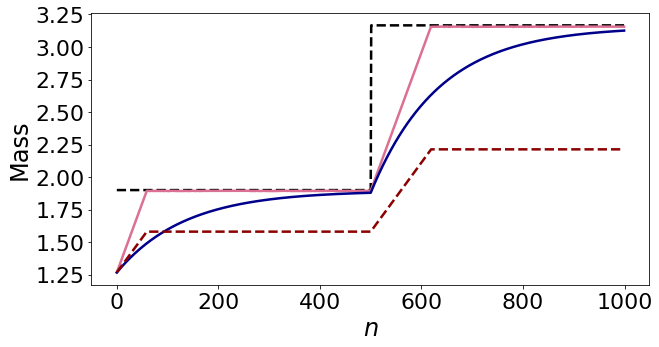

In [13]:


plt.figure(figsize=(10, 5))
plt.plot(mass_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)


plt.plot(
    vanilla_kdv_opt_mass_0,
    label=r"$Vanilla(\lambda = 0)$", 
    color=pk_no_penalty_color, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.plot(
    vanilla_kdv_opt_mass_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)

plt.plot(kdv_opt_mass, label="KdV", linestyle="--", color=exact_color, linewidth=linewidth)

plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Mass", fontsize=label_font)
# plt.yscale('log')
# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

print("---Track Mass Done---")


In [14]:

### Track momentum
vanilla_opt_control_momentum_0, vanilla_kdv_opt_momentum_soln_0, vanilla_results_momentum_0, vanilla_t_list_momentum_0 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0,
)
vanilla_opt_control_momentum_5, vanilla_kdv_opt_momentum_soln_5, vanilla_results_momentum_5, vanilla_t_list_momentum_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)




Processing time steps:   0%|          | 1/989 [01:31<24:59:47, 91.08s/it]

*** current time *** 0
optimize time:  90.7994487285614


Processing time steps:   0%|          | 2/989 [01:32<10:27:29, 38.15s/it]

*** current time *** 1
optimize time:  0.7446684837341309


Processing time steps:   0%|          | 3/989 [01:33<5:48:59, 21.24s/it] 

*** current time *** 2
optimize time:  0.7621796131134033


Processing time steps:   0%|          | 4/989 [01:34<3:38:08, 13.29s/it]

*** current time *** 3
optimize time:  0.7630472183227539


Processing time steps:   1%|          | 5/989 [01:35<2:25:43,  8.89s/it]

*** current time *** 4
optimize time:  0.7430419921875


Processing time steps:   1%|          | 6/989 [01:36<1:41:44,  6.21s/it]

*** current time *** 5
optimize time:  0.726494550704956


Processing time steps:   1%|          | 7/989 [01:37<1:13:58,  4.52s/it]

*** current time *** 6
optimize time:  0.7144360542297363


Processing time steps:   1%|          | 8/989 [01:38<55:54,  3.42s/it]  

*** current time *** 7
optimize time:  0.7220203876495361


Processing time steps:   1%|          | 9/989 [01:39<43:49,  2.68s/it]

*** current time *** 8
optimize time:  0.7214148044586182


Processing time steps:   1%|          | 10/989 [01:40<35:39,  2.19s/it]

*** current time *** 9
optimize time:  0.72926926612854


Processing time steps:   1%|          | 11/989 [01:41<29:56,  1.84s/it]

*** current time *** 10
optimize time:  0.7185211181640625


Processing time steps:   1%|          | 12/989 [01:42<26:17,  1.61s/it]

*** current time *** 11
optimize time:  0.7700610160827637


Processing time steps:   1%|▏         | 13/989 [01:43<23:31,  1.45s/it]

*** current time *** 12
optimize time:  0.7278256416320801


Processing time steps:   1%|▏         | 14/989 [01:45<22:02,  1.36s/it]

*** current time *** 13
optimize time:  0.7928223609924316


Processing time steps:   2%|▏         | 15/989 [01:46<20:39,  1.27s/it]

*** current time *** 14
optimize time:  0.7412536144256592


Processing time steps:   2%|▏         | 16/989 [01:47<19:30,  1.20s/it]

*** current time *** 15
optimize time:  0.7063124179840088


Processing time steps:   2%|▏         | 17/989 [01:48<18:36,  1.15s/it]

*** current time *** 16
optimize time:  0.6916642189025879


Processing time steps:   2%|▏         | 18/989 [01:49<18:11,  1.12s/it]

*** current time *** 17
optimize time:  0.7295444011688232


Processing time steps:   2%|▏         | 19/989 [01:50<18:07,  1.12s/it]

*** current time *** 18
optimize time:  0.7691864967346191


Processing time steps:   2%|▏         | 20/989 [01:51<18:06,  1.12s/it]

*** current time *** 19
optimize time:  0.7728602886199951


Processing time steps:   2%|▏         | 21/989 [01:52<18:05,  1.12s/it]

*** current time *** 20
optimize time:  0.770836353302002


Processing time steps:   2%|▏         | 22/989 [01:53<18:03,  1.12s/it]

*** current time *** 21
optimize time:  0.7665607929229736


Processing time steps:   2%|▏         | 23/989 [01:54<17:47,  1.11s/it]

*** current time *** 22
optimize time:  0.7269432544708252


Processing time steps:   2%|▏         | 24/989 [01:56<18:41,  1.16s/it]

*** current time *** 23
optimize time:  0.8417701721191406


Processing time steps:   3%|▎         | 25/989 [01:57<18:41,  1.16s/it]

*** current time *** 24
optimize time:  0.7798483371734619


Processing time steps:   3%|▎         | 26/989 [01:58<18:25,  1.15s/it]

*** current time *** 25
optimize time:  0.768470048904419


Processing time steps:   3%|▎         | 27/989 [01:59<18:01,  1.12s/it]

*** current time *** 26
optimize time:  0.7197244167327881


Processing time steps:   3%|▎         | 28/989 [02:00<17:55,  1.12s/it]

*** current time *** 27
optimize time:  0.7513327598571777


Processing time steps:   3%|▎         | 29/989 [02:01<17:38,  1.10s/it]

*** current time *** 28
optimize time:  0.7210984230041504


Processing time steps:   3%|▎         | 30/989 [02:02<17:23,  1.09s/it]

*** current time *** 29
optimize time:  0.7100389003753662


Processing time steps:   3%|▎         | 31/989 [02:03<17:14,  1.08s/it]

*** current time *** 30
optimize time:  0.7168993949890137


Processing time steps:   3%|▎         | 32/989 [02:04<17:07,  1.07s/it]

*** current time *** 31
optimize time:  0.7193007469177246


Processing time steps:   3%|▎         | 33/989 [02:05<16:53,  1.06s/it]

*** current time *** 32
optimize time:  0.7216122150421143


Processing time steps:   3%|▎         | 34/989 [02:06<16:37,  1.04s/it]

*** current time *** 33
optimize time:  0.7180533409118652


Processing time steps:   4%|▎         | 35/989 [02:07<16:25,  1.03s/it]

*** current time *** 34
optimize time:  0.7170157432556152


Processing time steps:   4%|▎         | 36/989 [02:08<16:39,  1.05s/it]

*** current time *** 35
optimize time:  0.7175817489624023


Processing time steps:   4%|▎         | 37/989 [02:10<17:53,  1.13s/it]

*** current time *** 36
optimize time:  0.8904030323028564


Processing time steps:   4%|▍         | 38/989 [02:11<17:45,  1.12s/it]

*** current time *** 37
optimize time:  0.7991213798522949


Processing time steps:   4%|▍         | 39/989 [02:12<17:37,  1.11s/it]

*** current time *** 38
optimize time:  0.7155096530914307


Processing time steps:   4%|▍         | 40/989 [02:13<17:45,  1.12s/it]

*** current time *** 39
optimize time:  0.7665200233459473


Processing time steps:   4%|▍         | 41/989 [02:14<17:52,  1.13s/it]

*** current time *** 40
optimize time:  0.7785704135894775


Processing time steps:   4%|▍         | 42/989 [02:15<17:59,  1.14s/it]

*** current time *** 41
optimize time:  0.7747833728790283


Processing time steps:   4%|▍         | 43/989 [02:17<17:56,  1.14s/it]

*** current time *** 42
optimize time:  0.7539267539978027


Processing time steps:   4%|▍         | 44/989 [02:18<18:02,  1.15s/it]

*** current time *** 43
optimize time:  0.7702841758728027


Processing time steps:   5%|▍         | 45/989 [02:19<18:06,  1.15s/it]

*** current time *** 44
optimize time:  0.7739460468292236


Processing time steps:   5%|▍         | 46/989 [02:20<18:06,  1.15s/it]

*** current time *** 45
optimize time:  0.7693729400634766


Processing time steps:   5%|▍         | 47/989 [02:21<18:45,  1.19s/it]

*** current time *** 46
optimize time:  0.8828253746032715


Processing time steps:   5%|▍         | 48/989 [02:23<19:16,  1.23s/it]

*** current time *** 47
optimize time:  0.9129631519317627


Processing time steps:   5%|▍         | 49/989 [02:24<18:20,  1.17s/it]

*** current time *** 48
optimize time:  0.7186770439147949


Processing time steps:   5%|▌         | 50/989 [02:25<17:47,  1.14s/it]

*** current time *** 49
optimize time:  0.7237844467163086


Processing time steps:   5%|▌         | 51/989 [02:26<18:11,  1.16s/it]

*** current time *** 50
optimize time:  0.8757209777832031


Processing time steps:   5%|▌         | 52/989 [02:27<17:41,  1.13s/it]

*** current time *** 51
optimize time:  0.7165255546569824


Processing time steps:   5%|▌         | 53/989 [02:28<17:18,  1.11s/it]

*** current time *** 52
optimize time:  0.7148773670196533


Processing time steps:   5%|▌         | 54/989 [02:29<16:58,  1.09s/it]

*** current time *** 53
optimize time:  0.717355489730835


Processing time steps:   6%|▌         | 55/989 [02:30<16:54,  1.09s/it]

*** current time *** 54
optimize time:  0.7437896728515625


Processing time steps:   6%|▌         | 56/989 [02:31<16:57,  1.09s/it]

*** current time *** 55
optimize time:  0.7509276866912842


Processing time steps:   6%|▌         | 57/989 [02:34<23:28,  1.51s/it]

*** current time *** 56
optimize time:  2.18285870552063


Processing time steps:   6%|▌         | 58/989 [02:37<29:45,  1.92s/it]

*** current time *** 57
optimize time:  2.5408225059509277


Processing time steps:   6%|▌         | 59/989 [02:38<25:49,  1.67s/it]

*** current time *** 58
optimize time:  0.7164163589477539


Processing time steps:   6%|▌         | 60/989 [02:39<23:05,  1.49s/it]

*** current time *** 59
optimize time:  0.736372709274292


Processing time steps:   6%|▌         | 61/989 [02:41<27:29,  1.78s/it]

*** current time *** 60
optimize time:  2.1421916484832764


Processing time steps:   6%|▋         | 62/989 [02:42<24:01,  1.56s/it]

*** current time *** 61
optimize time:  0.7205665111541748


Processing time steps:   6%|▋         | 63/989 [02:45<28:05,  1.82s/it]

*** current time *** 62
optimize time:  2.1373753547668457


Processing time steps:   6%|▋         | 64/989 [02:46<25:13,  1.64s/it]

*** current time *** 63
optimize time:  0.7820727825164795


Processing time steps:   7%|▋         | 65/989 [02:47<22:39,  1.47s/it]

*** current time *** 64
optimize time:  0.747389554977417


Processing time steps:   7%|▋         | 66/989 [02:49<27:07,  1.76s/it]

*** current time *** 65
optimize time:  2.1321563720703125


Processing time steps:   7%|▋         | 67/989 [02:51<23:45,  1.55s/it]

*** current time *** 66
optimize time:  0.7022664546966553


Processing time steps:   7%|▋         | 68/989 [02:53<29:15,  1.91s/it]

*** current time *** 67
optimize time:  2.4251697063446045


Processing time steps:   7%|▋         | 69/989 [02:55<26:28,  1.73s/it]

*** current time *** 68
optimize time:  0.9543230533599854


Processing time steps:   7%|▋         | 70/989 [02:57<30:36,  2.00s/it]

*** current time *** 69
optimize time:  2.2688910961151123


Processing time steps:   7%|▋         | 71/989 [02:58<26:38,  1.74s/it]

*** current time *** 70
optimize time:  0.7590994834899902


Processing time steps:   7%|▋         | 72/989 [02:59<23:51,  1.56s/it]

*** current time *** 71
optimize time:  0.7590467929840088


Processing time steps:   7%|▋         | 73/989 [03:02<28:47,  1.89s/it]

*** current time *** 72
optimize time:  2.2704434394836426


Processing time steps:   7%|▋         | 74/989 [03:03<25:02,  1.64s/it]

*** current time *** 73
optimize time:  0.7412388324737549


Processing time steps:   8%|▊         | 75/989 [03:06<29:36,  1.94s/it]

*** current time *** 74
optimize time:  2.3347651958465576


Processing time steps:   8%|▊         | 76/989 [03:07<26:26,  1.74s/it]

*** current time *** 75
optimize time:  0.8413469791412354


Processing time steps:   8%|▊         | 77/989 [03:08<23:50,  1.57s/it]

*** current time *** 76
optimize time:  0.7801511287689209


Processing time steps:   8%|▊         | 78/989 [03:09<21:56,  1.44s/it]

*** current time *** 77
optimize time:  0.7887246608734131


Processing time steps:   8%|▊         | 79/989 [03:11<20:16,  1.34s/it]

*** current time *** 78
optimize time:  0.7462005615234375


Processing time steps:   8%|▊         | 80/989 [03:12<18:59,  1.25s/it]

*** current time *** 79
optimize time:  0.7297089099884033


Processing time steps:   8%|▊         | 81/989 [03:14<24:50,  1.64s/it]

*** current time *** 80
optimize time:  2.1606485843658447


Processing time steps:   8%|▊         | 82/989 [03:15<22:38,  1.50s/it]

*** current time *** 81
optimize time:  0.7835812568664551


Processing time steps:   8%|▊         | 83/989 [03:18<27:49,  1.84s/it]

*** current time *** 82
optimize time:  2.2788033485412598


Processing time steps:   8%|▊         | 84/989 [03:20<28:01,  1.86s/it]

*** current time *** 83
optimize time:  1.5190613269805908


Processing time steps:   9%|▊         | 85/989 [03:22<31:30,  2.09s/it]

*** current time *** 84
optimize time:  2.2500381469726562


Processing time steps:   9%|▊         | 86/989 [03:25<34:25,  2.29s/it]

*** current time *** 85
optimize time:  2.3681018352508545


Processing time steps:   9%|▉         | 87/989 [03:26<29:07,  1.94s/it]

*** current time *** 86
optimize time:  0.7573935985565186


Processing time steps:   9%|▉         | 88/989 [03:29<32:22,  2.16s/it]

*** current time *** 87
optimize time:  2.3373851776123047


Processing time steps:   9%|▉         | 89/989 [03:30<27:19,  1.82s/it]

*** current time *** 88
optimize time:  0.7248141765594482


Processing time steps:   9%|▉         | 90/989 [03:33<30:16,  2.02s/it]

*** current time *** 89
optimize time:  2.179300308227539


Processing time steps:   9%|▉         | 91/989 [03:34<29:31,  1.97s/it]

*** current time *** 90
optimize time:  1.5145606994628906


Processing time steps:   9%|▉         | 92/989 [03:37<31:53,  2.13s/it]

*** current time *** 91
optimize time:  2.218698024749756


Processing time steps:   9%|▉         | 93/989 [03:39<33:25,  2.24s/it]

*** current time *** 92
optimize time:  2.1766560077667236


Processing time steps:  10%|▉         | 94/989 [03:40<28:11,  1.89s/it]

*** current time *** 93
optimize time:  0.7277674674987793


Processing time steps:  10%|▉         | 95/989 [03:42<24:58,  1.68s/it]

*** current time *** 94
optimize time:  0.8319542407989502


Processing time steps:  10%|▉         | 96/989 [03:44<28:31,  1.92s/it]

*** current time *** 95
optimize time:  2.1576836109161377


Processing time steps:  10%|▉         | 97/989 [03:45<24:37,  1.66s/it]

*** current time *** 96
optimize time:  0.7116851806640625


Processing time steps:  10%|▉         | 98/989 [03:48<28:14,  1.90s/it]

*** current time *** 97
optimize time:  2.157395362854004


Processing time steps:  10%|█         | 99/989 [03:49<24:47,  1.67s/it]

*** current time *** 98
optimize time:  0.8059539794921875


Processing time steps:  10%|█         | 100/989 [03:50<22:02,  1.49s/it]

*** current time *** 99
optimize time:  0.7263312339782715


Processing time steps:  10%|█         | 101/989 [03:51<20:13,  1.37s/it]

*** current time *** 100
optimize time:  0.7191853523254395


Processing time steps:  10%|█         | 102/989 [03:53<22:01,  1.49s/it]

*** current time *** 101
optimize time:  1.4574224948883057


Processing time steps:  10%|█         | 103/989 [03:55<26:23,  1.79s/it]

*** current time *** 102
optimize time:  2.168639898300171


Processing time steps:  11%|█         | 104/989 [03:56<23:00,  1.56s/it]

*** current time *** 103
optimize time:  0.7300670146942139


Processing time steps:  11%|█         | 105/989 [03:59<26:51,  1.82s/it]

*** current time *** 104
optimize time:  2.14455246925354


Processing time steps:  11%|█         | 106/989 [04:00<23:41,  1.61s/it]

*** current time *** 105
optimize time:  0.7340908050537109


Processing time steps:  11%|█         | 107/989 [04:02<27:33,  1.87s/it]

*** current time *** 106
optimize time:  2.1736936569213867


Processing time steps:  11%|█         | 108/989 [04:04<26:59,  1.84s/it]

*** current time *** 107
optimize time:  1.4136238098144531


Processing time steps:  11%|█         | 109/989 [04:06<29:49,  2.03s/it]

*** current time *** 108
optimize time:  2.162750244140625


Processing time steps:  11%|█         | 110/989 [04:09<32:54,  2.25s/it]

*** current time *** 109
optimize time:  2.418841600418091


Processing time steps:  11%|█         | 111/989 [04:10<27:37,  1.89s/it]

*** current time *** 110
optimize time:  0.7145833969116211


Processing time steps:  11%|█▏        | 112/989 [04:11<23:57,  1.64s/it]

*** current time *** 111
optimize time:  0.7178676128387451


Processing time steps:  11%|█▏        | 113/989 [04:12<21:24,  1.47s/it]

*** current time *** 112
optimize time:  0.719151496887207


Processing time steps:  12%|█▏        | 114/989 [04:13<19:46,  1.36s/it]

*** current time *** 113
optimize time:  0.7209019660949707


Processing time steps:  12%|█▏        | 115/989 [04:16<25:11,  1.73s/it]

*** current time *** 114
optimize time:  2.1596426963806152


Processing time steps:  12%|█▏        | 116/989 [04:17<22:34,  1.55s/it]

*** current time *** 115
optimize time:  0.7907984256744385


Processing time steps:  12%|█▏        | 117/989 [04:20<26:23,  1.82s/it]

*** current time *** 116
optimize time:  2.130235195159912


Processing time steps:  12%|█▏        | 118/989 [04:22<29:05,  2.00s/it]

*** current time *** 117
optimize time:  2.10672664642334


Processing time steps:  12%|█▏        | 119/989 [04:23<24:46,  1.71s/it]

*** current time *** 118
optimize time:  0.7095582485198975


Processing time steps:  12%|█▏        | 120/989 [04:26<28:22,  1.96s/it]

*** current time *** 119
optimize time:  2.2115535736083984


Processing time steps:  12%|█▏        | 121/989 [04:28<30:34,  2.11s/it]

*** current time *** 120
optimize time:  2.141326427459717


Processing time steps:  12%|█▏        | 122/989 [04:29<25:58,  1.80s/it]

*** current time *** 121
optimize time:  0.7149629592895508


Processing time steps:  12%|█▏        | 123/989 [04:30<22:44,  1.58s/it]

*** current time *** 122
optimize time:  0.7153158187866211


Processing time steps:  13%|█▎        | 124/989 [04:31<20:33,  1.43s/it]

*** current time *** 123
optimize time:  0.7301485538482666


Processing time steps:  13%|█▎        | 125/989 [04:32<18:53,  1.31s/it]

*** current time *** 124
optimize time:  0.7111184597015381


Processing time steps:  13%|█▎        | 126/989 [04:33<17:44,  1.23s/it]

*** current time *** 125
optimize time:  0.7135846614837646


Processing time steps:  13%|█▎        | 127/989 [04:34<16:54,  1.18s/it]

*** current time *** 126
optimize time:  0.7143478393554688


Processing time steps:  13%|█▎        | 128/989 [04:36<16:21,  1.14s/it]

*** current time *** 127
optimize time:  0.7150497436523438


Processing time steps:  13%|█▎        | 129/989 [04:37<15:57,  1.11s/it]

*** current time *** 128
optimize time:  0.7154133319854736


Processing time steps:  13%|█▎        | 130/989 [04:38<15:41,  1.10s/it]

*** current time *** 129
optimize time:  0.7141926288604736


Processing time steps:  13%|█▎        | 131/989 [04:40<19:38,  1.37s/it]

*** current time *** 130
optimize time:  1.7306995391845703


Processing time steps:  13%|█▎        | 132/989 [04:42<24:09,  1.69s/it]

*** current time *** 131
optimize time:  2.132488250732422


Processing time steps:  13%|█▎        | 133/989 [04:43<21:25,  1.50s/it]

*** current time *** 132
optimize time:  0.7195742130279541


Processing time steps:  14%|█▎        | 134/989 [04:45<22:30,  1.58s/it]

*** current time *** 133
optimize time:  1.4302396774291992


Processing time steps:  14%|█▎        | 135/989 [04:48<27:01,  1.90s/it]

*** current time *** 134
optimize time:  2.2952322959899902


Processing time steps:  14%|█▍        | 136/989 [04:49<24:37,  1.73s/it]

*** current time *** 135
optimize time:  0.8895184993743896


Processing time steps:  14%|█▍        | 137/989 [04:52<28:35,  2.01s/it]

*** current time *** 136
optimize time:  2.3381950855255127


Processing time steps:  14%|█▍        | 138/989 [04:54<30:29,  2.15s/it]

*** current time *** 137
optimize time:  2.135133981704712


Processing time steps:  14%|█▍        | 139/989 [04:55<25:49,  1.82s/it]

*** current time *** 138
optimize time:  0.7154707908630371


Processing time steps:  14%|█▍        | 140/989 [04:56<22:31,  1.59s/it]

*** current time *** 139
optimize time:  0.7103440761566162


Processing time steps:  14%|█▍        | 141/989 [05:00<30:08,  2.13s/it]

*** current time *** 140
optimize time:  3.0086066722869873


Processing time steps:  14%|█▍        | 142/989 [05:01<28:50,  2.04s/it]

*** current time *** 141
optimize time:  1.4849333763122559


Processing time steps:  14%|█▍        | 143/989 [05:04<30:44,  2.18s/it]

*** current time *** 142
optimize time:  2.168971300125122


Processing time steps:  15%|█▍        | 144/989 [05:05<25:59,  1.85s/it]

*** current time *** 143
optimize time:  0.7229387760162354


Processing time steps:  15%|█▍        | 145/989 [05:07<28:38,  2.04s/it]

*** current time *** 144
optimize time:  2.1710476875305176


Processing time steps:  15%|█▍        | 146/989 [05:08<24:17,  1.73s/it]

*** current time *** 145
optimize time:  0.7145187854766846


Processing time steps:  15%|█▍        | 147/989 [05:10<24:19,  1.73s/it]

*** current time *** 146
optimize time:  1.4306211471557617


Processing time steps:  15%|█▍        | 148/989 [05:13<27:20,  1.95s/it]

*** current time *** 147
optimize time:  2.1624927520751953


Processing time steps:  15%|█▌        | 149/989 [05:14<23:23,  1.67s/it]

*** current time *** 148
optimize time:  0.7182304859161377


Processing time steps:  15%|█▌        | 150/989 [05:15<23:47,  1.70s/it]

*** current time *** 149
optimize time:  1.4388206005096436


Processing time steps:  15%|█▌        | 151/989 [05:18<27:04,  1.94s/it]

*** current time *** 150
optimize time:  2.1647157669067383


Processing time steps:  15%|█▌        | 152/989 [05:19<23:39,  1.70s/it]

*** current time *** 151
optimize time:  0.7437093257904053


Processing time steps:  15%|█▌        | 153/989 [05:22<27:49,  2.00s/it]

*** current time *** 152
optimize time:  2.3194820880889893


Processing time steps:  16%|█▌        | 154/989 [05:23<24:18,  1.75s/it]

*** current time *** 153
optimize time:  0.7748878002166748


Processing time steps:  16%|█▌        | 155/989 [05:24<21:21,  1.54s/it]

*** current time *** 154
optimize time:  0.7277309894561768


Processing time steps:  16%|█▌        | 156/989 [05:26<25:27,  1.83s/it]

*** current time *** 155
optimize time:  2.2032735347747803


Processing time steps:  16%|█▌        | 157/989 [05:28<22:09,  1.60s/it]

*** current time *** 156
optimize time:  0.71537184715271


Processing time steps:  16%|█▌        | 158/989 [05:30<25:49,  1.86s/it]

*** current time *** 157
optimize time:  2.163505792617798


Processing time steps:  16%|█▌        | 159/989 [05:32<28:14,  2.04s/it]

*** current time *** 158
optimize time:  2.1615352630615234


Processing time steps:  16%|█▌        | 160/989 [05:34<24:00,  1.74s/it]

*** current time *** 159
optimize time:  0.7232308387756348


Processing time steps:  16%|█▋        | 161/989 [05:35<21:06,  1.53s/it]

*** current time *** 160
optimize time:  0.7255160808563232


Processing time steps:  16%|█▋        | 162/989 [05:36<19:09,  1.39s/it]

*** current time *** 161
optimize time:  0.7232856750488281


Processing time steps:  16%|█▋        | 163/989 [05:37<17:45,  1.29s/it]

*** current time *** 162
optimize time:  0.7170505523681641


Processing time steps:  17%|█▋        | 164/989 [05:38<16:48,  1.22s/it]

*** current time *** 163
optimize time:  0.7286343574523926


Processing time steps:  17%|█▋        | 165/989 [05:39<16:07,  1.17s/it]

*** current time *** 164
optimize time:  0.7276179790496826


Processing time steps:  17%|█▋        | 166/989 [05:40<15:37,  1.14s/it]

*** current time *** 165
optimize time:  0.724435567855835


Processing time steps:  17%|█▋        | 167/989 [05:41<15:42,  1.15s/it]

*** current time *** 166
optimize time:  0.7792396545410156


Processing time steps:  17%|█▋        | 168/989 [05:42<15:45,  1.15s/it]

*** current time *** 167
optimize time:  0.7755181789398193


Processing time steps:  17%|█▋        | 169/989 [05:43<15:35,  1.14s/it]

*** current time *** 168
optimize time:  0.773510217666626


Processing time steps:  17%|█▋        | 170/989 [05:45<16:01,  1.17s/it]

*** current time *** 169
optimize time:  0.7956554889678955


Processing time steps:  17%|█▋        | 171/989 [05:46<16:06,  1.18s/it]

*** current time *** 170
optimize time:  0.8409483432769775


Processing time steps:  17%|█▋        | 172/989 [05:47<16:54,  1.24s/it]

*** current time *** 171
optimize time:  0.9042873382568359


Processing time steps:  17%|█▋        | 173/989 [05:48<16:57,  1.25s/it]

*** current time *** 172
optimize time:  0.9523634910583496


Processing time steps:  18%|█▊        | 174/989 [05:50<16:35,  1.22s/it]

*** current time *** 173
optimize time:  0.7472071647644043


Processing time steps:  18%|█▊        | 175/989 [05:51<16:09,  1.19s/it]

*** current time *** 174
optimize time:  0.7925934791564941


Processing time steps:  18%|█▊        | 176/989 [05:52<16:04,  1.19s/it]

*** current time *** 175
optimize time:  0.7663900852203369


Processing time steps:  18%|█▊        | 177/989 [05:53<16:19,  1.21s/it]

*** current time *** 176
optimize time:  0.8664498329162598


Processing time steps:  18%|█▊        | 178/989 [05:54<16:03,  1.19s/it]

*** current time *** 177
optimize time:  0.8140721321105957


Processing time steps:  18%|█▊        | 179/989 [05:55<15:53,  1.18s/it]

*** current time *** 178
optimize time:  0.7632932662963867


Processing time steps:  18%|█▊        | 180/989 [05:57<15:34,  1.16s/it]

*** current time *** 179
optimize time:  0.7606041431427002


Processing time steps:  18%|█▊        | 181/989 [05:58<15:05,  1.12s/it]

*** current time *** 180
optimize time:  0.7104442119598389


Processing time steps:  18%|█▊        | 182/989 [05:59<14:42,  1.09s/it]

*** current time *** 181
optimize time:  0.7121434211730957


Processing time steps:  19%|█▊        | 183/989 [06:00<14:48,  1.10s/it]

*** current time *** 182
optimize time:  0.7839784622192383


Processing time steps:  19%|█▊        | 184/989 [06:01<14:36,  1.09s/it]

*** current time *** 183
optimize time:  0.7231936454772949


Processing time steps:  19%|█▊        | 185/989 [06:02<14:22,  1.07s/it]

*** current time *** 184
optimize time:  0.7105824947357178


Processing time steps:  19%|█▉        | 186/989 [06:03<14:22,  1.07s/it]

*** current time *** 185
optimize time:  0.752192497253418


Processing time steps:  19%|█▉        | 187/989 [06:04<14:04,  1.05s/it]

*** current time *** 186
optimize time:  0.698932409286499


Processing time steps:  19%|█▉        | 188/989 [06:05<13:54,  1.04s/it]

*** current time *** 187
optimize time:  0.7111291885375977


Processing time steps:  19%|█▉        | 189/989 [06:06<13:46,  1.03s/it]

*** current time *** 188
optimize time:  0.7145781517028809


Processing time steps:  19%|█▉        | 190/989 [06:07<13:46,  1.03s/it]

*** current time *** 189
optimize time:  0.6956679821014404


Processing time steps:  19%|█▉        | 191/989 [06:08<13:48,  1.04s/it]

*** current time *** 190
optimize time:  0.7053263187408447


Processing time steps:  19%|█▉        | 192/989 [06:09<13:50,  1.04s/it]

*** current time *** 191
optimize time:  0.7082793712615967


Processing time steps:  20%|█▉        | 193/989 [06:10<13:51,  1.04s/it]

*** current time *** 192
optimize time:  0.7093007564544678


Processing time steps:  20%|█▉        | 194/989 [06:11<14:21,  1.08s/it]

*** current time *** 193
optimize time:  0.8338584899902344


Processing time steps:  20%|█▉        | 195/989 [06:12<14:12,  1.07s/it]

*** current time *** 194
optimize time:  0.7120838165283203


Processing time steps:  20%|█▉        | 196/989 [06:13<14:06,  1.07s/it]

*** current time *** 195
optimize time:  0.7095038890838623


Processing time steps:  20%|█▉        | 197/989 [06:14<14:08,  1.07s/it]

*** current time *** 196
optimize time:  0.7383182048797607


Processing time steps:  20%|██        | 198/989 [06:15<14:03,  1.07s/it]

*** current time *** 197
optimize time:  0.7128777503967285


Processing time steps:  20%|██        | 199/989 [06:17<13:57,  1.06s/it]

*** current time *** 198
optimize time:  0.7069964408874512


Processing time steps:  20%|██        | 200/989 [06:18<13:52,  1.06s/it]

*** current time *** 199
optimize time:  0.7037849426269531


Processing time steps:  20%|██        | 201/989 [06:19<13:43,  1.04s/it]

*** current time *** 200
optimize time:  0.7113649845123291


Processing time steps:  20%|██        | 202/989 [06:20<13:48,  1.05s/it]

*** current time *** 201
optimize time:  0.7815234661102295


Processing time steps:  21%|██        | 203/989 [06:21<13:46,  1.05s/it]

*** current time *** 202
optimize time:  0.7191112041473389


Processing time steps:  21%|██        | 204/989 [06:22<13:53,  1.06s/it]

*** current time *** 203
optimize time:  0.7505691051483154


Processing time steps:  21%|██        | 205/989 [06:23<14:09,  1.08s/it]

*** current time *** 204
optimize time:  0.765286922454834


Processing time steps:  21%|██        | 206/989 [06:24<14:23,  1.10s/it]

*** current time *** 205
optimize time:  0.7641382217407227


Processing time steps:  21%|██        | 207/989 [06:27<20:08,  1.55s/it]

*** current time *** 206
optimize time:  2.279968500137329


Processing time steps:  21%|██        | 208/989 [06:29<24:27,  1.88s/it]

*** current time *** 207
optimize time:  2.3116228580474854


Processing time steps:  21%|██        | 209/989 [06:31<21:51,  1.68s/it]

*** current time *** 208
optimize time:  0.7785649299621582


Processing time steps:  21%|██        | 210/989 [06:32<19:51,  1.53s/it]

*** current time *** 209
optimize time:  0.8393452167510986


Processing time steps:  21%|██▏       | 211/989 [06:33<18:20,  1.41s/it]

*** current time *** 210
optimize time:  0.7725954055786133


Processing time steps:  21%|██▏       | 212/989 [06:34<17:16,  1.33s/it]

*** current time *** 211
optimize time:  0.7627301216125488


Processing time steps:  22%|██▏       | 213/989 [06:35<16:40,  1.29s/it]

*** current time *** 212
optimize time:  0.7608990669250488


Processing time steps:  22%|██▏       | 214/989 [06:36<15:50,  1.23s/it]

*** current time *** 213
optimize time:  0.7397651672363281


Processing time steps:  22%|██▏       | 215/989 [06:37<15:03,  1.17s/it]

*** current time *** 214
optimize time:  0.728661060333252


Processing time steps:  22%|██▏       | 216/989 [06:40<21:00,  1.63s/it]

*** current time *** 215
optimize time:  2.2858221530914307


Processing time steps:  22%|██▏       | 217/989 [06:41<18:56,  1.47s/it]

*** current time *** 216
optimize time:  0.7519385814666748


Processing time steps:  22%|██▏       | 218/989 [06:44<23:16,  1.81s/it]

*** current time *** 217
optimize time:  2.2309727668762207


Processing time steps:  22%|██▏       | 219/989 [06:47<27:50,  2.17s/it]

*** current time *** 218
optimize time:  2.567046880722046


Processing time steps:  22%|██▏       | 220/989 [06:48<23:38,  1.84s/it]

*** current time *** 219
optimize time:  0.7472939491271973


Processing time steps:  22%|██▏       | 221/989 [06:49<20:36,  1.61s/it]

*** current time *** 220
optimize time:  0.7171318531036377


Processing time steps:  22%|██▏       | 222/989 [06:50<18:28,  1.44s/it]

*** current time *** 221
optimize time:  0.7235763072967529


Processing time steps:  23%|██▎       | 223/989 [06:51<16:58,  1.33s/it]

*** current time *** 222
optimize time:  0.7272372245788574


Processing time steps:  23%|██▎       | 224/989 [06:52<15:55,  1.25s/it]

*** current time *** 223
optimize time:  0.7216038703918457


Processing time steps:  23%|██▎       | 225/989 [06:54<17:52,  1.40s/it]

*** current time *** 224
optimize time:  1.4380383491516113


Processing time steps:  23%|██▎       | 226/989 [06:56<21:59,  1.73s/it]

*** current time *** 225
optimize time:  2.153160572052002


Processing time steps:  23%|██▎       | 227/989 [06:57<19:31,  1.54s/it]

*** current time *** 226
optimize time:  0.7105381488800049


Processing time steps:  23%|██▎       | 228/989 [07:00<23:02,  1.82s/it]

*** current time *** 227
optimize time:  2.1299540996551514


Processing time steps:  23%|██▎       | 229/989 [07:01<20:07,  1.59s/it]

*** current time *** 228
optimize time:  0.7255415916442871


Processing time steps:  23%|██▎       | 230/989 [07:03<23:47,  1.88s/it]

*** current time *** 229
optimize time:  2.2382707595825195


Processing time steps:  23%|██▎       | 231/989 [07:05<20:34,  1.63s/it]

*** current time *** 230
optimize time:  0.7098445892333984


Processing time steps:  23%|██▎       | 232/989 [07:07<24:41,  1.96s/it]

*** current time *** 231
optimize time:  2.346867322921753


Processing time steps:  24%|██▎       | 233/989 [07:08<21:39,  1.72s/it]

*** current time *** 232
optimize time:  0.7747917175292969


Processing time steps:  24%|██▎       | 234/989 [07:11<25:14,  2.01s/it]

*** current time *** 233
optimize time:  2.306873083114624


Processing time steps:  24%|██▍       | 235/989 [07:14<28:28,  2.27s/it]

*** current time *** 234
optimize time:  2.42671799659729


Processing time steps:  24%|██▍       | 236/989 [07:15<25:06,  2.00s/it]

*** current time *** 235
optimize time:  0.911970853805542


Processing time steps:  24%|██▍       | 237/989 [07:18<27:51,  2.22s/it]

*** current time *** 236
optimize time:  2.363210439682007


Processing time steps:  24%|██▍       | 238/989 [07:19<24:17,  1.94s/it]

*** current time *** 237
optimize time:  0.8474764823913574


Processing time steps:  24%|██▍       | 239/989 [07:23<29:25,  2.35s/it]

*** current time *** 238
optimize time:  2.976576328277588


Processing time steps:  24%|██▍       | 240/989 [07:24<25:01,  2.00s/it]

*** current time *** 239
optimize time:  0.7602882385253906


Processing time steps:  24%|██▍       | 241/989 [07:26<27:13,  2.18s/it]

*** current time *** 240
optimize time:  2.2648487091064453


Processing time steps:  24%|██▍       | 242/989 [07:28<22:59,  1.85s/it]

*** current time *** 241
optimize time:  0.7161517143249512


Processing time steps:  25%|██▍       | 243/989 [07:31<27:17,  2.20s/it]

*** current time *** 242
optimize time:  2.603795051574707


Processing time steps:  25%|██▍       | 244/989 [07:32<23:20,  1.88s/it]

*** current time *** 243
optimize time:  0.7795395851135254


Processing time steps:  25%|██▍       | 245/989 [07:34<26:07,  2.11s/it]

*** current time *** 244
optimize time:  2.3035356998443604


Processing time steps:  25%|██▍       | 246/989 [07:35<22:11,  1.79s/it]

*** current time *** 245
optimize time:  0.7151646614074707


Processing time steps:  25%|██▍       | 247/989 [07:37<19:43,  1.60s/it]

*** current time *** 246
optimize time:  0.749835729598999


Processing time steps:  25%|██▌       | 248/989 [07:39<23:47,  1.93s/it]

*** current time *** 247
optimize time:  2.3044443130493164


Processing time steps:  25%|██▌       | 249/989 [07:42<26:22,  2.14s/it]

*** current time *** 248
optimize time:  2.27120304107666


Processing time steps:  25%|██▌       | 250/989 [07:43<23:11,  1.88s/it]

*** current time *** 249
optimize time:  0.84368896484375


Processing time steps:  25%|██▌       | 251/989 [07:44<20:40,  1.68s/it]

*** current time *** 250
optimize time:  0.7936444282531738


Processing time steps:  25%|██▌       | 252/989 [07:46<18:54,  1.54s/it]

*** current time *** 251
optimize time:  0.8840878009796143


Processing time steps:  26%|██▌       | 253/989 [07:47<17:19,  1.41s/it]

*** current time *** 252
optimize time:  0.7375369071960449


Processing time steps:  26%|██▌       | 254/989 [07:48<16:24,  1.34s/it]

*** current time *** 253
optimize time:  0.7361645698547363


Processing time steps:  26%|██▌       | 255/989 [07:49<16:21,  1.34s/it]

*** current time *** 254
optimize time:  0.8869357109069824


Processing time steps:  26%|██▌       | 256/989 [07:52<21:12,  1.74s/it]

*** current time *** 255
optimize time:  2.337015390396118


Processing time steps:  26%|██▌       | 257/989 [07:53<18:40,  1.53s/it]

*** current time *** 256
optimize time:  0.7447614669799805


Processing time steps:  26%|██▌       | 258/989 [07:55<22:03,  1.81s/it]

*** current time *** 257
optimize time:  2.1211585998535156


Processing time steps:  26%|██▌       | 259/989 [07:57<21:56,  1.80s/it]

*** current time *** 258
optimize time:  1.4470188617706299


Processing time steps:  26%|██▋       | 260/989 [08:00<25:34,  2.11s/it]

*** current time *** 259
optimize time:  2.480847120285034


Processing time steps:  26%|██▋       | 261/989 [08:01<21:42,  1.79s/it]

*** current time *** 260
optimize time:  0.7142150402069092


Processing time steps:  26%|██▋       | 262/989 [08:04<24:18,  2.01s/it]

*** current time *** 261
optimize time:  2.1702067852020264


Processing time steps:  27%|██▋       | 263/989 [08:06<26:02,  2.15s/it]

*** current time *** 262
optimize time:  2.1457862854003906


Processing time steps:  27%|██▋       | 264/989 [08:07<22:19,  1.85s/it]

*** current time *** 263
optimize time:  0.7386364936828613


Processing time steps:  27%|██▋       | 265/989 [08:08<19:46,  1.64s/it]

*** current time *** 264
optimize time:  0.7653532028198242


Processing time steps:  27%|██▋       | 266/989 [08:09<17:54,  1.49s/it]

*** current time *** 265
optimize time:  0.7648990154266357


Processing time steps:  27%|██▋       | 267/989 [08:12<22:08,  1.84s/it]

*** current time *** 266
optimize time:  2.287402868270874


Processing time steps:  27%|██▋       | 268/989 [08:13<19:37,  1.63s/it]

*** current time *** 267
optimize time:  0.7704238891601562


Processing time steps:  27%|██▋       | 269/989 [08:16<23:15,  1.94s/it]

*** current time *** 268
optimize time:  2.280465602874756


Processing time steps:  27%|██▋       | 270/989 [08:18<25:09,  2.10s/it]

*** current time *** 269
optimize time:  2.1565141677856445


Processing time steps:  27%|██▋       | 271/989 [08:21<26:17,  2.20s/it]

*** current time *** 270
optimize time:  2.119638681411743


Processing time steps:  28%|██▊       | 272/989 [08:22<22:07,  1.85s/it]

*** current time *** 271
optimize time:  0.7065727710723877


Processing time steps:  28%|██▊       | 273/989 [08:24<24:19,  2.04s/it]

*** current time *** 272
optimize time:  2.142411947250366


Processing time steps:  28%|██▊       | 274/989 [08:25<20:46,  1.74s/it]

*** current time *** 273
optimize time:  0.7105488777160645


Processing time steps:  28%|██▊       | 275/989 [08:28<24:31,  2.06s/it]

*** current time *** 274
optimize time:  2.4158318042755127


Processing time steps:  28%|██▊       | 276/989 [08:29<21:17,  1.79s/it]

*** current time *** 275
optimize time:  0.7692396640777588


Processing time steps:  28%|██▊       | 277/989 [08:32<24:11,  2.04s/it]

*** current time *** 276
optimize time:  2.280953884124756


Processing time steps:  28%|██▊       | 278/989 [08:33<20:39,  1.74s/it]

*** current time *** 277
optimize time:  0.7197368144989014


Processing time steps:  28%|██▊       | 279/989 [08:34<18:15,  1.54s/it]

*** current time *** 278
optimize time:  0.7309050559997559


Processing time steps:  28%|██▊       | 280/989 [08:35<16:48,  1.42s/it]

*** current time *** 279
optimize time:  0.7573657035827637


Processing time steps:  28%|██▊       | 281/989 [08:38<21:10,  1.79s/it]

*** current time *** 280
optimize time:  2.28934645652771


Processing time steps:  29%|██▊       | 282/989 [08:41<26:01,  2.21s/it]

*** current time *** 281
optimize time:  2.7169506549835205


Processing time steps:  29%|██▊       | 283/989 [08:42<21:59,  1.87s/it]

*** current time *** 282
optimize time:  0.743992805480957


Processing time steps:  29%|██▊       | 284/989 [08:43<20:05,  1.71s/it]

*** current time *** 283
optimize time:  0.8845484256744385


Processing time steps:  29%|██▉       | 285/989 [08:45<18:17,  1.56s/it]

*** current time *** 284
optimize time:  0.8337752819061279


Processing time steps:  29%|██▉       | 286/989 [08:46<17:08,  1.46s/it]

*** current time *** 285
optimize time:  0.8452718257904053


Processing time steps:  29%|██▉       | 287/989 [08:47<16:01,  1.37s/it]

*** current time *** 286
optimize time:  0.7617504596710205


Processing time steps:  29%|██▉       | 288/989 [08:48<15:18,  1.31s/it]

*** current time *** 287
optimize time:  0.7664096355438232


Processing time steps:  29%|██▉       | 289/989 [08:49<14:45,  1.26s/it]

*** current time *** 288
optimize time:  0.7661683559417725


Processing time steps:  29%|██▉       | 290/989 [08:50<14:01,  1.20s/it]

*** current time *** 289
optimize time:  0.7138137817382812


Processing time steps:  29%|██▉       | 291/989 [08:52<13:28,  1.16s/it]

*** current time *** 290
optimize time:  0.711388349533081


Processing time steps:  30%|██▉       | 292/989 [08:53<13:05,  1.13s/it]

*** current time *** 291
optimize time:  0.7120029926300049


Processing time steps:  30%|██▉       | 293/989 [08:54<12:47,  1.10s/it]

*** current time *** 292
optimize time:  0.7069149017333984


Processing time steps:  30%|██▉       | 294/989 [08:55<12:59,  1.12s/it]

*** current time *** 293
optimize time:  0.7863225936889648


Processing time steps:  30%|██▉       | 295/989 [08:56<12:52,  1.11s/it]

*** current time *** 294
optimize time:  0.742234468460083


Processing time steps:  30%|██▉       | 296/989 [08:57<13:33,  1.17s/it]

*** current time *** 295
optimize time:  0.8607027530670166


Processing time steps:  30%|███       | 297/989 [08:58<13:49,  1.20s/it]

*** current time *** 296
optimize time:  0.810429573059082


Processing time steps:  30%|███       | 298/989 [09:00<13:35,  1.18s/it]

*** current time *** 297
optimize time:  0.7650055885314941


Processing time steps:  30%|███       | 299/989 [09:01<13:11,  1.15s/it]

*** current time *** 298
optimize time:  0.7601630687713623


Processing time steps:  30%|███       | 300/989 [09:02<12:52,  1.12s/it]

*** current time *** 299
optimize time:  0.7175288200378418


Processing time steps:  30%|███       | 301/989 [09:03<12:40,  1.11s/it]

*** current time *** 300
optimize time:  0.7250394821166992


Processing time steps:  31%|███       | 302/989 [09:04<12:33,  1.10s/it]

*** current time *** 301
optimize time:  0.7253360748291016


Processing time steps:  31%|███       | 303/989 [09:05<12:23,  1.08s/it]

*** current time *** 302
optimize time:  0.7186038494110107


Processing time steps:  31%|███       | 304/989 [09:06<12:19,  1.08s/it]

*** current time *** 303
optimize time:  0.7369351387023926


Processing time steps:  31%|███       | 305/989 [09:07<12:14,  1.07s/it]

*** current time *** 304
optimize time:  0.717247486114502


Processing time steps:  31%|███       | 306/989 [09:08<12:26,  1.09s/it]

*** current time *** 305
optimize time:  0.8008058071136475


Processing time steps:  31%|███       | 307/989 [09:09<12:24,  1.09s/it]

*** current time *** 306
optimize time:  0.7507965564727783


Processing time steps:  31%|███       | 308/989 [09:10<12:21,  1.09s/it]

*** current time *** 307
optimize time:  0.7514529228210449


Processing time steps:  31%|███       | 309/989 [09:11<12:09,  1.07s/it]

*** current time *** 308
optimize time:  0.7051680088043213


Processing time steps:  31%|███▏      | 310/989 [09:12<12:06,  1.07s/it]

*** current time *** 309
optimize time:  0.7121562957763672


Processing time steps:  31%|███▏      | 311/989 [09:14<12:19,  1.09s/it]

*** current time *** 310
optimize time:  0.7921063899993896


Processing time steps:  32%|███▏      | 312/989 [09:15<12:10,  1.08s/it]

*** current time *** 311
optimize time:  0.7140190601348877


Processing time steps:  32%|███▏      | 313/989 [09:16<12:01,  1.07s/it]

*** current time *** 312
optimize time:  0.7261583805084229


Processing time steps:  32%|███▏      | 314/989 [09:17<11:48,  1.05s/it]

*** current time *** 313
optimize time:  0.7134904861450195


Processing time steps:  32%|███▏      | 315/989 [09:19<16:36,  1.48s/it]

*** current time *** 314
optimize time:  2.167391538619995


Processing time steps:  32%|███▏      | 316/989 [09:22<19:54,  1.78s/it]

*** current time *** 315
optimize time:  2.1327431201934814


Processing time steps:  32%|███▏      | 317/989 [09:23<17:26,  1.56s/it]

*** current time *** 316
optimize time:  0.7119381427764893


Processing time steps:  32%|███▏      | 318/989 [09:25<20:40,  1.85s/it]

*** current time *** 317
optimize time:  2.1962804794311523


Processing time steps:  32%|███▏      | 319/989 [09:28<23:24,  2.10s/it]

*** current time *** 318
optimize time:  2.3053712844848633


Processing time steps:  32%|███▏      | 320/989 [09:29<20:12,  1.81s/it]

*** current time *** 319
optimize time:  0.7670586109161377


Processing time steps:  32%|███▏      | 321/989 [09:30<18:31,  1.66s/it]

*** current time *** 320
optimize time:  0.8537185192108154


Processing time steps:  33%|███▎      | 322/989 [09:31<16:42,  1.50s/it]

*** current time *** 321
optimize time:  0.8044223785400391


Processing time steps:  33%|███▎      | 323/989 [09:33<15:17,  1.38s/it]

*** current time *** 322
optimize time:  0.7154130935668945


Processing time steps:  33%|███▎      | 324/989 [09:34<14:23,  1.30s/it]

*** current time *** 323
optimize time:  0.776616096496582


Processing time steps:  33%|███▎      | 325/989 [09:35<13:33,  1.23s/it]

*** current time *** 324
optimize time:  0.7154772281646729


Processing time steps:  33%|███▎      | 326/989 [09:36<12:59,  1.18s/it]

*** current time *** 325
optimize time:  0.73061203956604


Processing time steps:  33%|███▎      | 327/989 [09:37<12:28,  1.13s/it]

*** current time *** 326
optimize time:  0.7103700637817383


Processing time steps:  33%|███▎      | 328/989 [09:38<12:28,  1.13s/it]

*** current time *** 327
optimize time:  0.7608728408813477


Processing time steps:  33%|███▎      | 329/989 [09:39<12:15,  1.12s/it]

*** current time *** 328
optimize time:  0.7523207664489746


Processing time steps:  33%|███▎      | 330/989 [09:40<12:04,  1.10s/it]

*** current time *** 329
optimize time:  0.7270443439483643


Processing time steps:  33%|███▎      | 331/989 [09:41<12:10,  1.11s/it]

*** current time *** 330
optimize time:  0.7991943359375


Processing time steps:  34%|███▎      | 332/989 [09:42<12:32,  1.15s/it]

*** current time *** 331
optimize time:  0.8336946964263916


Processing time steps:  34%|███▎      | 333/989 [09:44<12:30,  1.14s/it]

*** current time *** 332
optimize time:  0.7639539241790771


Processing time steps:  34%|███▍      | 334/989 [09:45<12:30,  1.15s/it]

*** current time *** 333
optimize time:  0.7618098258972168


Processing time steps:  34%|███▍      | 335/989 [09:46<12:28,  1.14s/it]

*** current time *** 334
optimize time:  0.7637577056884766


Processing time steps:  34%|███▍      | 336/989 [09:47<12:25,  1.14s/it]

*** current time *** 335
optimize time:  0.7624268531799316


Processing time steps:  34%|███▍      | 337/989 [09:48<12:27,  1.15s/it]

*** current time *** 336
optimize time:  0.7628705501556396


Processing time steps:  34%|███▍      | 338/989 [09:49<12:33,  1.16s/it]

*** current time *** 337
optimize time:  0.8050179481506348


Processing time steps:  34%|███▍      | 339/989 [09:51<12:30,  1.15s/it]

*** current time *** 338
optimize time:  0.7621078491210938


Processing time steps:  34%|███▍      | 340/989 [09:52<12:14,  1.13s/it]

*** current time *** 339
optimize time:  0.743600606918335


Processing time steps:  34%|███▍      | 341/989 [09:53<12:19,  1.14s/it]

*** current time *** 340
optimize time:  0.7738645076751709


Processing time steps:  35%|███▍      | 342/989 [09:54<12:22,  1.15s/it]

*** current time *** 341
optimize time:  0.7723395824432373


Processing time steps:  35%|███▍      | 343/989 [09:55<12:23,  1.15s/it]

*** current time *** 342
optimize time:  0.7631380558013916


Processing time steps:  35%|███▍      | 344/989 [09:56<12:26,  1.16s/it]

*** current time *** 343
optimize time:  0.7905271053314209


Processing time steps:  35%|███▍      | 345/989 [09:57<12:26,  1.16s/it]

*** current time *** 344
optimize time:  0.7721462249755859


Processing time steps:  35%|███▍      | 346/989 [09:59<12:31,  1.17s/it]

*** current time *** 345
optimize time:  0.8194375038146973


Processing time steps:  35%|███▌      | 347/989 [10:00<12:13,  1.14s/it]

*** current time *** 346
optimize time:  0.7577557563781738


Processing time steps:  35%|███▌      | 348/989 [10:01<11:55,  1.12s/it]

*** current time *** 347
optimize time:  0.7122683525085449


Processing time steps:  35%|███▌      | 349/989 [10:02<11:41,  1.10s/it]

*** current time *** 348
optimize time:  0.7077550888061523


Processing time steps:  35%|███▌      | 350/989 [10:03<11:26,  1.07s/it]

*** current time *** 349
optimize time:  0.7041740417480469


Processing time steps:  35%|███▌      | 351/989 [10:04<11:20,  1.07s/it]

*** current time *** 350
optimize time:  0.709028959274292


Processing time steps:  36%|███▌      | 352/989 [10:05<11:12,  1.06s/it]

*** current time *** 351
optimize time:  0.7041640281677246


Processing time steps:  36%|███▌      | 353/989 [10:06<11:09,  1.05s/it]

*** current time *** 352
optimize time:  0.719954252243042


Processing time steps:  36%|███▌      | 354/989 [10:07<11:06,  1.05s/it]

*** current time *** 353
optimize time:  0.7051815986633301


Processing time steps:  36%|███▌      | 355/989 [10:08<11:36,  1.10s/it]

*** current time *** 354
optimize time:  0.8729708194732666


Processing time steps:  36%|███▌      | 356/989 [10:09<11:47,  1.12s/it]

*** current time *** 355
optimize time:  0.7704591751098633


Processing time steps:  36%|███▌      | 357/989 [10:11<11:59,  1.14s/it]

*** current time *** 356
optimize time:  0.7874298095703125


Processing time steps:  36%|███▌      | 358/989 [10:12<12:14,  1.16s/it]

*** current time *** 357
optimize time:  0.8346896171569824


Processing time steps:  36%|███▋      | 359/989 [10:13<12:07,  1.16s/it]

*** current time *** 358
optimize time:  0.7965466976165771


Processing time steps:  36%|███▋      | 360/989 [10:14<12:04,  1.15s/it]

*** current time *** 359
optimize time:  0.8000223636627197


Processing time steps:  37%|███▋      | 361/989 [10:15<12:45,  1.22s/it]

*** current time *** 360
optimize time:  0.8990426063537598


Processing time steps:  37%|███▋      | 362/989 [10:17<12:51,  1.23s/it]

*** current time *** 361
optimize time:  0.8950073719024658


Processing time steps:  37%|███▋      | 363/989 [10:18<12:33,  1.20s/it]

*** current time *** 362
optimize time:  0.7331836223602295


Processing time steps:  37%|███▋      | 364/989 [10:19<12:32,  1.20s/it]

*** current time *** 363
optimize time:  0.7354333400726318


Processing time steps:  37%|███▋      | 365/989 [10:20<12:06,  1.16s/it]

*** current time *** 364
optimize time:  0.7273416519165039


Processing time steps:  37%|███▋      | 366/989 [10:21<11:47,  1.14s/it]

*** current time *** 365
optimize time:  0.7130253314971924


Processing time steps:  37%|███▋      | 367/989 [10:22<11:39,  1.12s/it]

*** current time *** 366
optimize time:  0.7539865970611572


Processing time steps:  37%|███▋      | 368/989 [10:23<11:27,  1.11s/it]

*** current time *** 367
optimize time:  0.7331798076629639


Processing time steps:  37%|███▋      | 369/989 [10:25<11:50,  1.15s/it]

*** current time *** 368
optimize time:  0.8048257827758789


Processing time steps:  37%|███▋      | 370/989 [10:26<11:51,  1.15s/it]

*** current time *** 369
optimize time:  0.7857153415679932


Processing time steps:  38%|███▊      | 371/989 [10:27<11:53,  1.15s/it]

*** current time *** 370
optimize time:  0.8507516384124756


Processing time steps:  38%|███▊      | 372/989 [10:28<12:35,  1.22s/it]

*** current time *** 371
optimize time:  0.9707586765289307


Processing time steps:  38%|███▊      | 373/989 [10:29<12:20,  1.20s/it]

*** current time *** 372
optimize time:  0.7416586875915527


Processing time steps:  38%|███▊      | 374/989 [10:30<11:53,  1.16s/it]

*** current time *** 373
optimize time:  0.7243635654449463


Processing time steps:  38%|███▊      | 375/989 [10:32<11:38,  1.14s/it]

*** current time *** 374
optimize time:  0.7504391670227051


Processing time steps:  38%|███▊      | 376/989 [10:33<11:19,  1.11s/it]

*** current time *** 375
optimize time:  0.7097992897033691


Processing time steps:  38%|███▊      | 377/989 [10:34<11:09,  1.09s/it]

*** current time *** 376
optimize time:  0.718367338180542


Processing time steps:  38%|███▊      | 378/989 [10:35<11:05,  1.09s/it]

*** current time *** 377
optimize time:  0.7183144092559814


Processing time steps:  38%|███▊      | 379/989 [10:36<10:59,  1.08s/it]

*** current time *** 378
optimize time:  0.7242460250854492


Processing time steps:  38%|███▊      | 380/989 [10:37<10:55,  1.08s/it]

*** current time *** 379
optimize time:  0.736396074295044


Processing time steps:  39%|███▊      | 381/989 [10:38<10:51,  1.07s/it]

*** current time *** 380
optimize time:  0.7279319763183594


Processing time steps:  39%|███▊      | 382/989 [10:39<10:42,  1.06s/it]

*** current time *** 381
optimize time:  0.7312469482421875


Processing time steps:  39%|███▊      | 383/989 [10:40<10:44,  1.06s/it]

*** current time *** 382
optimize time:  0.742448091506958


Processing time steps:  39%|███▉      | 384/989 [10:41<10:45,  1.07s/it]

*** current time *** 383
optimize time:  0.7442829608917236


Processing time steps:  39%|███▉      | 385/989 [10:42<10:48,  1.07s/it]

*** current time *** 384
optimize time:  0.7639997005462646


Processing time steps:  39%|███▉      | 386/989 [10:43<10:57,  1.09s/it]

*** current time *** 385
optimize time:  0.7818100452423096


Processing time steps:  39%|███▉      | 387/989 [10:45<11:59,  1.20s/it]

*** current time *** 386
optimize time:  0.9775679111480713


Processing time steps:  39%|███▉      | 388/989 [10:46<11:42,  1.17s/it]

*** current time *** 387
optimize time:  0.7739443778991699


Processing time steps:  39%|███▉      | 389/989 [10:47<11:25,  1.14s/it]

*** current time *** 388
optimize time:  0.7385098934173584


Processing time steps:  39%|███▉      | 390/989 [10:48<11:18,  1.13s/it]

*** current time *** 389
optimize time:  0.7679734230041504


Processing time steps:  40%|███▉      | 391/989 [10:49<11:05,  1.11s/it]

*** current time *** 390
optimize time:  0.7195179462432861


Processing time steps:  40%|███▉      | 392/989 [10:50<11:12,  1.13s/it]

*** current time *** 391
optimize time:  0.7779357433319092


Processing time steps:  40%|███▉      | 393/989 [10:51<11:06,  1.12s/it]

*** current time *** 392
optimize time:  0.7616634368896484


Processing time steps:  40%|███▉      | 394/989 [10:52<11:00,  1.11s/it]

*** current time *** 393
optimize time:  0.7411749362945557


Processing time steps:  40%|███▉      | 395/989 [10:54<11:11,  1.13s/it]

*** current time *** 394
optimize time:  0.8434760570526123


Processing time steps:  40%|████      | 396/989 [10:55<11:05,  1.12s/it]

*** current time *** 395
optimize time:  0.7659130096435547


Processing time steps:  40%|████      | 397/989 [10:56<10:54,  1.11s/it]

*** current time *** 396
optimize time:  0.7275364398956299


Processing time steps:  40%|████      | 398/989 [10:57<10:39,  1.08s/it]

*** current time *** 397
optimize time:  0.7022190093994141


Processing time steps:  40%|████      | 399/989 [10:58<10:43,  1.09s/it]

*** current time *** 398
optimize time:  0.769432544708252


Processing time steps:  40%|████      | 400/989 [10:59<10:45,  1.10s/it]

*** current time *** 399
optimize time:  0.7737400531768799


Processing time steps:  41%|████      | 401/989 [11:02<15:14,  1.56s/it]

*** current time *** 400
optimize time:  2.2617039680480957


Processing time steps:  41%|████      | 402/989 [11:04<18:27,  1.89s/it]

*** current time *** 401
optimize time:  2.280087947845459


Processing time steps:  41%|████      | 403/989 [11:06<16:11,  1.66s/it]

*** current time *** 402
optimize time:  0.7935614585876465


Processing time steps:  41%|████      | 404/989 [11:07<14:46,  1.51s/it]

*** current time *** 403
optimize time:  0.7169392108917236


Processing time steps:  41%|████      | 405/989 [11:09<15:56,  1.64s/it]

*** current time *** 404
optimize time:  1.538182258605957


Processing time steps:  41%|████      | 406/989 [11:11<19:10,  1.97s/it]

*** current time *** 405
optimize time:  2.3628151416778564


Processing time steps:  41%|████      | 407/989 [11:12<16:40,  1.72s/it]

*** current time *** 406
optimize time:  0.7810301780700684


Processing time steps:  41%|████▏     | 408/989 [11:14<17:22,  1.80s/it]

*** current time *** 407
optimize time:  1.528885841369629


Processing time steps:  41%|████▏     | 409/989 [11:17<19:47,  2.05s/it]

*** current time *** 408
optimize time:  2.2422187328338623


Processing time steps:  41%|████▏     | 410/989 [11:20<21:04,  2.18s/it]

*** current time *** 409
optimize time:  2.171224355697632


Processing time steps:  42%|████▏     | 411/989 [11:21<19:47,  2.05s/it]

*** current time *** 410
optimize time:  1.4123728275299072


Processing time steps:  42%|████▏     | 412/989 [11:24<21:42,  2.26s/it]

*** current time *** 411
optimize time:  2.390334367752075


Processing time steps:  42%|████▏     | 413/989 [11:27<22:42,  2.37s/it]

*** current time *** 412
optimize time:  2.2845358848571777


Processing time steps:  42%|████▏     | 414/989 [11:28<19:03,  1.99s/it]

*** current time *** 413
optimize time:  0.7715587615966797


Processing time steps:  42%|████▏     | 415/989 [11:29<16:22,  1.71s/it]

*** current time *** 414
optimize time:  0.732546329498291


Processing time steps:  42%|████▏     | 416/989 [11:30<14:26,  1.51s/it]

*** current time *** 415
optimize time:  0.7110152244567871


Processing time steps:  42%|████▏     | 417/989 [11:31<13:01,  1.37s/it]

*** current time *** 416
optimize time:  0.7019977569580078


Processing time steps:  42%|████▏     | 418/989 [11:32<12:05,  1.27s/it]

*** current time *** 417
optimize time:  0.7094099521636963


Processing time steps:  42%|████▏     | 419/989 [11:33<12:11,  1.28s/it]

*** current time *** 418
optimize time:  0.9066450595855713


Processing time steps:  42%|████▏     | 420/989 [11:34<11:50,  1.25s/it]

*** current time *** 419
optimize time:  0.7475292682647705


Processing time steps:  43%|████▎     | 421/989 [11:36<11:22,  1.20s/it]

*** current time *** 420
optimize time:  0.7359986305236816


Processing time steps:  43%|████▎     | 422/989 [11:37<11:05,  1.17s/it]

*** current time *** 421
optimize time:  0.7582027912139893


Processing time steps:  43%|████▎     | 423/989 [11:38<10:50,  1.15s/it]

*** current time *** 422
optimize time:  0.7327876091003418


Processing time steps:  43%|████▎     | 424/989 [11:39<10:36,  1.13s/it]

*** current time *** 423
optimize time:  0.7104134559631348


Processing time steps:  43%|████▎     | 425/989 [11:40<10:25,  1.11s/it]

*** current time *** 424
optimize time:  0.7084057331085205


Processing time steps:  43%|████▎     | 426/989 [11:41<10:23,  1.11s/it]

*** current time *** 425
optimize time:  0.7377851009368896


Processing time steps:  43%|████▎     | 427/989 [11:42<10:27,  1.12s/it]

*** current time *** 426
optimize time:  0.7760529518127441


Processing time steps:  43%|████▎     | 428/989 [11:43<10:35,  1.13s/it]

*** current time *** 427
optimize time:  0.7926828861236572


Processing time steps:  43%|████▎     | 429/989 [11:44<10:39,  1.14s/it]

*** current time *** 428
optimize time:  0.7373130321502686


Processing time steps:  43%|████▎     | 430/989 [11:46<12:36,  1.35s/it]

*** current time *** 429
optimize time:  1.4736135005950928


Processing time steps:  44%|████▎     | 431/989 [11:48<14:19,  1.54s/it]

*** current time *** 430
optimize time:  1.5529112815856934


Processing time steps:  44%|████▎     | 432/989 [11:51<17:46,  1.91s/it]

*** current time *** 431
optimize time:  2.4125232696533203


Processing time steps:  44%|████▍     | 433/989 [11:54<19:47,  2.14s/it]

*** current time *** 432
optimize time:  2.275907278060913


Processing time steps:  44%|████▍     | 434/989 [11:55<16:54,  1.83s/it]

*** current time *** 433
optimize time:  0.727808952331543


Processing time steps:  44%|████▍     | 435/989 [11:56<14:59,  1.62s/it]

*** current time *** 434
optimize time:  0.7745761871337891


Processing time steps:  44%|████▍     | 436/989 [11:57<13:31,  1.47s/it]

*** current time *** 435
optimize time:  0.7268328666687012


Processing time steps:  44%|████▍     | 437/989 [11:58<12:49,  1.39s/it]

*** current time *** 436
optimize time:  0.8552768230438232


Processing time steps:  44%|████▍     | 438/989 [11:59<11:55,  1.30s/it]

*** current time *** 437
optimize time:  0.7220091819763184


Processing time steps:  44%|████▍     | 439/989 [12:00<11:20,  1.24s/it]

*** current time *** 438
optimize time:  0.7418229579925537


Processing time steps:  44%|████▍     | 440/989 [12:02<10:52,  1.19s/it]

*** current time *** 439
optimize time:  0.729485034942627


Processing time steps:  45%|████▍     | 441/989 [12:03<10:47,  1.18s/it]

*** current time *** 440
optimize time:  0.815561056137085


Processing time steps:  45%|████▍     | 442/989 [12:04<10:29,  1.15s/it]

*** current time *** 441
optimize time:  0.7219367027282715


Processing time steps:  45%|████▍     | 443/989 [12:05<10:16,  1.13s/it]

*** current time *** 442
optimize time:  0.7159783840179443


Processing time steps:  45%|████▍     | 444/989 [12:06<10:06,  1.11s/it]

*** current time *** 443
optimize time:  0.7123396396636963


Processing time steps:  45%|████▍     | 445/989 [12:07<10:04,  1.11s/it]

*** current time *** 444
optimize time:  0.7194209098815918


Processing time steps:  45%|████▌     | 446/989 [12:08<10:25,  1.15s/it]

*** current time *** 445
optimize time:  0.8323462009429932


Processing time steps:  45%|████▌     | 447/989 [12:09<10:22,  1.15s/it]

*** current time *** 446
optimize time:  0.7626121044158936


Processing time steps:  45%|████▌     | 448/989 [12:11<10:08,  1.13s/it]

*** current time *** 447
optimize time:  0.7065751552581787


Processing time steps:  45%|████▌     | 449/989 [12:12<10:04,  1.12s/it]

*** current time *** 448
optimize time:  0.7144718170166016


Processing time steps:  46%|████▌     | 450/989 [12:13<09:52,  1.10s/it]

*** current time *** 449
optimize time:  0.7167181968688965


Processing time steps:  46%|████▌     | 451/989 [12:15<13:51,  1.55s/it]

*** current time *** 450
optimize time:  2.171175003051758


Processing time steps:  46%|████▌     | 452/989 [12:18<16:50,  1.88s/it]

*** current time *** 451
optimize time:  2.2593281269073486


Processing time steps:  46%|████▌     | 453/989 [12:19<14:42,  1.65s/it]

*** current time *** 452
optimize time:  0.7250580787658691


Processing time steps:  46%|████▌     | 454/989 [12:20<13:34,  1.52s/it]

*** current time *** 453
optimize time:  0.8496670722961426


Processing time steps:  46%|████▌     | 455/989 [12:21<12:34,  1.41s/it]

*** current time *** 454
optimize time:  0.7386772632598877


Processing time steps:  46%|████▌     | 456/989 [12:23<11:46,  1.33s/it]

*** current time *** 455
optimize time:  0.7344934940338135


Processing time steps:  46%|████▌     | 457/989 [12:24<11:17,  1.27s/it]

*** current time *** 456
optimize time:  0.7761921882629395


Processing time steps:  46%|████▋     | 458/989 [12:25<11:05,  1.25s/it]

*** current time *** 457
optimize time:  0.7806792259216309


Processing time steps:  46%|████▋     | 459/989 [12:26<11:05,  1.26s/it]

*** current time *** 458
optimize time:  0.7848527431488037


Processing time steps:  47%|████▋     | 460/989 [12:28<13:14,  1.50s/it]

*** current time *** 459
optimize time:  1.7128310203552246


Processing time steps:  47%|████▋     | 461/989 [12:31<17:11,  1.95s/it]

*** current time *** 460
optimize time:  2.5186591148376465


Processing time steps:  47%|████▋     | 462/989 [12:33<17:27,  1.99s/it]

*** current time *** 461
optimize time:  1.7073683738708496


Processing time steps:  47%|████▋     | 463/989 [12:36<19:49,  2.26s/it]

*** current time *** 462
optimize time:  2.509146213531494


Processing time steps:  47%|████▋     | 464/989 [12:37<17:06,  1.96s/it]

*** current time *** 463
optimize time:  0.8949406147003174


Processing time steps:  47%|████▋     | 465/989 [12:40<19:28,  2.23s/it]

*** current time *** 464
optimize time:  2.516065835952759


Processing time steps:  47%|████▋     | 466/989 [12:42<17:11,  1.97s/it]

*** current time *** 465
optimize time:  0.9038896560668945


Processing time steps:  47%|████▋     | 467/989 [12:43<15:25,  1.77s/it]

*** current time *** 466
optimize time:  0.9122786521911621


Processing time steps:  47%|████▋     | 468/989 [12:46<18:19,  2.11s/it]

*** current time *** 467
optimize time:  2.503579616546631


Processing time steps:  47%|████▋     | 469/989 [12:47<15:49,  1.83s/it]

*** current time *** 468
optimize time:  0.824937105178833


Processing time steps:  48%|████▊     | 470/989 [12:50<18:05,  2.09s/it]

*** current time *** 469
optimize time:  2.3676040172576904


Processing time steps:  48%|████▊     | 471/989 [12:52<17:42,  2.05s/it]

*** current time *** 470
optimize time:  1.5951032638549805


Processing time steps:  48%|████▊     | 472/989 [12:54<19:12,  2.23s/it]

*** current time *** 471
optimize time:  2.310676336288452


Processing time steps:  48%|████▊     | 473/989 [12:56<16:21,  1.90s/it]

*** current time *** 472
optimize time:  0.796985387802124


Processing time steps:  48%|████▊     | 474/989 [12:58<17:48,  2.08s/it]

*** current time *** 473
optimize time:  2.1258139610290527


Processing time steps:  48%|████▊     | 475/989 [12:59<15:22,  1.79s/it]

*** current time *** 474
optimize time:  0.7914230823516846


Processing time steps:  48%|████▊     | 476/989 [13:02<17:18,  2.02s/it]

*** current time *** 475
optimize time:  2.201859951019287


Processing time steps:  48%|████▊     | 477/989 [13:04<16:42,  1.96s/it]

*** current time *** 476
optimize time:  1.4452500343322754


Processing time steps:  48%|████▊     | 478/989 [13:06<18:26,  2.16s/it]

*** current time *** 477
optimize time:  2.3029348850250244


Processing time steps:  48%|████▊     | 479/989 [13:08<17:47,  2.09s/it]

*** current time *** 478
optimize time:  1.572314977645874


Processing time steps:  49%|████▊     | 480/989 [13:11<19:20,  2.28s/it]

*** current time *** 479
optimize time:  2.3655927181243896


Processing time steps:  49%|████▊     | 481/989 [13:13<20:20,  2.40s/it]

*** current time *** 480
optimize time:  2.3345108032226562


Processing time steps:  49%|████▊     | 482/989 [13:15<17:00,  2.01s/it]

*** current time *** 481
optimize time:  0.7518045902252197


Processing time steps:  49%|████▉     | 483/989 [13:16<14:51,  1.76s/it]

*** current time *** 482
optimize time:  0.8159677982330322


Processing time steps:  49%|████▉     | 484/989 [13:17<13:34,  1.61s/it]

*** current time *** 483
optimize time:  0.8341953754425049


Processing time steps:  49%|████▉     | 485/989 [13:19<15:09,  1.81s/it]

*** current time *** 484
optimize time:  1.8394274711608887


Processing time steps:  49%|████▉     | 486/989 [13:21<15:46,  1.88s/it]

*** current time *** 485
optimize time:  1.7024099826812744


Processing time steps:  49%|████▉     | 487/989 [13:24<17:53,  2.14s/it]

*** current time *** 486
optimize time:  2.370134115219116


Processing time steps:  49%|████▉     | 488/989 [13:25<15:19,  1.84s/it]

*** current time *** 487
optimize time:  0.7758364677429199


Processing time steps:  49%|████▉     | 489/989 [13:28<16:52,  2.03s/it]

*** current time *** 488
optimize time:  2.1246044635772705


Processing time steps:  50%|████▉     | 490/989 [13:30<16:26,  1.98s/it]

*** current time *** 489
optimize time:  1.5299403667449951


Processing time steps:  50%|████▉     | 491/989 [13:32<18:04,  2.18s/it]

*** current time *** 490
optimize time:  2.3119044303894043


Processing time steps:  50%|████▉     | 492/989 [13:51<59:10,  7.14s/it]

*** current time *** 491
optimize time:  18.386033296585083


Processing time steps:  50%|████▉     | 493/989 [14:03<1:11:27,  8.64s/it]

*** current time *** 492
optimize time:  11.804443597793579


Processing time steps:  50%|████▉     | 494/989 [14:17<1:24:11, 10.21s/it]

*** current time *** 493
optimize time:  13.473273038864136


Processing time steps:  50%|█████     | 495/989 [14:36<1:45:26, 12.81s/it]

*** current time *** 494
optimize time:  18.530855417251587


Processing time steps:  50%|█████     | 496/989 [14:49<1:47:04, 13.03s/it]

*** current time *** 495
optimize time:  13.203478813171387


Processing time steps:  50%|█████     | 497/989 [15:04<1:49:44, 13.38s/it]

*** current time *** 496
optimize time:  13.852985620498657


Processing time steps:  50%|█████     | 498/989 [15:18<1:51:03, 13.57s/it]

*** current time *** 497
optimize time:  13.66270136833191


Processing time steps:  50%|█████     | 499/989 [15:32<1:52:33, 13.78s/it]

*** current time *** 498
optimize time:  13.873402833938599


Processing time steps:  51%|█████     | 500/989 [15:46<1:52:59, 13.86s/it]

*** current time *** 499
optimize time:  13.697742462158203


Processing time steps:  51%|█████     | 501/989 [16:00<1:52:22, 13.82s/it]

*** current time *** 500
optimize time:  13.340041637420654


Processing time steps:  51%|█████     | 502/989 [16:01<1:21:15, 10.01s/it]

*** current time *** 501
optimize time:  0.7556970119476318


Processing time steps:  51%|█████     | 503/989 [16:02<59:42,  7.37s/it]  

*** current time *** 502
optimize time:  0.7601497173309326


Processing time steps:  51%|█████     | 504/989 [16:03<44:47,  5.54s/it]

*** current time *** 503
optimize time:  0.7779598236083984


Processing time steps:  51%|█████     | 505/989 [16:04<34:21,  4.26s/it]

*** current time *** 504
optimize time:  0.7837004661560059


Processing time steps:  51%|█████     | 506/989 [16:06<27:15,  3.39s/it]

*** current time *** 505
optimize time:  0.8500978946685791


Processing time steps:  51%|█████▏    | 507/989 [16:07<21:48,  2.72s/it]

*** current time *** 506
optimize time:  0.7211802005767822


Processing time steps:  51%|█████▏    | 508/989 [16:08<18:00,  2.25s/it]

*** current time *** 507
optimize time:  0.7242512702941895


Processing time steps:  51%|█████▏    | 509/989 [16:09<15:24,  1.93s/it]

*** current time *** 508
optimize time:  0.7418723106384277


Processing time steps:  52%|█████▏    | 510/989 [16:10<13:33,  1.70s/it]

*** current time *** 509
optimize time:  0.7835464477539062


Processing time steps:  52%|█████▏    | 511/989 [16:12<12:16,  1.54s/it]

*** current time *** 510
optimize time:  0.7877175807952881


Processing time steps:  52%|█████▏    | 512/989 [16:13<11:28,  1.44s/it]

*** current time *** 511
optimize time:  0.8014326095581055


Processing time steps:  52%|█████▏    | 513/989 [16:14<10:58,  1.38s/it]

*** current time *** 512
optimize time:  0.816359281539917


Processing time steps:  52%|█████▏    | 514/989 [16:15<10:41,  1.35s/it]

*** current time *** 513
optimize time:  0.8323502540588379


Processing time steps:  52%|█████▏    | 515/989 [16:17<10:22,  1.31s/it]

*** current time *** 514
optimize time:  0.8203279972076416


Processing time steps:  52%|█████▏    | 516/989 [16:18<10:03,  1.28s/it]

*** current time *** 515
optimize time:  0.7416524887084961


Processing time steps:  52%|█████▏    | 517/989 [16:19<10:15,  1.30s/it]

*** current time *** 516
optimize time:  0.8418371677398682


Processing time steps:  52%|█████▏    | 518/989 [16:20<09:50,  1.25s/it]

*** current time *** 517
optimize time:  0.7159252166748047


Processing time steps:  52%|█████▏    | 519/989 [16:21<09:34,  1.22s/it]

*** current time *** 518
optimize time:  0.7224748134613037


Processing time steps:  53%|█████▎    | 520/989 [16:23<09:15,  1.18s/it]

*** current time *** 519
optimize time:  0.7245631217956543


Processing time steps:  53%|█████▎    | 521/989 [16:24<09:05,  1.17s/it]

*** current time *** 520
optimize time:  0.7481131553649902


Processing time steps:  53%|█████▎    | 522/989 [16:25<08:53,  1.14s/it]

*** current time *** 521
optimize time:  0.7191803455352783


Processing time steps:  53%|█████▎    | 523/989 [16:26<09:04,  1.17s/it]

*** current time *** 522
optimize time:  0.8591439723968506


Processing time steps:  53%|█████▎    | 524/989 [16:27<09:02,  1.17s/it]

*** current time *** 523
optimize time:  0.7762753963470459


Processing time steps:  53%|█████▎    | 525/989 [16:28<09:22,  1.21s/it]

*** current time *** 524
optimize time:  0.8718388080596924


Processing time steps:  53%|█████▎    | 526/989 [16:30<09:20,  1.21s/it]

*** current time *** 525
optimize time:  0.7760343551635742


Processing time steps:  53%|█████▎    | 527/989 [16:31<09:21,  1.21s/it]

*** current time *** 526
optimize time:  0.7600574493408203


Processing time steps:  53%|█████▎    | 528/989 [16:32<09:14,  1.20s/it]

*** current time *** 527
optimize time:  0.7091002464294434


Processing time steps:  53%|█████▎    | 529/989 [16:33<09:11,  1.20s/it]

*** current time *** 528
optimize time:  0.741391658782959


Processing time steps:  54%|█████▎    | 530/989 [16:34<09:03,  1.18s/it]

*** current time *** 529
optimize time:  0.720552921295166


Processing time steps:  54%|█████▎    | 531/989 [16:36<09:00,  1.18s/it]

*** current time *** 530
optimize time:  0.7309391498565674


Processing time steps:  54%|█████▍    | 532/989 [16:37<08:56,  1.17s/it]

*** current time *** 531
optimize time:  0.723738431930542


Processing time steps:  54%|█████▍    | 533/989 [16:38<08:48,  1.16s/it]

*** current time *** 532
optimize time:  0.7062985897064209


Processing time steps:  54%|█████▍    | 534/989 [16:39<09:33,  1.26s/it]

*** current time *** 533
optimize time:  0.9176278114318848


Processing time steps:  54%|█████▍    | 535/989 [16:41<09:37,  1.27s/it]

*** current time *** 534
optimize time:  0.813523530960083


Processing time steps:  54%|█████▍    | 536/989 [16:42<09:54,  1.31s/it]

*** current time *** 535
optimize time:  0.9477143287658691


Processing time steps:  54%|█████▍    | 537/989 [16:43<09:35,  1.27s/it]

*** current time *** 536
optimize time:  0.7302758693695068


Processing time steps:  54%|█████▍    | 538/989 [16:45<09:32,  1.27s/it]

*** current time *** 537
optimize time:  0.7998220920562744


Processing time steps:  54%|█████▍    | 539/989 [16:46<09:51,  1.32s/it]

*** current time *** 538
optimize time:  0.8002185821533203


Processing time steps:  55%|█████▍    | 540/989 [16:48<10:31,  1.41s/it]

*** current time *** 539
optimize time:  1.0254120826721191


Processing time steps:  55%|█████▍    | 541/989 [16:49<10:25,  1.40s/it]

*** current time *** 540
optimize time:  0.9207150936126709


Processing time steps:  55%|█████▍    | 542/989 [16:50<10:15,  1.38s/it]

*** current time *** 541
optimize time:  0.8301997184753418


Processing time steps:  55%|█████▍    | 543/989 [16:51<09:52,  1.33s/it]

*** current time *** 542
optimize time:  0.7844340801239014


Processing time steps:  55%|█████▌    | 544/989 [16:53<09:34,  1.29s/it]

*** current time *** 543
optimize time:  0.7758650779724121


Processing time steps:  55%|█████▌    | 545/989 [16:54<09:24,  1.27s/it]

*** current time *** 544
optimize time:  0.7761099338531494


Processing time steps:  55%|█████▌    | 546/989 [16:55<08:56,  1.21s/it]

*** current time *** 545
optimize time:  0.704852819442749


Processing time steps:  55%|█████▌    | 547/989 [16:56<08:40,  1.18s/it]

*** current time *** 546
optimize time:  0.7264058589935303


Processing time steps:  55%|█████▌    | 548/989 [16:57<08:29,  1.16s/it]

*** current time *** 547
optimize time:  0.7272603511810303


Processing time steps:  56%|█████▌    | 549/989 [16:58<08:21,  1.14s/it]

*** current time *** 548
optimize time:  0.7339074611663818


Processing time steps:  56%|█████▌    | 550/989 [17:00<08:34,  1.17s/it]

*** current time *** 549
optimize time:  0.8140089511871338


Processing time steps:  56%|█████▌    | 551/989 [17:01<08:39,  1.19s/it]

*** current time *** 550
optimize time:  0.7779271602630615


Processing time steps:  56%|█████▌    | 552/989 [17:02<08:34,  1.18s/it]

*** current time *** 551
optimize time:  0.7899703979492188


Processing time steps:  56%|█████▌    | 553/989 [17:03<08:49,  1.21s/it]

*** current time *** 552
optimize time:  0.8016698360443115


Processing time steps:  56%|█████▌    | 554/989 [17:04<08:54,  1.23s/it]

*** current time *** 553
optimize time:  0.9030163288116455


Processing time steps:  56%|█████▌    | 555/989 [17:06<08:36,  1.19s/it]

*** current time *** 554
optimize time:  0.7296442985534668


Processing time steps:  56%|█████▌    | 556/989 [17:07<08:32,  1.18s/it]

*** current time *** 555
optimize time:  0.7929670810699463


Processing time steps:  56%|█████▋    | 557/989 [17:08<08:18,  1.15s/it]

*** current time *** 556
optimize time:  0.7046716213226318


Processing time steps:  56%|█████▋    | 558/989 [17:09<08:13,  1.14s/it]

*** current time *** 557
optimize time:  0.7167372703552246


Processing time steps:  57%|█████▋    | 559/989 [17:10<08:13,  1.15s/it]

*** current time *** 558
optimize time:  0.7129905223846436


Processing time steps:  57%|█████▋    | 560/989 [17:11<08:22,  1.17s/it]

*** current time *** 559
optimize time:  0.7668209075927734


Processing time steps:  57%|█████▋    | 561/989 [17:12<08:17,  1.16s/it]

*** current time *** 560
optimize time:  0.7174146175384521


Processing time steps:  57%|█████▋    | 562/989 [17:14<08:16,  1.16s/it]

*** current time *** 561
optimize time:  0.7277889251708984


Processing time steps:  57%|█████▋    | 563/989 [17:15<08:19,  1.17s/it]

*** current time *** 562
optimize time:  0.7683522701263428


Processing time steps:  57%|█████▋    | 564/989 [17:16<08:17,  1.17s/it]

*** current time *** 563
optimize time:  0.7859032154083252


Processing time steps:  57%|█████▋    | 565/989 [17:17<08:07,  1.15s/it]

*** current time *** 564
optimize time:  0.7340168952941895


Processing time steps:  57%|█████▋    | 566/989 [17:19<08:38,  1.23s/it]

*** current time *** 565
optimize time:  0.9281597137451172


Processing time steps:  57%|█████▋    | 567/989 [17:20<08:39,  1.23s/it]

*** current time *** 566
optimize time:  0.8962931632995605


Processing time steps:  57%|█████▋    | 568/989 [17:21<08:34,  1.22s/it]

*** current time *** 567
optimize time:  0.8558874130249023


Processing time steps:  58%|█████▊    | 569/989 [17:22<08:50,  1.26s/it]

*** current time *** 568
optimize time:  0.90118408203125


Processing time steps:  58%|█████▊    | 570/989 [17:24<09:07,  1.31s/it]

*** current time *** 569
optimize time:  0.9182479381561279


Processing time steps:  58%|█████▊    | 571/989 [17:25<08:59,  1.29s/it]

*** current time *** 570
optimize time:  0.9091994762420654


Processing time steps:  58%|█████▊    | 572/989 [17:26<08:45,  1.26s/it]

*** current time *** 571
optimize time:  0.7899937629699707


Processing time steps:  58%|█████▊    | 573/989 [17:27<08:26,  1.22s/it]

*** current time *** 572
optimize time:  0.776186466217041


Processing time steps:  58%|█████▊    | 574/989 [17:28<08:09,  1.18s/it]

*** current time *** 573
optimize time:  0.7337889671325684


Processing time steps:  58%|█████▊    | 575/989 [17:29<07:53,  1.14s/it]

*** current time *** 574
optimize time:  0.7173984050750732


Processing time steps:  58%|█████▊    | 576/989 [17:31<08:12,  1.19s/it]

*** current time *** 575
optimize time:  0.864771842956543


Processing time steps:  58%|█████▊    | 577/989 [17:32<07:59,  1.16s/it]

*** current time *** 576
optimize time:  0.757627010345459


Processing time steps:  58%|█████▊    | 578/989 [17:33<07:48,  1.14s/it]

*** current time *** 577
optimize time:  0.7313306331634521


Processing time steps:  59%|█████▊    | 579/989 [17:34<07:44,  1.13s/it]

*** current time *** 578
optimize time:  0.76698899269104


Processing time steps:  59%|█████▊    | 580/989 [17:35<07:40,  1.13s/it]

*** current time *** 579
optimize time:  0.7540457248687744


Processing time steps:  59%|█████▊    | 581/989 [17:36<07:42,  1.13s/it]

*** current time *** 580
optimize time:  0.7813558578491211


Processing time steps:  59%|█████▉    | 582/989 [17:37<07:47,  1.15s/it]

*** current time *** 581
optimize time:  0.7972102165222168


Processing time steps:  59%|█████▉    | 583/989 [17:39<07:37,  1.13s/it]

*** current time *** 582
optimize time:  0.7220172882080078


Processing time steps:  59%|█████▉    | 584/989 [17:40<07:42,  1.14s/it]

*** current time *** 583
optimize time:  0.7290329933166504


Processing time steps:  59%|█████▉    | 585/989 [17:41<07:30,  1.12s/it]

*** current time *** 584
optimize time:  0.7217462062835693


Processing time steps:  59%|█████▉    | 586/989 [17:42<07:22,  1.10s/it]

*** current time *** 585
optimize time:  0.7288360595703125


Processing time steps:  59%|█████▉    | 587/989 [17:43<07:18,  1.09s/it]

*** current time *** 586
optimize time:  0.7280099391937256


Processing time steps:  59%|█████▉    | 588/989 [17:44<07:41,  1.15s/it]

*** current time *** 587
optimize time:  0.7853667736053467


Processing time steps:  60%|█████▉    | 589/989 [17:45<07:39,  1.15s/it]

*** current time *** 588
optimize time:  0.76072096824646


Processing time steps:  60%|█████▉    | 590/989 [17:47<07:39,  1.15s/it]

*** current time *** 589
optimize time:  0.7826075553894043


Processing time steps:  60%|█████▉    | 591/989 [17:48<07:43,  1.17s/it]

*** current time *** 590
optimize time:  0.8104283809661865


Processing time steps:  60%|█████▉    | 592/989 [17:49<07:32,  1.14s/it]

*** current time *** 591
optimize time:  0.7116775512695312


Processing time steps:  60%|█████▉    | 593/989 [17:50<07:24,  1.12s/it]

*** current time *** 592
optimize time:  0.763117790222168


Processing time steps:  60%|██████    | 594/989 [17:51<07:24,  1.13s/it]

*** current time *** 593
optimize time:  0.8084218502044678


Processing time steps:  60%|██████    | 595/989 [17:52<07:38,  1.16s/it]

*** current time *** 594
optimize time:  0.803398847579956


Processing time steps:  60%|██████    | 596/989 [17:53<07:35,  1.16s/it]

*** current time *** 595
optimize time:  0.7798426151275635


Processing time steps:  60%|██████    | 597/989 [17:55<07:48,  1.19s/it]

*** current time *** 596
optimize time:  0.8375568389892578


Processing time steps:  60%|██████    | 598/989 [17:56<07:37,  1.17s/it]

*** current time *** 597
optimize time:  0.7507522106170654


Processing time steps:  61%|██████    | 599/989 [17:57<08:03,  1.24s/it]

*** current time *** 598
optimize time:  0.8960275650024414


Processing time steps:  61%|██████    | 600/989 [17:58<08:07,  1.25s/it]

*** current time *** 599
optimize time:  0.824352502822876


Processing time steps:  61%|██████    | 601/989 [18:00<07:57,  1.23s/it]

*** current time *** 600
optimize time:  0.8132803440093994


Processing time steps:  61%|██████    | 602/989 [18:01<07:43,  1.20s/it]

*** current time *** 601
optimize time:  0.7526545524597168


Processing time steps:  61%|██████    | 603/989 [18:02<07:30,  1.17s/it]

*** current time *** 602
optimize time:  0.7283506393432617


Processing time steps:  61%|██████    | 604/989 [18:03<07:19,  1.14s/it]

*** current time *** 603
optimize time:  0.722198486328125


Processing time steps:  61%|██████    | 605/989 [18:04<07:12,  1.13s/it]

*** current time *** 604
optimize time:  0.7196297645568848


Processing time steps:  61%|██████▏   | 606/989 [18:05<07:14,  1.13s/it]

*** current time *** 605
optimize time:  0.7726213932037354


Processing time steps:  61%|██████▏   | 607/989 [18:06<07:10,  1.13s/it]

*** current time *** 606
optimize time:  0.7097764015197754


Processing time steps:  61%|██████▏   | 608/989 [18:09<11:04,  1.74s/it]

*** current time *** 607
optimize time:  2.5896341800689697


Processing time steps:  62%|██████▏   | 609/989 [18:12<13:19,  2.10s/it]

*** current time *** 608
optimize time:  2.513038396835327


Processing time steps:  62%|██████▏   | 610/989 [18:14<11:36,  1.84s/it]

*** current time *** 609
optimize time:  0.7670862674713135


Processing time steps:  62%|██████▏   | 611/989 [18:16<12:59,  2.06s/it]

*** current time *** 610
optimize time:  2.142908811569214


Processing time steps:  62%|██████▏   | 612/989 [18:19<13:54,  2.21s/it]

*** current time *** 611
optimize time:  2.1347856521606445


Processing time steps:  62%|██████▏   | 613/989 [18:20<11:54,  1.90s/it]

*** current time *** 612
optimize time:  0.7518494129180908


Processing time steps:  62%|██████▏   | 614/989 [18:23<13:21,  2.14s/it]

*** current time *** 613
optimize time:  2.231900691986084


Processing time steps:  62%|██████▏   | 615/989 [18:24<11:21,  1.82s/it]

*** current time *** 614
optimize time:  0.718494176864624


Processing time steps:  62%|██████▏   | 616/989 [18:25<10:12,  1.64s/it]

*** current time *** 615
optimize time:  0.7968051433563232


Processing time steps:  62%|██████▏   | 617/989 [18:26<09:17,  1.50s/it]

*** current time *** 616
optimize time:  0.7680859565734863


Processing time steps:  62%|██████▏   | 618/989 [18:28<09:51,  1.60s/it]

*** current time *** 617
optimize time:  1.4507389068603516


Processing time steps:  63%|██████▎   | 619/989 [18:31<12:49,  2.08s/it]

*** current time *** 618
optimize time:  2.697079658508301


Processing time steps:  63%|██████▎   | 620/989 [18:32<11:15,  1.83s/it]

*** current time *** 619
optimize time:  0.8708539009094238


Processing time steps:  63%|██████▎   | 621/989 [18:34<10:11,  1.66s/it]

*** current time *** 620
optimize time:  0.7389039993286133


Processing time steps:  63%|██████▎   | 622/989 [18:37<12:42,  2.08s/it]

*** current time *** 621
optimize time:  2.5572638511657715


Processing time steps:  63%|██████▎   | 623/989 [18:38<11:00,  1.81s/it]

*** current time *** 622
optimize time:  0.7864687442779541


Processing time steps:  63%|██████▎   | 624/989 [18:39<09:48,  1.61s/it]

*** current time *** 623
optimize time:  0.7867395877838135


Processing time steps:  63%|██████▎   | 625/989 [18:41<10:17,  1.70s/it]

*** current time *** 624
optimize time:  1.524033784866333


Processing time steps:  63%|██████▎   | 626/989 [18:43<10:28,  1.73s/it]

*** current time *** 625
optimize time:  1.45436692237854


Processing time steps:  63%|██████▎   | 627/989 [18:45<12:14,  2.03s/it]

*** current time *** 626
optimize time:  2.368708372116089


Processing time steps:  63%|██████▎   | 628/989 [18:48<13:06,  2.18s/it]

*** current time *** 627
optimize time:  2.163943290710449


Processing time steps:  64%|██████▎   | 629/989 [18:51<14:01,  2.34s/it]

*** current time *** 628
optimize time:  2.320868968963623


Processing time steps:  64%|██████▎   | 630/989 [18:52<11:51,  1.98s/it]

*** current time *** 629
optimize time:  0.7215383052825928


Processing time steps:  64%|██████▍   | 631/989 [18:54<12:55,  2.17s/it]

*** current time *** 630
optimize time:  2.1536619663238525


Processing time steps:  64%|██████▍   | 632/989 [18:56<11:03,  1.86s/it]

*** current time *** 631
optimize time:  0.7166707515716553


Processing time steps:  64%|██████▍   | 633/989 [18:58<12:25,  2.09s/it]

*** current time *** 632
optimize time:  2.213550567626953


Processing time steps:  64%|██████▍   | 634/989 [18:59<10:41,  1.81s/it]

*** current time *** 633
optimize time:  0.7164928913116455


Processing time steps:  64%|██████▍   | 635/989 [19:02<12:14,  2.07s/it]

*** current time *** 634
optimize time:  2.2563185691833496


Processing time steps:  64%|██████▍   | 636/989 [19:05<13:50,  2.35s/it]

*** current time *** 635
optimize time:  2.5130953788757324


Processing time steps:  64%|██████▍   | 637/989 [19:07<12:15,  2.09s/it]

*** current time *** 636
optimize time:  0.8682296276092529


Processing time steps:  65%|██████▍   | 638/989 [19:08<10:54,  1.86s/it]

*** current time *** 637
optimize time:  0.886061429977417


Processing time steps:  65%|██████▍   | 639/989 [19:09<09:47,  1.68s/it]

*** current time *** 638
optimize time:  0.829099178314209


Processing time steps:  65%|██████▍   | 640/989 [19:10<08:44,  1.50s/it]

*** current time *** 639
optimize time:  0.7223532199859619


Processing time steps:  65%|██████▍   | 641/989 [19:12<08:29,  1.46s/it]

*** current time *** 640
optimize time:  0.9477066993713379


Processing time steps:  65%|██████▍   | 642/989 [19:14<10:25,  1.80s/it]

*** current time *** 641
optimize time:  2.178645372390747


Processing time steps:  65%|██████▌   | 643/989 [19:17<11:53,  2.06s/it]

*** current time *** 642
optimize time:  2.2803447246551514


Processing time steps:  65%|██████▌   | 644/989 [19:19<12:42,  2.21s/it]

*** current time *** 643
optimize time:  2.1836283206939697


Processing time steps:  65%|██████▌   | 645/989 [19:22<13:13,  2.31s/it]

*** current time *** 644
optimize time:  2.1590733528137207


Processing time steps:  65%|██████▌   | 646/989 [19:23<11:08,  1.95s/it]

*** current time *** 645
optimize time:  0.7540502548217773


Processing time steps:  65%|██████▌   | 647/989 [19:24<09:38,  1.69s/it]

*** current time *** 646
optimize time:  0.7290530204772949


Processing time steps:  66%|██████▌   | 648/989 [19:25<08:34,  1.51s/it]

*** current time *** 647
optimize time:  0.7316899299621582


Processing time steps:  66%|██████▌   | 649/989 [19:26<07:48,  1.38s/it]

*** current time *** 648
optimize time:  0.7275938987731934


Processing time steps:  66%|██████▌   | 650/989 [19:29<09:47,  1.73s/it]

*** current time *** 649
optimize time:  2.233053207397461


Processing time steps:  66%|██████▌   | 651/989 [19:30<08:45,  1.56s/it]

*** current time *** 650
optimize time:  0.7926115989685059


Processing time steps:  66%|██████▌   | 652/989 [19:33<10:29,  1.87s/it]

*** current time *** 651
optimize time:  2.2548129558563232


Processing time steps:  66%|██████▌   | 653/989 [19:35<10:44,  1.92s/it]

*** current time *** 652
optimize time:  1.623020887374878


Processing time steps:  66%|██████▌   | 654/989 [19:38<12:20,  2.21s/it]

*** current time *** 653
optimize time:  2.5326435565948486


Processing time steps:  66%|██████▌   | 655/989 [19:39<10:29,  1.88s/it]

*** current time *** 654
optimize time:  0.7869126796722412


Processing time steps:  66%|██████▋   | 656/989 [19:40<09:07,  1.64s/it]

*** current time *** 655
optimize time:  0.7457375526428223


Processing time steps:  66%|██████▋   | 657/989 [19:41<08:07,  1.47s/it]

*** current time *** 656
optimize time:  0.7179384231567383


Processing time steps:  67%|██████▋   | 658/989 [19:42<07:26,  1.35s/it]

*** current time *** 657
optimize time:  0.721200704574585


Processing time steps:  67%|██████▋   | 659/989 [19:44<08:10,  1.49s/it]

*** current time *** 658
optimize time:  1.4634056091308594


Processing time steps:  67%|██████▋   | 660/989 [19:46<10:15,  1.87s/it]

*** current time *** 659
optimize time:  2.2957663536071777


Processing time steps:  67%|██████▋   | 661/989 [19:49<11:25,  2.09s/it]

*** current time *** 660
optimize time:  2.2516844272613525


Processing time steps:  67%|██████▋   | 662/989 [19:50<09:45,  1.79s/it]

*** current time *** 661
optimize time:  0.7227885723114014


Processing time steps:  67%|██████▋   | 663/989 [19:52<09:45,  1.80s/it]

*** current time *** 662
optimize time:  1.4521496295928955


Processing time steps:  67%|██████▋   | 664/989 [19:55<10:56,  2.02s/it]

*** current time *** 663
optimize time:  2.1854965686798096


Processing time steps:  67%|██████▋   | 665/989 [19:57<11:57,  2.21s/it]

*** current time *** 664
optimize time:  2.278517484664917


Processing time steps:  67%|██████▋   | 666/989 [20:00<13:09,  2.45s/it]

*** current time *** 665
optimize time:  2.6233606338500977


Processing time steps:  67%|██████▋   | 667/989 [20:01<11:14,  2.10s/it]

*** current time *** 666
optimize time:  0.9321248531341553


Processing time steps:  68%|██████▊   | 668/989 [20:03<09:43,  1.82s/it]

*** current time *** 667
optimize time:  0.8230741024017334


Processing time steps:  68%|██████▊   | 669/989 [20:06<11:26,  2.14s/it]

*** current time *** 668
optimize time:  2.516186475753784


Processing time steps:  68%|██████▊   | 670/989 [20:07<09:47,  1.84s/it]

*** current time *** 669
optimize time:  0.7983572483062744


Processing time steps:  68%|██████▊   | 671/989 [20:09<11:03,  2.09s/it]

*** current time *** 670
optimize time:  2.3191332817077637


Processing time steps:  68%|██████▊   | 672/989 [20:12<11:45,  2.23s/it]

*** current time *** 671
optimize time:  2.2086634635925293


Processing time steps:  68%|██████▊   | 673/989 [20:15<12:28,  2.37s/it]

*** current time *** 672
optimize time:  2.3642241954803467


Processing time steps:  68%|██████▊   | 674/989 [20:17<13:03,  2.49s/it]

*** current time *** 673
optimize time:  2.438624858856201


Processing time steps:  68%|██████▊   | 675/989 [20:20<13:01,  2.49s/it]

*** current time *** 674
optimize time:  2.1583614349365234


Processing time steps:  68%|██████▊   | 676/989 [20:22<13:09,  2.52s/it]

*** current time *** 675
optimize time:  2.2757842540740967


Processing time steps:  68%|██████▊   | 677/989 [20:23<10:50,  2.08s/it]

*** current time *** 676
optimize time:  0.7179000377655029


Processing time steps:  69%|██████▊   | 678/989 [20:26<12:06,  2.34s/it]

*** current time *** 677
optimize time:  2.6038012504577637


Processing time steps:  69%|██████▊   | 679/989 [20:29<13:01,  2.52s/it]

*** current time *** 678
optimize time:  2.5641932487487793


Processing time steps:  69%|██████▉   | 680/989 [20:31<11:00,  2.14s/it]

*** current time *** 679
optimize time:  0.8301646709442139


Processing time steps:  69%|██████▉   | 681/989 [20:33<11:59,  2.34s/it]

*** current time *** 680
optimize time:  2.4214985370635986


Processing time steps:  69%|██████▉   | 682/989 [20:36<12:43,  2.49s/it]

*** current time *** 681
optimize time:  2.4682600498199463


Processing time steps:  69%|██████▉   | 683/989 [20:39<13:30,  2.65s/it]

*** current time *** 682
optimize time:  2.698676586151123


Processing time steps:  69%|██████▉   | 684/989 [20:41<11:18,  2.23s/it]

*** current time *** 683
optimize time:  0.785172700881958


Processing time steps:  69%|██████▉   | 685/989 [20:43<12:23,  2.44s/it]

*** current time *** 684
optimize time:  2.5684425830841064


Processing time steps:  69%|██████▉   | 686/989 [20:45<10:14,  2.03s/it]

*** current time *** 685
optimize time:  0.7317190170288086


Processing time steps:  69%|██████▉   | 687/989 [20:46<08:58,  1.78s/it]

*** current time *** 686
optimize time:  0.8258731365203857


Processing time steps:  70%|██████▉   | 688/989 [20:47<07:51,  1.57s/it]

*** current time *** 687
optimize time:  0.7310903072357178


Processing time steps:  70%|██████▉   | 689/989 [20:48<07:04,  1.42s/it]

*** current time *** 688
optimize time:  0.7325520515441895


Processing time steps:  70%|██████▉   | 690/989 [20:50<08:50,  1.77s/it]

*** current time *** 689
optimize time:  2.264285087585449


Processing time steps:  70%|██████▉   | 691/989 [20:53<10:13,  2.06s/it]

*** current time *** 690
optimize time:  2.3841185569763184


Processing time steps:  70%|██████▉   | 692/989 [20:54<08:43,  1.76s/it]

*** current time *** 691
optimize time:  0.7296996116638184


Processing time steps:  70%|███████   | 693/989 [20:57<10:05,  2.04s/it]

*** current time *** 692
optimize time:  2.3677170276641846


Processing time steps:  70%|███████   | 694/989 [21:00<10:59,  2.24s/it]

*** current time *** 693
optimize time:  2.3460748195648193


Processing time steps:  70%|███████   | 695/989 [21:01<09:15,  1.89s/it]

*** current time *** 694
optimize time:  0.7271618843078613


Processing time steps:  70%|███████   | 696/989 [21:02<08:04,  1.65s/it]

*** current time *** 695
optimize time:  0.7633965015411377


Processing time steps:  70%|███████   | 697/989 [21:05<09:38,  1.98s/it]

*** current time *** 696
optimize time:  2.419553279876709


Processing time steps:  71%|███████   | 698/989 [21:08<11:03,  2.28s/it]

*** current time *** 697
optimize time:  2.620995044708252


Processing time steps:  71%|███████   | 699/989 [21:10<11:35,  2.40s/it]

*** current time *** 698
optimize time:  2.333824634552002


Processing time steps:  71%|███████   | 700/989 [21:11<09:46,  2.03s/it]

*** current time *** 699
optimize time:  0.7294564247131348


Processing time steps:  71%|███████   | 701/989 [21:14<10:28,  2.18s/it]

*** current time *** 700
optimize time:  2.2262773513793945


Processing time steps:  71%|███████   | 702/989 [21:17<11:20,  2.37s/it]

*** current time *** 701
optimize time:  2.491236686706543


Processing time steps:  71%|███████   | 703/989 [21:19<11:33,  2.42s/it]

*** current time *** 702
optimize time:  2.2132742404937744


Processing time steps:  71%|███████   | 704/989 [21:20<09:37,  2.03s/it]

*** current time *** 703
optimize time:  0.7830979824066162


Processing time steps:  71%|███████▏  | 705/989 [21:22<08:35,  1.81s/it]

*** current time *** 704
optimize time:  0.8600051403045654


Processing time steps:  71%|███████▏  | 706/989 [21:23<07:34,  1.61s/it]

*** current time *** 705
optimize time:  0.7780108451843262


Processing time steps:  71%|███████▏  | 707/989 [21:24<06:51,  1.46s/it]

*** current time *** 706
optimize time:  0.7663509845733643


Processing time steps:  72%|███████▏  | 708/989 [21:26<08:17,  1.77s/it]

*** current time *** 707
optimize time:  2.1589674949645996


Processing time steps:  72%|███████▏  | 709/989 [21:28<07:18,  1.57s/it]

*** current time *** 708
optimize time:  0.7372024059295654


Processing time steps:  72%|███████▏  | 710/989 [21:31<09:27,  2.03s/it]

*** current time *** 709
optimize time:  2.6089937686920166


Processing time steps:  72%|███████▏  | 711/989 [21:32<08:23,  1.81s/it]

*** current time *** 710
optimize time:  0.9392647743225098


Processing time steps:  72%|███████▏  | 712/989 [21:35<09:24,  2.04s/it]

*** current time *** 711
optimize time:  2.209705114364624


Processing time steps:  72%|███████▏  | 713/989 [21:36<08:03,  1.75s/it]

*** current time *** 712
optimize time:  0.7248306274414062


Processing time steps:  72%|███████▏  | 714/989 [21:38<09:05,  1.98s/it]

*** current time *** 713
optimize time:  2.162975788116455


Processing time steps:  72%|███████▏  | 715/989 [21:39<07:50,  1.72s/it]

*** current time *** 714
optimize time:  0.7314059734344482


Processing time steps:  72%|███████▏  | 716/989 [21:42<09:01,  1.98s/it]

*** current time *** 715
optimize time:  2.234567403793335


Processing time steps:  72%|███████▏  | 717/989 [21:44<09:51,  2.17s/it]

*** current time *** 716
optimize time:  2.2690422534942627


Processing time steps:  73%|███████▎  | 718/989 [21:47<10:27,  2.31s/it]

*** current time *** 717
optimize time:  2.2851343154907227


Processing time steps:  73%|███████▎  | 719/989 [21:50<10:38,  2.36s/it]

*** current time *** 718
optimize time:  2.1364431381225586


Processing time steps:  73%|███████▎  | 720/989 [21:51<08:54,  1.99s/it]

*** current time *** 719
optimize time:  0.781841516494751


Processing time steps:  73%|███████▎  | 721/989 [21:52<07:42,  1.73s/it]

*** current time *** 720
optimize time:  0.7745356559753418


Processing time steps:  73%|███████▎  | 722/989 [21:53<06:52,  1.55s/it]

*** current time *** 721
optimize time:  0.7818474769592285


Processing time steps:  73%|███████▎  | 723/989 [21:54<06:17,  1.42s/it]

*** current time *** 722
optimize time:  0.7811193466186523


Processing time steps:  73%|███████▎  | 724/989 [21:55<05:49,  1.32s/it]

*** current time *** 723
optimize time:  0.7445166110992432


Processing time steps:  73%|███████▎  | 725/989 [21:56<05:26,  1.24s/it]

*** current time *** 724
optimize time:  0.7253656387329102


Processing time steps:  73%|███████▎  | 726/989 [21:57<05:10,  1.18s/it]

*** current time *** 725
optimize time:  0.7295608520507812


Processing time steps:  74%|███████▎  | 727/989 [22:00<07:03,  1.62s/it]

*** current time *** 726
optimize time:  2.311917781829834


Processing time steps:  74%|███████▎  | 728/989 [22:02<08:11,  1.88s/it]

*** current time *** 727
optimize time:  2.166161298751831


Processing time steps:  74%|███████▎  | 729/989 [22:03<07:06,  1.64s/it]

*** current time *** 728
optimize time:  0.7376139163970947


Processing time steps:  74%|███████▍  | 730/989 [22:04<06:16,  1.46s/it]

*** current time *** 729
optimize time:  0.7051517963409424


Processing time steps:  74%|███████▍  | 731/989 [22:06<05:44,  1.34s/it]

*** current time *** 730
optimize time:  0.7202253341674805


Processing time steps:  74%|███████▍  | 732/989 [22:07<05:23,  1.26s/it]

*** current time *** 731
optimize time:  0.7313094139099121


Processing time steps:  74%|███████▍  | 733/989 [22:08<05:10,  1.21s/it]

*** current time *** 732
optimize time:  0.7736063003540039


Processing time steps:  74%|███████▍  | 734/989 [22:09<05:03,  1.19s/it]

*** current time *** 733
optimize time:  0.7848775386810303


Processing time steps:  74%|███████▍  | 735/989 [22:10<04:59,  1.18s/it]

*** current time *** 734
optimize time:  0.7952663898468018


Processing time steps:  74%|███████▍  | 736/989 [22:11<04:56,  1.17s/it]

*** current time *** 735
optimize time:  0.7907707691192627


Processing time steps:  75%|███████▍  | 737/989 [22:14<06:38,  1.58s/it]

*** current time *** 736
optimize time:  2.1728646755218506


Processing time steps:  75%|███████▍  | 738/989 [22:16<07:59,  1.91s/it]

*** current time *** 737
optimize time:  2.3038864135742188


Processing time steps:  75%|███████▍  | 739/989 [22:19<08:51,  2.13s/it]

*** current time *** 738
optimize time:  2.288259267807007


Processing time steps:  75%|███████▍  | 740/989 [22:20<07:34,  1.83s/it]

*** current time *** 739
optimize time:  0.7727348804473877


Processing time steps:  75%|███████▍  | 741/989 [22:21<06:45,  1.64s/it]

*** current time *** 740
optimize time:  0.721595287322998


Processing time steps:  75%|███████▌  | 742/989 [22:22<06:08,  1.49s/it]

*** current time *** 741
optimize time:  0.8111493587493896


Processing time steps:  75%|███████▌  | 743/989 [22:25<07:29,  1.83s/it]

*** current time *** 742
optimize time:  2.2713418006896973


Processing time steps:  75%|███████▌  | 744/989 [22:28<08:19,  2.04s/it]

*** current time *** 743
optimize time:  2.192922353744507


Processing time steps:  75%|███████▌  | 745/989 [22:29<07:05,  1.74s/it]

*** current time *** 744
optimize time:  0.7236347198486328


Processing time steps:  75%|███████▌  | 746/989 [22:30<06:18,  1.56s/it]

*** current time *** 745
optimize time:  0.7900583744049072


Processing time steps:  76%|███████▌  | 747/989 [22:32<06:48,  1.69s/it]

*** current time *** 746
optimize time:  1.538461685180664


Processing time steps:  76%|███████▌  | 748/989 [22:35<08:05,  2.02s/it]

*** current time *** 747
optimize time:  2.4364871978759766


Processing time steps:  76%|███████▌  | 749/989 [22:37<08:58,  2.24s/it]

*** current time *** 748
optimize time:  2.4403114318847656


Processing time steps:  76%|███████▌  | 750/989 [22:38<07:35,  1.91s/it]

*** current time *** 749
optimize time:  0.7861831188201904


Processing time steps:  76%|███████▌  | 751/989 [22:40<06:38,  1.68s/it]

*** current time *** 750
optimize time:  0.7966985702514648


Processing time steps:  76%|███████▌  | 752/989 [22:41<05:53,  1.49s/it]

*** current time *** 751
optimize time:  0.7188482284545898


Processing time steps:  76%|███████▌  | 753/989 [22:42<05:20,  1.36s/it]

*** current time *** 752
optimize time:  0.7231390476226807


Processing time steps:  76%|███████▌  | 754/989 [22:44<06:39,  1.70s/it]

*** current time *** 753
optimize time:  2.177194833755493


Processing time steps:  76%|███████▋  | 755/989 [22:47<07:34,  1.94s/it]

*** current time *** 754
optimize time:  2.1717679500579834


Processing time steps:  76%|███████▋  | 756/989 [22:48<06:30,  1.68s/it]

*** current time *** 755
optimize time:  0.72524094581604


Processing time steps:  77%|███████▋  | 757/989 [22:50<07:29,  1.94s/it]

*** current time *** 756
optimize time:  2.2302768230438232


Processing time steps:  77%|███████▋  | 758/989 [22:53<08:17,  2.16s/it]

*** current time *** 757
optimize time:  2.3256404399871826


Processing time steps:  77%|███████▋  | 759/989 [22:56<08:46,  2.29s/it]

*** current time *** 758
optimize time:  2.264570713043213


Processing time steps:  77%|███████▋  | 760/989 [22:58<09:10,  2.40s/it]

*** current time *** 759
optimize time:  2.336352825164795


Processing time steps:  77%|███████▋  | 761/989 [23:01<09:26,  2.48s/it]

*** current time *** 760
optimize time:  2.332275152206421


Processing time steps:  77%|███████▋  | 762/989 [23:04<09:50,  2.60s/it]

*** current time *** 761
optimize time:  2.5075864791870117


Processing time steps:  77%|███████▋  | 763/989 [23:07<10:07,  2.69s/it]

*** current time *** 762
optimize time:  2.5513503551483154


Processing time steps:  77%|███████▋  | 764/989 [23:08<08:19,  2.22s/it]

*** current time *** 763
optimize time:  0.7812373638153076


Processing time steps:  77%|███████▋  | 765/989 [23:09<07:02,  1.89s/it]

*** current time *** 764
optimize time:  0.7594475746154785


Processing time steps:  77%|███████▋  | 766/989 [23:12<07:55,  2.13s/it]

*** current time *** 765
optimize time:  2.353506326675415


Processing time steps:  78%|███████▊  | 767/989 [23:14<08:35,  2.32s/it]

*** current time *** 766
optimize time:  2.37198543548584


Processing time steps:  78%|███████▊  | 768/989 [23:17<08:55,  2.42s/it]

*** current time *** 767
optimize time:  2.312117576599121


Processing time steps:  78%|███████▊  | 769/989 [23:20<09:02,  2.47s/it]

*** current time *** 768
optimize time:  2.233794689178467


Processing time steps:  78%|███████▊  | 770/989 [23:22<09:15,  2.54s/it]

*** current time *** 769
optimize time:  2.2495505809783936


Processing time steps:  78%|███████▊  | 771/989 [23:25<09:19,  2.57s/it]

*** current time *** 770
optimize time:  2.2996718883514404


Processing time steps:  78%|███████▊  | 772/989 [23:27<08:36,  2.38s/it]

*** current time *** 771
optimize time:  1.6067137718200684


Processing time steps:  78%|███████▊  | 773/989 [23:28<07:08,  1.98s/it]

*** current time *** 772
optimize time:  0.7230668067932129


Processing time steps:  78%|███████▊  | 774/989 [23:30<06:57,  1.94s/it]

*** current time *** 773
optimize time:  1.5080208778381348


Processing time steps:  78%|███████▊  | 775/989 [23:33<07:58,  2.24s/it]

*** current time *** 774
optimize time:  2.460353136062622


Processing time steps:  78%|███████▊  | 776/989 [23:35<08:21,  2.35s/it]

*** current time *** 775
optimize time:  2.2852654457092285


Processing time steps:  79%|███████▊  | 777/989 [23:36<07:01,  1.99s/it]

*** current time *** 776
optimize time:  0.7937901020050049


Processing time steps:  79%|███████▊  | 778/989 [23:38<06:51,  1.95s/it]

*** current time *** 777
optimize time:  1.5263495445251465


Processing time steps:  79%|███████▉  | 779/989 [23:41<07:30,  2.14s/it]

*** current time *** 778
optimize time:  2.2731540203094482


Processing time steps:  79%|███████▉  | 780/989 [23:43<07:17,  2.09s/it]

*** current time *** 779
optimize time:  1.5871243476867676


Processing time steps:  79%|███████▉  | 781/989 [23:46<07:48,  2.25s/it]

*** current time *** 780
optimize time:  2.2675700187683105


Processing time steps:  79%|███████▉  | 782/989 [23:47<06:34,  1.90s/it]

*** current time *** 781
optimize time:  0.7588400840759277


Processing time steps:  79%|███████▉  | 783/989 [23:49<07:17,  2.12s/it]

*** current time *** 782
optimize time:  2.1747758388519287


Processing time steps:  79%|███████▉  | 784/989 [23:52<07:41,  2.25s/it]

*** current time *** 783
optimize time:  2.2302558422088623


Processing time steps:  79%|███████▉  | 785/989 [23:53<06:34,  1.93s/it]

*** current time *** 784
optimize time:  0.7360067367553711


Processing time steps:  79%|███████▉  | 786/989 [23:54<05:50,  1.73s/it]

*** current time *** 785
optimize time:  0.8737413883209229


Processing time steps:  80%|███████▉  | 787/989 [23:55<05:06,  1.52s/it]

*** current time *** 786
optimize time:  0.7109248638153076


Processing time steps:  80%|███████▉  | 788/989 [23:58<06:19,  1.89s/it]

*** current time *** 787
optimize time:  2.4215826988220215


Processing time steps:  80%|███████▉  | 789/989 [24:00<06:10,  1.85s/it]

*** current time *** 788
optimize time:  1.4444386959075928


Processing time steps:  80%|███████▉  | 790/989 [24:02<06:55,  2.09s/it]

*** current time *** 789
optimize time:  2.31412935256958


Processing time steps:  80%|███████▉  | 791/989 [24:05<07:26,  2.26s/it]

*** current time *** 790
optimize time:  2.3240058422088623


Processing time steps:  80%|████████  | 792/989 [24:06<06:21,  1.94s/it]

*** current time *** 791
optimize time:  0.8490839004516602


Processing time steps:  80%|████████  | 793/989 [24:07<05:27,  1.67s/it]

*** current time *** 792
optimize time:  0.7161073684692383


Processing time steps:  80%|████████  | 794/989 [24:10<06:19,  1.94s/it]

*** current time *** 793
optimize time:  2.270698308944702


Processing time steps:  80%|████████  | 795/989 [24:11<05:26,  1.68s/it]

*** current time *** 794
optimize time:  0.7563681602478027


Processing time steps:  80%|████████  | 796/989 [24:14<06:17,  1.96s/it]

*** current time *** 795
optimize time:  2.2599737644195557


Processing time steps:  81%|████████  | 797/989 [24:15<05:26,  1.70s/it]

*** current time *** 796
optimize time:  0.7779383659362793


Processing time steps:  81%|████████  | 798/989 [24:16<05:29,  1.72s/it]

*** current time *** 797
optimize time:  1.438856601715088


Processing time steps:  81%|████████  | 799/989 [24:19<06:07,  1.94s/it]

*** current time *** 798
optimize time:  2.1193342208862305


Processing time steps:  81%|████████  | 800/989 [24:20<05:19,  1.69s/it]

*** current time *** 799
optimize time:  0.7885496616363525


Processing time steps:  81%|████████  | 801/989 [24:23<06:07,  1.96s/it]

*** current time *** 800
optimize time:  2.2530951499938965


Processing time steps:  81%|████████  | 802/989 [24:24<05:18,  1.70s/it]

*** current time *** 801
optimize time:  0.7747130393981934


Processing time steps:  81%|████████  | 803/989 [24:25<04:45,  1.53s/it]

*** current time *** 802
optimize time:  0.7707302570343018


Processing time steps:  81%|████████▏ | 804/989 [24:27<05:08,  1.67s/it]

*** current time *** 803
optimize time:  1.644308090209961


Processing time steps:  81%|████████▏ | 805/989 [24:30<06:05,  1.98s/it]

*** current time *** 804
optimize time:  2.3895950317382812


Processing time steps:  81%|████████▏ | 806/989 [24:32<06:44,  2.21s/it]

*** current time *** 805
optimize time:  2.346388816833496


Processing time steps:  82%|████████▏ | 807/989 [24:33<05:47,  1.91s/it]

*** current time *** 806
optimize time:  0.8322148323059082


Processing time steps:  82%|████████▏ | 808/989 [24:35<05:47,  1.92s/it]

*** current time *** 807
optimize time:  1.5641071796417236


Processing time steps:  82%|████████▏ | 809/989 [24:38<06:24,  2.14s/it]

*** current time *** 808
optimize time:  2.2556817531585693


Processing time steps:  82%|████████▏ | 810/989 [24:41<07:00,  2.35s/it]

*** current time *** 809
optimize time:  2.4524707794189453


Processing time steps:  82%|████████▏ | 811/989 [24:44<07:18,  2.46s/it]

*** current time *** 810
optimize time:  2.3549771308898926


Processing time steps:  82%|████████▏ | 812/989 [24:45<06:10,  2.09s/it]

*** current time *** 811
optimize time:  0.8393111228942871


Processing time steps:  82%|████████▏ | 813/989 [24:48<06:37,  2.26s/it]

*** current time *** 812
optimize time:  2.3082313537597656


Processing time steps:  82%|████████▏ | 814/989 [24:50<06:49,  2.34s/it]

*** current time *** 813
optimize time:  2.2131729125976562


Processing time steps:  82%|████████▏ | 815/989 [24:52<06:30,  2.24s/it]

*** current time *** 814
optimize time:  1.6364963054656982


Processing time steps:  83%|████████▎ | 816/989 [24:53<05:31,  1.92s/it]

*** current time *** 815
optimize time:  0.7756342887878418


Processing time steps:  83%|████████▎ | 817/989 [24:54<04:50,  1.69s/it]

*** current time *** 816
optimize time:  0.768071174621582


Processing time steps:  83%|████████▎ | 818/989 [24:56<05:01,  1.76s/it]

*** current time *** 817
optimize time:  1.5855803489685059


Processing time steps:  83%|████████▎ | 819/989 [24:58<04:41,  1.66s/it]

*** current time *** 818
optimize time:  0.9599518775939941


Processing time steps:  83%|████████▎ | 820/989 [25:00<05:35,  1.98s/it]

*** current time *** 819
optimize time:  2.399360418319702


Processing time steps:  83%|████████▎ | 821/989 [25:03<06:23,  2.28s/it]

*** current time *** 820
optimize time:  2.6636505126953125


Processing time steps:  83%|████████▎ | 822/989 [25:06<06:37,  2.38s/it]

*** current time *** 821
optimize time:  2.253099203109741


Processing time steps:  83%|████████▎ | 823/989 [25:09<06:53,  2.49s/it]

*** current time *** 822
optimize time:  2.443483829498291


Processing time steps:  83%|████████▎ | 824/989 [25:11<06:58,  2.54s/it]

*** current time *** 823
optimize time:  2.262166976928711


Processing time steps:  83%|████████▎ | 825/989 [25:14<07:18,  2.68s/it]

*** current time *** 824
optimize time:  2.6702382564544678


Processing time steps:  84%|████████▎ | 826/989 [25:15<05:56,  2.19s/it]

*** current time *** 825
optimize time:  0.7248637676239014


Processing time steps:  84%|████████▎ | 827/989 [25:18<06:24,  2.38s/it]

*** current time *** 826
optimize time:  2.4608492851257324


Processing time steps:  84%|████████▎ | 828/989 [25:21<06:39,  2.48s/it]

*** current time *** 827
optimize time:  2.375650644302368


Processing time steps:  84%|████████▍ | 829/989 [25:22<05:32,  2.08s/it]

*** current time *** 828
optimize time:  0.7666704654693604


Processing time steps:  84%|████████▍ | 830/989 [25:25<05:57,  2.25s/it]

*** current time *** 829
optimize time:  2.2939765453338623


Processing time steps:  84%|████████▍ | 831/989 [25:27<06:13,  2.37s/it]

*** current time *** 830
optimize time:  2.330944538116455


Processing time steps:  84%|████████▍ | 832/989 [25:29<05:10,  1.98s/it]

*** current time *** 831
optimize time:  0.7330403327941895


Processing time steps:  84%|████████▍ | 833/989 [25:31<05:43,  2.20s/it]

*** current time *** 832
optimize time:  2.3680403232574463


Processing time steps:  84%|████████▍ | 834/989 [25:32<04:49,  1.87s/it]

*** current time *** 833
optimize time:  0.766787052154541


Processing time steps:  84%|████████▍ | 835/989 [25:35<05:23,  2.10s/it]

*** current time *** 834
optimize time:  2.33095121383667


Processing time steps:  85%|████████▍ | 836/989 [25:36<04:35,  1.80s/it]

*** current time *** 835
optimize time:  0.7619490623474121


Processing time steps:  85%|████████▍ | 837/989 [25:37<03:58,  1.57s/it]

*** current time *** 836
optimize time:  0.7144618034362793


Processing time steps:  85%|████████▍ | 838/989 [25:40<04:39,  1.85s/it]

*** current time *** 837
optimize time:  2.1784884929656982


Processing time steps:  85%|████████▍ | 839/989 [25:41<04:02,  1.62s/it]

*** current time *** 838
optimize time:  0.7337985038757324


Processing time steps:  85%|████████▍ | 840/989 [25:43<04:41,  1.89s/it]

*** current time *** 839
optimize time:  2.1924750804901123


Processing time steps:  85%|████████▌ | 841/989 [25:46<05:09,  2.09s/it]

*** current time *** 840
optimize time:  2.2081995010375977


Processing time steps:  85%|████████▌ | 842/989 [25:48<05:23,  2.20s/it]

*** current time *** 841
optimize time:  2.1375925540924072


Processing time steps:  85%|████████▌ | 843/989 [25:51<05:33,  2.28s/it]

*** current time *** 842
optimize time:  2.131883144378662


Processing time steps:  85%|████████▌ | 844/989 [25:53<05:43,  2.37s/it]

*** current time *** 843
optimize time:  2.2549736499786377


Processing time steps:  85%|████████▌ | 845/989 [25:54<04:44,  1.97s/it]

*** current time *** 844
optimize time:  0.7153887748718262


Processing time steps:  86%|████████▌ | 846/989 [25:57<05:10,  2.17s/it]

*** current time *** 845
optimize time:  2.303053855895996


Processing time steps:  86%|████████▌ | 847/989 [26:00<05:27,  2.31s/it]

*** current time *** 846
optimize time:  2.2936737537384033


Processing time steps:  86%|████████▌ | 848/989 [26:02<05:36,  2.39s/it]

*** current time *** 847
optimize time:  2.244619369506836


Processing time steps:  86%|████████▌ | 849/989 [26:03<04:42,  2.02s/it]

*** current time *** 848
optimize time:  0.8275704383850098


Processing time steps:  86%|████████▌ | 850/989 [26:06<05:16,  2.28s/it]

*** current time *** 849
optimize time:  2.4982218742370605


Processing time steps:  86%|████████▌ | 851/989 [26:09<05:32,  2.41s/it]

*** current time *** 850
optimize time:  2.3634040355682373


Processing time steps:  86%|████████▌ | 852/989 [26:10<04:37,  2.02s/it]

*** current time *** 851
optimize time:  0.7858810424804688


Processing time steps:  86%|████████▌ | 853/989 [26:12<04:52,  2.15s/it]

*** current time *** 852
optimize time:  2.118781328201294


Processing time steps:  86%|████████▋ | 854/989 [26:14<04:33,  2.03s/it]

*** current time *** 853
optimize time:  1.4159760475158691


Processing time steps:  86%|████████▋ | 855/989 [26:17<04:55,  2.20s/it]

*** current time *** 854
optimize time:  2.2918944358825684


Processing time steps:  87%|████████▋ | 856/989 [26:20<05:18,  2.39s/it]

*** current time *** 855
optimize time:  2.512901544570923


Processing time steps:  87%|████████▋ | 857/989 [26:21<04:24,  2.00s/it]

*** current time *** 856
optimize time:  0.7616748809814453


Processing time steps:  87%|████████▋ | 858/989 [26:23<04:40,  2.14s/it]

*** current time *** 857
optimize time:  2.1431188583374023


Processing time steps:  87%|████████▋ | 859/989 [26:24<03:55,  1.81s/it]

*** current time *** 858
optimize time:  0.7057509422302246


Processing time steps:  87%|████████▋ | 860/989 [26:26<03:56,  1.83s/it]

*** current time *** 859
optimize time:  1.5582711696624756


Processing time steps:  87%|████████▋ | 861/989 [26:29<04:25,  2.07s/it]

*** current time *** 860
optimize time:  2.3101115226745605


Processing time steps:  87%|████████▋ | 862/989 [26:30<03:47,  1.79s/it]

*** current time *** 861
optimize time:  0.7773900032043457


Processing time steps:  87%|████████▋ | 863/989 [26:33<04:16,  2.04s/it]

*** current time *** 862
optimize time:  2.279989242553711


Processing time steps:  87%|████████▋ | 864/989 [26:34<03:42,  1.78s/it]

*** current time *** 863
optimize time:  0.8116395473480225


Processing time steps:  87%|████████▋ | 865/989 [26:37<04:19,  2.09s/it]

*** current time *** 864
optimize time:  2.4754440784454346


Processing time steps:  88%|████████▊ | 866/989 [26:38<03:41,  1.80s/it]

*** current time *** 865
optimize time:  0.7766067981719971


Processing time steps:  88%|████████▊ | 867/989 [26:40<04:06,  2.02s/it]

*** current time *** 866
optimize time:  2.212015151977539


Processing time steps:  88%|████████▊ | 868/989 [26:43<04:30,  2.23s/it]

*** current time *** 867
optimize time:  2.4069559574127197


Processing time steps:  88%|████████▊ | 869/989 [26:44<03:45,  1.88s/it]

*** current time *** 868
optimize time:  0.7380385398864746


Processing time steps:  88%|████████▊ | 870/989 [26:45<03:13,  1.62s/it]

*** current time *** 869
optimize time:  0.7114968299865723


Processing time steps:  88%|████████▊ | 871/989 [26:46<02:51,  1.46s/it]

*** current time *** 870
optimize time:  0.7247226238250732


Processing time steps:  88%|████████▊ | 872/989 [26:47<02:36,  1.34s/it]

*** current time *** 871
optimize time:  0.7255251407623291


Processing time steps:  88%|████████▊ | 873/989 [26:50<03:21,  1.73s/it]

*** current time *** 872
optimize time:  2.304900646209717


Processing time steps:  88%|████████▊ | 874/989 [26:51<02:58,  1.55s/it]

*** current time *** 873
optimize time:  0.7882370948791504


Processing time steps:  88%|████████▊ | 875/989 [26:54<03:40,  1.93s/it]

*** current time *** 874
optimize time:  2.493199348449707


Processing time steps:  89%|████████▊ | 876/989 [26:55<03:10,  1.68s/it]

*** current time *** 875
optimize time:  0.7711367607116699


Processing time steps:  89%|████████▊ | 877/989 [26:56<02:49,  1.51s/it]

*** current time *** 876
optimize time:  0.7755777835845947


Processing time steps:  89%|████████▉ | 878/989 [26:59<03:24,  1.85s/it]

*** current time *** 877
optimize time:  2.255253791809082


Processing time steps:  89%|████████▉ | 879/989 [27:00<03:00,  1.64s/it]

*** current time *** 878
optimize time:  0.7763774394989014


Processing time steps:  89%|████████▉ | 880/989 [27:03<03:36,  1.99s/it]

*** current time *** 879
optimize time:  2.4320974349975586


Processing time steps:  89%|████████▉ | 881/989 [27:04<03:06,  1.73s/it]

*** current time *** 880
optimize time:  0.7880737781524658


Processing time steps:  89%|████████▉ | 882/989 [27:06<03:31,  1.98s/it]

*** current time *** 881
optimize time:  2.224668025970459


Processing time steps:  89%|████████▉ | 883/989 [27:07<03:01,  1.71s/it]

*** current time *** 882
optimize time:  0.7540748119354248


Processing time steps:  89%|████████▉ | 884/989 [27:10<03:26,  1.96s/it]

*** current time *** 883
optimize time:  2.2391905784606934


Processing time steps:  89%|████████▉ | 885/989 [27:12<03:18,  1.90s/it]

*** current time *** 884
optimize time:  1.431074619293213


Processing time steps:  90%|████████▉ | 886/989 [27:14<03:35,  2.10s/it]

*** current time *** 885
optimize time:  2.2150797843933105


Processing time steps:  90%|████████▉ | 887/989 [27:17<03:46,  2.22s/it]

*** current time *** 886
optimize time:  2.171579122543335


Processing time steps:  90%|████████▉ | 888/989 [27:18<03:09,  1.88s/it]

*** current time *** 887
optimize time:  0.7579715251922607


Processing time steps:  90%|████████▉ | 889/989 [27:19<02:43,  1.64s/it]

*** current time *** 888
optimize time:  0.7694647312164307


Processing time steps:  90%|████████▉ | 890/989 [27:21<03:11,  1.93s/it]

*** current time *** 889
optimize time:  2.300693988800049


Processing time steps:  90%|█████████ | 891/989 [27:23<02:44,  1.68s/it]

*** current time *** 890
optimize time:  0.7725393772125244


Processing time steps:  90%|█████████ | 892/989 [27:25<03:09,  1.96s/it]

*** current time *** 891
optimize time:  2.137165069580078


Processing time steps:  90%|█████████ | 893/989 [27:26<02:45,  1.72s/it]

*** current time *** 892
optimize time:  0.8409261703491211


Processing time steps:  90%|█████████ | 894/989 [27:29<03:05,  1.95s/it]

*** current time *** 893
optimize time:  2.1716952323913574


Processing time steps:  90%|█████████ | 895/989 [27:30<02:41,  1.72s/it]

*** current time *** 894
optimize time:  0.7930600643157959


Processing time steps:  91%|█████████ | 896/989 [27:33<03:16,  2.11s/it]

*** current time *** 895
optimize time:  2.508216142654419


Processing time steps:  91%|█████████ | 897/989 [27:34<02:50,  1.85s/it]

*** current time *** 896
optimize time:  0.8593165874481201


Processing time steps:  91%|█████████ | 898/989 [27:37<03:12,  2.11s/it]

*** current time *** 897
optimize time:  2.3622751235961914


Processing time steps:  91%|█████████ | 899/989 [27:38<02:43,  1.82s/it]

*** current time *** 898
optimize time:  0.7710285186767578


Processing time steps:  91%|█████████ | 900/989 [27:41<03:01,  2.04s/it]

*** current time *** 899
optimize time:  2.2364208698272705


Processing time steps:  91%|█████████ | 901/989 [27:42<02:36,  1.77s/it]

*** current time *** 900
optimize time:  0.8154165744781494


Processing time steps:  91%|█████████ | 902/989 [27:43<02:18,  1.59s/it]

*** current time *** 901
optimize time:  0.8152275085449219


Processing time steps:  91%|█████████▏| 903/989 [27:46<02:45,  1.92s/it]

*** current time *** 902
optimize time:  2.3737802505493164


Processing time steps:  91%|█████████▏| 904/989 [27:48<02:43,  1.93s/it]

*** current time *** 903
optimize time:  1.5438196659088135


Processing time steps:  92%|█████████▏| 905/989 [27:50<02:58,  2.13s/it]

*** current time *** 904
optimize time:  2.2595648765563965


Processing time steps:  92%|█████████▏| 906/989 [27:53<03:08,  2.28s/it]

*** current time *** 905
optimize time:  2.287217617034912


Processing time steps:  92%|█████████▏| 907/989 [27:55<03:13,  2.36s/it]

*** current time *** 906
optimize time:  2.215425491333008


Processing time steps:  92%|█████████▏| 908/989 [27:56<02:39,  1.97s/it]

*** current time *** 907
optimize time:  0.7318089008331299


Processing time steps:  92%|█████████▏| 909/989 [27:58<02:19,  1.75s/it]

*** current time *** 908
optimize time:  0.8422541618347168


Processing time steps:  92%|█████████▏| 910/989 [27:59<02:04,  1.57s/it]

*** current time *** 909
optimize time:  0.7781057357788086


Processing time steps:  92%|█████████▏| 911/989 [28:01<02:08,  1.65s/it]

*** current time *** 910
optimize time:  1.5168805122375488


Processing time steps:  92%|█████████▏| 912/989 [28:04<02:34,  2.01s/it]

*** current time *** 911
optimize time:  2.469914197921753


Processing time steps:  92%|█████████▏| 913/989 [28:05<02:16,  1.80s/it]

*** current time *** 912
optimize time:  0.8478763103485107


Processing time steps:  92%|█████████▏| 914/989 [28:07<02:19,  1.86s/it]

*** current time *** 913
optimize time:  1.6571693420410156


Processing time steps:  93%|█████████▎| 915/989 [28:10<02:38,  2.14s/it]

*** current time *** 914
optimize time:  2.437471866607666


Processing time steps:  93%|█████████▎| 916/989 [28:12<02:46,  2.29s/it]

*** current time *** 915
optimize time:  2.2894394397735596


Processing time steps:  93%|█████████▎| 917/989 [28:13<02:19,  1.94s/it]

*** current time *** 916
optimize time:  0.7834625244140625


Processing time steps:  93%|█████████▎| 918/989 [28:14<01:59,  1.69s/it]

*** current time *** 917
optimize time:  0.7729282379150391


Processing time steps:  93%|█████████▎| 919/989 [28:17<02:18,  1.98s/it]

*** current time *** 918
optimize time:  2.3219616413116455


Processing time steps:  93%|█████████▎| 920/989 [28:20<02:30,  2.18s/it]

*** current time *** 919
optimize time:  2.3180854320526123


Processing time steps:  93%|█████████▎| 921/989 [28:21<02:06,  1.85s/it]

*** current time *** 920
optimize time:  0.7368640899658203


Processing time steps:  93%|█████████▎| 922/989 [28:22<01:47,  1.61s/it]

*** current time *** 921
optimize time:  0.7106690406799316


Processing time steps:  93%|█████████▎| 923/989 [28:23<01:36,  1.46s/it]

*** current time *** 922
optimize time:  0.7830793857574463


Processing time steps:  93%|█████████▎| 924/989 [28:24<01:26,  1.33s/it]

*** current time *** 923
optimize time:  0.7054791450500488


Processing time steps:  94%|█████████▎| 925/989 [28:27<01:47,  1.69s/it]

*** current time *** 924
optimize time:  2.192981481552124


Processing time steps:  94%|█████████▎| 926/989 [28:29<02:01,  1.93s/it]

*** current time *** 925
optimize time:  2.1785430908203125


Processing time steps:  94%|█████████▎| 927/989 [28:30<01:43,  1.66s/it]

*** current time *** 926
optimize time:  0.7221362590789795


Processing time steps:  94%|█████████▍| 928/989 [28:31<01:31,  1.50s/it]

*** current time *** 927
optimize time:  0.7796437740325928


Processing time steps:  94%|█████████▍| 929/989 [28:32<01:21,  1.36s/it]

*** current time *** 928
optimize time:  0.7109475135803223


Processing time steps:  94%|█████████▍| 930/989 [28:34<01:29,  1.51s/it]

*** current time *** 929
optimize time:  1.518648386001587


Processing time steps:  94%|█████████▍| 931/989 [28:37<01:45,  1.83s/it]

*** current time *** 930
optimize time:  2.225938558578491


Processing time steps:  94%|█████████▍| 932/989 [28:39<01:44,  1.83s/it]

*** current time *** 931
optimize time:  1.506887435913086


Processing time steps:  94%|█████████▍| 933/989 [28:41<01:57,  2.09s/it]

*** current time *** 932
optimize time:  2.370457172393799


Processing time steps:  94%|█████████▍| 934/989 [28:44<02:02,  2.23s/it]

*** current time *** 933
optimize time:  2.2059032917022705


Processing time steps:  95%|█████████▍| 935/989 [28:47<02:08,  2.38s/it]

*** current time *** 934
optimize time:  2.424551486968994


Processing time steps:  95%|█████████▍| 936/989 [28:48<01:47,  2.04s/it]

*** current time *** 935
optimize time:  0.8458681106567383


Processing time steps:  95%|█████████▍| 937/989 [28:49<01:32,  1.77s/it]

*** current time *** 936
optimize time:  0.7671170234680176


Processing time steps:  95%|█████████▍| 938/989 [28:51<01:32,  1.81s/it]

*** current time *** 937
optimize time:  1.5244998931884766


Processing time steps:  95%|█████████▍| 939/989 [28:53<01:43,  2.07s/it]

*** current time *** 938
optimize time:  2.2841861248016357


Processing time steps:  95%|█████████▌| 940/989 [28:55<01:26,  1.76s/it]

*** current time *** 939
optimize time:  0.6999561786651611


Processing time steps:  95%|█████████▌| 941/989 [28:57<01:36,  2.01s/it]

*** current time *** 940
optimize time:  2.270883321762085


Processing time steps:  95%|█████████▌| 942/989 [28:59<01:32,  1.96s/it]

*** current time *** 941
optimize time:  1.522721529006958


Processing time steps:  95%|█████████▌| 943/989 [29:02<01:38,  2.15s/it]

*** current time *** 942
optimize time:  2.241787910461426


Processing time steps:  95%|█████████▌| 944/989 [29:03<01:32,  2.07s/it]

*** current time *** 943
optimize time:  1.5424785614013672


Processing time steps:  96%|█████████▌| 945/989 [29:06<01:38,  2.23s/it]

*** current time *** 944
optimize time:  2.2977070808410645


Processing time steps:  96%|█████████▌| 946/989 [29:07<01:21,  1.89s/it]

*** current time *** 945
optimize time:  0.7711653709411621


Processing time steps:  96%|█████████▌| 947/989 [29:10<01:28,  2.12s/it]

*** current time *** 946
optimize time:  2.2567200660705566


Processing time steps:  96%|█████████▌| 948/989 [29:11<01:14,  1.82s/it]

*** current time *** 947
optimize time:  0.7887294292449951


Processing time steps:  96%|█████████▌| 949/989 [29:13<01:21,  2.04s/it]

*** current time *** 948
optimize time:  2.1694536209106445


Processing time steps:  96%|█████████▌| 950/989 [29:15<01:19,  2.03s/it]

*** current time *** 949
optimize time:  1.694777250289917


Processing time steps:  96%|█████████▌| 951/989 [29:18<01:26,  2.27s/it]

*** current time *** 950
optimize time:  2.342963218688965


Processing time steps:  96%|█████████▋| 952/989 [29:21<01:31,  2.48s/it]

*** current time *** 951
optimize time:  2.64570689201355


Processing time steps:  96%|█████████▋| 953/989 [29:22<01:13,  2.05s/it]

*** current time *** 952
optimize time:  0.7178831100463867


Processing time steps:  96%|█████████▋| 954/989 [29:24<01:05,  1.88s/it]

*** current time *** 953
optimize time:  0.998509407043457


Processing time steps:  97%|█████████▋| 955/989 [29:25<00:57,  1.68s/it]

*** current time *** 954
optimize time:  0.8982865810394287


Processing time steps:  97%|█████████▋| 956/989 [29:26<00:49,  1.49s/it]

*** current time *** 955
optimize time:  0.7194514274597168


Processing time steps:  97%|█████████▋| 957/989 [29:27<00:44,  1.38s/it]

*** current time *** 956
optimize time:  0.7640085220336914


Processing time steps:  97%|█████████▋| 958/989 [29:28<00:40,  1.30s/it]

*** current time *** 957
optimize time:  0.7646417617797852


Processing time steps:  97%|█████████▋| 959/989 [29:29<00:37,  1.24s/it]

*** current time *** 958
optimize time:  0.7637984752655029


Processing time steps:  97%|█████████▋| 960/989 [29:31<00:35,  1.23s/it]

*** current time *** 959
optimize time:  0.815448522567749


Processing time steps:  97%|█████████▋| 961/989 [29:32<00:33,  1.20s/it]

*** current time *** 960
optimize time:  0.7724387645721436


Processing time steps:  97%|█████████▋| 962/989 [29:34<00:38,  1.43s/it]

*** current time *** 961
optimize time:  1.5673339366912842


Processing time steps:  97%|█████████▋| 963/989 [29:36<00:46,  1.80s/it]

*** current time *** 962
optimize time:  2.318138599395752


Processing time steps:  97%|█████████▋| 964/989 [29:39<00:51,  2.07s/it]

*** current time *** 963
optimize time:  2.3313446044921875


Processing time steps:  98%|█████████▊| 965/989 [29:40<00:43,  1.82s/it]

*** current time *** 964
optimize time:  0.8279619216918945


Processing time steps:  98%|█████████▊| 966/989 [29:41<00:37,  1.62s/it]

*** current time *** 965
optimize time:  0.7815597057342529


Processing time steps:  98%|█████████▊| 967/989 [29:43<00:32,  1.47s/it]

*** current time *** 966
optimize time:  0.7610244750976562


Processing time steps:  98%|█████████▊| 968/989 [29:44<00:28,  1.37s/it]

*** current time *** 967
optimize time:  0.7600936889648438


Processing time steps:  98%|█████████▊| 969/989 [29:45<00:26,  1.32s/it]

*** current time *** 968
optimize time:  0.8031809329986572


Processing time steps:  98%|█████████▊| 970/989 [29:46<00:23,  1.26s/it]

*** current time *** 969
optimize time:  0.7593421936035156


Processing time steps:  98%|█████████▊| 971/989 [29:47<00:22,  1.26s/it]

*** current time *** 970
optimize time:  0.8108892440795898


Processing time steps:  98%|█████████▊| 972/989 [29:49<00:22,  1.30s/it]

*** current time *** 971
optimize time:  0.9740340709686279


Processing time steps:  98%|█████████▊| 973/989 [29:50<00:20,  1.26s/it]

*** current time *** 972
optimize time:  0.8115079402923584


Processing time steps:  98%|█████████▊| 974/989 [29:51<00:18,  1.23s/it]

*** current time *** 973
optimize time:  0.8212807178497314


Processing time steps:  99%|█████████▊| 975/989 [29:52<00:16,  1.19s/it]

*** current time *** 974
optimize time:  0.7754490375518799


Processing time steps:  99%|█████████▊| 976/989 [29:53<00:15,  1.16s/it]

*** current time *** 975
optimize time:  0.7371046543121338


Processing time steps:  99%|█████████▉| 977/989 [29:54<00:13,  1.14s/it]

*** current time *** 976
optimize time:  0.7595787048339844


Processing time steps:  99%|█████████▉| 978/989 [29:55<00:12,  1.11s/it]

*** current time *** 977
optimize time:  0.7202606201171875


Processing time steps:  99%|█████████▉| 979/989 [29:56<00:10,  1.09s/it]

*** current time *** 978
optimize time:  0.7241983413696289


Processing time steps:  99%|█████████▉| 980/989 [29:57<00:09,  1.07s/it]

*** current time *** 979
optimize time:  0.7144973278045654


Processing time steps:  99%|█████████▉| 981/989 [29:58<00:08,  1.06s/it]

*** current time *** 980
optimize time:  0.7029986381530762


Processing time steps:  99%|█████████▉| 982/989 [30:00<00:07,  1.08s/it]

*** current time *** 981
optimize time:  0.7768678665161133


Processing time steps:  99%|█████████▉| 983/989 [30:01<00:06,  1.07s/it]

*** current time *** 982
optimize time:  0.7131102085113525


Processing time steps:  99%|█████████▉| 984/989 [30:02<00:05,  1.07s/it]

*** current time *** 983
optimize time:  0.7205393314361572


Processing time steps: 100%|█████████▉| 985/989 [30:03<00:04,  1.06s/it]

*** current time *** 984
optimize time:  0.7219128608703613


Processing time steps: 100%|█████████▉| 986/989 [30:04<00:03,  1.08s/it]

*** current time *** 985
optimize time:  0.7633657455444336


Processing time steps: 100%|█████████▉| 987/989 [30:05<00:02,  1.09s/it]

*** current time *** 986
optimize time:  0.7918627262115479


Processing time steps: 100%|█████████▉| 988/989 [30:06<00:01,  1.14s/it]

*** current time *** 987
optimize time:  0.7954459190368652


Processing time steps: 100%|██████████| 989/989 [30:07<00:00,  1.83s/it]

*** current time *** 988
optimize time:  0.7928128242492676
t mean:  1.4649467140406038



Processing time steps:   0%|          | 1/989 [00:02<39:48,  2.42s/it]

*** current time *** 0
optimize time:  2.1686627864837646


Processing time steps:   0%|          | 2/989 [00:03<28:27,  1.73s/it]

*** current time *** 1
optimize time:  0.8353712558746338


Processing time steps:   0%|          | 3/989 [00:04<23:39,  1.44s/it]

*** current time *** 2
optimize time:  0.7888321876525879


Processing time steps:   0%|          | 4/989 [00:05<20:54,  1.27s/it]

*** current time *** 3
optimize time:  0.7206079959869385


Processing time steps:   1%|          | 5/989 [00:06<19:23,  1.18s/it]

*** current time *** 4
optimize time:  0.7179059982299805


Processing time steps:   1%|          | 6/989 [00:07<18:27,  1.13s/it]

*** current time *** 5
optimize time:  0.7148580551147461


Processing time steps:   1%|          | 7/989 [00:08<18:39,  1.14s/it]

*** current time *** 6
optimize time:  0.8438451290130615


Processing time steps:   1%|          | 8/989 [00:10<18:01,  1.10s/it]

*** current time *** 7
optimize time:  0.7237236499786377


Processing time steps:   1%|          | 9/989 [00:11<17:42,  1.08s/it]

*** current time *** 8
optimize time:  0.7128643989562988


Processing time steps:   1%|          | 10/989 [00:12<17:16,  1.06s/it]

*** current time *** 9
optimize time:  0.7155740261077881


Processing time steps:   1%|          | 11/989 [00:13<17:25,  1.07s/it]

*** current time *** 10
optimize time:  0.7452905178070068


Processing time steps:   1%|          | 12/989 [00:14<17:39,  1.08s/it]

*** current time *** 11
optimize time:  0.7681934833526611


Processing time steps:   1%|▏         | 13/989 [00:15<17:45,  1.09s/it]

*** current time *** 12
optimize time:  0.7607262134552002


Processing time steps:   1%|▏         | 14/989 [00:16<17:42,  1.09s/it]

*** current time *** 13
optimize time:  0.7725203037261963


Processing time steps:   2%|▏         | 15/989 [00:17<18:18,  1.13s/it]

*** current time *** 14
optimize time:  0.8119189739227295


Processing time steps:   2%|▏         | 16/989 [00:18<18:39,  1.15s/it]

*** current time *** 15
optimize time:  0.9092562198638916


Processing time steps:   2%|▏         | 17/989 [00:19<18:28,  1.14s/it]

*** current time *** 16
optimize time:  0.7728376388549805


Processing time steps:   2%|▏         | 18/989 [00:21<22:01,  1.36s/it]

*** current time *** 17
optimize time:  1.520817518234253


Processing time steps:   2%|▏         | 19/989 [00:23<25:17,  1.56s/it]

*** current time *** 18
optimize time:  1.6851818561553955


Processing time steps:   2%|▏         | 20/989 [00:24<22:48,  1.41s/it]

*** current time *** 19
optimize time:  0.7446699142456055


Processing time steps:   2%|▏         | 21/989 [00:25<20:51,  1.29s/it]

*** current time *** 20
optimize time:  0.7208902835845947


Processing time steps:   2%|▏         | 22/989 [00:26<19:30,  1.21s/it]

*** current time *** 21
optimize time:  0.7235062122344971


Processing time steps:   2%|▏         | 23/989 [00:28<18:30,  1.15s/it]

*** current time *** 22
optimize time:  0.7234234809875488


Processing time steps:   2%|▏         | 24/989 [00:29<17:56,  1.12s/it]

*** current time *** 23
optimize time:  0.7194340229034424


Processing time steps:   3%|▎         | 25/989 [00:30<17:30,  1.09s/it]

*** current time *** 24
optimize time:  0.7193303108215332


Processing time steps:   3%|▎         | 26/989 [00:31<17:33,  1.09s/it]

*** current time *** 25
optimize time:  0.7933118343353271


Processing time steps:   3%|▎         | 27/989 [00:33<22:30,  1.40s/it]

*** current time *** 26
optimize time:  1.8385488986968994


Processing time steps:   3%|▎         | 28/989 [00:35<24:36,  1.54s/it]

*** current time *** 27
optimize time:  1.4995973110198975


Processing time steps:   3%|▎         | 29/989 [00:37<26:09,  1.63s/it]

*** current time *** 28
optimize time:  1.5290660858154297


Processing time steps:   3%|▎         | 30/989 [00:38<26:35,  1.66s/it]

*** current time *** 29
optimize time:  1.439380407333374


Processing time steps:   3%|▎         | 31/989 [00:40<27:23,  1.72s/it]

*** current time *** 30
optimize time:  1.5291566848754883


Processing time steps:   3%|▎         | 32/989 [00:42<28:07,  1.76s/it]

*** current time *** 31
optimize time:  1.5296897888183594


Processing time steps:   3%|▎         | 33/989 [00:44<28:05,  1.76s/it]

*** current time *** 32
optimize time:  1.465390682220459


Processing time steps:   3%|▎         | 34/989 [00:46<28:09,  1.77s/it]

*** current time *** 33
optimize time:  1.4835834503173828


Processing time steps:   4%|▎         | 35/989 [00:48<32:24,  2.04s/it]

*** current time *** 34
optimize time:  2.2765278816223145


Processing time steps:   4%|▎         | 36/989 [00:49<28:16,  1.78s/it]

*** current time *** 35
optimize time:  0.8648240566253662


Processing time steps:   4%|▎         | 37/989 [00:50<25:03,  1.58s/it]

*** current time *** 36
optimize time:  0.7809031009674072


Processing time steps:   4%|▍         | 38/989 [00:52<22:45,  1.44s/it]

*** current time *** 37
optimize time:  0.7421398162841797


Processing time steps:   4%|▍         | 39/989 [00:53<22:03,  1.39s/it]

*** current time *** 38
optimize time:  0.9154767990112305


Processing time steps:   4%|▍         | 40/989 [00:54<20:59,  1.33s/it]

*** current time *** 39
optimize time:  0.8644423484802246


Processing time steps:   4%|▍         | 41/989 [00:55<19:23,  1.23s/it]

*** current time *** 40
optimize time:  0.6981208324432373


Processing time steps:   4%|▍         | 42/989 [00:56<18:30,  1.17s/it]

*** current time *** 41
optimize time:  0.7338473796844482


Processing time steps:   4%|▍         | 43/989 [00:57<17:49,  1.13s/it]

*** current time *** 42
optimize time:  0.7188019752502441


Processing time steps:   4%|▍         | 44/989 [00:58<17:11,  1.09s/it]

*** current time *** 43
optimize time:  0.7160348892211914


Processing time steps:   5%|▍         | 45/989 [01:00<20:41,  1.31s/it]

*** current time *** 44
optimize time:  1.4814996719360352


Processing time steps:   5%|▍         | 46/989 [01:02<23:02,  1.47s/it]

*** current time *** 45
optimize time:  1.4669253826141357


Processing time steps:   5%|▍         | 47/989 [01:04<28:19,  1.80s/it]

*** current time *** 46
optimize time:  2.2991886138916016


Processing time steps:   5%|▍         | 48/989 [01:05<25:03,  1.60s/it]

*** current time *** 47
optimize time:  0.7671599388122559


Processing time steps:   5%|▍         | 49/989 [01:07<22:41,  1.45s/it]

*** current time *** 48
optimize time:  0.7477011680603027


Processing time steps:   5%|▌         | 50/989 [01:08<22:15,  1.42s/it]

*** current time *** 49
optimize time:  0.9420723915100098


Processing time steps:   5%|▌         | 51/989 [01:09<20:43,  1.33s/it]

*** current time *** 50
optimize time:  0.7634425163269043


Processing time steps:   5%|▌         | 52/989 [01:10<19:23,  1.24s/it]

*** current time *** 51
optimize time:  0.7505688667297363


Processing time steps:   5%|▌         | 53/989 [01:11<19:32,  1.25s/it]

*** current time *** 52
optimize time:  0.890225887298584


Processing time steps:   5%|▌         | 54/989 [01:12<18:32,  1.19s/it]

*** current time *** 53
optimize time:  0.7424583435058594


Processing time steps:   6%|▌         | 55/989 [01:14<18:13,  1.17s/it]

*** current time *** 54
optimize time:  0.7807962894439697


Processing time steps:   6%|▌         | 56/989 [01:15<17:34,  1.13s/it]

*** current time *** 55
optimize time:  0.6978199481964111


Processing time steps:   6%|▌         | 57/989 [01:16<17:07,  1.10s/it]

*** current time *** 56
optimize time:  0.7123465538024902


Processing time steps:   6%|▌         | 58/989 [01:17<16:54,  1.09s/it]

*** current time *** 57
optimize time:  0.717850923538208


Processing time steps:   6%|▌         | 59/989 [01:18<16:50,  1.09s/it]

*** current time *** 58
optimize time:  0.7157993316650391


Processing time steps:   6%|▌         | 60/989 [01:19<19:54,  1.29s/it]

*** current time *** 59
optimize time:  1.4320275783538818


Processing time steps:   6%|▌         | 61/989 [01:21<22:05,  1.43s/it]

*** current time *** 60
optimize time:  1.4657704830169678


Processing time steps:   6%|▋         | 62/989 [01:23<24:08,  1.56s/it]

*** current time *** 61
optimize time:  1.5284903049468994


Processing time steps:   6%|▋         | 63/989 [01:24<21:55,  1.42s/it]

*** current time *** 62
optimize time:  0.7648165225982666


Processing time steps:   6%|▋         | 64/989 [01:26<23:20,  1.51s/it]

*** current time *** 63
optimize time:  1.4361729621887207


Processing time steps:   7%|▋         | 65/989 [01:28<24:14,  1.57s/it]

*** current time *** 64
optimize time:  1.404479742050171


Processing time steps:   7%|▋         | 66/989 [01:30<28:09,  1.83s/it]

*** current time *** 65
optimize time:  2.12451171875


Processing time steps:   7%|▋         | 67/989 [01:31<25:21,  1.65s/it]

*** current time *** 66
optimize time:  0.9018011093139648


Processing time steps:   7%|▋         | 68/989 [01:32<23:11,  1.51s/it]

*** current time *** 67
optimize time:  0.8218028545379639


Processing time steps:   7%|▋         | 69/989 [01:34<21:45,  1.42s/it]

*** current time *** 68
optimize time:  0.8102622032165527


Processing time steps:   7%|▋         | 70/989 [01:35<20:40,  1.35s/it]

*** current time *** 69
optimize time:  0.8302521705627441


Processing time steps:   7%|▋         | 71/989 [01:36<20:06,  1.31s/it]

*** current time *** 70
optimize time:  0.8190343379974365


Processing time steps:   7%|▋         | 72/989 [01:37<19:22,  1.27s/it]

*** current time *** 71
optimize time:  0.781231164932251


Processing time steps:   7%|▋         | 73/989 [01:38<18:49,  1.23s/it]

*** current time *** 72
optimize time:  0.7802085876464844


Processing time steps:   7%|▋         | 74/989 [01:40<18:27,  1.21s/it]

*** current time *** 73
optimize time:  0.7678143978118896


Processing time steps:   8%|▊         | 75/989 [01:41<17:44,  1.16s/it]

*** current time *** 74
optimize time:  0.7582807540893555


Processing time steps:   8%|▊         | 76/989 [01:42<17:04,  1.12s/it]

*** current time *** 75
optimize time:  0.7125575542449951


Processing time steps:   8%|▊         | 77/989 [01:43<16:39,  1.10s/it]

*** current time *** 76
optimize time:  0.7123792171478271


Processing time steps:   8%|▊         | 78/989 [01:44<19:39,  1.30s/it]

*** current time *** 77
optimize time:  1.4351215362548828


Processing time steps:   8%|▊         | 79/989 [01:46<18:33,  1.22s/it]

*** current time *** 78
optimize time:  0.7249534130096436


Processing time steps:   8%|▊         | 80/989 [01:47<17:41,  1.17s/it]

*** current time *** 79
optimize time:  0.7053360939025879


Processing time steps:   8%|▊         | 81/989 [01:48<17:21,  1.15s/it]

*** current time *** 80
optimize time:  0.7213671207427979


Processing time steps:   8%|▊         | 82/989 [01:49<17:40,  1.17s/it]

*** current time *** 81
optimize time:  0.8318393230438232


Processing time steps:   8%|▊         | 83/989 [01:50<17:21,  1.15s/it]

*** current time *** 82
optimize time:  0.7727603912353516


Processing time steps:   8%|▊         | 84/989 [01:51<16:51,  1.12s/it]

*** current time *** 83
optimize time:  0.7076201438903809


Processing time steps:   9%|▊         | 85/989 [01:53<19:47,  1.31s/it]

*** current time *** 84
optimize time:  1.4325406551361084


Processing time steps:   9%|▊         | 86/989 [01:55<25:18,  1.68s/it]

*** current time *** 85
optimize time:  2.1880486011505127


Processing time steps:   9%|▉         | 87/989 [01:56<22:28,  1.49s/it]

*** current time *** 86
optimize time:  0.720787763595581


Processing time steps:   9%|▉         | 88/989 [01:57<20:32,  1.37s/it]

*** current time *** 87
optimize time:  0.717818021774292


Processing time steps:   9%|▉         | 89/989 [01:58<18:52,  1.26s/it]

*** current time *** 88
optimize time:  0.7058515548706055


Processing time steps:   9%|▉         | 90/989 [02:00<17:52,  1.19s/it]

*** current time *** 89
optimize time:  0.7119061946868896


Processing time steps:   9%|▉         | 91/989 [02:01<17:10,  1.15s/it]

*** current time *** 90
optimize time:  0.7200191020965576


Processing time steps:   9%|▉         | 92/989 [02:02<16:46,  1.12s/it]

*** current time *** 91
optimize time:  0.7171056270599365


Processing time steps:   9%|▉         | 93/989 [02:03<16:29,  1.10s/it]

*** current time *** 92
optimize time:  0.720395565032959


Processing time steps:  10%|▉         | 94/989 [02:04<16:15,  1.09s/it]

*** current time *** 93
optimize time:  0.7218492031097412


Processing time steps:  10%|▉         | 95/989 [02:05<16:13,  1.09s/it]

*** current time *** 94
optimize time:  0.7225277423858643


Processing time steps:  10%|▉         | 96/989 [02:07<19:48,  1.33s/it]

*** current time *** 95
optimize time:  1.5262479782104492


Processing time steps:  10%|▉         | 97/989 [02:09<22:27,  1.51s/it]

*** current time *** 96
optimize time:  1.5741581916809082


Processing time steps:  10%|▉         | 98/989 [02:11<24:13,  1.63s/it]

*** current time *** 97
optimize time:  1.5605189800262451


Processing time steps:  10%|█         | 99/989 [02:13<25:46,  1.74s/it]

*** current time *** 98
optimize time:  1.5219011306762695


Processing time steps:  10%|█         | 100/989 [02:14<26:11,  1.77s/it]

*** current time *** 99
optimize time:  1.4649379253387451


Processing time steps:  10%|█         | 101/989 [02:16<26:25,  1.79s/it]

*** current time *** 100
optimize time:  1.490380048751831


Processing time steps:  10%|█         | 102/989 [02:18<26:21,  1.78s/it]

*** current time *** 101
optimize time:  1.433218002319336


Processing time steps:  10%|█         | 103/989 [02:20<26:31,  1.80s/it]

*** current time *** 102
optimize time:  1.4572598934173584


Processing time steps:  11%|█         | 104/989 [02:22<26:55,  1.83s/it]

*** current time *** 103
optimize time:  1.552530288696289


Processing time steps:  11%|█         | 105/989 [02:23<26:41,  1.81s/it]

*** current time *** 104
optimize time:  1.440948486328125


Processing time steps:  11%|█         | 106/989 [02:26<30:38,  2.08s/it]

*** current time *** 105
optimize time:  2.3091108798980713


Processing time steps:  11%|█         | 107/989 [02:27<26:18,  1.79s/it]

*** current time *** 106
optimize time:  0.7212955951690674


Processing time steps:  11%|█         | 108/989 [02:28<23:13,  1.58s/it]

*** current time *** 107
optimize time:  0.7662267684936523


Processing time steps:  11%|█         | 109/989 [02:30<21:54,  1.49s/it]

*** current time *** 108
optimize time:  0.9288492202758789


Processing time steps:  11%|█         | 110/989 [02:31<19:55,  1.36s/it]

*** current time *** 109
optimize time:  0.7125747203826904


Processing time steps:  11%|█         | 111/989 [02:32<18:38,  1.27s/it]

*** current time *** 110
optimize time:  0.7133586406707764


Processing time steps:  11%|█▏        | 112/989 [02:33<17:56,  1.23s/it]

*** current time *** 111
optimize time:  0.73641037940979


Processing time steps:  11%|█▏        | 113/989 [02:34<17:19,  1.19s/it]

*** current time *** 112
optimize time:  0.7562048435211182


Processing time steps:  12%|█▏        | 114/989 [02:36<20:40,  1.42s/it]

*** current time *** 113
optimize time:  1.5527143478393555


Processing time steps:  12%|█▏        | 115/989 [02:38<22:14,  1.53s/it]

*** current time *** 114
optimize time:  1.4363138675689697


Processing time steps:  12%|█▏        | 116/989 [02:40<23:20,  1.60s/it]

*** current time *** 115
optimize time:  1.4345080852508545


Processing time steps:  12%|█▏        | 117/989 [02:42<27:08,  1.87s/it]

*** current time *** 116
optimize time:  2.1793949604034424


Processing time steps:  12%|█▏        | 118/989 [02:43<23:48,  1.64s/it]

*** current time *** 117
optimize time:  0.7551426887512207


Processing time steps:  12%|█▏        | 119/989 [02:44<21:14,  1.46s/it]

*** current time *** 118
optimize time:  0.7181050777435303


Processing time steps:  12%|█▏        | 120/989 [02:45<19:24,  1.34s/it]

*** current time *** 119
optimize time:  0.729403018951416


Processing time steps:  12%|█▏        | 121/989 [02:46<18:10,  1.26s/it]

*** current time *** 120
optimize time:  0.7212944030761719


Processing time steps:  12%|█▏        | 122/989 [02:47<17:09,  1.19s/it]

*** current time *** 121
optimize time:  0.7140367031097412


Processing time steps:  12%|█▏        | 123/989 [02:48<16:27,  1.14s/it]

*** current time *** 122
optimize time:  0.7013685703277588


Processing time steps:  13%|█▎        | 124/989 [02:49<16:04,  1.11s/it]

*** current time *** 123
optimize time:  0.7149064540863037


Processing time steps:  13%|█▎        | 125/989 [02:51<18:56,  1.32s/it]

*** current time *** 124
optimize time:  1.4447288513183594


Processing time steps:  13%|█▎        | 126/989 [02:53<21:14,  1.48s/it]

*** current time *** 125
optimize time:  1.4982421398162842


Processing time steps:  13%|█▎        | 127/989 [02:55<23:08,  1.61s/it]

*** current time *** 126
optimize time:  1.5900342464447021


Processing time steps:  13%|█▎        | 128/989 [02:57<26:53,  1.87s/it]

*** current time *** 127
optimize time:  2.16213321685791


Processing time steps:  13%|█▎        | 129/989 [02:59<24:08,  1.68s/it]

*** current time *** 128
optimize time:  0.896726131439209


Processing time steps:  13%|█▎        | 130/989 [03:00<21:19,  1.49s/it]

*** current time *** 129
optimize time:  0.7132298946380615


Processing time steps:  13%|█▎        | 131/989 [03:01<19:19,  1.35s/it]

*** current time *** 130
optimize time:  0.7001891136169434


Processing time steps:  13%|█▎        | 132/989 [03:02<18:01,  1.26s/it]

*** current time *** 131
optimize time:  0.7141101360321045


Processing time steps:  13%|█▎        | 133/989 [03:03<17:08,  1.20s/it]

*** current time *** 132
optimize time:  0.7172513008117676


Processing time steps:  14%|█▎        | 134/989 [03:04<16:35,  1.16s/it]

*** current time *** 133
optimize time:  0.7335178852081299


Processing time steps:  14%|█▎        | 135/989 [03:05<16:11,  1.14s/it]

*** current time *** 134
optimize time:  0.7239151000976562


Processing time steps:  14%|█▍        | 136/989 [03:07<18:58,  1.33s/it]

*** current time *** 135
optimize time:  1.45839524269104


Processing time steps:  14%|█▍        | 137/989 [03:09<20:57,  1.48s/it]

*** current time *** 136
optimize time:  1.4684464931488037


Processing time steps:  14%|█▍        | 138/989 [03:11<26:06,  1.84s/it]

*** current time *** 137
optimize time:  2.2272870540618896


Processing time steps:  14%|█▍        | 139/989 [03:13<24:13,  1.71s/it]

*** current time *** 138
optimize time:  0.9445726871490479


Processing time steps:  14%|█▍        | 140/989 [03:14<22:05,  1.56s/it]

*** current time *** 139
optimize time:  0.8878672122955322


Processing time steps:  14%|█▍        | 141/989 [03:15<19:56,  1.41s/it]

*** current time *** 140
optimize time:  0.7209737300872803


Processing time steps:  14%|█▍        | 142/989 [03:16<18:25,  1.31s/it]

*** current time *** 141
optimize time:  0.719822883605957


Processing time steps:  14%|█▍        | 143/989 [03:17<17:17,  1.23s/it]

*** current time *** 142
optimize time:  0.717491865158081


Processing time steps:  15%|█▍        | 144/989 [03:18<16:35,  1.18s/it]

*** current time *** 143
optimize time:  0.7291200160980225


Processing time steps:  15%|█▍        | 145/989 [03:19<16:16,  1.16s/it]

*** current time *** 144
optimize time:  0.7179481983184814


Processing time steps:  15%|█▍        | 146/989 [03:21<16:43,  1.19s/it]

*** current time *** 145
optimize time:  0.8101036548614502


Processing time steps:  15%|█▍        | 147/989 [03:22<16:28,  1.17s/it]

*** current time *** 146
optimize time:  0.7437667846679688


Processing time steps:  15%|█▍        | 148/989 [03:24<19:27,  1.39s/it]

*** current time *** 147
optimize time:  1.5509092807769775


Processing time steps:  15%|█▌        | 149/989 [03:25<20:59,  1.50s/it]

*** current time *** 148
optimize time:  1.4297473430633545


Processing time steps:  15%|█▌        | 150/989 [03:27<22:24,  1.60s/it]

*** current time *** 149
optimize time:  1.512359380722046


Processing time steps:  15%|█▌        | 151/989 [03:29<23:08,  1.66s/it]

*** current time *** 150
optimize time:  1.4573471546173096


Processing time steps:  15%|█▌        | 152/989 [03:31<23:36,  1.69s/it]

*** current time *** 151
optimize time:  1.4611592292785645


Processing time steps:  15%|█▌        | 153/989 [03:33<24:19,  1.75s/it]

*** current time *** 152
optimize time:  1.5272400379180908


Processing time steps:  16%|█▌        | 154/989 [03:35<27:56,  2.01s/it]

*** current time *** 153
optimize time:  2.226550817489624


Processing time steps:  16%|█▌        | 155/989 [03:36<24:18,  1.75s/it]

*** current time *** 154
optimize time:  0.7745537757873535


Processing time steps:  16%|█▌        | 156/989 [03:37<21:20,  1.54s/it]

*** current time *** 155
optimize time:  0.7200474739074707


Processing time steps:  16%|█▌        | 157/989 [03:39<19:49,  1.43s/it]

*** current time *** 156
optimize time:  0.7875399589538574


Processing time steps:  16%|█▌        | 158/989 [03:40<18:44,  1.35s/it]

*** current time *** 157
optimize time:  0.7798950672149658


Processing time steps:  16%|█▌        | 159/989 [03:41<18:10,  1.31s/it]

*** current time *** 158
optimize time:  0.8303413391113281


Processing time steps:  16%|█▌        | 160/989 [03:42<18:03,  1.31s/it]

*** current time *** 159
optimize time:  0.8415162563323975


Processing time steps:  16%|█▋        | 161/989 [03:44<17:56,  1.30s/it]

*** current time *** 160
optimize time:  0.9394762516021729


Processing time steps:  16%|█▋        | 162/989 [03:45<20:21,  1.48s/it]

*** current time *** 161
optimize time:  1.546034812927246


Processing time steps:  16%|█▋        | 163/989 [03:48<22:50,  1.66s/it]

*** current time *** 162
optimize time:  1.609079122543335


Processing time steps:  17%|█▋        | 164/989 [03:51<28:16,  2.06s/it]

*** current time *** 163
optimize time:  2.5201072692871094


Processing time steps:  17%|█▋        | 165/989 [03:52<24:46,  1.80s/it]

*** current time *** 164
optimize time:  0.8750522136688232


Processing time steps:  17%|█▋        | 166/989 [03:53<21:41,  1.58s/it]

*** current time *** 165
optimize time:  0.722447395324707


Processing time steps:  17%|█▋        | 167/989 [03:54<19:29,  1.42s/it]

*** current time *** 166
optimize time:  0.7208573818206787


Processing time steps:  17%|█▋        | 168/989 [03:55<17:53,  1.31s/it]

*** current time *** 167
optimize time:  0.7182304859161377


Processing time steps:  17%|█▋        | 169/989 [03:56<16:47,  1.23s/it]

*** current time *** 168
optimize time:  0.7149405479431152


Processing time steps:  17%|█▋        | 170/989 [03:57<16:00,  1.17s/it]

*** current time *** 169
optimize time:  0.7181506156921387


Processing time steps:  17%|█▋        | 171/989 [03:58<15:28,  1.14s/it]

*** current time *** 170
optimize time:  0.7108464241027832


Processing time steps:  17%|█▋        | 172/989 [03:59<15:15,  1.12s/it]

*** current time *** 171
optimize time:  0.7494397163391113


Processing time steps:  17%|█▋        | 173/989 [04:00<14:56,  1.10s/it]

*** current time *** 172
optimize time:  0.7156727313995361


Processing time steps:  18%|█▊        | 174/989 [04:01<15:11,  1.12s/it]

*** current time *** 173
optimize time:  0.7779967784881592


Processing time steps:  18%|█▊        | 175/989 [04:04<22:13,  1.64s/it]

*** current time *** 174
optimize time:  2.5111892223358154


Processing time steps:  18%|█▊        | 176/989 [04:05<20:00,  1.48s/it]

*** current time *** 175
optimize time:  0.7643024921417236


Processing time steps:  18%|█▊        | 177/989 [04:06<18:32,  1.37s/it]

*** current time *** 176
optimize time:  0.7830626964569092


Processing time steps:  18%|█▊        | 178/989 [04:07<17:20,  1.28s/it]

*** current time *** 177
optimize time:  0.7359158992767334


Processing time steps:  18%|█▊        | 179/989 [04:09<16:30,  1.22s/it]

*** current time *** 178
optimize time:  0.7363426685333252


Processing time steps:  18%|█▊        | 180/989 [04:10<15:51,  1.18s/it]

*** current time *** 179
optimize time:  0.7277688980102539


Processing time steps:  18%|█▊        | 181/989 [04:11<15:30,  1.15s/it]

*** current time *** 180
optimize time:  0.7371659278869629


Processing time steps:  18%|█▊        | 182/989 [04:12<15:09,  1.13s/it]

*** current time *** 181
optimize time:  0.7306945323944092


Processing time steps:  19%|█▊        | 183/989 [04:14<17:59,  1.34s/it]

*** current time *** 182
optimize time:  1.4528694152832031


Processing time steps:  19%|█▊        | 184/989 [04:15<19:56,  1.49s/it]

*** current time *** 183
optimize time:  1.4912028312683105


Processing time steps:  19%|█▊        | 185/989 [04:18<24:00,  1.79s/it]

*** current time *** 184
optimize time:  2.1752872467041016


Processing time steps:  19%|█▉        | 186/989 [04:19<21:06,  1.58s/it]

*** current time *** 185
optimize time:  0.719496488571167


Processing time steps:  19%|█▉        | 187/989 [04:20<19:01,  1.42s/it]

*** current time *** 186
optimize time:  0.7291080951690674


Processing time steps:  19%|█▉        | 188/989 [04:21<18:13,  1.37s/it]

*** current time *** 187
optimize time:  0.8002619743347168


Processing time steps:  19%|█▉        | 189/989 [04:22<17:23,  1.30s/it]

*** current time *** 188
optimize time:  0.8269472122192383


Processing time steps:  19%|█▉        | 190/989 [04:24<16:36,  1.25s/it]

*** current time *** 189
optimize time:  0.7756736278533936


Processing time steps:  19%|█▉        | 191/989 [04:25<15:54,  1.20s/it]

*** current time *** 190
optimize time:  0.7498524188995361


Processing time steps:  19%|█▉        | 192/989 [04:26<15:31,  1.17s/it]

*** current time *** 191
optimize time:  0.774989128112793


Processing time steps:  20%|█▉        | 193/989 [04:28<18:07,  1.37s/it]

*** current time *** 192
optimize time:  1.5047030448913574


Processing time steps:  20%|█▉        | 194/989 [04:30<20:19,  1.53s/it]

*** current time *** 193
optimize time:  1.470271110534668


Processing time steps:  20%|█▉        | 195/989 [04:32<22:43,  1.72s/it]

*** current time *** 194
optimize time:  1.8338119983673096


Processing time steps:  20%|█▉        | 196/989 [04:34<25:57,  1.96s/it]

*** current time *** 195
optimize time:  2.204881429672241


Processing time steps:  20%|█▉        | 197/989 [04:35<22:31,  1.71s/it]

*** current time *** 196
optimize time:  0.760894775390625


Processing time steps:  20%|██        | 198/989 [04:36<19:57,  1.51s/it]

*** current time *** 197
optimize time:  0.7303500175476074


Processing time steps:  20%|██        | 199/989 [04:37<18:10,  1.38s/it]

*** current time *** 198
optimize time:  0.7305567264556885


Processing time steps:  20%|██        | 200/989 [04:38<16:48,  1.28s/it]

*** current time *** 199
optimize time:  0.7177014350891113


Processing time steps:  20%|██        | 201/989 [04:40<15:56,  1.21s/it]

*** current time *** 200
optimize time:  0.7321949005126953


Processing time steps:  20%|██        | 202/989 [04:41<15:23,  1.17s/it]

*** current time *** 201
optimize time:  0.7520833015441895


Processing time steps:  21%|██        | 203/989 [04:42<15:06,  1.15s/it]

*** current time *** 202
optimize time:  0.7899620532989502


Processing time steps:  21%|██        | 204/989 [04:43<14:58,  1.14s/it]

*** current time *** 203
optimize time:  0.7856767177581787


Processing time steps:  21%|██        | 205/989 [04:45<17:29,  1.34s/it]

*** current time *** 204
optimize time:  1.4639232158660889


Processing time steps:  21%|██        | 206/989 [04:47<22:12,  1.70s/it]

*** current time *** 205
optimize time:  2.212346315383911


Processing time steps:  21%|██        | 207/989 [04:48<19:50,  1.52s/it]

*** current time *** 206
optimize time:  0.7652707099914551


Processing time steps:  21%|██        | 208/989 [04:49<17:57,  1.38s/it]

*** current time *** 207
optimize time:  0.7109358310699463


Processing time steps:  21%|██        | 209/989 [04:50<16:38,  1.28s/it]

*** current time *** 208
optimize time:  0.718003511428833


Processing time steps:  21%|██        | 210/989 [04:51<15:41,  1.21s/it]

*** current time *** 209
optimize time:  0.7242324352264404


Processing time steps:  21%|██▏       | 211/989 [04:53<15:06,  1.17s/it]

*** current time *** 210
optimize time:  0.7063279151916504


Processing time steps:  21%|██▏       | 212/989 [04:54<14:43,  1.14s/it]

*** current time *** 211
optimize time:  0.7440836429595947


Processing time steps:  22%|██▏       | 213/989 [04:55<14:16,  1.10s/it]

*** current time *** 212
optimize time:  0.7101082801818848


Processing time steps:  22%|██▏       | 214/989 [04:56<16:50,  1.30s/it]

*** current time *** 213
optimize time:  1.4384384155273438


Processing time steps:  22%|██▏       | 215/989 [04:58<18:45,  1.45s/it]

*** current time *** 214
optimize time:  1.4689867496490479


Processing time steps:  22%|██▏       | 216/989 [05:01<23:16,  1.81s/it]

*** current time *** 215
optimize time:  2.3031864166259766


Processing time steps:  22%|██▏       | 217/989 [05:02<21:14,  1.65s/it]

*** current time *** 216
optimize time:  0.8685238361358643


Processing time steps:  22%|██▏       | 218/989 [05:03<19:07,  1.49s/it]

*** current time *** 217
optimize time:  0.7671222686767578


Processing time steps:  22%|██▏       | 219/989 [05:04<17:51,  1.39s/it]

*** current time *** 218
optimize time:  0.7749180793762207


Processing time steps:  22%|██▏       | 220/989 [05:06<17:10,  1.34s/it]

*** current time *** 219
optimize time:  0.8389453887939453


Processing time steps:  22%|██▏       | 221/989 [05:07<16:11,  1.26s/it]

*** current time *** 220
optimize time:  0.7524666786193848


Processing time steps:  22%|██▏       | 222/989 [05:08<15:58,  1.25s/it]

*** current time *** 221
optimize time:  0.8172695636749268


Processing time steps:  23%|██▎       | 223/989 [05:09<15:17,  1.20s/it]

*** current time *** 222
optimize time:  0.7350072860717773


Processing time steps:  23%|██▎       | 224/989 [05:10<14:53,  1.17s/it]

*** current time *** 223
optimize time:  0.7441177368164062


Processing time steps:  23%|██▎       | 225/989 [05:11<14:36,  1.15s/it]

*** current time *** 224
optimize time:  0.755490779876709


Processing time steps:  23%|██▎       | 226/989 [05:14<20:26,  1.61s/it]

*** current time *** 225
optimize time:  2.2919931411743164


Processing time steps:  23%|██▎       | 227/989 [05:15<18:51,  1.48s/it]

*** current time *** 226
optimize time:  0.8172221183776855


Processing time steps:  23%|██▎       | 228/989 [05:16<17:32,  1.38s/it]

*** current time *** 227
optimize time:  0.7758519649505615


Processing time steps:  23%|██▎       | 229/989 [05:17<16:32,  1.31s/it]

*** current time *** 228
optimize time:  0.7784650325775146


Processing time steps:  23%|██▎       | 230/989 [05:18<15:48,  1.25s/it]

*** current time *** 229
optimize time:  0.7860310077667236


Processing time steps:  23%|██▎       | 231/989 [05:20<15:27,  1.22s/it]

*** current time *** 230
optimize time:  0.7794654369354248


Processing time steps:  23%|██▎       | 232/989 [05:21<15:28,  1.23s/it]

*** current time *** 231
optimize time:  0.8506617546081543


Processing time steps:  24%|██▎       | 233/989 [05:22<15:20,  1.22s/it]

*** current time *** 232
optimize time:  0.7952549457550049


Processing time steps:  24%|██▎       | 234/989 [05:24<18:20,  1.46s/it]

*** current time *** 233
optimize time:  1.6733264923095703


Processing time steps:  24%|██▍       | 235/989 [05:27<22:29,  1.79s/it]

*** current time *** 234
optimize time:  2.223951578140259


Processing time steps:  24%|██▍       | 236/989 [05:28<19:55,  1.59s/it]

*** current time *** 235
optimize time:  0.7821905612945557


Processing time steps:  24%|██▍       | 237/989 [05:29<18:15,  1.46s/it]

*** current time *** 236
optimize time:  0.7710878849029541


Processing time steps:  24%|██▍       | 238/989 [05:30<16:46,  1.34s/it]

*** current time *** 237
optimize time:  0.7457962036132812


Processing time steps:  24%|██▍       | 239/989 [05:31<15:47,  1.26s/it]

*** current time *** 238
optimize time:  0.7335696220397949


Processing time steps:  24%|██▍       | 240/989 [05:32<15:03,  1.21s/it]

*** current time *** 239
optimize time:  0.7497029304504395


Processing time steps:  24%|██▍       | 241/989 [05:33<14:31,  1.17s/it]

*** current time *** 240
optimize time:  0.7275488376617432


Processing time steps:  24%|██▍       | 242/989 [05:34<14:25,  1.16s/it]

*** current time *** 241
optimize time:  0.7558755874633789


Processing time steps:  25%|██▍       | 243/989 [05:35<14:16,  1.15s/it]

*** current time *** 242
optimize time:  0.7791941165924072


Processing time steps:  25%|██▍       | 244/989 [05:37<17:22,  1.40s/it]

*** current time *** 243
optimize time:  1.6613798141479492


Processing time steps:  25%|██▍       | 245/989 [05:40<22:11,  1.79s/it]

*** current time *** 244
optimize time:  2.3199663162231445


Processing time steps:  25%|██▍       | 246/989 [05:42<20:48,  1.68s/it]

*** current time *** 245
optimize time:  0.9763143062591553


Processing time steps:  25%|██▍       | 247/989 [05:43<18:45,  1.52s/it]

*** current time *** 246
optimize time:  0.8030397891998291


Processing time steps:  25%|██▌       | 248/989 [05:44<17:22,  1.41s/it]

*** current time *** 247
optimize time:  0.7919785976409912


Processing time steps:  25%|██▌       | 249/989 [05:45<16:29,  1.34s/it]

*** current time *** 248
optimize time:  0.806830883026123


Processing time steps:  25%|██▌       | 250/989 [05:46<16:11,  1.31s/it]

*** current time *** 249
optimize time:  0.8976643085479736


Processing time steps:  25%|██▌       | 251/989 [05:47<15:21,  1.25s/it]

*** current time *** 250
optimize time:  0.7780802249908447


Processing time steps:  25%|██▌       | 252/989 [05:49<18:02,  1.47s/it]

*** current time *** 251
optimize time:  1.6122982501983643


Processing time steps:  26%|██▌       | 253/989 [05:51<19:06,  1.56s/it]

*** current time *** 252
optimize time:  1.423783540725708


Processing time steps:  26%|██▌       | 254/989 [05:54<23:37,  1.93s/it]

*** current time *** 253
optimize time:  2.328256130218506


Processing time steps:  26%|██▌       | 255/989 [05:55<22:17,  1.82s/it]

*** current time *** 254
optimize time:  1.1154601573944092


Processing time steps:  26%|██▌       | 256/989 [05:57<20:15,  1.66s/it]

*** current time *** 255
optimize time:  0.9135012626647949


Processing time steps:  26%|██▌       | 257/989 [05:58<17:59,  1.47s/it]

*** current time *** 256
optimize time:  0.7192032337188721


Processing time steps:  26%|██▌       | 258/989 [05:59<16:39,  1.37s/it]

*** current time *** 257
optimize time:  0.7804985046386719


Processing time steps:  26%|██▌       | 259/989 [06:00<15:40,  1.29s/it]

*** current time *** 258
optimize time:  0.7732000350952148


Processing time steps:  26%|██▋       | 260/989 [06:01<15:01,  1.24s/it]

*** current time *** 259
optimize time:  0.789086103439331


Processing time steps:  26%|██▋       | 261/989 [06:03<17:38,  1.45s/it]

*** current time *** 260
optimize time:  1.6308119297027588


Processing time steps:  26%|██▋       | 262/989 [06:05<19:45,  1.63s/it]

*** current time *** 261
optimize time:  1.6362783908843994


Processing time steps:  27%|██▋       | 263/989 [06:08<24:02,  1.99s/it]

*** current time *** 262
optimize time:  2.47664475440979


Processing time steps:  27%|██▋       | 264/989 [06:09<20:47,  1.72s/it]

*** current time *** 263
optimize time:  0.7567682266235352


Processing time steps:  27%|██▋       | 265/989 [06:10<18:38,  1.54s/it]

*** current time *** 264
optimize time:  0.7964215278625488


Processing time steps:  27%|██▋       | 266/989 [06:11<16:52,  1.40s/it]

*** current time *** 265
optimize time:  0.7166965007781982


Processing time steps:  27%|██▋       | 267/989 [06:12<15:58,  1.33s/it]

*** current time *** 266
optimize time:  0.8053631782531738


Processing time steps:  27%|██▋       | 268/989 [06:13<15:00,  1.25s/it]

*** current time *** 267
optimize time:  0.7261488437652588


Processing time steps:  27%|██▋       | 269/989 [06:15<14:32,  1.21s/it]

*** current time *** 268
optimize time:  0.7474105358123779


Processing time steps:  27%|██▋       | 270/989 [06:16<14:40,  1.22s/it]

*** current time *** 269
optimize time:  0.739647388458252


Processing time steps:  27%|██▋       | 271/989 [06:18<17:17,  1.44s/it]

*** current time *** 270
optimize time:  1.570716381072998


Processing time steps:  28%|██▊       | 272/989 [06:20<18:53,  1.58s/it]

*** current time *** 271
optimize time:  1.5690863132476807


Processing time steps:  28%|██▊       | 273/989 [06:23<24:11,  2.03s/it]

*** current time *** 272
optimize time:  2.6068034172058105


Processing time steps:  28%|██▊       | 274/989 [06:24<21:33,  1.81s/it]

*** current time *** 273
optimize time:  0.8859777450561523


Processing time steps:  28%|██▊       | 275/989 [06:25<20:00,  1.68s/it]

*** current time *** 274
optimize time:  0.9198510646820068


Processing time steps:  28%|██▊       | 276/989 [06:27<18:28,  1.56s/it]

*** current time *** 275
optimize time:  0.725348949432373


Processing time steps:  28%|██▊       | 277/989 [06:28<16:44,  1.41s/it]

*** current time *** 276
optimize time:  0.7341945171356201


Processing time steps:  28%|██▊       | 278/989 [06:30<18:03,  1.52s/it]

*** current time *** 277
optimize time:  1.4492077827453613


Processing time steps:  28%|██▊       | 279/989 [06:31<19:03,  1.61s/it]

*** current time *** 278
optimize time:  1.4796195030212402


Processing time steps:  28%|██▊       | 280/989 [06:33<19:44,  1.67s/it]

*** current time *** 279
optimize time:  1.476144552230835


Processing time steps:  28%|██▊       | 281/989 [06:36<22:30,  1.91s/it]

*** current time *** 280
optimize time:  2.146127223968506


Processing time steps:  29%|██▊       | 282/989 [06:37<19:34,  1.66s/it]

*** current time *** 281
optimize time:  0.7634141445159912


Processing time steps:  29%|██▊       | 283/989 [06:38<17:27,  1.48s/it]

*** current time *** 282
optimize time:  0.7314016819000244


Processing time steps:  29%|██▊       | 284/989 [06:39<16:53,  1.44s/it]

*** current time *** 283
optimize time:  0.8706233501434326


Processing time steps:  29%|██▉       | 285/989 [06:40<15:42,  1.34s/it]

*** current time *** 284
optimize time:  0.776771068572998


Processing time steps:  29%|██▉       | 286/989 [06:42<17:34,  1.50s/it]

*** current time *** 285
optimize time:  1.5351905822753906


Processing time steps:  29%|██▉       | 287/989 [06:44<18:54,  1.62s/it]

*** current time *** 286
optimize time:  1.550579309463501


Processing time steps:  29%|██▉       | 288/989 [06:47<22:30,  1.93s/it]

*** current time *** 287
optimize time:  2.3204774856567383


Processing time steps:  29%|██▉       | 289/989 [06:48<20:11,  1.73s/it]

*** current time *** 288
optimize time:  0.9561374187469482


Processing time steps:  29%|██▉       | 290/989 [06:49<17:49,  1.53s/it]

*** current time *** 289
optimize time:  0.7269988059997559


Processing time steps:  29%|██▉       | 291/989 [06:50<16:21,  1.41s/it]

*** current time *** 290
optimize time:  0.7839012145996094


Processing time steps:  30%|██▉       | 292/989 [06:51<15:03,  1.30s/it]

*** current time *** 291
optimize time:  0.7082312107086182


Processing time steps:  30%|██▉       | 293/989 [06:52<14:23,  1.24s/it]

*** current time *** 292
optimize time:  0.7610957622528076


Processing time steps:  30%|██▉       | 294/989 [06:53<13:48,  1.19s/it]

*** current time *** 293
optimize time:  0.7470719814300537


Processing time steps:  30%|██▉       | 295/989 [06:56<17:04,  1.48s/it]

*** current time *** 294
optimize time:  1.8024988174438477


Processing time steps:  30%|██▉       | 296/989 [06:58<21:02,  1.82s/it]

*** current time *** 295
optimize time:  2.2731997966766357


Processing time steps:  30%|███       | 297/989 [06:59<18:42,  1.62s/it]

*** current time *** 296
optimize time:  0.7732999324798584


Processing time steps:  30%|███       | 298/989 [07:00<16:51,  1.46s/it]

*** current time *** 297
optimize time:  0.7405288219451904


Processing time steps:  30%|███       | 299/989 [07:01<15:27,  1.34s/it]

*** current time *** 298
optimize time:  0.7310311794281006


Processing time steps:  30%|███       | 300/989 [07:03<14:47,  1.29s/it]

*** current time *** 299
optimize time:  0.784618616104126


Processing time steps:  30%|███       | 301/989 [07:04<14:28,  1.26s/it]

*** current time *** 300
optimize time:  0.8734297752380371


Processing time steps:  31%|███       | 302/989 [07:05<13:53,  1.21s/it]

*** current time *** 301
optimize time:  0.7668299674987793


Processing time steps:  31%|███       | 303/989 [07:06<13:31,  1.18s/it]

*** current time *** 302
optimize time:  0.785639762878418


Processing time steps:  31%|███       | 304/989 [07:07<13:03,  1.14s/it]

*** current time *** 303
optimize time:  0.7272295951843262


Processing time steps:  31%|███       | 305/989 [07:10<18:20,  1.61s/it]

*** current time *** 304
optimize time:  2.329465627670288


Processing time steps:  31%|███       | 306/989 [07:11<16:45,  1.47s/it]

*** current time *** 305
optimize time:  0.8124234676361084


Processing time steps:  31%|███       | 307/989 [07:12<15:30,  1.36s/it]

*** current time *** 306
optimize time:  0.7774860858917236


Processing time steps:  31%|███       | 308/989 [07:13<14:34,  1.28s/it]

*** current time *** 307
optimize time:  0.7439205646514893


Processing time steps:  31%|███       | 309/989 [07:14<14:39,  1.29s/it]

*** current time *** 308
optimize time:  0.8916652202606201


Processing time steps:  31%|███▏      | 310/989 [07:15<13:41,  1.21s/it]

*** current time *** 309
optimize time:  0.7113256454467773


Processing time steps:  31%|███▏      | 311/989 [07:17<13:13,  1.17s/it]

*** current time *** 310
optimize time:  0.7554531097412109


Processing time steps:  32%|███▏      | 312/989 [07:18<13:08,  1.16s/it]

*** current time *** 311
optimize time:  0.7686340808868408


Processing time steps:  32%|███▏      | 313/989 [07:19<13:06,  1.16s/it]

*** current time *** 312
optimize time:  0.7742276191711426


Processing time steps:  32%|███▏      | 314/989 [07:22<18:20,  1.63s/it]

*** current time *** 313
optimize time:  2.384099006652832


Processing time steps:  32%|███▏      | 315/989 [07:23<16:33,  1.47s/it]

*** current time *** 314
optimize time:  0.7764184474945068


Processing time steps:  32%|███▏      | 316/989 [07:24<15:09,  1.35s/it]

*** current time *** 315
optimize time:  0.7244830131530762


Processing time steps:  32%|███▏      | 317/989 [07:25<14:10,  1.27s/it]

*** current time *** 316
optimize time:  0.7266526222229004


Processing time steps:  32%|███▏      | 318/989 [07:26<13:36,  1.22s/it]

*** current time *** 317
optimize time:  0.7231326103210449


Processing time steps:  32%|███▏      | 319/989 [07:27<13:21,  1.20s/it]

*** current time *** 318
optimize time:  0.7963075637817383


Processing time steps:  32%|███▏      | 320/989 [07:28<13:18,  1.19s/it]

*** current time *** 319
optimize time:  0.8437414169311523


Processing time steps:  32%|███▏      | 321/989 [07:29<12:48,  1.15s/it]

*** current time *** 320
optimize time:  0.7168560028076172


Processing time steps:  33%|███▎      | 322/989 [07:31<14:57,  1.35s/it]

*** current time *** 321
optimize time:  1.4677753448486328


Processing time steps:  33%|███▎      | 323/989 [07:34<19:13,  1.73s/it]

*** current time *** 322
optimize time:  2.293731927871704


Processing time steps:  33%|███▎      | 324/989 [07:35<16:54,  1.53s/it]

*** current time *** 323
optimize time:  0.712111234664917


Processing time steps:  33%|███▎      | 325/989 [07:36<15:35,  1.41s/it]

*** current time *** 324
optimize time:  0.7649660110473633


Processing time steps:  33%|███▎      | 326/989 [07:37<14:39,  1.33s/it]

*** current time *** 325
optimize time:  0.7674098014831543


Processing time steps:  33%|███▎      | 327/989 [07:38<13:42,  1.24s/it]

*** current time *** 326
optimize time:  0.7418501377105713


Processing time steps:  33%|███▎      | 328/989 [07:40<15:46,  1.43s/it]

*** current time *** 327
optimize time:  1.5431170463562012


Processing time steps:  33%|███▎      | 329/989 [07:42<17:04,  1.55s/it]

*** current time *** 328
optimize time:  1.5000498294830322


Processing time steps:  33%|███▎      | 330/989 [07:44<18:31,  1.69s/it]

*** current time *** 329
optimize time:  1.6569294929504395


Processing time steps:  33%|███▎      | 331/989 [07:46<19:05,  1.74s/it]

*** current time *** 330
optimize time:  1.5364611148834229


Processing time steps:  34%|███▎      | 332/989 [07:49<23:06,  2.11s/it]

*** current time *** 331
optimize time:  2.5915865898132324


Processing time steps:  34%|███▎      | 333/989 [07:50<20:06,  1.84s/it]

*** current time *** 332
optimize time:  0.8260493278503418


Processing time steps:  34%|███▍      | 334/989 [07:51<17:55,  1.64s/it]

*** current time *** 333
optimize time:  0.8090813159942627


Processing time steps:  34%|███▍      | 335/989 [07:52<16:18,  1.50s/it]

*** current time *** 334
optimize time:  0.8050954341888428


Processing time steps:  34%|███▍      | 336/989 [07:53<15:34,  1.43s/it]

*** current time *** 335
optimize time:  0.8222761154174805


Processing time steps:  34%|███▍      | 337/989 [07:55<14:52,  1.37s/it]

*** current time *** 336
optimize time:  0.8925893306732178


Processing time steps:  34%|███▍      | 338/989 [07:57<17:27,  1.61s/it]

*** current time *** 337
optimize time:  1.7802162170410156


Processing time steps:  34%|███▍      | 339/989 [07:59<18:11,  1.68s/it]

*** current time *** 338
optimize time:  1.5073785781860352


Processing time steps:  34%|███▍      | 340/989 [08:01<18:30,  1.71s/it]

*** current time *** 339
optimize time:  1.4490842819213867


Processing time steps:  34%|███▍      | 341/989 [08:02<18:34,  1.72s/it]

*** current time *** 340
optimize time:  1.4314699172973633


Processing time steps:  35%|███▍      | 342/989 [08:05<21:44,  2.02s/it]

*** current time *** 341
optimize time:  2.3725743293762207


Processing time steps:  35%|███▍      | 343/989 [08:06<18:44,  1.74s/it]

*** current time *** 342
optimize time:  0.7721254825592041


Processing time steps:  35%|███▍      | 344/989 [08:07<16:40,  1.55s/it]

*** current time *** 343
optimize time:  0.7820065021514893


Processing time steps:  35%|███▍      | 345/989 [08:08<15:16,  1.42s/it]

*** current time *** 344
optimize time:  0.7871537208557129


Processing time steps:  35%|███▍      | 346/989 [08:10<15:07,  1.41s/it]

*** current time *** 345
optimize time:  0.9305591583251953


Processing time steps:  35%|███▌      | 347/989 [08:12<16:51,  1.58s/it]

*** current time *** 346
optimize time:  1.5771169662475586


Processing time steps:  35%|███▌      | 348/989 [08:13<17:44,  1.66s/it]

*** current time *** 347
optimize time:  1.5318384170532227


Processing time steps:  35%|███▌      | 349/989 [08:15<18:10,  1.70s/it]

*** current time *** 348
optimize time:  1.4846725463867188


Processing time steps:  35%|███▌      | 350/989 [08:18<20:38,  1.94s/it]

*** current time *** 349
optimize time:  2.144622802734375


Processing time steps:  35%|███▌      | 351/989 [08:19<17:48,  1.67s/it]

*** current time *** 350
optimize time:  0.725609540939331


Processing time steps:  36%|███▌      | 352/989 [08:20<15:45,  1.48s/it]

*** current time *** 351
optimize time:  0.7246766090393066


Processing time steps:  36%|███▌      | 353/989 [08:21<14:37,  1.38s/it]

*** current time *** 352
optimize time:  0.7577564716339111


Processing time steps:  36%|███▌      | 354/989 [08:22<13:51,  1.31s/it]

*** current time *** 353
optimize time:  0.7753067016601562


Processing time steps:  36%|███▌      | 355/989 [08:23<13:23,  1.27s/it]

*** current time *** 354
optimize time:  0.7799234390258789


Processing time steps:  36%|███▌      | 356/989 [08:24<12:57,  1.23s/it]

*** current time *** 355
optimize time:  0.7957968711853027


Processing time steps:  36%|███▌      | 357/989 [08:27<17:33,  1.67s/it]

*** current time *** 356
optimize time:  2.2214996814727783


Processing time steps:  36%|███▌      | 358/989 [08:29<16:59,  1.62s/it]

*** current time *** 357
optimize time:  1.0387647151947021


Processing time steps:  36%|███▋      | 359/989 [08:30<16:05,  1.53s/it]

*** current time *** 358
optimize time:  1.0025618076324463


Processing time steps:  36%|███▋      | 360/989 [08:31<14:35,  1.39s/it]

*** current time *** 359
optimize time:  0.7296323776245117


Processing time steps:  37%|███▋      | 361/989 [08:32<13:40,  1.31s/it]

*** current time *** 360
optimize time:  0.7678592205047607


Processing time steps:  37%|███▋      | 362/989 [08:33<12:49,  1.23s/it]

*** current time *** 361
optimize time:  0.715684175491333


Processing time steps:  37%|███▋      | 363/989 [08:34<12:30,  1.20s/it]

*** current time *** 362
optimize time:  0.795668363571167


Processing time steps:  37%|███▋      | 364/989 [08:35<12:01,  1.15s/it]

*** current time *** 363
optimize time:  0.7311906814575195


Processing time steps:  37%|███▋      | 365/989 [08:37<13:49,  1.33s/it]

*** current time *** 364
optimize time:  1.4258267879486084


Processing time steps:  37%|███▋      | 366/989 [08:40<17:40,  1.70s/it]

*** current time *** 365
optimize time:  2.2399845123291016


Processing time steps:  37%|███▋      | 367/989 [08:41<15:42,  1.52s/it]

*** current time *** 366
optimize time:  0.742788553237915


Processing time steps:  37%|███▋      | 368/989 [08:42<14:16,  1.38s/it]

*** current time *** 367
optimize time:  0.736083984375


Processing time steps:  37%|███▋      | 369/989 [08:43<13:11,  1.28s/it]

*** current time *** 368
optimize time:  0.7101116180419922


Processing time steps:  37%|███▋      | 370/989 [08:44<12:36,  1.22s/it]

*** current time *** 369
optimize time:  0.7896041870117188


Processing time steps:  38%|███▊      | 371/989 [08:45<12:36,  1.22s/it]

*** current time *** 370
optimize time:  0.9027724266052246


Processing time steps:  38%|███▊      | 372/989 [08:46<12:13,  1.19s/it]

*** current time *** 371
optimize time:  0.7834775447845459


Processing time steps:  38%|███▊      | 373/989 [08:47<11:46,  1.15s/it]

*** current time *** 372
optimize time:  0.7099692821502686


Processing time steps:  38%|███▊      | 374/989 [08:49<11:47,  1.15s/it]

*** current time *** 373
optimize time:  0.7917776107788086


Processing time steps:  38%|███▊      | 375/989 [08:51<16:43,  1.63s/it]

*** current time *** 374
optimize time:  2.3825368881225586


Processing time steps:  38%|███▊      | 376/989 [08:52<15:19,  1.50s/it]

*** current time *** 375
optimize time:  0.8060858249664307


Processing time steps:  38%|███▊      | 377/989 [08:54<14:24,  1.41s/it]

*** current time *** 376
optimize time:  0.8291583061218262


Processing time steps:  38%|███▊      | 378/989 [08:55<13:34,  1.33s/it]

*** current time *** 377
optimize time:  0.7736968994140625


Processing time steps:  38%|███▊      | 379/989 [08:56<12:51,  1.26s/it]

*** current time *** 378
optimize time:  0.7646090984344482


Processing time steps:  38%|███▊      | 380/989 [08:57<12:15,  1.21s/it]

*** current time *** 379
optimize time:  0.7510523796081543


Processing time steps:  39%|███▊      | 381/989 [08:58<11:44,  1.16s/it]

*** current time *** 380
optimize time:  0.7210824489593506


Processing time steps:  39%|███▊      | 382/989 [08:59<11:22,  1.12s/it]

*** current time *** 381
optimize time:  0.7241590023040771


Processing time steps:  39%|███▊      | 383/989 [09:00<11:26,  1.13s/it]

*** current time *** 382
optimize time:  0.7708961963653564


Processing time steps:  39%|███▉      | 384/989 [09:03<16:23,  1.63s/it]

*** current time *** 383
optimize time:  2.447431802749634


Processing time steps:  39%|███▉      | 385/989 [09:04<14:48,  1.47s/it]

*** current time *** 384
optimize time:  0.7866184711456299


Processing time steps:  39%|███▉      | 386/989 [09:05<13:41,  1.36s/it]

*** current time *** 385
optimize time:  0.7864773273468018


Processing time steps:  39%|███▉      | 387/989 [09:06<12:44,  1.27s/it]

*** current time *** 386
optimize time:  0.7306673526763916


Processing time steps:  39%|███▉      | 388/989 [09:07<12:20,  1.23s/it]

*** current time *** 387
optimize time:  0.7762954235076904


Processing time steps:  39%|███▉      | 389/989 [09:09<12:03,  1.21s/it]

*** current time *** 388
optimize time:  0.7782182693481445


Processing time steps:  39%|███▉      | 390/989 [09:10<11:54,  1.19s/it]

*** current time *** 389
optimize time:  0.7860491275787354


Processing time steps:  40%|███▉      | 391/989 [09:11<11:28,  1.15s/it]

*** current time *** 390
optimize time:  0.7211909294128418


Processing time steps:  40%|███▉      | 392/989 [09:13<13:30,  1.36s/it]

*** current time *** 391
optimize time:  1.5063471794128418


Processing time steps:  40%|███▉      | 393/989 [09:15<17:11,  1.73s/it]

*** current time *** 392
optimize time:  2.2668089866638184


Processing time steps:  40%|███▉      | 394/989 [09:16<15:18,  1.54s/it]

*** current time *** 393
optimize time:  0.7636914253234863


Processing time steps:  40%|███▉      | 395/989 [09:17<13:58,  1.41s/it]

*** current time *** 394
optimize time:  0.776792049407959


Processing time steps:  40%|████      | 396/989 [09:19<13:06,  1.33s/it]

*** current time *** 395
optimize time:  0.7281708717346191


Processing time steps:  40%|████      | 397/989 [09:20<12:23,  1.26s/it]

*** current time *** 396
optimize time:  0.7714054584503174


Processing time steps:  40%|████      | 398/989 [09:21<12:04,  1.23s/it]

*** current time *** 397
optimize time:  0.8396415710449219


Processing time steps:  40%|████      | 399/989 [09:23<14:09,  1.44s/it]

*** current time *** 398
optimize time:  1.6086645126342773


Processing time steps:  40%|████      | 400/989 [09:25<15:24,  1.57s/it]

*** current time *** 399
optimize time:  1.5383541584014893


Processing time steps:  41%|████      | 401/989 [09:27<18:29,  1.89s/it]

*** current time *** 400
optimize time:  2.312450647354126


Processing time steps:  41%|████      | 402/989 [09:28<16:10,  1.65s/it]

*** current time *** 401
optimize time:  0.7815907001495361


Processing time steps:  41%|████      | 403/989 [09:29<14:26,  1.48s/it]

*** current time *** 402
optimize time:  0.7393398284912109


Processing time steps:  41%|████      | 404/989 [09:30<13:10,  1.35s/it]

*** current time *** 403
optimize time:  0.7296504974365234


Processing time steps:  41%|████      | 405/989 [09:32<12:15,  1.26s/it]

*** current time *** 404
optimize time:  0.7186629772186279


Processing time steps:  41%|████      | 406/989 [09:33<11:43,  1.21s/it]

*** current time *** 405
optimize time:  0.7461833953857422


Processing time steps:  41%|████      | 407/989 [09:34<11:31,  1.19s/it]

*** current time *** 406
optimize time:  0.7767677307128906


Processing time steps:  41%|████▏     | 408/989 [09:36<13:26,  1.39s/it]

*** current time *** 407
optimize time:  1.4709141254425049


Processing time steps:  41%|████▏     | 409/989 [09:37<14:43,  1.52s/it]

*** current time *** 408
optimize time:  1.5177156925201416


Processing time steps:  41%|████▏     | 410/989 [09:39<15:33,  1.61s/it]

*** current time *** 409
optimize time:  1.494166374206543


Processing time steps:  42%|████▏     | 411/989 [09:42<18:18,  1.90s/it]

*** current time *** 410
optimize time:  2.2613489627838135


Processing time steps:  42%|████▏     | 412/989 [09:43<16:23,  1.70s/it]

*** current time *** 411
optimize time:  0.8640336990356445


Processing time steps:  42%|████▏     | 413/989 [09:44<14:44,  1.54s/it]

*** current time *** 412
optimize time:  0.7611246109008789


Processing time steps:  42%|████▏     | 414/989 [09:45<13:35,  1.42s/it]

*** current time *** 413
optimize time:  0.770697832107544


Processing time steps:  42%|████▏     | 415/989 [09:47<12:43,  1.33s/it]

*** current time *** 414
optimize time:  0.7743988037109375


Processing time steps:  42%|████▏     | 416/989 [09:48<11:54,  1.25s/it]

*** current time *** 415
optimize time:  0.728907585144043


Processing time steps:  42%|████▏     | 417/989 [09:49<13:47,  1.45s/it]

*** current time *** 416
optimize time:  1.603651523590088


Processing time steps:  42%|████▏     | 418/989 [09:51<15:02,  1.58s/it]

*** current time *** 417
optimize time:  1.5330533981323242


Processing time steps:  42%|████▏     | 419/989 [09:54<17:58,  1.89s/it]

*** current time *** 418
optimize time:  2.2860209941864014


Processing time steps:  42%|████▏     | 420/989 [09:55<15:36,  1.65s/it]

*** current time *** 419
optimize time:  0.7462098598480225


Processing time steps:  43%|████▎     | 421/989 [09:56<13:46,  1.46s/it]

*** current time *** 420
optimize time:  0.7080643177032471


Processing time steps:  43%|████▎     | 422/989 [09:57<12:43,  1.35s/it]

*** current time *** 421
optimize time:  0.7262420654296875


Processing time steps:  43%|████▎     | 423/989 [09:58<11:50,  1.26s/it]

*** current time *** 422
optimize time:  0.7180702686309814


Processing time steps:  43%|████▎     | 424/989 [09:59<11:13,  1.19s/it]

*** current time *** 423
optimize time:  0.7202925682067871


Processing time steps:  43%|████▎     | 425/989 [10:01<12:51,  1.37s/it]

*** current time *** 424
optimize time:  1.4476318359375


Processing time steps:  43%|████▎     | 426/989 [10:03<14:20,  1.53s/it]

*** current time *** 425
optimize time:  1.5406434535980225


Processing time steps:  43%|████▎     | 427/989 [10:06<17:28,  1.86s/it]

*** current time *** 426
optimize time:  2.3178608417510986


Processing time steps:  43%|████▎     | 428/989 [10:07<15:20,  1.64s/it]

*** current time *** 427
optimize time:  0.777991771697998


Processing time steps:  43%|████▎     | 429/989 [10:08<13:42,  1.47s/it]

*** current time *** 428
optimize time:  0.7348225116729736


Processing time steps:  43%|████▎     | 430/989 [10:09<12:30,  1.34s/it]

*** current time *** 429
optimize time:  0.7217221260070801


Processing time steps:  44%|████▎     | 431/989 [10:10<11:39,  1.25s/it]

*** current time *** 430
optimize time:  0.723407506942749


Processing time steps:  44%|████▎     | 432/989 [10:11<11:06,  1.20s/it]

*** current time *** 431
optimize time:  0.7363073825836182


Processing time steps:  44%|████▍     | 433/989 [10:12<10:38,  1.15s/it]

*** current time *** 432
optimize time:  0.7131607532501221


Processing time steps:  44%|████▍     | 434/989 [10:13<10:21,  1.12s/it]

*** current time *** 433
optimize time:  0.7193698883056641


Processing time steps:  44%|████▍     | 435/989 [10:14<10:22,  1.12s/it]

*** current time *** 434
optimize time:  0.7648022174835205


Processing time steps:  44%|████▍     | 436/989 [10:16<12:11,  1.32s/it]

*** current time *** 435
optimize time:  1.4661312103271484


Processing time steps:  44%|████▍     | 437/989 [10:19<15:38,  1.70s/it]

*** current time *** 436
optimize time:  2.2640817165374756


Processing time steps:  44%|████▍     | 438/989 [10:20<13:46,  1.50s/it]

*** current time *** 437
optimize time:  0.7184162139892578


Processing time steps:  44%|████▍     | 439/989 [10:21<12:43,  1.39s/it]

*** current time *** 438
optimize time:  0.758080005645752


Processing time steps:  44%|████▍     | 440/989 [10:22<11:54,  1.30s/it]

*** current time *** 439
optimize time:  0.7747762203216553


Processing time steps:  45%|████▍     | 441/989 [10:23<11:17,  1.24s/it]

*** current time *** 440
optimize time:  0.7622292041778564


Processing time steps:  45%|████▍     | 442/989 [10:24<10:45,  1.18s/it]

*** current time *** 441
optimize time:  0.725487470626831


Processing time steps:  45%|████▍     | 443/989 [10:25<10:33,  1.16s/it]

*** current time *** 442
optimize time:  0.7895214557647705


Processing time steps:  45%|████▍     | 444/989 [10:26<10:13,  1.13s/it]

*** current time *** 443
optimize time:  0.7206394672393799


Processing time steps:  45%|████▍     | 445/989 [10:29<14:08,  1.56s/it]

*** current time *** 444
optimize time:  2.24253511428833


Processing time steps:  45%|████▌     | 446/989 [10:30<13:15,  1.47s/it]

*** current time *** 445
optimize time:  0.8785357475280762


Processing time steps:  45%|████▌     | 447/989 [10:31<12:07,  1.34s/it]

*** current time *** 446
optimize time:  0.7375190258026123


Processing time steps:  45%|████▌     | 448/989 [10:32<11:15,  1.25s/it]

*** current time *** 447
optimize time:  0.7155454158782959


Processing time steps:  45%|████▌     | 449/989 [10:33<10:36,  1.18s/it]

*** current time *** 448
optimize time:  0.7083847522735596


Processing time steps:  46%|████▌     | 450/989 [10:34<10:13,  1.14s/it]

*** current time *** 449
optimize time:  0.7163419723510742


Processing time steps:  46%|████▌     | 451/989 [10:35<09:57,  1.11s/it]

*** current time *** 450
optimize time:  0.7195589542388916


Processing time steps:  46%|████▌     | 452/989 [10:36<09:44,  1.09s/it]

*** current time *** 451
optimize time:  0.7178976535797119


Processing time steps:  46%|████▌     | 453/989 [10:37<09:35,  1.07s/it]

*** current time *** 452
optimize time:  0.7105562686920166


Processing time steps:  46%|████▌     | 454/989 [10:38<09:50,  1.10s/it]

*** current time *** 453
optimize time:  0.7865283489227295


Processing time steps:  46%|████▌     | 455/989 [10:41<13:41,  1.54s/it]

*** current time *** 454
optimize time:  2.224930763244629


Processing time steps:  46%|████▌     | 456/989 [10:42<12:27,  1.40s/it]

*** current time *** 455
optimize time:  0.758610725402832


Processing time steps:  46%|████▌     | 457/989 [10:43<11:32,  1.30s/it]

*** current time *** 456
optimize time:  0.7475476264953613


Processing time steps:  46%|████▋     | 458/989 [10:44<10:51,  1.23s/it]

*** current time *** 457
optimize time:  0.7268533706665039


Processing time steps:  46%|████▋     | 459/989 [10:45<10:22,  1.17s/it]

*** current time *** 458
optimize time:  0.7312765121459961


Processing time steps:  47%|████▋     | 460/989 [10:46<09:59,  1.13s/it]

*** current time *** 459
optimize time:  0.7196362018585205


Processing time steps:  47%|████▋     | 461/989 [10:47<10:18,  1.17s/it]

*** current time *** 460
optimize time:  0.8177165985107422


Processing time steps:  47%|████▋     | 462/989 [10:49<12:03,  1.37s/it]

*** current time *** 461
optimize time:  1.5127241611480713


Processing time steps:  47%|████▋     | 463/989 [10:51<13:03,  1.49s/it]

*** current time *** 462
optimize time:  1.4402072429656982


Processing time steps:  47%|████▋     | 464/989 [10:54<15:37,  1.79s/it]

*** current time *** 463
optimize time:  2.1539690494537354


Processing time steps:  47%|████▋     | 465/989 [10:55<13:39,  1.56s/it]

*** current time *** 464
optimize time:  0.7193679809570312


Processing time steps:  47%|████▋     | 466/989 [10:56<12:17,  1.41s/it]

*** current time *** 465
optimize time:  0.7320640087127686


Processing time steps:  47%|████▋     | 467/989 [10:57<11:20,  1.30s/it]

*** current time *** 466
optimize time:  0.7189726829528809


Processing time steps:  47%|████▋     | 468/989 [10:58<11:03,  1.27s/it]

*** current time *** 467
optimize time:  0.8697404861450195


Processing time steps:  47%|████▋     | 469/989 [10:59<10:54,  1.26s/it]

*** current time *** 468
optimize time:  0.8432369232177734


Processing time steps:  48%|████▊     | 470/989 [11:00<10:53,  1.26s/it]

*** current time *** 469
optimize time:  0.9119486808776855


Processing time steps:  48%|████▊     | 471/989 [11:02<10:54,  1.26s/it]

*** current time *** 470
optimize time:  0.894366979598999


Processing time steps:  48%|████▊     | 472/989 [11:03<10:38,  1.24s/it]

*** current time *** 471
optimize time:  0.790665864944458


Processing time steps:  48%|████▊     | 473/989 [11:05<12:33,  1.46s/it]

*** current time *** 472
optimize time:  1.5997354984283447


Processing time steps:  48%|████▊     | 474/989 [11:08<15:59,  1.86s/it]

*** current time *** 473
optimize time:  2.4152982234954834


Processing time steps:  48%|████▊     | 475/989 [11:09<14:16,  1.67s/it]

*** current time *** 474
optimize time:  0.8261744976043701


Processing time steps:  48%|████▊     | 476/989 [11:10<12:52,  1.51s/it]

*** current time *** 475
optimize time:  0.7675118446350098


Processing time steps:  48%|████▊     | 477/989 [11:11<11:57,  1.40s/it]

*** current time *** 476
optimize time:  0.779010534286499


Processing time steps:  48%|████▊     | 478/989 [11:12<11:15,  1.32s/it]

*** current time *** 477
optimize time:  0.761145830154419


Processing time steps:  48%|████▊     | 479/989 [11:13<10:45,  1.27s/it]

*** current time *** 478
optimize time:  0.7618007659912109


Processing time steps:  49%|████▊     | 480/989 [11:14<10:11,  1.20s/it]

*** current time *** 479
optimize time:  0.7276899814605713


Processing time steps:  49%|████▊     | 481/989 [11:15<09:51,  1.16s/it]

*** current time *** 480
optimize time:  0.767524003982544


Processing time steps:  49%|████▊     | 482/989 [11:17<09:40,  1.14s/it]

*** current time *** 481
optimize time:  0.7630429267883301


Processing time steps:  49%|████▉     | 483/989 [11:18<11:27,  1.36s/it]

*** current time *** 482
optimize time:  1.528712511062622


Processing time steps:  49%|████▉     | 484/989 [11:21<14:36,  1.74s/it]

*** current time *** 483
optimize time:  2.283874750137329


Processing time steps:  49%|████▉     | 485/989 [11:22<13:06,  1.56s/it]

*** current time *** 484
optimize time:  0.8267683982849121


Processing time steps:  49%|████▉     | 486/989 [11:23<11:56,  1.42s/it]

*** current time *** 485
optimize time:  0.7726786136627197


Processing time steps:  49%|████▉     | 487/989 [11:24<10:57,  1.31s/it]

*** current time *** 486
optimize time:  0.7107391357421875


Processing time steps:  49%|████▉     | 488/989 [11:25<10:29,  1.26s/it]

*** current time *** 487
optimize time:  0.8241548538208008


Processing time steps:  49%|████▉     | 489/989 [11:27<09:58,  1.20s/it]

*** current time *** 488
optimize time:  0.7316238880157471


Processing time steps:  50%|████▉     | 490/989 [11:28<09:35,  1.15s/it]

*** current time *** 489
optimize time:  0.7267172336578369


Processing time steps:  50%|████▉     | 491/989 [11:29<09:24,  1.13s/it]

*** current time *** 490
optimize time:  0.7741854190826416


Processing time steps:  50%|████▉     | 492/989 [11:31<12:51,  1.55s/it]

*** current time *** 491
optimize time:  2.2257118225097656


Processing time steps:  50%|████▉     | 493/989 [11:34<16:56,  2.05s/it]

*** current time *** 492
optimize time:  2.8764488697052


Processing time steps:  50%|████▉     | 494/989 [11:38<19:57,  2.42s/it]

*** current time *** 493
optimize time:  2.951071262359619


Processing time steps:  50%|█████     | 495/989 [11:41<22:35,  2.74s/it]

*** current time *** 494
optimize time:  3.130563497543335


Processing time steps:  50%|█████     | 496/989 [11:45<24:08,  2.94s/it]

*** current time *** 495
optimize time:  3.0649325847625732


Processing time steps:  50%|█████     | 497/989 [11:48<25:41,  3.13s/it]

*** current time *** 496
optimize time:  3.249880313873291


Processing time steps:  50%|█████     | 498/989 [11:52<26:32,  3.24s/it]

*** current time *** 497
optimize time:  3.174567937850952


Processing time steps:  50%|█████     | 499/989 [11:55<27:05,  3.32s/it]

*** current time *** 498
optimize time:  3.169832706451416


Processing time steps:  51%|█████     | 500/989 [11:59<27:27,  3.37s/it]

*** current time *** 499
optimize time:  3.1555962562561035


Processing time steps:  51%|█████     | 501/989 [12:02<28:06,  3.46s/it]

*** current time *** 500
optimize time:  3.2756776809692383


Processing time steps:  51%|█████     | 502/989 [12:04<24:39,  3.04s/it]

*** current time *** 501
optimize time:  1.6854627132415771


Processing time steps:  51%|█████     | 503/989 [12:08<25:53,  3.20s/it]

*** current time *** 502
optimize time:  3.196460485458374


Processing time steps:  51%|█████     | 504/989 [12:09<21:24,  2.65s/it]

*** current time *** 503
optimize time:  0.9293212890625


Processing time steps:  51%|█████     | 505/989 [12:11<19:52,  2.46s/it]

*** current time *** 504
optimize time:  1.7065191268920898


Processing time steps:  51%|█████     | 506/989 [12:13<18:13,  2.26s/it]

*** current time *** 505
optimize time:  1.4536237716674805


Processing time steps:  51%|█████▏    | 507/989 [12:16<18:36,  2.32s/it]

*** current time *** 506
optimize time:  1.9414644241333008


Processing time steps:  51%|█████▏    | 508/989 [12:17<17:28,  2.18s/it]

*** current time *** 507
optimize time:  1.5399863719940186


Processing time steps:  51%|█████▏    | 509/989 [12:21<20:29,  2.56s/it]

*** current time *** 508
optimize time:  3.078552007675171


Processing time steps:  52%|█████▏    | 510/989 [12:23<19:17,  2.42s/it]

*** current time *** 509
optimize time:  1.6986150741577148


Processing time steps:  52%|█████▏    | 511/989 [12:29<26:51,  3.37s/it]

*** current time *** 510
optimize time:  5.146126985549927


Processing time steps:  52%|█████▏    | 512/989 [12:31<23:24,  2.95s/it]

*** current time *** 511
optimize time:  1.605238676071167


Processing time steps:  52%|█████▏    | 513/989 [12:33<21:35,  2.72s/it]

*** current time *** 512
optimize time:  1.8420002460479736


Processing time steps:  52%|█████▏    | 514/989 [12:35<19:32,  2.47s/it]

*** current time *** 513
optimize time:  1.544612169265747


Processing time steps:  52%|█████▏    | 515/989 [12:37<18:21,  2.32s/it]

*** current time *** 514
optimize time:  1.6300702095031738


Processing time steps:  52%|█████▏    | 516/989 [12:38<17:06,  2.17s/it]

*** current time *** 515
optimize time:  1.4825429916381836


Processing time steps:  52%|█████▏    | 517/989 [12:40<16:52,  2.14s/it]

*** current time *** 516
optimize time:  1.7201714515686035


Processing time steps:  52%|█████▏    | 518/989 [12:42<15:57,  2.03s/it]

*** current time *** 517
optimize time:  1.4630446434020996


Processing time steps:  52%|█████▏    | 519/989 [12:44<15:20,  1.96s/it]

*** current time *** 518
optimize time:  1.446408987045288


Processing time steps:  53%|█████▎    | 520/989 [12:48<20:02,  2.56s/it]

*** current time *** 519
optimize time:  3.637282133102417


Processing time steps:  53%|█████▎    | 521/989 [12:50<18:09,  2.33s/it]

*** current time *** 520
optimize time:  1.4448966979980469


Processing time steps:  53%|█████▎    | 522/989 [12:54<22:01,  2.83s/it]

*** current time *** 521
optimize time:  3.667649745941162


Processing time steps:  53%|█████▎    | 523/989 [12:56<19:55,  2.57s/it]

*** current time *** 522
optimize time:  1.5761635303497314


Processing time steps:  53%|█████▎    | 524/989 [12:58<18:29,  2.39s/it]

*** current time *** 523
optimize time:  1.6343679428100586


Processing time steps:  53%|█████▎    | 525/989 [13:00<17:25,  2.25s/it]

*** current time *** 524
optimize time:  1.595146894454956


Processing time steps:  53%|█████▎    | 526/989 [13:03<20:39,  2.68s/it]

*** current time *** 525
optimize time:  3.3521997928619385


Processing time steps:  53%|█████▎    | 527/989 [13:05<18:52,  2.45s/it]

*** current time *** 526
optimize time:  1.5603134632110596


Processing time steps:  53%|█████▎    | 528/989 [13:07<17:37,  2.29s/it]

*** current time *** 527
optimize time:  1.6022872924804688


Processing time steps:  53%|█████▎    | 529/989 [13:09<16:33,  2.16s/it]

*** current time *** 528
optimize time:  1.5260555744171143


Processing time steps:  54%|█████▎    | 530/989 [13:12<19:06,  2.50s/it]

*** current time *** 529
optimize time:  2.9639837741851807


Processing time steps:  54%|█████▎    | 531/989 [13:14<17:23,  2.28s/it]

*** current time *** 530
optimize time:  1.4413933753967285


Processing time steps:  54%|█████▍    | 532/989 [13:17<19:53,  2.61s/it]

*** current time *** 531
optimize time:  3.060781955718994


Processing time steps:  54%|█████▍    | 533/989 [13:19<17:56,  2.36s/it]

*** current time *** 532
optimize time:  1.4403116703033447


Processing time steps:  54%|█████▍    | 534/989 [13:21<16:31,  2.18s/it]

*** current time *** 533
optimize time:  1.4258716106414795


Processing time steps:  54%|█████▍    | 535/989 [13:24<19:13,  2.54s/it]

*** current time *** 534
optimize time:  3.02118182182312


Processing time steps:  54%|█████▍    | 536/989 [13:26<17:40,  2.34s/it]

*** current time *** 535
optimize time:  1.5460975170135498


Processing time steps:  54%|█████▍    | 537/989 [13:28<16:25,  2.18s/it]

*** current time *** 536
optimize time:  1.4728624820709229


Processing time steps:  54%|█████▍    | 538/989 [13:32<19:39,  2.61s/it]

*** current time *** 537
optimize time:  3.260680675506592


Processing time steps:  54%|█████▍    | 539/989 [13:33<16:17,  2.17s/it]

*** current time *** 538
optimize time:  0.7907776832580566


Processing time steps:  55%|█████▍    | 540/989 [13:35<15:42,  2.10s/it]

*** current time *** 539
optimize time:  1.5390865802764893


Processing time steps:  55%|█████▍    | 541/989 [13:37<15:38,  2.10s/it]

*** current time *** 540
optimize time:  1.7005877494812012


Processing time steps:  55%|█████▍    | 542/989 [13:41<20:17,  2.72s/it]

*** current time *** 541
optimize time:  3.857884407043457


Processing time steps:  55%|█████▍    | 543/989 [13:43<18:24,  2.48s/it]

*** current time *** 542
optimize time:  1.591526985168457


Processing time steps:  55%|█████▌    | 544/989 [13:45<16:56,  2.28s/it]

*** current time *** 543
optimize time:  1.4123868942260742


Processing time steps:  55%|█████▌    | 545/989 [13:48<19:28,  2.63s/it]

*** current time *** 544
optimize time:  3.115051507949829


Processing time steps:  55%|█████▌    | 546/989 [13:50<17:58,  2.44s/it]

*** current time *** 545
optimize time:  1.5829026699066162


Processing time steps:  55%|█████▌    | 547/989 [13:54<20:54,  2.84s/it]

*** current time *** 546
optimize time:  3.3651275634765625


Processing time steps:  55%|█████▌    | 548/989 [13:56<18:48,  2.56s/it]

*** current time *** 547
optimize time:  1.5588057041168213


Processing time steps:  56%|█████▌    | 549/989 [13:58<17:24,  2.37s/it]

*** current time *** 548
optimize time:  1.6082127094268799


Processing time steps:  56%|█████▌    | 550/989 [14:01<19:46,  2.70s/it]

*** current time *** 549
optimize time:  3.1500024795532227


Processing time steps:  56%|█████▌    | 551/989 [14:03<17:48,  2.44s/it]

*** current time *** 550
optimize time:  1.4773454666137695


Processing time steps:  56%|█████▌    | 552/989 [14:07<19:56,  2.74s/it]

*** current time *** 551
optimize time:  3.0573976039886475


Processing time steps:  56%|█████▌    | 553/989 [14:09<18:32,  2.55s/it]

*** current time *** 552
optimize time:  1.7451422214508057


Processing time steps:  56%|█████▌    | 554/989 [14:11<17:34,  2.42s/it]

*** current time *** 553
optimize time:  1.794318437576294


Processing time steps:  56%|█████▌    | 555/989 [14:14<19:56,  2.76s/it]

*** current time *** 554
optimize time:  3.1647841930389404


Processing time steps:  56%|█████▌    | 556/989 [14:16<18:18,  2.54s/it]

*** current time *** 555
optimize time:  1.6522955894470215


Processing time steps:  56%|█████▋    | 557/989 [14:20<20:01,  2.78s/it]

*** current time *** 556
optimize time:  3.01595401763916


Processing time steps:  56%|█████▋    | 558/989 [14:21<16:20,  2.28s/it]

*** current time *** 557
optimize time:  0.7623231410980225


Processing time steps:  57%|█████▋    | 559/989 [14:23<15:38,  2.18s/it]

*** current time *** 558
optimize time:  1.597043752670288


Processing time steps:  57%|█████▋    | 560/989 [14:25<15:05,  2.11s/it]

*** current time *** 559
optimize time:  1.560549020767212


Processing time steps:  57%|█████▋    | 561/989 [14:27<14:37,  2.05s/it]

*** current time *** 560
optimize time:  1.5714614391326904


Processing time steps:  57%|█████▋    | 562/989 [14:30<17:42,  2.49s/it]

*** current time *** 561
optimize time:  3.177211046218872


Processing time steps:  57%|█████▋    | 563/989 [14:31<14:37,  2.06s/it]

*** current time *** 562
optimize time:  0.7238881587982178


Processing time steps:  57%|█████▋    | 564/989 [14:33<14:01,  1.98s/it]

*** current time *** 563
optimize time:  1.4612226486206055


Processing time steps:  57%|█████▋    | 565/989 [14:37<17:42,  2.50s/it]

*** current time *** 564
optimize time:  3.3622725009918213


Processing time steps:  57%|█████▋    | 566/989 [14:39<16:39,  2.36s/it]

*** current time *** 565
optimize time:  1.6571989059448242


Processing time steps:  57%|█████▋    | 567/989 [14:43<20:44,  2.95s/it]

*** current time *** 566
optimize time:  3.9977781772613525


Processing time steps:  57%|█████▋    | 568/989 [14:45<18:21,  2.62s/it]

*** current time *** 567
optimize time:  1.5043721199035645


Processing time steps:  58%|█████▊    | 569/989 [14:47<16:45,  2.39s/it]

*** current time *** 568
optimize time:  1.5401661396026611


Processing time steps:  58%|█████▊    | 570/989 [14:49<15:27,  2.21s/it]

*** current time *** 569
optimize time:  1.4614012241363525


Processing time steps:  58%|█████▊    | 571/989 [14:52<18:17,  2.63s/it]

*** current time *** 570
optimize time:  3.2563343048095703


Processing time steps:  58%|█████▊    | 572/989 [14:54<16:41,  2.40s/it]

*** current time *** 571
optimize time:  1.490462064743042


Processing time steps:  58%|█████▊    | 573/989 [14:56<15:27,  2.23s/it]

*** current time *** 572
optimize time:  1.5035605430603027


Processing time steps:  58%|█████▊    | 574/989 [14:58<14:41,  2.12s/it]

*** current time *** 573
optimize time:  1.5756466388702393


Processing time steps:  58%|█████▊    | 575/989 [15:00<14:03,  2.04s/it]

*** current time *** 574
optimize time:  1.5201539993286133


Processing time steps:  58%|█████▊    | 576/989 [15:01<13:30,  1.96s/it]

*** current time *** 575
optimize time:  1.4715518951416016


Processing time steps:  58%|█████▊    | 577/989 [15:03<13:13,  1.93s/it]

*** current time *** 576
optimize time:  1.5100417137145996


Processing time steps:  58%|█████▊    | 578/989 [15:05<13:30,  1.97s/it]

*** current time *** 577
optimize time:  1.6344735622406006


Processing time steps:  59%|█████▊    | 579/989 [15:07<13:18,  1.95s/it]

*** current time *** 578
optimize time:  1.5690205097198486


Processing time steps:  59%|█████▊    | 580/989 [15:08<11:33,  1.69s/it]

*** current time *** 579
optimize time:  0.7893610000610352


Processing time steps:  59%|█████▊    | 581/989 [15:11<12:48,  1.88s/it]

*** current time *** 580
optimize time:  1.87068510055542


Processing time steps:  59%|█████▉    | 582/989 [15:14<16:16,  2.40s/it]

*** current time *** 581
optimize time:  3.2651000022888184


Processing time steps:  59%|█████▉    | 583/989 [15:16<15:11,  2.24s/it]

*** current time *** 582
optimize time:  1.5533089637756348


Processing time steps:  59%|█████▉    | 584/989 [15:18<14:22,  2.13s/it]

*** current time *** 583
optimize time:  1.5377862453460693


Processing time steps:  59%|█████▉    | 585/989 [15:21<16:52,  2.51s/it]

*** current time *** 584
optimize time:  3.0483927726745605


Processing time steps:  59%|█████▉    | 586/989 [15:23<15:26,  2.30s/it]

*** current time *** 585
optimize time:  1.486070156097412


Processing time steps:  59%|█████▉    | 587/989 [15:26<17:24,  2.60s/it]

*** current time *** 586
optimize time:  2.9680581092834473


Processing time steps:  59%|█████▉    | 588/989 [15:28<15:49,  2.37s/it]

*** current time *** 587
optimize time:  1.498091697692871


Processing time steps:  60%|█████▉    | 589/989 [15:30<14:57,  2.24s/it]

*** current time *** 588
optimize time:  1.6318070888519287


Processing time steps:  60%|█████▉    | 590/989 [15:34<17:21,  2.61s/it]

*** current time *** 589
optimize time:  3.1079063415527344


Processing time steps:  60%|█████▉    | 591/989 [15:36<15:57,  2.41s/it]

*** current time *** 590
optimize time:  1.5628950595855713


Processing time steps:  60%|█████▉    | 592/989 [15:39<18:19,  2.77s/it]

*** current time *** 591
optimize time:  3.25531268119812


Processing time steps:  60%|█████▉    | 593/989 [15:41<16:34,  2.51s/it]

*** current time *** 592
optimize time:  1.5777075290679932


Processing time steps:  60%|██████    | 594/989 [15:43<15:20,  2.33s/it]

*** current time *** 593
optimize time:  1.5798251628875732


Processing time steps:  60%|██████    | 595/989 [15:47<17:37,  2.68s/it]

*** current time *** 594
optimize time:  3.1795172691345215


Processing time steps:  60%|██████    | 596/989 [15:48<15:56,  2.43s/it]

*** current time *** 595
optimize time:  1.5126011371612549


Processing time steps:  60%|██████    | 597/989 [15:50<15:03,  2.30s/it]

*** current time *** 596
optimize time:  1.6725928783416748


Processing time steps:  60%|██████    | 598/989 [15:53<14:45,  2.27s/it]

*** current time *** 597
optimize time:  1.7002177238464355


Processing time steps:  61%|██████    | 599/989 [15:54<13:54,  2.14s/it]

*** current time *** 598
optimize time:  1.5097901821136475


Processing time steps:  61%|██████    | 600/989 [15:56<13:35,  2.10s/it]

*** current time *** 599
optimize time:  1.6223626136779785


Processing time steps:  61%|██████    | 601/989 [15:58<13:10,  2.04s/it]

*** current time *** 600
optimize time:  1.5699279308319092


Processing time steps:  61%|██████    | 602/989 [16:00<12:52,  2.00s/it]

*** current time *** 601
optimize time:  1.5832302570343018


Processing time steps:  61%|██████    | 603/989 [16:02<12:51,  2.00s/it]

*** current time *** 602
optimize time:  1.6811144351959229


Processing time steps:  61%|██████    | 604/989 [16:03<11:01,  1.72s/it]

*** current time *** 603
optimize time:  0.7386305332183838


Processing time steps:  61%|██████    | 605/989 [16:05<11:10,  1.75s/it]

*** current time *** 604
optimize time:  1.4984991550445557


Processing time steps:  61%|██████▏   | 606/989 [16:08<14:08,  2.22s/it]

*** current time *** 605
optimize time:  2.980910062789917


Processing time steps:  61%|██████▏   | 607/989 [16:10<13:41,  2.15s/it]

*** current time *** 606
optimize time:  1.6508448123931885


Processing time steps:  61%|██████▏   | 608/989 [16:12<13:05,  2.06s/it]

*** current time *** 607
optimize time:  1.5199580192565918


Processing time steps:  62%|██████▏   | 609/989 [16:16<16:01,  2.53s/it]

*** current time *** 608
optimize time:  3.2625513076782227


Processing time steps:  62%|██████▏   | 610/989 [16:17<13:27,  2.13s/it]

*** current time *** 609
optimize time:  0.840874433517456


Processing time steps:  62%|██████▏   | 611/989 [16:19<13:02,  2.07s/it]

*** current time *** 610
optimize time:  1.584001064300537


Processing time steps:  62%|██████▏   | 612/989 [16:21<12:36,  2.01s/it]

*** current time *** 611
optimize time:  1.5279417037963867


Processing time steps:  62%|██████▏   | 613/989 [16:23<12:29,  1.99s/it]

*** current time *** 612
optimize time:  1.5266077518463135


Processing time steps:  62%|██████▏   | 614/989 [16:25<13:08,  2.10s/it]

*** current time *** 613
optimize time:  1.9258837699890137


Processing time steps:  62%|██████▏   | 615/989 [16:29<15:50,  2.54s/it]

*** current time *** 614
optimize time:  3.249340534210205


Processing time steps:  62%|██████▏   | 616/989 [16:32<17:12,  2.77s/it]

*** current time *** 615
optimize time:  2.9863908290863037


Processing time steps:  62%|██████▏   | 617/989 [16:34<15:16,  2.46s/it]

*** current time *** 616
optimize time:  1.4237523078918457


Processing time steps:  62%|██████▏   | 618/989 [16:37<16:48,  2.72s/it]

*** current time *** 617
optimize time:  2.9807326793670654


Processing time steps:  63%|██████▎   | 619/989 [16:39<15:26,  2.50s/it]

*** current time *** 618
optimize time:  1.6347415447235107


Processing time steps:  63%|██████▎   | 620/989 [16:41<14:25,  2.35s/it]

*** current time *** 619
optimize time:  1.603100299835205


Processing time steps:  63%|██████▎   | 621/989 [16:45<17:42,  2.89s/it]

*** current time *** 620
optimize time:  3.821523904800415


Processing time steps:  63%|██████▎   | 622/989 [16:47<16:01,  2.62s/it]

*** current time *** 621
optimize time:  1.5464704036712646


Processing time steps:  63%|██████▎   | 623/989 [16:51<18:08,  2.97s/it]

*** current time *** 622
optimize time:  3.467407464981079


Processing time steps:  63%|██████▎   | 624/989 [16:53<16:25,  2.70s/it]

*** current time *** 623
optimize time:  1.6832854747772217


Processing time steps:  63%|██████▎   | 625/989 [16:57<18:03,  2.98s/it]

*** current time *** 624
optimize time:  3.24717378616333


Processing time steps:  63%|██████▎   | 626/989 [17:00<19:01,  3.14s/it]

*** current time *** 625
optimize time:  3.2050819396972656


Processing time steps:  63%|██████▎   | 627/989 [17:02<16:36,  2.75s/it]

*** current time *** 626
optimize time:  1.503469705581665


Processing time steps:  63%|██████▎   | 628/989 [17:05<17:43,  2.94s/it]

*** current time *** 627
optimize time:  3.0721182823181152


Processing time steps:  64%|██████▎   | 629/989 [17:08<16:00,  2.67s/it]

*** current time *** 628
optimize time:  1.6438632011413574


Processing time steps:  64%|██████▎   | 630/989 [17:09<14:36,  2.44s/it]

*** current time *** 629
optimize time:  1.5463247299194336


Processing time steps:  64%|██████▍   | 631/989 [17:11<13:29,  2.26s/it]

*** current time *** 630
optimize time:  1.5130555629730225


Processing time steps:  64%|██████▍   | 632/989 [17:15<16:05,  2.70s/it]

*** current time *** 631
optimize time:  3.4168694019317627


Processing time steps:  64%|██████▍   | 633/989 [17:17<14:32,  2.45s/it]

*** current time *** 632
optimize time:  1.5430915355682373


Processing time steps:  64%|██████▍   | 634/989 [17:20<16:06,  2.72s/it]

*** current time *** 633
optimize time:  3.034255266189575


Processing time steps:  64%|██████▍   | 635/989 [17:24<17:03,  2.89s/it]

*** current time *** 634
optimize time:  2.95422101020813


Processing time steps:  64%|██████▍   | 636/989 [17:27<17:55,  3.05s/it]

*** current time *** 635
optimize time:  3.0958569049835205


Processing time steps:  64%|██████▍   | 637/989 [17:29<15:47,  2.69s/it]

*** current time *** 636
optimize time:  1.5478465557098389


Processing time steps:  65%|██████▍   | 638/989 [17:32<17:00,  2.91s/it]

*** current time *** 637
optimize time:  3.0994863510131836


Processing time steps:  65%|██████▍   | 639/989 [17:34<15:38,  2.68s/it]

*** current time *** 638
optimize time:  1.7806155681610107


Processing time steps:  65%|██████▍   | 640/989 [17:36<14:21,  2.47s/it]

*** current time *** 639
optimize time:  1.6082053184509277


Processing time steps:  65%|██████▍   | 641/989 [17:40<15:47,  2.72s/it]

*** current time *** 640
optimize time:  3.0053606033325195


Processing time steps:  65%|██████▍   | 642/989 [17:41<12:52,  2.23s/it]

*** current time *** 641
optimize time:  0.7622597217559814


Processing time steps:  65%|██████▌   | 643/989 [17:43<12:27,  2.16s/it]

*** current time *** 642
optimize time:  1.6277830600738525


Processing time steps:  65%|██████▌   | 644/989 [17:46<14:40,  2.55s/it]

*** current time *** 643
optimize time:  3.1405065059661865


Processing time steps:  65%|██████▌   | 645/989 [17:48<13:45,  2.40s/it]

*** current time *** 644
optimize time:  1.5888304710388184


Processing time steps:  65%|██████▌   | 646/989 [17:52<15:41,  2.75s/it]

*** current time *** 645
optimize time:  3.21254301071167


Processing time steps:  65%|██████▌   | 647/989 [17:54<14:19,  2.51s/it]

*** current time *** 646
optimize time:  1.6514008045196533


Processing time steps:  66%|██████▌   | 648/989 [17:58<16:58,  2.99s/it]

*** current time *** 647
optimize time:  3.768155813217163


Processing time steps:  66%|██████▌   | 649/989 [18:00<14:56,  2.64s/it]

*** current time *** 648
optimize time:  1.4885082244873047


Processing time steps:  66%|██████▌   | 650/989 [18:02<13:36,  2.41s/it]

*** current time *** 649
optimize time:  1.5404162406921387


Processing time steps:  66%|██████▌   | 651/989 [18:03<12:41,  2.25s/it]

*** current time *** 650
optimize time:  1.5609567165374756


Processing time steps:  66%|██████▌   | 652/989 [18:05<12:05,  2.15s/it]

*** current time *** 651
optimize time:  1.578934669494629


Processing time steps:  66%|██████▌   | 653/989 [18:09<13:59,  2.50s/it]

*** current time *** 652
optimize time:  2.9804961681365967


Processing time steps:  66%|██████▌   | 654/989 [18:11<12:57,  2.32s/it]

*** current time *** 653
optimize time:  1.5812461376190186


Processing time steps:  66%|██████▌   | 655/989 [18:14<14:33,  2.62s/it]

*** current time *** 654
optimize time:  2.98594069480896


Processing time steps:  66%|██████▋   | 656/989 [18:17<15:55,  2.87s/it]

*** current time *** 655
optimize time:  3.136186122894287


Processing time steps:  66%|██████▋   | 657/989 [18:21<17:12,  3.11s/it]

*** current time *** 656
optimize time:  3.345076560974121


Processing time steps:  67%|██████▋   | 658/989 [18:23<15:01,  2.72s/it]

*** current time *** 657
optimize time:  1.4822611808776855


Processing time steps:  67%|██████▋   | 659/989 [18:26<15:54,  2.89s/it]

*** current time *** 658
optimize time:  2.9631400108337402


Processing time steps:  67%|██████▋   | 660/989 [18:28<14:06,  2.57s/it]

*** current time *** 659
optimize time:  1.4991087913513184


Processing time steps:  67%|██████▋   | 661/989 [18:30<12:58,  2.37s/it]

*** current time *** 660
optimize time:  1.556999683380127


Processing time steps:  67%|██████▋   | 662/989 [18:33<14:34,  2.67s/it]

*** current time *** 661
optimize time:  3.050729274749756


Processing time steps:  67%|██████▋   | 663/989 [18:35<13:01,  2.40s/it]

*** current time *** 662
optimize time:  1.4460620880126953


Processing time steps:  67%|██████▋   | 664/989 [18:38<14:50,  2.74s/it]

*** current time *** 663
optimize time:  3.146824598312378


Processing time steps:  67%|██████▋   | 665/989 [18:43<17:19,  3.21s/it]

*** current time *** 664
optimize time:  3.9807212352752686


Processing time steps:  67%|██████▋   | 666/989 [18:46<17:53,  3.32s/it]

*** current time *** 665
optimize time:  3.1738486289978027


Processing time steps:  67%|██████▋   | 667/989 [18:48<15:26,  2.88s/it]

*** current time *** 666
optimize time:  1.5012271404266357


Processing time steps:  68%|██████▊   | 668/989 [18:52<16:13,  3.03s/it]

*** current time *** 667
optimize time:  3.06329345703125


Processing time steps:  68%|██████▊   | 669/989 [18:53<13:05,  2.45s/it]

*** current time *** 668
optimize time:  0.768347978591919


Processing time steps:  68%|██████▊   | 670/989 [18:55<12:02,  2.26s/it]

*** current time *** 669
optimize time:  1.481018304824829


Processing time steps:  68%|██████▊   | 671/989 [18:56<11:18,  2.13s/it]

*** current time *** 670
optimize time:  1.490785837173462


Processing time steps:  68%|██████▊   | 672/989 [18:58<10:48,  2.05s/it]

*** current time *** 671
optimize time:  1.5138609409332275


Processing time steps:  68%|██████▊   | 673/989 [19:00<10:21,  1.97s/it]

*** current time *** 672
optimize time:  1.4485561847686768


Processing time steps:  68%|██████▊   | 674/989 [19:03<12:28,  2.38s/it]

*** current time *** 673
optimize time:  3.0210983753204346


Processing time steps:  68%|██████▊   | 675/989 [19:05<11:39,  2.23s/it]

*** current time *** 674
optimize time:  1.558678150177002


Processing time steps:  68%|██████▊   | 676/989 [19:09<13:26,  2.58s/it]

*** current time *** 675
optimize time:  3.0513482093811035


Processing time steps:  68%|██████▊   | 677/989 [19:12<14:23,  2.77s/it]

*** current time *** 676
optimize time:  2.8953135013580322


Processing time steps:  69%|██████▊   | 678/989 [19:14<12:53,  2.49s/it]

*** current time *** 677
optimize time:  1.507598638534546


Processing time steps:  69%|██████▊   | 679/989 [19:17<14:16,  2.76s/it]

*** current time *** 678
optimize time:  3.0766685009002686


Processing time steps:  69%|██████▉   | 680/989 [19:19<13:04,  2.54s/it]

*** current time *** 679
optimize time:  1.6517882347106934


Processing time steps:  69%|██████▉   | 681/989 [19:22<14:18,  2.79s/it]

*** current time *** 680
optimize time:  3.0304319858551025


Processing time steps:  69%|██████▉   | 682/989 [19:24<12:45,  2.49s/it]

*** current time *** 681
optimize time:  1.4939234256744385


Processing time steps:  69%|██████▉   | 683/989 [19:28<14:08,  2.77s/it]

*** current time *** 682
optimize time:  3.1033568382263184


Processing time steps:  69%|██████▉   | 684/989 [19:30<12:40,  2.49s/it]

*** current time *** 683
optimize time:  1.5329172611236572


Processing time steps:  69%|██████▉   | 685/989 [19:32<12:55,  2.55s/it]

*** current time *** 684
optimize time:  2.3116331100463867


Processing time steps:  69%|██████▉   | 686/989 [19:35<13:15,  2.63s/it]

*** current time *** 685
optimize time:  2.4601967334747314


Processing time steps:  69%|██████▉   | 687/989 [19:38<13:10,  2.62s/it]

*** current time *** 686
optimize time:  2.2464840412139893


Processing time steps:  70%|██████▉   | 688/989 [19:40<12:13,  2.44s/it]

*** current time *** 687
optimize time:  1.7023301124572754


Processing time steps:  70%|██████▉   | 689/989 [19:42<12:26,  2.49s/it]

*** current time *** 688
optimize time:  2.27400803565979


Processing time steps:  70%|██████▉   | 690/989 [19:44<11:27,  2.30s/it]

*** current time *** 689
optimize time:  1.5300498008728027


Processing time steps:  70%|██████▉   | 691/989 [19:46<10:47,  2.17s/it]

*** current time *** 690
optimize time:  1.5409057140350342


Processing time steps:  70%|██████▉   | 692/989 [19:49<11:37,  2.35s/it]

*** current time *** 691
optimize time:  2.380192756652832


Processing time steps:  70%|███████   | 693/989 [19:51<10:57,  2.22s/it]

*** current time *** 692
optimize time:  1.6097261905670166


Processing time steps:  70%|███████   | 694/989 [19:53<11:39,  2.37s/it]

*** current time *** 693
optimize time:  2.3330464363098145


Processing time steps:  70%|███████   | 695/989 [19:56<12:12,  2.49s/it]

*** current time *** 694
optimize time:  2.3975489139556885


Processing time steps:  70%|███████   | 696/989 [20:00<13:55,  2.85s/it]

*** current time *** 695
optimize time:  3.2630090713500977


Processing time steps:  70%|███████   | 697/989 [20:03<13:39,  2.81s/it]

*** current time *** 696
optimize time:  2.3555996417999268


Processing time steps:  71%|███████   | 698/989 [20:06<14:59,  3.09s/it]

*** current time *** 697
optimize time:  3.42331600189209


Processing time steps:  71%|███████   | 699/989 [20:08<13:21,  2.76s/it]

*** current time *** 698
optimize time:  1.6094095706939697


Processing time steps:  71%|███████   | 700/989 [20:12<14:11,  2.95s/it]

*** current time *** 699
optimize time:  3.0476746559143066


Processing time steps:  71%|███████   | 701/989 [20:13<11:29,  2.40s/it]

*** current time *** 700
optimize time:  0.7957866191864014


Processing time steps:  71%|███████   | 702/989 [20:15<10:32,  2.20s/it]

*** current time *** 701
optimize time:  1.4507238864898682


Processing time steps:  71%|███████   | 703/989 [20:18<12:13,  2.56s/it]

*** current time *** 702
optimize time:  3.088693380355835


Processing time steps:  71%|███████   | 704/989 [20:21<13:21,  2.81s/it]

*** current time *** 703
optimize time:  3.0566086769104004


Processing time steps:  71%|███████▏  | 705/989 [20:25<14:07,  2.98s/it]

*** current time *** 704
optimize time:  3.064312219619751


Processing time steps:  71%|███████▏  | 706/989 [20:28<14:47,  3.14s/it]

*** current time *** 705
optimize time:  3.151423454284668


Processing time steps:  71%|███████▏  | 707/989 [20:31<14:04,  3.00s/it]

*** current time *** 706
optimize time:  2.35014271736145


Processing time steps:  72%|███████▏  | 708/989 [20:34<14:40,  3.13s/it]

*** current time *** 707
optimize time:  3.1187744140625


Processing time steps:  72%|███████▏  | 709/989 [20:36<12:52,  2.76s/it]

*** current time *** 708
optimize time:  1.564851999282837


Processing time steps:  72%|███████▏  | 710/989 [20:39<13:03,  2.81s/it]

*** current time *** 709
optimize time:  2.582388401031494


Processing time steps:  72%|███████▏  | 711/989 [20:41<11:56,  2.58s/it]

*** current time *** 710
optimize time:  1.6586556434631348


Processing time steps:  72%|███████▏  | 712/989 [20:46<14:24,  3.12s/it]

*** current time *** 711
optimize time:  4.064500331878662


Processing time steps:  72%|███████▏  | 713/989 [20:47<12:31,  2.72s/it]

*** current time *** 712
optimize time:  1.4630351066589355


Processing time steps:  72%|███████▏  | 714/989 [20:51<13:27,  2.94s/it]

*** current time *** 713
optimize time:  3.124831438064575


Processing time steps:  72%|███████▏  | 715/989 [20:54<14:19,  3.14s/it]

*** current time *** 714
optimize time:  3.237614631652832


Processing time steps:  72%|███████▏  | 716/989 [20:58<14:29,  3.18s/it]

*** current time *** 715
optimize time:  2.9831247329711914


Processing time steps:  72%|███████▏  | 717/989 [21:00<13:40,  3.02s/it]

*** current time *** 716
optimize time:  2.2825820446014404


Processing time steps:  73%|███████▎  | 718/989 [21:04<13:56,  3.09s/it]

*** current time *** 717
optimize time:  2.933924913406372


Processing time steps:  73%|███████▎  | 719/989 [21:05<12:10,  2.71s/it]

*** current time *** 718
optimize time:  1.4868841171264648


Processing time steps:  73%|███████▎  | 720/989 [21:08<12:12,  2.72s/it]

*** current time *** 719
optimize time:  2.4318695068359375


Processing time steps:  73%|███████▎  | 721/989 [21:10<11:26,  2.56s/it]

*** current time *** 720
optimize time:  1.718355417251587


Processing time steps:  73%|███████▎  | 722/989 [21:14<12:43,  2.86s/it]

*** current time *** 721
optimize time:  3.1760542392730713


Processing time steps:  73%|███████▎  | 723/989 [21:16<11:35,  2.61s/it]

*** current time *** 722
optimize time:  1.6659257411956787


Processing time steps:  73%|███████▎  | 724/989 [21:19<11:33,  2.62s/it]

*** current time *** 723
optimize time:  2.2891290187835693


Processing time steps:  73%|███████▎  | 725/989 [21:21<11:32,  2.62s/it]

*** current time *** 724
optimize time:  2.314096450805664


Processing time steps:  73%|███████▎  | 726/989 [21:24<12:19,  2.81s/it]

*** current time *** 725
optimize time:  2.914628028869629


Processing time steps:  74%|███████▎  | 727/989 [21:27<11:53,  2.72s/it]

*** current time *** 726
optimize time:  2.2201032638549805


Processing time steps:  74%|███████▎  | 728/989 [21:30<11:40,  2.69s/it]

*** current time *** 727
optimize time:  2.2704737186431885


Processing time steps:  74%|███████▎  | 729/989 [21:32<11:28,  2.65s/it]

*** current time *** 728
optimize time:  2.2375717163085938


Processing time steps:  74%|███████▍  | 730/989 [21:34<10:14,  2.37s/it]

*** current time *** 729
optimize time:  1.4305963516235352


Processing time steps:  74%|███████▍  | 731/989 [21:37<11:26,  2.66s/it]

*** current time *** 730
optimize time:  3.0069711208343506


Processing time steps:  74%|███████▍  | 732/989 [21:39<10:18,  2.41s/it]

*** current time *** 731
optimize time:  1.4832475185394287


Processing time steps:  74%|███████▍  | 733/989 [21:42<10:29,  2.46s/it]

*** current time *** 732
optimize time:  2.2540762424468994


Processing time steps:  74%|███████▍  | 734/989 [21:44<10:54,  2.57s/it]

*** current time *** 733
optimize time:  2.461182117462158


Processing time steps:  74%|███████▍  | 735/989 [21:47<11:02,  2.61s/it]

*** current time *** 734
optimize time:  2.2994534969329834


Processing time steps:  74%|███████▍  | 736/989 [21:51<12:10,  2.89s/it]

*** current time *** 735
optimize time:  3.209996461868286


Processing time steps:  75%|███████▍  | 737/989 [21:54<12:09,  2.89s/it]

*** current time *** 736
optimize time:  2.532278299331665


Processing time steps:  75%|███████▍  | 738/989 [21:56<11:55,  2.85s/it]

*** current time *** 737
optimize time:  2.420928955078125


Processing time steps:  75%|███████▍  | 739/989 [22:00<12:31,  3.00s/it]

*** current time *** 738
optimize time:  3.0362484455108643


Processing time steps:  75%|███████▍  | 740/989 [22:02<11:02,  2.66s/it]

*** current time *** 739
optimize time:  1.5393128395080566


Processing time steps:  75%|███████▍  | 741/989 [22:05<11:44,  2.84s/it]

*** current time *** 740
optimize time:  2.9316372871398926


Processing time steps:  75%|███████▌  | 742/989 [22:06<09:39,  2.35s/it]

*** current time *** 741
optimize time:  0.8284530639648438


Processing time steps:  75%|███████▌  | 743/989 [22:09<10:03,  2.45s/it]

*** current time *** 742
optimize time:  2.3815691471099854


Processing time steps:  75%|███████▌  | 744/989 [22:11<09:25,  2.31s/it]

*** current time *** 743
optimize time:  1.6038665771484375


Processing time steps:  75%|███████▌  | 745/989 [22:13<10:02,  2.47s/it]

*** current time *** 744
optimize time:  2.4796340465545654


Processing time steps:  75%|███████▌  | 746/989 [22:16<10:03,  2.48s/it]

*** current time *** 745
optimize time:  2.1938862800598145


Processing time steps:  76%|███████▌  | 747/989 [22:19<10:09,  2.52s/it]

*** current time *** 746
optimize time:  2.2626545429229736


Processing time steps:  76%|███████▌  | 748/989 [22:21<10:14,  2.55s/it]

*** current time *** 747
optimize time:  2.3050789833068848


Processing time steps:  76%|███████▌  | 749/989 [22:24<10:17,  2.57s/it]

*** current time *** 748
optimize time:  2.3039193153381348


Processing time steps:  76%|███████▌  | 750/989 [22:26<09:25,  2.37s/it]

*** current time *** 749
optimize time:  1.5505197048187256


Processing time steps:  76%|███████▌  | 751/989 [22:28<09:41,  2.44s/it]

*** current time *** 750
optimize time:  2.294875144958496


Processing time steps:  76%|███████▌  | 752/989 [22:30<08:58,  2.27s/it]

*** current time *** 751
optimize time:  1.5418024063110352


Processing time steps:  76%|███████▌  | 753/989 [22:33<09:10,  2.33s/it]

*** current time *** 752
optimize time:  2.151493549346924


Processing time steps:  76%|███████▌  | 754/989 [22:35<09:24,  2.40s/it]

*** current time *** 753
optimize time:  2.2232818603515625


Processing time steps:  76%|███████▋  | 755/989 [22:38<09:34,  2.46s/it]

*** current time *** 754
optimize time:  2.264009714126587


Processing time steps:  76%|███████▋  | 756/989 [22:40<09:38,  2.48s/it]

*** current time *** 755
optimize time:  2.2226674556732178


Processing time steps:  77%|███████▋  | 757/989 [22:43<09:47,  2.53s/it]

*** current time *** 756
optimize time:  2.315370798110962


Processing time steps:  77%|███████▋  | 758/989 [22:46<10:03,  2.61s/it]

*** current time *** 757
optimize time:  2.4836549758911133


Processing time steps:  77%|███████▋  | 759/989 [22:48<09:53,  2.58s/it]

*** current time *** 758
optimize time:  2.1855087280273438


Processing time steps:  77%|███████▋  | 760/989 [22:52<10:33,  2.77s/it]

*** current time *** 759
optimize time:  2.8819456100463867


Processing time steps:  77%|███████▋  | 761/989 [22:53<09:27,  2.49s/it]

*** current time *** 760
optimize time:  1.5094945430755615


Processing time steps:  77%|███████▋  | 762/989 [22:56<09:52,  2.61s/it]

*** current time *** 761
optimize time:  2.5128424167633057


Processing time steps:  77%|███████▋  | 763/989 [22:58<09:02,  2.40s/it]

*** current time *** 762
optimize time:  1.5820050239562988


Processing time steps:  77%|███████▋  | 764/989 [23:01<09:13,  2.46s/it]

*** current time *** 763
optimize time:  2.271584987640381


Processing time steps:  77%|███████▋  | 765/989 [23:03<09:19,  2.50s/it]

*** current time *** 764
optimize time:  2.2598352432250977


Processing time steps:  77%|███████▋  | 766/989 [23:06<09:16,  2.49s/it]

*** current time *** 765
optimize time:  2.151099443435669


Processing time steps:  78%|███████▊  | 767/989 [23:08<09:18,  2.52s/it]

*** current time *** 766
optimize time:  2.2410402297973633


Processing time steps:  78%|███████▊  | 768/989 [23:11<09:13,  2.50s/it]

*** current time *** 767
optimize time:  2.1460659503936768


Processing time steps:  78%|███████▊  | 769/989 [23:13<09:09,  2.50s/it]

*** current time *** 768
optimize time:  2.176718235015869


Processing time steps:  78%|███████▊  | 770/989 [23:15<08:24,  2.30s/it]

*** current time *** 769
optimize time:  1.5229012966156006


Processing time steps:  78%|███████▊  | 771/989 [23:18<09:19,  2.57s/it]

*** current time *** 770
optimize time:  2.8582518100738525


Processing time steps:  78%|███████▊  | 772/989 [23:20<08:29,  2.35s/it]

*** current time *** 771
optimize time:  1.509643316268921


Processing time steps:  78%|███████▊  | 773/989 [23:23<08:34,  2.38s/it]

*** current time *** 772
optimize time:  2.1516292095184326


Processing time steps:  78%|███████▊  | 774/989 [23:25<08:37,  2.41s/it]

*** current time *** 773
optimize time:  2.1362693309783936


Processing time steps:  78%|███████▊  | 775/989 [23:28<08:54,  2.50s/it]

*** current time *** 774
optimize time:  2.3936448097229004


Processing time steps:  78%|███████▊  | 776/989 [23:31<09:08,  2.57s/it]

*** current time *** 775
optimize time:  2.4215471744537354


Processing time steps:  79%|███████▊  | 777/989 [23:34<09:38,  2.73s/it]

*** current time *** 776
optimize time:  2.709162473678589


Processing time steps:  79%|███████▊  | 778/989 [23:37<09:45,  2.77s/it]

*** current time *** 777
optimize time:  2.435229539871216


Processing time steps:  79%|███████▉  | 779/989 [23:39<09:41,  2.77s/it]

*** current time *** 778
optimize time:  2.416928291320801


Processing time steps:  79%|███████▉  | 780/989 [23:42<09:21,  2.69s/it]

*** current time *** 779
optimize time:  2.1688854694366455


Processing time steps:  79%|███████▉  | 781/989 [23:45<09:25,  2.72s/it]

*** current time *** 780
optimize time:  2.4147067070007324


Processing time steps:  79%|███████▉  | 782/989 [23:47<08:33,  2.48s/it]

*** current time *** 781
optimize time:  1.5585460662841797


Processing time steps:  79%|███████▉  | 783/989 [23:49<08:38,  2.52s/it]

*** current time *** 782
optimize time:  2.308590888977051


Processing time steps:  79%|███████▉  | 784/989 [23:52<08:37,  2.52s/it]

*** current time *** 783
optimize time:  2.2260565757751465


Processing time steps:  79%|███████▉  | 785/989 [23:54<08:33,  2.52s/it]

*** current time *** 784
optimize time:  2.184978485107422


Processing time steps:  79%|███████▉  | 786/989 [23:57<08:27,  2.50s/it]

*** current time *** 785
optimize time:  2.133596420288086


Processing time steps:  80%|███████▉  | 787/989 [23:59<08:28,  2.52s/it]

*** current time *** 786
optimize time:  2.2312934398651123


Processing time steps:  80%|███████▉  | 788/989 [24:02<08:20,  2.49s/it]

*** current time *** 787
optimize time:  2.1198067665100098


Processing time steps:  80%|███████▉  | 789/989 [24:05<08:44,  2.62s/it]

*** current time *** 788
optimize time:  2.4984869956970215


Processing time steps:  80%|███████▉  | 790/989 [24:07<08:47,  2.65s/it]

*** current time *** 789
optimize time:  2.3838322162628174


Processing time steps:  80%|███████▉  | 791/989 [24:09<08:07,  2.46s/it]

*** current time *** 790
optimize time:  1.7059543132781982


Processing time steps:  80%|████████  | 792/989 [24:12<08:16,  2.52s/it]

*** current time *** 791
optimize time:  2.327191114425659


Processing time steps:  80%|████████  | 793/989 [24:14<07:31,  2.30s/it]

*** current time *** 792
optimize time:  1.4869999885559082


Processing time steps:  80%|████████  | 794/989 [24:17<07:58,  2.46s/it]

*** current time *** 793
optimize time:  2.43550443649292


Processing time steps:  80%|████████  | 795/989 [24:19<08:10,  2.53s/it]

*** current time *** 794
optimize time:  2.353971004486084


Processing time steps:  80%|████████  | 796/989 [24:22<08:15,  2.57s/it]

*** current time *** 795
optimize time:  2.335841417312622


Processing time steps:  81%|████████  | 797/989 [24:25<08:16,  2.59s/it]

*** current time *** 796
optimize time:  2.2964894771575928


Processing time steps:  81%|████████  | 798/989 [24:27<08:13,  2.58s/it]

*** current time *** 797
optimize time:  2.2428340911865234


Processing time steps:  81%|████████  | 799/989 [24:30<08:12,  2.59s/it]

*** current time *** 798
optimize time:  2.2804393768310547


Processing time steps:  81%|████████  | 800/989 [24:32<08:13,  2.61s/it]

*** current time *** 799
optimize time:  2.339275598526001


Processing time steps:  81%|████████  | 801/989 [24:34<07:23,  2.36s/it]

*** current time *** 800
optimize time:  1.4568352699279785


Processing time steps:  81%|████████  | 802/989 [24:37<07:30,  2.41s/it]

*** current time *** 801
optimize time:  2.2109405994415283


Processing time steps:  81%|████████  | 803/989 [24:39<07:38,  2.47s/it]

*** current time *** 802
optimize time:  2.267500638961792


Processing time steps:  81%|████████▏ | 804/989 [24:42<07:46,  2.52s/it]

*** current time *** 803
optimize time:  2.335348129272461


Processing time steps:  81%|████████▏ | 805/989 [24:45<07:54,  2.58s/it]

*** current time *** 804
optimize time:  2.3742384910583496


Processing time steps:  81%|████████▏ | 806/989 [24:47<07:52,  2.58s/it]

*** current time *** 805
optimize time:  2.2512941360473633


Processing time steps:  82%|████████▏ | 807/989 [24:50<07:56,  2.62s/it]

*** current time *** 806
optimize time:  2.3929669857025146


Processing time steps:  82%|████████▏ | 808/989 [24:53<08:07,  2.70s/it]

*** current time *** 807
optimize time:  2.494701862335205


Processing time steps:  82%|████████▏ | 809/989 [24:56<08:10,  2.73s/it]

*** current time *** 808
optimize time:  2.452507734298706


Processing time steps:  82%|████████▏ | 810/989 [24:59<08:16,  2.77s/it]

*** current time *** 809
optimize time:  2.5503361225128174


Processing time steps:  82%|████████▏ | 811/989 [25:00<07:25,  2.50s/it]

*** current time *** 810
optimize time:  1.5422484874725342


Processing time steps:  82%|████████▏ | 812/989 [25:03<07:26,  2.52s/it]

*** current time *** 811
optimize time:  2.251708984375


Processing time steps:  82%|████████▏ | 813/989 [25:04<06:07,  2.09s/it]

*** current time *** 812
optimize time:  0.7607927322387695


Processing time steps:  82%|████████▏ | 814/989 [25:07<06:27,  2.22s/it]

*** current time *** 813
optimize time:  2.1877238750457764


Processing time steps:  82%|████████▏ | 815/989 [25:09<06:39,  2.30s/it]

*** current time *** 814
optimize time:  2.1619319915771484


Processing time steps:  83%|████████▎ | 816/989 [25:12<06:49,  2.37s/it]

*** current time *** 815
optimize time:  2.205916404724121


Processing time steps:  83%|████████▎ | 817/989 [25:14<06:58,  2.43s/it]

*** current time *** 816
optimize time:  2.2643442153930664


Processing time steps:  83%|████████▎ | 818/989 [25:17<07:05,  2.49s/it]

*** current time *** 817
optimize time:  2.2938528060913086


Processing time steps:  83%|████████▎ | 819/989 [25:19<07:12,  2.54s/it]

*** current time *** 818
optimize time:  2.330345869064331


Processing time steps:  83%|████████▎ | 820/989 [25:21<06:36,  2.34s/it]

*** current time *** 819
optimize time:  1.558825969696045


Processing time steps:  83%|████████▎ | 821/989 [25:24<06:53,  2.46s/it]

*** current time *** 820
optimize time:  2.3664133548736572


Processing time steps:  83%|████████▎ | 822/989 [25:25<05:47,  2.08s/it]

*** current time *** 821
optimize time:  0.8196990489959717


Processing time steps:  83%|████████▎ | 823/989 [25:28<06:20,  2.29s/it]

*** current time *** 822
optimize time:  2.423652410507202


Processing time steps:  83%|████████▎ | 824/989 [25:31<06:40,  2.43s/it]

*** current time *** 823
optimize time:  2.4063193798065186


Processing time steps:  83%|████████▎ | 825/989 [25:33<06:41,  2.45s/it]

*** current time *** 824
optimize time:  2.1738083362579346


Processing time steps:  84%|████████▎ | 826/989 [25:36<06:40,  2.46s/it]

*** current time *** 825
optimize time:  2.1648964881896973


Processing time steps:  84%|████████▎ | 827/989 [25:38<06:43,  2.49s/it]

*** current time *** 826
optimize time:  2.2377896308898926


Processing time steps:  84%|████████▎ | 828/989 [25:41<06:44,  2.52s/it]

*** current time *** 827
optimize time:  2.249880075454712


Processing time steps:  84%|████████▍ | 829/989 [25:44<06:45,  2.53s/it]

*** current time *** 828
optimize time:  2.2463042736053467


Processing time steps:  84%|████████▍ | 830/989 [25:46<06:41,  2.52s/it]

*** current time *** 829
optimize time:  2.1794071197509766


Processing time steps:  84%|████████▍ | 831/989 [25:48<06:03,  2.30s/it]

*** current time *** 830
optimize time:  1.4611866474151611


Processing time steps:  84%|████████▍ | 832/989 [25:50<06:16,  2.40s/it]

*** current time *** 831
optimize time:  2.2896807193756104


Processing time steps:  84%|████████▍ | 833/989 [25:52<05:49,  2.24s/it]

*** current time *** 832
optimize time:  1.5604941844940186


Processing time steps:  84%|████████▍ | 834/989 [25:55<06:12,  2.40s/it]

*** current time *** 833
optimize time:  2.431013345718384


Processing time steps:  84%|████████▍ | 835/989 [25:58<06:23,  2.49s/it]

*** current time *** 834
optimize time:  2.362522840499878


Processing time steps:  85%|████████▍ | 836/989 [26:00<06:24,  2.51s/it]

*** current time *** 835
optimize time:  2.259186267852783


Processing time steps:  85%|████████▍ | 837/989 [26:03<06:26,  2.54s/it]

*** current time *** 836
optimize time:  2.2827532291412354


Processing time steps:  85%|████████▍ | 838/989 [26:05<06:22,  2.53s/it]

*** current time *** 837
optimize time:  2.181424856185913


Processing time steps:  85%|████████▍ | 839/989 [26:08<06:22,  2.55s/it]

*** current time *** 838
optimize time:  2.251258134841919


Processing time steps:  85%|████████▍ | 840/989 [26:11<06:18,  2.54s/it]

*** current time *** 839
optimize time:  2.1476614475250244


Processing time steps:  85%|████████▌ | 841/989 [26:12<05:16,  2.14s/it]

*** current time *** 840
optimize time:  0.869758129119873


Processing time steps:  85%|████████▌ | 842/989 [26:14<04:59,  2.04s/it]

*** current time *** 841
optimize time:  1.4904606342315674


Processing time steps:  85%|████████▌ | 843/989 [26:16<05:16,  2.17s/it]

*** current time *** 842
optimize time:  2.1534557342529297


Processing time steps:  85%|████████▌ | 844/989 [26:18<05:03,  2.09s/it]

*** current time *** 843
optimize time:  1.5327320098876953


Processing time steps:  85%|████████▌ | 845/989 [26:21<05:25,  2.26s/it]

*** current time *** 844
optimize time:  2.3419013023376465


Processing time steps:  86%|████████▌ | 846/989 [26:23<05:40,  2.38s/it]

*** current time *** 845
optimize time:  2.3323986530303955


Processing time steps:  86%|████████▌ | 847/989 [26:26<05:49,  2.46s/it]

*** current time *** 846
optimize time:  2.3331761360168457


Processing time steps:  86%|████████▌ | 848/989 [26:29<05:54,  2.51s/it]

*** current time *** 847
optimize time:  2.323063373565674


Processing time steps:  86%|████████▌ | 849/989 [26:31<06:02,  2.59s/it]

*** current time *** 848
optimize time:  2.3936243057250977


Processing time steps:  86%|████████▌ | 850/989 [26:33<05:35,  2.42s/it]

*** current time *** 849
optimize time:  1.6861793994903564


Processing time steps:  86%|████████▌ | 851/989 [26:36<05:47,  2.52s/it]

*** current time *** 850
optimize time:  2.4362244606018066


Processing time steps:  86%|████████▌ | 852/989 [26:38<05:14,  2.30s/it]

*** current time *** 851
optimize time:  1.4760117530822754


Processing time steps:  86%|████████▌ | 853/989 [26:40<05:23,  2.38s/it]

*** current time *** 852
optimize time:  2.2544267177581787


Processing time steps:  86%|████████▋ | 854/989 [26:43<05:31,  2.45s/it]

*** current time *** 853
optimize time:  2.310945987701416


Processing time steps:  86%|████████▋ | 855/989 [26:46<05:31,  2.48s/it]

*** current time *** 854
optimize time:  2.1932411193847656


Processing time steps:  87%|████████▋ | 856/989 [26:48<05:34,  2.51s/it]

*** current time *** 855
optimize time:  2.270819902420044


Processing time steps:  87%|████████▋ | 857/989 [26:51<05:30,  2.50s/it]

*** current time *** 856
optimize time:  2.158428430557251


Processing time steps:  87%|████████▋ | 858/989 [26:53<05:28,  2.51s/it]

*** current time *** 857
optimize time:  2.1828696727752686


Processing time steps:  87%|████████▋ | 859/989 [26:56<05:49,  2.69s/it]

*** current time *** 858
optimize time:  2.6791019439697266


Processing time steps:  87%|████████▋ | 860/989 [26:58<05:25,  2.52s/it]

*** current time *** 859
optimize time:  1.8071513175964355


Processing time steps:  87%|████████▋ | 861/989 [27:01<05:41,  2.67s/it]

*** current time *** 860
optimize time:  2.6755731105804443


Processing time steps:  87%|████████▋ | 862/989 [27:04<05:20,  2.52s/it]

*** current time *** 861
optimize time:  1.865182876586914


Processing time steps:  87%|████████▋ | 863/989 [27:06<05:20,  2.54s/it]

*** current time *** 862
optimize time:  2.2646777629852295


Processing time steps:  87%|████████▋ | 864/989 [27:08<04:52,  2.34s/it]

*** current time *** 863
optimize time:  1.5622451305389404


Processing time steps:  87%|████████▋ | 865/989 [27:11<05:05,  2.46s/it]

*** current time *** 864
optimize time:  2.3580758571624756


Processing time steps:  88%|████████▊ | 866/989 [27:13<04:43,  2.31s/it]

*** current time *** 865
optimize time:  1.6124444007873535


Processing time steps:  88%|████████▊ | 867/989 [27:15<04:51,  2.39s/it]

*** current time *** 866
optimize time:  2.275810718536377


Processing time steps:  88%|████████▊ | 868/989 [27:18<04:59,  2.48s/it]

*** current time *** 867
optimize time:  2.3359365463256836


Processing time steps:  88%|████████▊ | 869/989 [27:21<05:01,  2.51s/it]

*** current time *** 868
optimize time:  2.2570197582244873


Processing time steps:  88%|████████▊ | 870/989 [27:23<05:01,  2.53s/it]

*** current time *** 869
optimize time:  2.272308588027954


Processing time steps:  88%|████████▊ | 871/989 [27:26<05:02,  2.56s/it]

*** current time *** 870
optimize time:  2.306392192840576


Processing time steps:  88%|████████▊ | 872/989 [27:28<04:34,  2.35s/it]

*** current time *** 871
optimize time:  1.5339124202728271


Processing time steps:  88%|████████▊ | 873/989 [27:30<04:39,  2.41s/it]

*** current time *** 872
optimize time:  2.224484443664551


Processing time steps:  88%|████████▊ | 874/989 [27:31<03:50,  2.01s/it]

*** current time *** 873
optimize time:  0.7639081478118896


Processing time steps:  88%|████████▊ | 875/989 [27:34<04:09,  2.19s/it]

*** current time *** 874
optimize time:  2.3023841381073


Processing time steps:  89%|████████▊ | 876/989 [27:36<04:19,  2.30s/it]

*** current time *** 875
optimize time:  2.2271876335144043


Processing time steps:  89%|████████▊ | 877/989 [27:39<04:27,  2.39s/it]

*** current time *** 876
optimize time:  2.2837347984313965


Processing time steps:  89%|████████▉ | 878/989 [27:42<04:28,  2.42s/it]

*** current time *** 877
optimize time:  2.1694416999816895


Processing time steps:  89%|████████▉ | 879/989 [27:44<04:39,  2.54s/it]

*** current time *** 878
optimize time:  2.4453563690185547


Processing time steps:  89%|████████▉ | 880/989 [27:47<04:22,  2.41s/it]

*** current time *** 879
optimize time:  1.738295555114746


Processing time steps:  89%|████████▉ | 881/989 [27:49<04:26,  2.47s/it]

*** current time *** 880
optimize time:  2.2645652294158936


Processing time steps:  89%|████████▉ | 882/989 [27:50<03:39,  2.05s/it]

*** current time *** 881
optimize time:  0.7618556022644043


Processing time steps:  89%|████████▉ | 883/989 [27:52<03:29,  1.97s/it]

*** current time *** 882
optimize time:  1.4863550662994385


Processing time steps:  89%|████████▉ | 884/989 [27:55<03:49,  2.19s/it]

*** current time *** 883
optimize time:  2.3577656745910645


Processing time steps:  89%|████████▉ | 885/989 [27:57<03:58,  2.30s/it]

*** current time *** 884
optimize time:  2.2166783809661865


Processing time steps:  90%|████████▉ | 886/989 [28:00<04:04,  2.38s/it]

*** current time *** 885
optimize time:  2.2703540325164795


Processing time steps:  90%|████████▉ | 887/989 [28:02<04:08,  2.43s/it]

*** current time *** 886
optimize time:  2.237229824066162


Processing time steps:  90%|████████▉ | 888/989 [28:05<04:11,  2.49s/it]

*** current time *** 887
optimize time:  2.293821096420288


Processing time steps:  90%|████████▉ | 889/989 [28:07<03:50,  2.30s/it]

*** current time *** 888
optimize time:  1.5393719673156738


Processing time steps:  90%|████████▉ | 890/989 [28:09<03:57,  2.40s/it]

*** current time *** 889
optimize time:  2.301030158996582


Processing time steps:  90%|█████████ | 891/989 [28:11<03:16,  2.00s/it]

*** current time *** 890
optimize time:  0.7747931480407715


Processing time steps:  90%|█████████ | 892/989 [28:13<03:30,  2.17s/it]

*** current time *** 891
optimize time:  2.2428033351898193


Processing time steps:  90%|█████████ | 893/989 [28:15<03:20,  2.09s/it]

*** current time *** 892
optimize time:  1.5643501281738281


Processing time steps:  90%|█████████ | 894/989 [28:18<03:30,  2.22s/it]

*** current time *** 893
optimize time:  2.193558931350708


Processing time steps:  90%|█████████ | 895/989 [28:20<03:39,  2.34s/it]

*** current time *** 894
optimize time:  2.2982282638549805


Processing time steps:  91%|█████████ | 896/989 [28:23<03:53,  2.51s/it]

*** current time *** 895
optimize time:  2.5128257274627686


Processing time steps:  91%|█████████ | 897/989 [28:26<03:56,  2.57s/it]

*** current time *** 896
optimize time:  2.328519344329834


Processing time steps:  91%|█████████ | 898/989 [28:29<04:01,  2.66s/it]

*** current time *** 897
optimize time:  2.4313864707946777


Processing time steps:  91%|█████████ | 899/989 [28:31<03:54,  2.61s/it]

*** current time *** 898
optimize time:  2.1698524951934814


Processing time steps:  91%|█████████ | 900/989 [28:33<03:29,  2.35s/it]

*** current time *** 899
optimize time:  1.4321725368499756


Processing time steps:  91%|█████████ | 901/989 [28:35<03:31,  2.41s/it]

*** current time *** 900
optimize time:  2.20304536819458


Processing time steps:  91%|█████████ | 902/989 [28:37<03:18,  2.28s/it]

*** current time *** 901
optimize time:  1.614851951599121


Processing time steps:  91%|█████████▏| 903/989 [28:40<03:27,  2.41s/it]

*** current time *** 902
optimize time:  2.38104510307312


Processing time steps:  91%|█████████▏| 904/989 [28:42<03:11,  2.25s/it]

*** current time *** 903
optimize time:  1.5433387756347656


Processing time steps:  92%|█████████▏| 905/989 [28:44<03:14,  2.32s/it]

*** current time *** 904
optimize time:  2.164618730545044


Processing time steps:  92%|█████████▏| 906/989 [28:47<03:19,  2.40s/it]

*** current time *** 905
optimize time:  2.2927615642547607


Processing time steps:  92%|█████████▏| 907/989 [28:50<03:19,  2.43s/it]

*** current time *** 906
optimize time:  2.1701743602752686


Processing time steps:  92%|█████████▏| 908/989 [28:52<03:19,  2.47s/it]

*** current time *** 907
optimize time:  2.2248218059539795


Processing time steps:  92%|█████████▏| 909/989 [28:53<02:43,  2.05s/it]

*** current time *** 908
optimize time:  0.7446317672729492


Processing time steps:  92%|█████████▏| 910/989 [28:56<02:57,  2.24s/it]

*** current time *** 909
optimize time:  2.3751580715179443


Processing time steps:  92%|█████████▏| 911/989 [28:57<02:28,  1.91s/it]

*** current time *** 910
optimize time:  0.7960159778594971


Processing time steps:  92%|█████████▏| 912/989 [29:00<02:46,  2.16s/it]

*** current time *** 911
optimize time:  2.2663843631744385


Processing time steps:  92%|█████████▏| 913/989 [29:01<02:20,  1.85s/it]

*** current time *** 912
optimize time:  0.8027398586273193


Processing time steps:  92%|█████████▏| 914/989 [29:03<02:33,  2.04s/it]

*** current time *** 913
optimize time:  2.1867542266845703


Processing time steps:  93%|█████████▎| 915/989 [29:04<02:08,  1.74s/it]

*** current time *** 914
optimize time:  0.7028493881225586


Processing time steps:  93%|█████████▎| 916/989 [29:07<02:25,  1.99s/it]

*** current time *** 915
optimize time:  2.241276741027832


Processing time steps:  93%|█████████▎| 917/989 [29:10<02:35,  2.16s/it]

*** current time *** 916
optimize time:  2.228464365005493


Processing time steps:  93%|█████████▎| 918/989 [29:11<02:25,  2.05s/it]

*** current time *** 917
optimize time:  1.4884850978851318


Processing time steps:  93%|█████████▎| 919/989 [29:14<02:42,  2.32s/it]

*** current time *** 918
optimize time:  2.4992785453796387


Processing time steps:  93%|█████████▎| 920/989 [29:16<02:19,  2.03s/it]

*** current time *** 919
optimize time:  0.9799659252166748


Processing time steps:  93%|█████████▎| 921/989 [29:18<02:31,  2.23s/it]

*** current time *** 920
optimize time:  2.38181209564209


Processing time steps:  93%|█████████▎| 922/989 [29:20<02:08,  1.92s/it]

*** current time *** 921
optimize time:  0.8553519248962402


Processing time steps:  93%|█████████▎| 923/989 [29:22<02:20,  2.13s/it]

*** current time *** 922
optimize time:  2.2791805267333984


Processing time steps:  93%|█████████▎| 924/989 [29:23<01:58,  1.82s/it]

*** current time *** 923
optimize time:  0.7712218761444092


Processing time steps:  94%|█████████▎| 925/989 [29:26<02:14,  2.10s/it]

*** current time *** 924
optimize time:  2.436161518096924


Processing time steps:  94%|█████████▎| 926/989 [29:29<02:29,  2.37s/it]

*** current time *** 925
optimize time:  2.6098709106445312


Processing time steps:  94%|█████████▎| 927/989 [29:32<02:34,  2.49s/it]

*** current time *** 926
optimize time:  2.4042606353759766


Processing time steps:  94%|█████████▍| 928/989 [29:34<02:34,  2.54s/it]

*** current time *** 927
optimize time:  2.301520347595215


Processing time steps:  94%|█████████▍| 929/989 [29:36<02:22,  2.37s/it]

*** current time *** 928
optimize time:  1.5341823101043701


Processing time steps:  94%|█████████▍| 930/989 [29:39<02:28,  2.51s/it]

*** current time *** 929
optimize time:  2.524650812149048


Processing time steps:  94%|█████████▍| 931/989 [29:40<02:00,  2.08s/it]

*** current time *** 930
optimize time:  0.76790452003479


Processing time steps:  94%|█████████▍| 932/989 [29:42<01:53,  2.00s/it]

*** current time *** 931
optimize time:  1.4693782329559326


Processing time steps:  94%|█████████▍| 933/989 [29:45<02:00,  2.15s/it]

*** current time *** 932
optimize time:  2.181321859359741


Processing time steps:  94%|█████████▍| 934/989 [29:46<01:40,  1.84s/it]

*** current time *** 933
optimize time:  0.7591292858123779


Processing time steps:  95%|█████████▍| 935/989 [29:48<01:52,  2.09s/it]

*** current time *** 934
optimize time:  2.3129043579101562


Processing time steps:  95%|█████████▍| 936/989 [29:50<01:48,  2.05s/it]

*** current time *** 935
optimize time:  1.585611343383789


Processing time steps:  95%|█████████▍| 937/989 [29:53<01:55,  2.23s/it]

*** current time *** 936
optimize time:  2.288245677947998


Processing time steps:  95%|█████████▍| 938/989 [29:54<01:35,  1.87s/it]

*** current time *** 937
optimize time:  0.7307453155517578


Processing time steps:  95%|█████████▍| 939/989 [29:57<01:46,  2.13s/it]

*** current time *** 938
optimize time:  2.417390823364258


Processing time steps:  95%|█████████▌| 940/989 [29:58<01:30,  1.85s/it]

*** current time *** 939
optimize time:  0.7470197677612305


Processing time steps:  95%|█████████▌| 941/989 [29:59<01:21,  1.69s/it]

*** current time *** 940
optimize time:  0.9003810882568359


Processing time steps:  95%|█████████▌| 942/989 [30:02<01:39,  2.12s/it]

*** current time *** 941
optimize time:  2.6885344982147217


Processing time steps:  95%|█████████▌| 943/989 [30:04<01:25,  1.86s/it]

*** current time *** 942
optimize time:  0.8249006271362305


Processing time steps:  95%|█████████▌| 944/989 [30:06<01:25,  1.90s/it]

*** current time *** 943
optimize time:  1.6358046531677246


Processing time steps:  96%|█████████▌| 945/989 [30:08<01:34,  2.15s/it]

*** current time *** 944
optimize time:  2.392190456390381


Processing time steps:  96%|█████████▌| 946/989 [30:10<01:28,  2.06s/it]

*** current time *** 945
optimize time:  1.549515962600708


Processing time steps:  96%|█████████▌| 947/989 [30:13<01:35,  2.28s/it]

*** current time *** 946
optimize time:  2.3655731678009033


Processing time steps:  96%|█████████▌| 948/989 [30:15<01:31,  2.24s/it]

*** current time *** 947
optimize time:  1.811535120010376


Processing time steps:  96%|█████████▌| 949/989 [30:18<01:39,  2.48s/it]

*** current time *** 948
optimize time:  2.601454019546509


Processing time steps:  96%|█████████▌| 950/989 [30:19<01:20,  2.06s/it]

*** current time *** 949
optimize time:  0.765627384185791


Processing time steps:  96%|█████████▌| 951/989 [30:21<01:15,  1.99s/it]

*** current time *** 950
optimize time:  1.5443193912506104


Processing time steps:  96%|█████████▋| 952/989 [30:24<01:19,  2.16s/it]

*** current time *** 951
optimize time:  2.223278760910034


Processing time steps:  96%|█████████▋| 953/989 [30:25<01:05,  1.83s/it]

*** current time *** 952
optimize time:  0.7316892147064209


Processing time steps:  96%|█████████▋| 954/989 [30:27<01:10,  2.02s/it]

*** current time *** 953
optimize time:  2.124974012374878


Processing time steps:  97%|█████████▋| 955/989 [30:28<00:58,  1.73s/it]

*** current time *** 954
optimize time:  0.7509701251983643


Processing time steps:  97%|█████████▋| 956/989 [30:31<01:04,  1.96s/it]

*** current time *** 955
optimize time:  2.176434278488159


Processing time steps:  97%|█████████▋| 957/989 [30:32<00:54,  1.69s/it]

*** current time *** 956
optimize time:  0.7204532623291016


Processing time steps:  97%|█████████▋| 958/989 [30:34<01:00,  1.96s/it]

*** current time *** 957
optimize time:  2.2897446155548096


Processing time steps:  97%|█████████▋| 959/989 [30:35<00:51,  1.70s/it]

*** current time *** 958
optimize time:  0.7738080024719238


Processing time steps:  97%|█████████▋| 960/989 [30:38<00:57,  1.98s/it]

*** current time *** 959
optimize time:  2.310039520263672


Processing time steps:  97%|█████████▋| 961/989 [30:39<00:48,  1.73s/it]

*** current time *** 960
optimize time:  0.7839787006378174


Processing time steps:  97%|█████████▋| 962/989 [30:42<00:54,  2.01s/it]

*** current time *** 961
optimize time:  2.2933661937713623


Processing time steps:  97%|█████████▋| 963/989 [30:43<00:45,  1.75s/it]

*** current time *** 962
optimize time:  0.7760848999023438


Processing time steps:  97%|█████████▋| 964/989 [30:45<00:45,  1.81s/it]

*** current time *** 963
optimize time:  1.5820655822753906


Processing time steps:  98%|█████████▊| 965/989 [30:48<00:48,  2.04s/it]

*** current time *** 964
optimize time:  2.23201322555542


Processing time steps:  98%|█████████▊| 966/989 [30:49<00:39,  1.74s/it]

*** current time *** 965
optimize time:  0.723170280456543


Processing time steps:  98%|█████████▊| 967/989 [30:50<00:33,  1.53s/it]

*** current time *** 966
optimize time:  0.7195818424224854


Processing time steps:  98%|█████████▊| 968/989 [30:52<00:38,  1.82s/it]

*** current time *** 967
optimize time:  2.1915149688720703


Processing time steps:  98%|█████████▊| 969/989 [30:55<00:40,  2.01s/it]

*** current time *** 968
optimize time:  2.1418254375457764


Processing time steps:  98%|█████████▊| 970/989 [30:57<00:41,  2.16s/it]

*** current time *** 969
optimize time:  2.1964824199676514


Processing time steps:  98%|█████████▊| 971/989 [30:59<00:37,  2.06s/it]

*** current time *** 970
optimize time:  1.4968230724334717


Processing time steps:  98%|█████████▊| 972/989 [31:02<00:37,  2.21s/it]

*** current time *** 971
optimize time:  2.245786428451538


Processing time steps:  98%|█████████▊| 973/989 [31:03<00:30,  1.92s/it]

*** current time *** 972
optimize time:  0.8146822452545166


Processing time steps:  98%|█████████▊| 974/989 [31:04<00:26,  1.76s/it]

*** current time *** 973
optimize time:  0.9521403312683105


Processing time steps:  99%|█████████▊| 975/989 [31:06<00:26,  1.89s/it]

*** current time *** 974
optimize time:  1.854318618774414


Processing time steps:  99%|█████████▊| 976/989 [31:09<00:27,  2.10s/it]

*** current time *** 975
optimize time:  2.268479347229004


Processing time steps:  99%|█████████▉| 977/989 [31:12<00:26,  2.25s/it]

*** current time *** 976
optimize time:  2.2609012126922607


Processing time steps:  99%|█████████▉| 978/989 [31:14<00:26,  2.39s/it]

*** current time *** 977
optimize time:  2.3489110469818115


Processing time steps:  99%|█████████▉| 979/989 [31:15<00:20,  2.01s/it]

*** current time *** 978
optimize time:  0.7715950012207031


Processing time steps:  99%|█████████▉| 980/989 [31:18<00:19,  2.21s/it]

*** current time *** 979
optimize time:  2.316122531890869


Processing time steps:  99%|█████████▉| 981/989 [31:19<00:15,  1.89s/it]

*** current time *** 980
optimize time:  0.765824556350708


Processing time steps:  99%|█████████▉| 982/989 [31:21<00:12,  1.72s/it]

*** current time *** 981
optimize time:  0.9087362289428711


Processing time steps:  99%|█████████▉| 983/989 [31:22<00:09,  1.52s/it]

*** current time *** 982
optimize time:  0.7399852275848389


Processing time steps:  99%|█████████▉| 984/989 [31:24<00:09,  1.82s/it]

*** current time *** 983
optimize time:  2.1907942295074463


Processing time steps: 100%|█████████▉| 985/989 [31:25<00:06,  1.66s/it]

*** current time *** 984
optimize time:  0.9224581718444824


Processing time steps: 100%|█████████▉| 986/989 [31:28<00:06,  2.01s/it]

*** current time *** 985
optimize time:  2.4972140789031982


Processing time steps: 100%|█████████▉| 987/989 [31:29<00:03,  1.74s/it]

*** current time *** 986
optimize time:  0.794076681137085


Processing time steps: 100%|█████████▉| 988/989 [31:32<00:02,  2.00s/it]

*** current time *** 987
optimize time:  2.2778468132019043


Processing time steps: 100%|██████████| 989/989 [31:33<00:00,  1.91s/it]

*** current time *** 988
optimize time:  0.7601687908172607
t mean:  1.570688685464425


---Track Momentum Done---


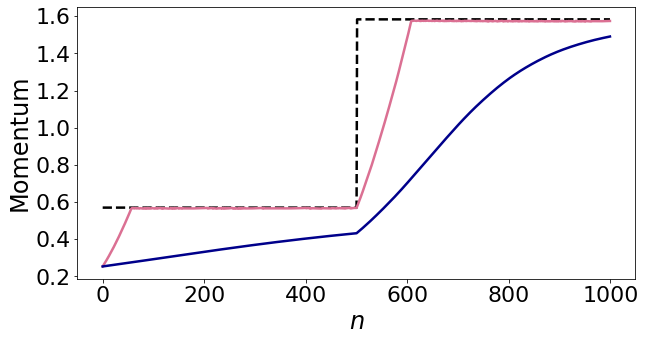

In [15]:

vanilla_kdv_opt_momentum_0 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_0), axis=-1)

vanilla_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_5), axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(momentum_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)


plt.plot(
    vanilla_kdv_opt_momentum_0,
    label=r"$Vanilla(\lambda = 0)$",
    color=pk_no_penalty_color, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.plot(
    vanilla_kdv_opt_momentum_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Momentum", fontsize=label_font)
# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

print("---Track Momentum Done---")


In [17]:



# Save data
results_dict = {'vanilla_kdv_opt_momentum_0': vanilla_kdv_opt_momentum_0,
            'vanilla_kdv_opt_momentum_5': vanilla_kdv_opt_momentum_5,
            'vanilla_kdv_opt_mass_0': vanilla_kdv_opt_mass_0,
            'vanilla_kdv_opt_mass_5': vanilla_kdv_opt_mass_5,
            'mass_ref':mass_ref,
            'momentum_ref':momentum_ref,
            'vanilla_t_list_momentum_0': vanilla_t_list_momentum_0,
            'vanilla_t_list_momentum_5': vanilla_t_list_momentum_5,
}

np.save(os.path.join(data_path,'vanilla_'+forcing_type+'_tau_'+str(tau)+'_tracking_results.npy'), results_dict)